<a id="top"></a>
# Interpreting Convolutional Neural Networks

***

## Learning Goals


**In this tutorial, you will practice analyzing and interpreting a convolutional neural network.**
 This tutorial assumes a basic knowledge of convolutional neural networks. We will utilize the model described in `Classifying_JWST-HST_galaxy_mergers_with_CNNs`, so it is recommended to complete that notebook before reading this one.

## Introduction
Machine learning techniques can be powerful tools for categorizing data and performing data analysis questions. However, machine learning techniques often involve a lot of hidden computation that is not immediately meaningful. The black-box nature of intermediary processes, especially in layered neural networks, can make it difficult to interpret and understand. The goal of this notebook is to familiarize you with some of the various techniques used to make sense of machine learning and convolutional neural networks (CNNs) in particular. CNNs in particular can be very difficult to interpret due to their multi-layered structure and convolutional layers. In this notebook, we will examine two methods of visualizing CNN results (Backpropagation and Grad-CAM) and another method for testing model architecture.

1. Load the data
2. Split the data into training, validation, and testing sets
3. Build and train a model
4. Apply some interpretation technique to understand your results from a physical perspective.


### Dependencies

This notebook uses the following packages:
- `numpy` to handle array functions
- `astropy` for downloading and accessing FITS files
- `matplotlib.pyplot` for plotting data
- `keras` and `tensorflow` for building the CNN
- `sklearn` for some utility functions

If you do not have these packages installed, you can install them using [`pip`](https://pip.pypa.io/en/stable/) or [`conda`](https://docs.conda.io/en/latest/).

Further information about the original model can be found at the [Hello Universe codebase](https://spacetelescope.github.io/hellouniverse/notebooks/hello-universe/Classifying_JWST-HST_galaxy_mergers_with_CNNs/Classifying_JWST-HST_galaxy_mergers_with_CNNs.html).


**Author:**  
Oliver Lin, oliverlin2004@gmail.com

**Additional Contributors:**  
Daisuke Nagai, daisuke.nagai@yale.edu.

Michelle Ntampaka, mntampaka@stsci.edu.

**Published:** 2024-05-08

In [1]:
# arrays
import numpy as np

# fits
from astropy.io import fits
from astropy.utils.data import download_file
from astropy.visualization import simple_norm

# plotting
from matplotlib import pyplot as plt

# keras
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization, Convolution2D, MaxPooling2D
# from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.regularizers import l2

# sklearn
from sklearn.model_selection import train_test_split

# tensorflow for saliency
import tensorflow as tf
import cv2

2025-08-01 19:35:17.534388: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-01 19:35:17.569169: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-01 19:35:17.569211: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-01 19:35:17.570319: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-01 19:35:17.576422: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-01 19:35:17.577514: I tensorflow/core/platform/cpu_feature_guard.cc:1

2025-08-01 19:35:18.523721: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Reloading our Model
To start, we need to reload our model from the previous galaxy classification notebook from the Mikulski Archive for Space Telescopes (MAST). The following code is directly copied over from that notebook. For a quick refresher, the model intakes a FITS file from a high level science product hosted by MAST. There are 15,426 observations in total, each taken with three filters (F814W from the Advanced Camera for Surveys and F160W from the Wide Field Camera 3 on the Hubble Space Telescope (HST), and F160W and F356W from Near Infrared Camera on the James Webb Space Telescope (JWST)). The model then applies a Convolutional Neural Network to classify whether a galaxy has undergone a merger.

In [2]:
version = 'pristine'
file_url = 'https://archive.stsci.edu/hlsps/deepmerge/hlsp_deepmerge_hst-jwst_acs-wfc3-nircam_illustris-z2_f814w-f160w-f356w_v1_sim-'+version+'.fits'
hdu = fits.open(download_file(file_url, cache=True, show_progress=True))

## Build and Compile the Convolutional Model
For the sake of transparency, we will rebuild the model using the same architecture as the original notebook. The model can also be loaded directly by using `save_model` and `load_model` from the [Keras](https://www.tensorflow.org/guide/keras/serialization_and_saving) package. 

In [3]:
X = hdu[0].data
y = hdu[1].data

Following the authors, we will split the data into 70:10:20 ratio of train:validate:test. As above, set the random seed to randomly split the images in a repeatable way. Feel free to try different values!



In [4]:
random_state = 42

X = np.asarray(X).astype('float32')
y = np.asarray(y).astype('float32')

# First split off 30% of the data for validation+testing
X_train, X_split, y_train, y_split = train_test_split(X, y, test_size=0.3, random_state=random_state, shuffle=True)

# Then divide this subset into training and testing sets
X_valid, X_test, y_valid, y_test = train_test_split(X_split, y_split, test_size=0.666, random_state=random_state, shuffle=True)

In [5]:
imsize = np.shape(X_train)[2]

X_train = np.array([np.stack(x, axis=2) for x in X_train])
X_valid = np.array([np.stack(x, axis=2) for x in X_valid])
X_test = np.array([np.stack(x, axis=2) for x in X_test])

### Generate the model architecture (written for Keras 2)

In [6]:
# Define architecture for model
data_shape = np.shape(X)
input_shape = (imsize, imsize, 3)

x_in = Input(shape=input_shape)
c0 = Convolution2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same')(x_in)
b0 = BatchNormalization()(c0)
d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b0)
e0 = Dropout(0.5)(d0)

c1 = Convolution2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same')(e0)
b1 = BatchNormalization()(c1)
d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b1)
e1 = Dropout(0.5)(d1)

c2 = Convolution2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same')(e1)
b2 = BatchNormalization()(c2)
d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b2)
e2 = Dropout(0.5)(d2)

f = Flatten()(e2)
z0 = Dense(64, activation='softmax', kernel_regularizer=l2(0.0001))(f)
z1 = Dense(32, activation='softmax', kernel_regularizer=l2(0.0001))(z0)
y_out = Dense(1, activation='sigmoid')(z1)

cnn = Model(inputs=x_in, outputs=y_out)

### Compile Model

In [7]:
optimizer = 'adam'
fit_metrics = ['accuracy']
loss = 'binary_crossentropy'
cnn.compile(loss=loss, optimizer=optimizer, metrics=fit_metrics)

### Load pretrained weights


In [8]:
file_url = 'https://archive.stsci.edu/hlsps/hellouniverse/hellouniverse_interpretability_best_weights.hdf5'
cnn.load_weights(download_file(file_url, cache=True, show_progress=True))

2025-08-01 19:35:21.259855: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open /home/runner/.astropy/cache/download/url/75479cba1a5e1313befcce7b9c2f3f36/contents: DATA_LOSS: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


## 1. Saliency Maps
We will start by introducing the most popular and well known method of interpreting CNNs. A saliency map can help us identify which pixels are significant to the models final prediction. There are many methods of calculating saliency maps, but the most popular method utilizes gradient backpropagation to determine the significance of pixels at each layer of the model. To calculate the saliency map, the error gradient at each layer is calculated and then fed into the previous layer, repeating until we reach the original image. Then the pixels with the highest gradient values will also have the most effect on the model's activation. This methodology is described in detail by <a href='https://arxiv.org/abs/1312.6034'>Simonyan et al. 2013</a>. 

### Dependencies

`tensorflow.GradientTape()` is used to track the gradient of the function.


In [9]:
# Choose the image to analyze
img_idx = 1

# We can change the index to any number in range of the test set
orig_img = X_test[img_idx]
img = orig_img
img = img.reshape((1, *img.shape))
norm = simple_norm(orig_img, 'log', max_percent=99.75)
scaled_img = norm(orig_img)

In [10]:
images = tf.Variable(img, dtype=float)

# Make a prediction and track gradients
with tf.GradientTape() as tape:
    pred = cnn(images, training=False)
    class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]    
    loss = pred[class_idxs_sorted[0]]

grads = tape.gradient(loss, images)

### Plot the original image and the saliency map

Saliency maps provide an intuitive understanding of how the model works. The hot pixels represent higher activation and more importance. In the below model, the saliency maps demonstrates that the model focuses on the area around the center of the galaxy for the majority of galaxies. Our results are in line with a corroborating result by [Ntampaka et al. 2018](https://arxiv.org/abs/1810.07703), suggesting that the key features of a galaxy are found the ring around the galaxy rather than in the center of the galaxy.

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 98ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.822696e-08..8.880155].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2109969226408994].


Text(0.5, 0.98, 'prediction_val=[[0.44489214]]')

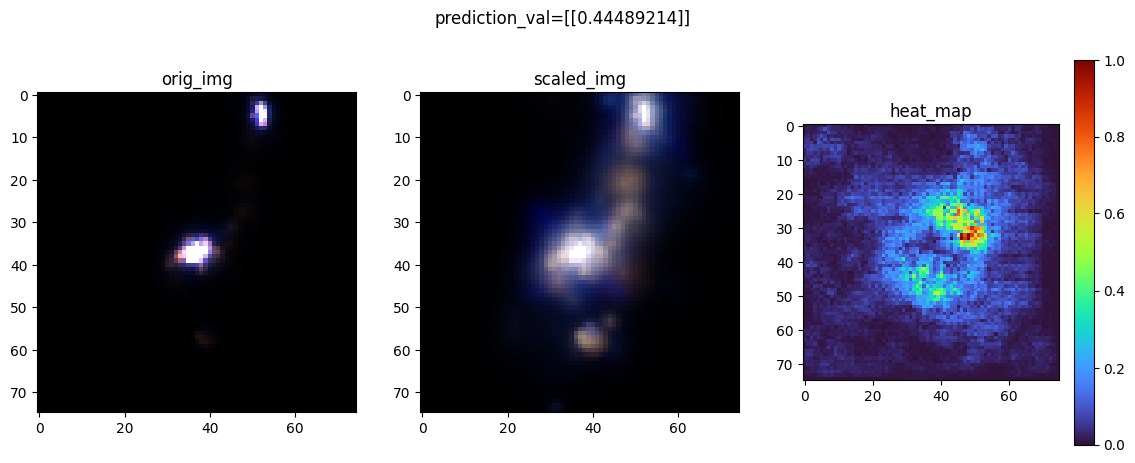

In [11]:
y_pred = cnn.predict(img)

dgrad_abs = tf.math.abs(grads)
dgrad_max_ = np.max(dgrad_abs, axis=3)[0]

# normalize to range between 0 and 1
arr_min, arr_max = np.min(dgrad_max_), np.max(dgrad_max_)
grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)

# Plot the results next to the original image
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

axes[0].imshow(orig_img)
axes[0].set_title("orig_img")
axes[1].imshow(scaled_img)
axes[1].set_title("scaled_img")
i = axes[2].imshow(grad_eval, cmap="turbo")
fig.colorbar(i)
axes[2].set_title("heat_map")
fig.suptitle("prediction_val=" + str(y_pred))

**Image caption**: The above image contains three panels in a horizontal row. The first panel shows the original image of a merging galaxy candidate, the second panel shows a logarithmically-scaled version of the original image, and the third panel shows a heat map of the saliency map.

### Create a stack of saliency images

To understand the overall behavior of our algorithm, we can stack some or all of the saliency maps in the test set to generate an overarching estimate of important pixels. For the sake of simplicity, we will stack the saliency maps for the first 100 images in the test set. Our results once again indicate that the region around a galaxy is particularly important to the model.

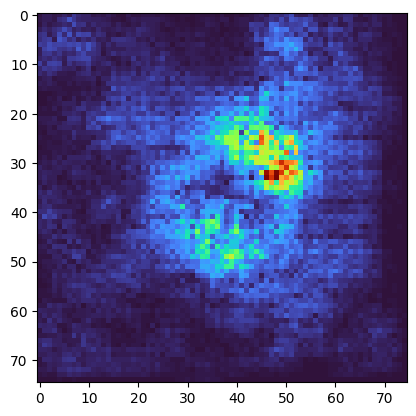

In [12]:
sum_map = np.zeros((75, 75))
# Summing the first 100 saliencies. We can change
# the range to sum more or less saliencies or pick 
# specific ones
for i in range(100):
    img = X_test[img_idx]
    img = img.reshape((1, *img.shape))
    images = tf.Variable(img, dtype=float)

    # Make a prediction and track gradients
    with tf.GradientTape() as tape:
        pred = cnn(images, training=False)
        class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]    
        loss = pred[class_idxs_sorted[0]]

    grads = tape.gradient(loss, images)

    y_pred = cnn.predict(images, verbose=0)

    dgrad_abs = tf.math.abs(grads)
    dgrad_max_ = np.max(dgrad_abs, axis=3)[0]

    # normalize to range between 0 and 1
    arr_min, arr_max = np.min(dgrad_max_), np.max(dgrad_max_)
    grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min)
    sum_map += grad_eval
plt.imshow(sum_map, cmap='turbo')

**Image caption**: The above image contains a single panel, and shows a stacked version of the saliency maps from 100 images.

## 2. Grad-CAM
While gradient backpropagation has historically been the most popular type of saliency map, the highly connected nature of backtracking has been shown to produce high variance under small changes to inputs. As such, gradient backpropagation is extremely sensitive to data manipulation (preprocessing, sensitivity analysis, GANs), raising questions about its reliability and validity. Gradient Class Activation Mapping (Grad-CAM) is an alternative method for generating saliency models that only examines the gradient of the final convolutional layer when producing the map. As a consequence, Grad-CAM maps have lower (coarser) resolution than backpropagation but are far more resilient to small changes and therefore more reliable when tuning a model. A full description of the technique can be found in <a href='https://arxiv.org/abs/1610.02391'>Selveraju et al. 2016</a>.

The code for Grad-CAM comes from a useful tutorial on the subject by Daniel Reiff. For more information, please visit the  <a href='https://towardsdatascience.com/understand-your-algorithm-with-grad-cam-d3b62fce353'>full tutorial</a>.

### Dependencies

`Open_CV` and `astropy.simple_norm` are used to do manipulate the image for display. Alternatively, we could allow Python to automatically clip the image when the heatmap is out of range.

In [13]:
# Choose the image to analyze
img_idx = 1

# We can change the index to any number in range of the test set
orig_img = X_test[img_idx]
img = orig_img
img = img.reshape((1, *img.shape))
norm = simple_norm(orig_img, 'log', max_percent=99.75)
scaled_img = norm(orig_img)

In [14]:
# Note: recompiling the model will change the layer
# name. In that case, you can either restart the 
# kernel or change the layer_name.
# We can also change the layer selected here to pull out any layer of our model
gradModel = Model(inputs=[cnn.inputs], outputs=[cnn.get_layer("conv2d_2").output, cnn.output])

with tf.GradientTape() as tape:
    # get the loss with associated with the prediction
    inputs = tf.cast(X_test, tf.float32)
    (convOutputs, predictions) = gradModel(inputs)
    loss = predictions[:, 0]
    
# use automatic differentiation to compute the gradients
grads = tape.gradient(loss, convOutputs)

# compute the guided gradients by removing all nonpositive
# gradients
castConvOutputs = tf.cast(convOutputs > 0, "float32")
castGrads = tf.cast(grads > 0, "float32")
guidedGrads = castConvOutputs * castGrads * grads

# pick out the convolution and gradient of the chosen image
convOutputs = convOutputs[img_idx]
guidedGrads = guidedGrads[img_idx]

# compute the average of the gradient values, and using them
# as weights, compute the importance of the pieces
weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

# grab the spatial dimensions of the input image and resize
# the output class activation map to match the input image
# dimensions
(w, h) = (X_test.shape[2], X_test.shape[1])
heatmap = cv2.resize(cam.numpy(), (w, h))

# normalize the heatmap such that all values lie in the range
# [0, 1], scale the resulting values to the range [0, 255],
# and then convert to an unsigned 8-bit integer

2025-08-01 19:35:24.544116: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.


2025-08-01 19:35:25.388108: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.
2025-08-01 19:35:25.469865: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.
2025-08-01 19:35:25.525097: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.


2025-08-01 19:35:27.170134: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.822696e-08..8.880155].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2109969226408994].


Text(0.5, 0.98, 'prediction_val=[[0.44489214]]')

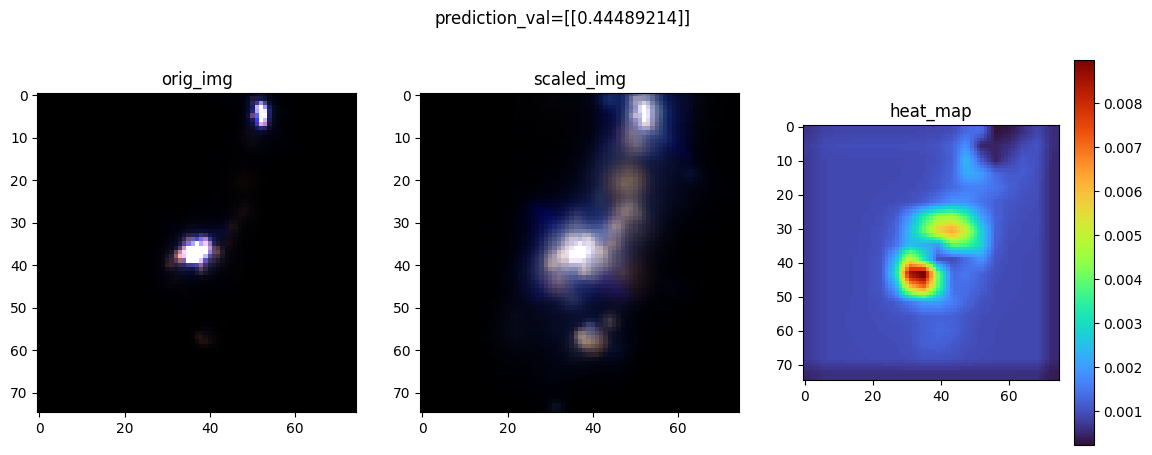

In [15]:
y_pred = cnn.predict(img)

# Plot the results next to the original image
fig, axes = plt.subplots(1, 3, figsize=(14, 5))
axes[0].imshow(orig_img)
axes[0].set_title("orig_img")
axes[1].imshow(scaled_img)
axes[1].set_title("scaled_img")
i = axes[2].imshow(heatmap, cmap="turbo")
fig.colorbar(i)
axes[2].set_title("heat_map")
fig.suptitle("prediction_val=" + str(y_pred))

**Image caption**: The above image contains three panels in a horizontal row. The first panel shows the original image of a merging galaxy candidate, the second panel shows a logarithmically-scaled version of the original image, and the third panel shows a heat map of the grad-cam map.

**The result is very similar** to our saliency map from backpropagation, although the image is coarser and also shows both the top and bottom of the galaxy. We can also play around with the selected layer to calculate the output at different steps in the model and see how activation changes throughout the model.

## 3. RISE Algorithm
The RISE (Randomized Input Sampling for Explanation) Algorithm is another interpretation technique for calculating saliency maps. Instead of calculating gradients from within the model, the RISE implementation works by covering up pieces of the input image, running it through the model, and calculating the average activation in order to determine what parts of the image are most important. As such, this method does not require any access to the inner workings of the model. The algorithm first generates a random sequence of binary grids (called masks), which are placed onto the image. Everything not covered by the mask is removed by multiplying the images together, and the resultant activations are averaged to get our final heatmap. A full description of the algorithm and its variations is provided by <a href='https://arxiv.org/abs/1806.07421'>Petsiuk et al. 2018</a>. 



In [16]:
# Choose the image to analyze
img_idx = 6

# We can change the index to any number in range of the test set
image = X_test[img_idx]

N = 1000  # Number of masks
s = 8     # Size of the grid
p1 = 0.5  # Probability of the cell being set to 1

cell_size = np.ceil(np.array(input_shape[:2]) / s).astype(int)
up_size = (s * cell_size).astype(int)

grid = np.random.rand(N, s, s) < p1
masks = np.empty((N, *input_shape[:2]))

for i in range(N):
    # Randomly place the grid on the image
    x = np.random.randint(0, input_shape[0]-s)
    y = np.random.randint(0, input_shape[1]-s)
    mask = np.pad(grid[i], ((x, input_shape[0]-x-s), (y, input_shape[0]-y-s)), 'constant', constant_values=(0, 0))
    mask = mask[:input_shape[0], :input_shape[1]]
    masks[i] = mask

masks = masks.reshape(-1, *input_shape[:2], 1)

N = len(masks)
pred_masks = cnn.predict(image * masks)
pred_masks = np.expand_dims(pred_masks, axis=-1)
pred_masks = np.expand_dims(pred_masks, axis=-1) # Reshape pred_masks for broadcasting
heatmap = (pred_masks * masks).sum(axis=0)
heatmap = heatmap / N / p1

 1/32 [..............................] - ETA: 0s

 4/32 [==>...........................] - ETA: 0s

 7/32 [=====>........................] - ETA: 0s

10/32 [========>.....................] - ETA: 0s

13/32 [===========>..................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 1s 16ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00022207294..674.50696].


Text(0.5, 1.0, 'heat_map')

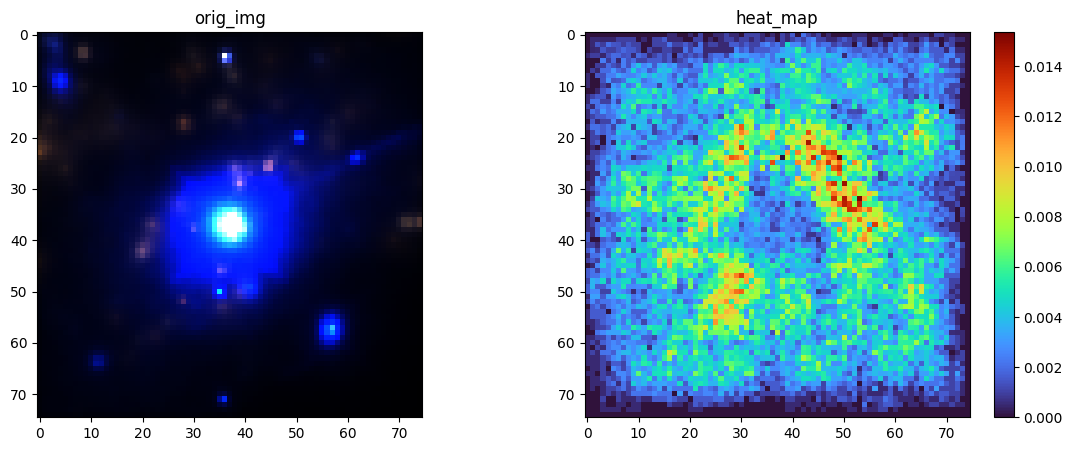

In [17]:
# Plot the results next to the original image
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].imshow(image)
axes[0].set_title("orig_img")
i = axes[1].imshow(heatmap, cmap="turbo")
fig.colorbar(i)
axes[1].set_title("heat_map")

**Image caption**: The above image contains two panels in a horizontal row. The first panel shows the original image of a merginig galaxy candidate, and the second panel shows a heat map of the RISE map.

**When examining the selected image**, we see a ring around the galactic center. Note that this is not the case for all astronomical images, or even all images in this dataset. Try playing around with the selected image to generate different saliency maps. For images where the central feature is relatively small, RISE's occlusion-based methodology can be unreliable.

## 4. Ablation Analysis
Saliency maps provide an intuitive visual understanding of our model's focus and can be useful for understanding the physical relevance of our classification scheme. In order to understand the efficacy of our model's architecture, we can instead use ablation analysis to determine the most important layers of our model. Ablation analysis works by rebuilding our model without a specified layer of interest and testing and comparing the performance of a partial model. Since we are focusing on our model's internal architecture rather than the features of the dataset we are looking at, we want to use this technique when trying to improve the training metrics of our model by editing its layers. This method allows us to determine which layers of the model are most important, or if some layers are hindering the learning capabilities of our mode

In the exercise below, we will build and train four mini-models on the same data set as before. As this is an educational notebook, we will limit the training time of each model to five epochs. Results with these models may vary considerably due to these training constraints, but we highly encourage you to try modifying this section of the notebook for different results (see [Exercises](#Exercises/Extensions))

Note that performing an ablation analysis will require training multiple models with the same architecture. This can be quite compute intensive on personal computers, so if you are running this notebook locally it is recommended that your device be plugged in before running the analysis.

### Dependencies

`Tensorflow` is used build our model and train it.

In [18]:
def create_model(ablate=None):
    x_in = Input(shape=input_shape)
    
    if ablate != 'c0':
        c0 = Convolution2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same')(x_in)
    else:
        c0 = x_in
    b0 = BatchNormalization()(c0)
    d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b0)
    e0 = Dropout(0.5)(d0)

    if ablate != 'c1':
        c1 = Convolution2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same')(e0)
    else:
        c1 = e0
    b1 = BatchNormalization()(c1)
    d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b1)
    e1 = Dropout(0.5)(d1)

    if ablate != 'c2':
        c2 = Convolution2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same')(e1)
    else:
        c2 = e1
    b2 = BatchNormalization()(c2)
    d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b2)
    e2 = Dropout(0.5)(d2)

    f = Flatten()(e2)
    z0 = Dense(64, activation='softmax', kernel_regularizer=l2(0.0001))(f)
    z1 = Dense(32, activation='softmax', kernel_regularizer=l2(0.0001))(z0)
    y_out = Dense(1, activation='sigmoid')(z1)

    cnn = Model(inputs=x_in, outputs=y_out)
    return cnn

**Since ablation analysis requires training multiple models**, it can often be more resource intensive than other methods. However, it can also provide useful information on the way features are organized during training. The following cell can be edited to change how much we want to train our mini-models.

In [19]:
# You can change how much to train each model
# 5 epochs is chosen due to time and computation constraints
num_epochs = 5

# Train the original model
model = create_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test))

# Get baseline performance
baseline_score = model.evaluate(X_test, y_test)

# Ablate each layer and compare performance
layers_to_ablate = ['c0', 'c1', 'c2']
for layer in layers_to_ablate:
    model_ablated = create_model(ablate=layer)
    model_ablated.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model_ablated.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test))
    ablated_score = model_ablated.evaluate(X_test, y_test)
    
    print(f"Performance drop after ablating {layer}: {baseline_score[1] - ablated_score[1]}")

Epoch 1/5


  1/338 [..............................] - ETA: 7:28 - loss: 0.7085 - accuracy: 0.5625

  2/338 [..............................] - ETA: 21s - loss: 0.7099 - accuracy: 0.4844 

  3/338 [..............................] - ETA: 20s - loss: 0.7091 - accuracy: 0.5208

  4/338 [..............................] - ETA: 20s - loss: 0.7090 - accuracy: 0.5156

  5/338 [..............................] - ETA: 20s - loss: 0.7084 - accuracy: 0.5250

  6/338 [..............................] - ETA: 20s - loss: 0.7081 - accuracy: 0.5260

  7/338 [..............................] - ETA: 20s - loss: 0.7071 - accuracy: 0.5580

  8/338 [..............................] - ETA: 19s - loss: 0.7066 - accuracy: 0.5664

  9/338 [..............................] - ETA: 19s - loss: 0.7065 - accuracy: 0.5625

 10/338 [..............................] - ETA: 19s - loss: 0.7066 - accuracy: 0.5469

 11/338 [..............................] - ETA: 19s - loss: 0.7063 - accuracy: 0.5483

 12/338 [>.............................] - ETA: 19s - loss: 0.7063 - accuracy: 0.5365

 13/338 [>.............................] - ETA: 19s - loss: 0.7059 - accuracy: 0.5409

 14/338 [>.............................] - ETA: 19s - loss: 0.7055 - accuracy: 0.5446

 15/338 [>.............................] - ETA: 19s - loss: 0.7052 - accuracy: 0.5479

 16/338 [>.............................] - ETA: 19s - loss: 0.7048 - accuracy: 0.5508

 17/338 [>.............................] - ETA: 19s - loss: 0.7048 - accuracy: 0.5423

 18/338 [>.............................] - ETA: 18s - loss: 0.7047 - accuracy: 0.5399

 19/338 [>.............................] - ETA: 18s - loss: 0.7045 - accuracy: 0.5395

 20/338 [>.............................] - ETA: 18s - loss: 0.7042 - accuracy: 0.5406

 21/338 [>.............................] - ETA: 18s - loss: 0.7040 - accuracy: 0.5402

 22/338 [>.............................] - ETA: 18s - loss: 0.7038 - accuracy: 0.5412

 23/338 [=>............................] - ETA: 18s - loss: 0.7035 - accuracy: 0.5435

 24/338 [=>............................] - ETA: 18s - loss: 0.7032 - accuracy: 0.5456

 25/338 [=>............................] - ETA: 18s - loss: 0.7029 - accuracy: 0.5475

 26/338 [=>............................] - ETA: 18s - loss: 0.7027 - accuracy: 0.5481

 27/338 [=>............................] - ETA: 18s - loss: 0.7024 - accuracy: 0.5486

 28/338 [=>............................] - ETA: 18s - loss: 0.7023 - accuracy: 0.5469

 29/338 [=>............................] - ETA: 18s - loss: 0.7019 - accuracy: 0.5517

 30/338 [=>............................] - ETA: 18s - loss: 0.7016 - accuracy: 0.5542

 31/338 [=>............................] - ETA: 18s - loss: 0.7013 - accuracy: 0.5565

 32/338 [=>............................] - ETA: 18s - loss: 0.7011 - accuracy: 0.5576

 33/338 [=>............................] - ETA: 17s - loss: 0.7013 - accuracy: 0.5502

 34/338 [==>...........................] - ETA: 17s - loss: 0.7014 - accuracy: 0.5469

 35/338 [==>...........................] - ETA: 17s - loss: 0.7013 - accuracy: 0.5455

 36/338 [==>...........................] - ETA: 17s - loss: 0.7010 - accuracy: 0.5469

 37/338 [==>...........................] - ETA: 17s - loss: 0.7007 - accuracy: 0.5498

 38/338 [==>...........................] - ETA: 17s - loss: 0.7005 - accuracy: 0.5502

 39/338 [==>...........................] - ETA: 17s - loss: 0.7004 - accuracy: 0.5497

 40/338 [==>...........................] - ETA: 17s - loss: 0.7003 - accuracy: 0.5484

 41/338 [==>...........................] - ETA: 17s - loss: 0.7004 - accuracy: 0.5450

 42/338 [==>...........................] - ETA: 17s - loss: 0.7001 - accuracy: 0.5476

 43/338 [==>...........................] - ETA: 17s - loss: 0.7001 - accuracy: 0.5458

 44/338 [==>...........................] - ETA: 17s - loss: 0.6998 - accuracy: 0.5483

 45/338 [==>...........................] - ETA: 17s - loss: 0.6996 - accuracy: 0.5500

 46/338 [===>..........................] - ETA: 17s - loss: 0.6997 - accuracy: 0.5455

 47/338 [===>..........................] - ETA: 17s - loss: 0.6998 - accuracy: 0.5439

 48/338 [===>..........................] - ETA: 17s - loss: 0.6996 - accuracy: 0.5449

 49/338 [===>..........................] - ETA: 17s - loss: 0.6995 - accuracy: 0.5434

 50/338 [===>..........................] - ETA: 16s - loss: 0.6996 - accuracy: 0.5412

 51/338 [===>..........................] - ETA: 16s - loss: 0.6995 - accuracy: 0.5411

 52/338 [===>..........................] - ETA: 16s - loss: 0.6994 - accuracy: 0.5415

 53/338 [===>..........................] - ETA: 16s - loss: 0.6991 - accuracy: 0.5436

 54/338 [===>..........................] - ETA: 16s - loss: 0.6990 - accuracy: 0.5434

 55/338 [===>..........................] - ETA: 16s - loss: 0.6988 - accuracy: 0.5449

 56/338 [===>..........................] - ETA: 16s - loss: 0.6987 - accuracy: 0.5452

 57/338 [====>.........................] - ETA: 16s - loss: 0.6985 - accuracy: 0.5466

 58/338 [====>.........................] - ETA: 16s - loss: 0.6984 - accuracy: 0.5463

 59/338 [====>.........................] - ETA: 16s - loss: 0.6983 - accuracy: 0.5477

 60/338 [====>.........................] - ETA: 16s - loss: 0.6983 - accuracy: 0.5453

 61/338 [====>.........................] - ETA: 16s - loss: 0.6983 - accuracy: 0.5441

 62/338 [====>.........................] - ETA: 16s - loss: 0.6982 - accuracy: 0.5439

 63/338 [====>.........................] - ETA: 16s - loss: 0.6983 - accuracy: 0.5427

 64/338 [====>.........................] - ETA: 16s - loss: 0.6983 - accuracy: 0.5415

 65/338 [====>.........................] - ETA: 16s - loss: 0.6983 - accuracy: 0.5399

 66/338 [====>.........................] - ETA: 16s - loss: 0.6984 - accuracy: 0.5384

 67/338 [====>.........................] - ETA: 15s - loss: 0.6984 - accuracy: 0.5368

 68/338 [=====>........................] - ETA: 15s - loss: 0.6982 - accuracy: 0.5395

 69/338 [=====>........................] - ETA: 15s - loss: 0.6982 - accuracy: 0.5380

 70/338 [=====>........................] - ETA: 15s - loss: 0.6983 - accuracy: 0.5366

 71/338 [=====>........................] - ETA: 15s - loss: 0.6980 - accuracy: 0.5387

 72/338 [=====>........................] - ETA: 15s - loss: 0.6980 - accuracy: 0.5386

 73/338 [=====>........................] - ETA: 15s - loss: 0.6981 - accuracy: 0.5368

 74/338 [=====>........................] - ETA: 15s - loss: 0.6981 - accuracy: 0.5351

 75/338 [=====>........................] - ETA: 15s - loss: 0.6981 - accuracy: 0.5342

 76/338 [=====>........................] - ETA: 15s - loss: 0.6981 - accuracy: 0.5329

 77/338 [=====>........................] - ETA: 15s - loss: 0.6979 - accuracy: 0.5345

 78/338 [=====>........................] - ETA: 15s - loss: 0.6979 - accuracy: 0.5345

 79/338 [======>.......................] - ETA: 15s - loss: 0.6979 - accuracy: 0.5336

 80/338 [======>.......................] - ETA: 15s - loss: 0.6979 - accuracy: 0.5320

 81/338 [======>.......................] - ETA: 15s - loss: 0.6979 - accuracy: 0.5324

 82/338 [======>.......................] - ETA: 15s - loss: 0.6979 - accuracy: 0.5312

 83/338 [======>.......................] - ETA: 15s - loss: 0.6978 - accuracy: 0.5324

 84/338 [======>.......................] - ETA: 14s - loss: 0.6975 - accuracy: 0.5353

 85/338 [======>.......................] - ETA: 14s - loss: 0.6974 - accuracy: 0.5360

 86/338 [======>.......................] - ETA: 14s - loss: 0.6974 - accuracy: 0.5352

 87/338 [======>.......................] - ETA: 14s - loss: 0.6973 - accuracy: 0.5356

 88/338 [======>.......................] - ETA: 14s - loss: 0.6974 - accuracy: 0.5344

 89/338 [======>.......................] - ETA: 14s - loss: 0.6974 - accuracy: 0.5330

 90/338 [======>.......................] - ETA: 14s - loss: 0.6974 - accuracy: 0.5323

 91/338 [=======>......................] - ETA: 14s - loss: 0.6974 - accuracy: 0.5319

 92/338 [=======>......................] - ETA: 14s - loss: 0.6975 - accuracy: 0.5309

 93/338 [=======>......................] - ETA: 14s - loss: 0.6973 - accuracy: 0.5319

 94/338 [=======>......................] - ETA: 14s - loss: 0.6972 - accuracy: 0.5332

 95/338 [=======>......................] - ETA: 14s - loss: 0.6971 - accuracy: 0.5345

 96/338 [=======>......................] - ETA: 14s - loss: 0.6970 - accuracy: 0.5342

 97/338 [=======>......................] - ETA: 14s - loss: 0.6970 - accuracy: 0.5345

 98/338 [=======>......................] - ETA: 14s - loss: 0.6970 - accuracy: 0.5328

 99/338 [=======>......................] - ETA: 14s - loss: 0.6971 - accuracy: 0.5316

100/338 [=======>......................] - ETA: 14s - loss: 0.6970 - accuracy: 0.5325

101/338 [=======>......................] - ETA: 13s - loss: 0.6970 - accuracy: 0.5325

102/338 [========>.....................] - ETA: 13s - loss: 0.6970 - accuracy: 0.5312

103/338 [========>.....................] - ETA: 13s - loss: 0.6970 - accuracy: 0.5309

104/338 [========>.....................] - ETA: 13s - loss: 0.6970 - accuracy: 0.5300

105/338 [========>.....................] - ETA: 13s - loss: 0.6969 - accuracy: 0.5315

106/338 [========>.....................] - ETA: 13s - loss: 0.6968 - accuracy: 0.5321

107/338 [========>.....................] - ETA: 13s - loss: 0.6968 - accuracy: 0.5310

108/338 [========>.....................] - ETA: 13s - loss: 0.6968 - accuracy: 0.5312

109/338 [========>.....................] - ETA: 13s - loss: 0.6966 - accuracy: 0.5324

110/338 [========>.....................] - ETA: 13s - loss: 0.6967 - accuracy: 0.5318

111/338 [========>.....................] - ETA: 13s - loss: 0.6966 - accuracy: 0.5327

112/338 [========>.....................] - ETA: 13s - loss: 0.6966 - accuracy: 0.5321

113/338 [=========>....................] - ETA: 13s - loss: 0.6965 - accuracy: 0.5321

114/338 [=========>....................] - ETA: 13s - loss: 0.6964 - accuracy: 0.5326

115/338 [=========>....................] - ETA: 13s - loss: 0.6965 - accuracy: 0.5312

116/338 [=========>....................] - ETA: 13s - loss: 0.6964 - accuracy: 0.5323

117/338 [=========>....................] - ETA: 13s - loss: 0.6963 - accuracy: 0.5329

118/338 [=========>....................] - ETA: 12s - loss: 0.6963 - accuracy: 0.5328

119/338 [=========>....................] - ETA: 12s - loss: 0.6962 - accuracy: 0.5336

120/338 [=========>....................] - ETA: 12s - loss: 0.6962 - accuracy: 0.5333

121/338 [=========>....................] - ETA: 12s - loss: 0.6961 - accuracy: 0.5336

122/338 [=========>....................] - ETA: 12s - loss: 0.6961 - accuracy: 0.5328

123/338 [=========>....................] - ETA: 12s - loss: 0.6961 - accuracy: 0.5330

124/338 [==========>...................] - ETA: 12s - loss: 0.6961 - accuracy: 0.5325

125/338 [==========>...................] - ETA: 12s - loss: 0.6960 - accuracy: 0.5325

126/338 [==========>...................] - ETA: 12s - loss: 0.6960 - accuracy: 0.5330

127/338 [==========>...................] - ETA: 12s - loss: 0.6959 - accuracy: 0.5332

128/338 [==========>...................] - ETA: 12s - loss: 0.6959 - accuracy: 0.5334

129/338 [==========>...................] - ETA: 12s - loss: 0.6958 - accuracy: 0.5334

130/338 [==========>...................] - ETA: 12s - loss: 0.6958 - accuracy: 0.5337

131/338 [==========>...................] - ETA: 12s - loss: 0.6958 - accuracy: 0.5332

132/338 [==========>...................] - ETA: 12s - loss: 0.6958 - accuracy: 0.5334

133/338 [==========>...................] - ETA: 12s - loss: 0.6958 - accuracy: 0.5329

134/338 [==========>...................] - ETA: 12s - loss: 0.6958 - accuracy: 0.5324

135/338 [==========>...................] - ETA: 11s - loss: 0.6958 - accuracy: 0.5319

136/338 [===========>..................] - ETA: 11s - loss: 0.6958 - accuracy: 0.5310

137/338 [===========>..................] - ETA: 11s - loss: 0.6959 - accuracy: 0.5306

138/338 [===========>..................] - ETA: 11s - loss: 0.6959 - accuracy: 0.5299

139/338 [===========>..................] - ETA: 11s - loss: 0.6958 - accuracy: 0.5308

140/338 [===========>..................] - ETA: 11s - loss: 0.6957 - accuracy: 0.5312

141/338 [===========>..................] - ETA: 11s - loss: 0.6957 - accuracy: 0.5317

142/338 [===========>..................] - ETA: 11s - loss: 0.6956 - accuracy: 0.5326

143/338 [===========>..................] - ETA: 11s - loss: 0.6956 - accuracy: 0.5315

144/338 [===========>..................] - ETA: 11s - loss: 0.6956 - accuracy: 0.5319

145/338 [===========>..................] - ETA: 11s - loss: 0.6955 - accuracy: 0.5323

146/338 [===========>..................] - ETA: 11s - loss: 0.6954 - accuracy: 0.5332

147/338 [============>.................] - ETA: 11s - loss: 0.6953 - accuracy: 0.5342

148/338 [============>.................] - ETA: 11s - loss: 0.6953 - accuracy: 0.5342

149/338 [============>.................] - ETA: 11s - loss: 0.6953 - accuracy: 0.5338

150/338 [============>.................] - ETA: 11s - loss: 0.6953 - accuracy: 0.5329

151/338 [============>.................] - ETA: 11s - loss: 0.6953 - accuracy: 0.5329

152/338 [============>.................] - ETA: 10s - loss: 0.6953 - accuracy: 0.5327

153/338 [============>.................] - ETA: 10s - loss: 0.6953 - accuracy: 0.5327

154/338 [============>.................] - ETA: 10s - loss: 0.6952 - accuracy: 0.5337

155/338 [============>.................] - ETA: 10s - loss: 0.6952 - accuracy: 0.5327

156/338 [============>.................] - ETA: 10s - loss: 0.6953 - accuracy: 0.5321

157/338 [============>.................] - ETA: 10s - loss: 0.6953 - accuracy: 0.5316

158/338 [=============>................] - ETA: 10s - loss: 0.6953 - accuracy: 0.5309

159/338 [=============>................] - ETA: 10s - loss: 0.6954 - accuracy: 0.5305

160/338 [=============>................] - ETA: 10s - loss: 0.6952 - accuracy: 0.5316

161/338 [=============>................] - ETA: 10s - loss: 0.6952 - accuracy: 0.5316

162/338 [=============>................] - ETA: 10s - loss: 0.6951 - accuracy: 0.5326

163/338 [=============>................] - ETA: 10s - loss: 0.6951 - accuracy: 0.5320

164/338 [=============>................] - ETA: 10s - loss: 0.6951 - accuracy: 0.5318

165/338 [=============>................] - ETA: 10s - loss: 0.6951 - accuracy: 0.5316

166/338 [=============>................] - ETA: 10s - loss: 0.6951 - accuracy: 0.5314

167/338 [=============>................] - ETA: 10s - loss: 0.6952 - accuracy: 0.5309

168/338 [=============>................] - ETA: 9s - loss: 0.6952 - accuracy: 0.5299 

169/338 [==============>...............] - ETA: 9s - loss: 0.6953 - accuracy: 0.5294

170/338 [==============>...............] - ETA: 9s - loss: 0.6953 - accuracy: 0.5290

171/338 [==============>...............] - ETA: 9s - loss: 0.6953 - accuracy: 0.5283

172/338 [==============>...............] - ETA: 9s - loss: 0.6952 - accuracy: 0.5289

173/338 [==============>...............] - ETA: 9s - loss: 0.6952 - accuracy: 0.5285

174/338 [==============>...............] - ETA: 9s - loss: 0.6953 - accuracy: 0.5280

175/338 [==============>...............] - ETA: 9s - loss: 0.6953 - accuracy: 0.5271

176/338 [==============>...............] - ETA: 9s - loss: 0.6953 - accuracy: 0.5266

177/338 [==============>...............] - ETA: 9s - loss: 0.6953 - accuracy: 0.5263

178/338 [==============>...............] - ETA: 9s - loss: 0.6953 - accuracy: 0.5262

179/338 [==============>...............] - ETA: 9s - loss: 0.6953 - accuracy: 0.5264

180/338 [==============>...............] - ETA: 9s - loss: 0.6953 - accuracy: 0.5255

181/338 [===============>..............] - ETA: 9s - loss: 0.6953 - accuracy: 0.5257

182/338 [===============>..............] - ETA: 9s - loss: 0.6953 - accuracy: 0.5258

183/338 [===============>..............] - ETA: 9s - loss: 0.6953 - accuracy: 0.5256

184/338 [===============>..............] - ETA: 9s - loss: 0.6953 - accuracy: 0.5260

185/338 [===============>..............] - ETA: 9s - loss: 0.6952 - accuracy: 0.5267

186/338 [===============>..............] - ETA: 8s - loss: 0.6952 - accuracy: 0.5264

187/338 [===============>..............] - ETA: 8s - loss: 0.6952 - accuracy: 0.5259

188/338 [===============>..............] - ETA: 8s - loss: 0.6952 - accuracy: 0.5258

189/338 [===============>..............] - ETA: 8s - loss: 0.6952 - accuracy: 0.5260

190/338 [===============>..............] - ETA: 8s - loss: 0.6952 - accuracy: 0.5258

191/338 [===============>..............] - ETA: 8s - loss: 0.6952 - accuracy: 0.5254

192/338 [================>.............] - ETA: 8s - loss: 0.6952 - accuracy: 0.5256

193/338 [================>.............] - ETA: 8s - loss: 0.6951 - accuracy: 0.5259

194/338 [================>.............] - ETA: 8s - loss: 0.6951 - accuracy: 0.5266

195/338 [================>.............] - ETA: 8s - loss: 0.6951 - accuracy: 0.5263

196/338 [================>.............] - ETA: 8s - loss: 0.6951 - accuracy: 0.5263

197/338 [================>.............] - ETA: 8s - loss: 0.6950 - accuracy: 0.5266

198/338 [================>.............] - ETA: 8s - loss: 0.6950 - accuracy: 0.5271

199/338 [================>.............] - ETA: 8s - loss: 0.6950 - accuracy: 0.5267

200/338 [================>.............] - ETA: 8s - loss: 0.6950 - accuracy: 0.5269

201/338 [================>.............] - ETA: 8s - loss: 0.6949 - accuracy: 0.5271

202/338 [================>.............] - ETA: 8s - loss: 0.6949 - accuracy: 0.5269

203/338 [=================>............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5265

204/338 [=================>............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5267

205/338 [=================>............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5265

206/338 [=================>............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5265

207/338 [=================>............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5266

208/338 [=================>............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5263

209/338 [=================>............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5260

210/338 [=================>............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5254

211/338 [=================>............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5246

212/338 [=================>............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5245

213/338 [=================>............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5244

214/338 [=================>............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5241

215/338 [==================>...........] - ETA: 7s - loss: 0.6949 - accuracy: 0.5235

216/338 [==================>...........] - ETA: 7s - loss: 0.6949 - accuracy: 0.5237

217/338 [==================>...........] - ETA: 7s - loss: 0.6949 - accuracy: 0.5233

218/338 [==================>...........] - ETA: 7s - loss: 0.6949 - accuracy: 0.5229

219/338 [==================>...........] - ETA: 7s - loss: 0.6949 - accuracy: 0.5231

220/338 [==================>...........] - ETA: 6s - loss: 0.6949 - accuracy: 0.5227

221/338 [==================>...........] - ETA: 6s - loss: 0.6949 - accuracy: 0.5232

222/338 [==================>...........] - ETA: 6s - loss: 0.6948 - accuracy: 0.5235

223/338 [==================>...........] - ETA: 6s - loss: 0.6948 - accuracy: 0.5242

224/338 [==================>...........] - ETA: 6s - loss: 0.6948 - accuracy: 0.5239

225/338 [==================>...........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5243

226/338 [===================>..........] - ETA: 6s - loss: 0.6948 - accuracy: 0.5234

227/338 [===================>..........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5235

228/338 [===================>..........] - ETA: 6s - loss: 0.6948 - accuracy: 0.5232

229/338 [===================>..........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5237

230/338 [===================>..........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5238

231/338 [===================>..........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5238

232/338 [===================>..........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5238

233/338 [===================>..........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5240

234/338 [===================>..........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5243

235/338 [===================>..........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5237

236/338 [===================>..........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5240

237/338 [====================>.........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5237

238/338 [====================>.........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5238

239/338 [====================>.........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5237

240/338 [====================>.........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5237

241/338 [====================>.........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5237

242/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5235

243/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5238

244/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5242

245/338 [====================>.........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5246

246/338 [====================>.........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5244

247/338 [====================>.........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5243

248/338 [=====================>........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5238

249/338 [=====================>........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5242

250/338 [=====================>........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5236

251/338 [=====================>........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5237

252/338 [=====================>........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5237

253/338 [=====================>........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5235

254/338 [=====================>........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5231

255/338 [=====================>........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5235

256/338 [=====================>........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5233

257/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5241

258/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5242

259/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5243

260/338 [======================>.......] - ETA: 4s - loss: 0.6943 - accuracy: 0.5243

261/338 [======================>.......] - ETA: 4s - loss: 0.6943 - accuracy: 0.5239

262/338 [======================>.......] - ETA: 4s - loss: 0.6943 - accuracy: 0.5235

263/338 [======================>.......] - ETA: 4s - loss: 0.6942 - accuracy: 0.5240

264/338 [======================>.......] - ETA: 4s - loss: 0.6942 - accuracy: 0.5238

265/338 [======================>.......] - ETA: 4s - loss: 0.6942 - accuracy: 0.5241

266/338 [======================>.......] - ETA: 4s - loss: 0.6942 - accuracy: 0.5242

267/338 [======================>.......] - ETA: 4s - loss: 0.6941 - accuracy: 0.5250

268/338 [======================>.......] - ETA: 4s - loss: 0.6941 - accuracy: 0.5254

269/338 [======================>.......] - ETA: 4s - loss: 0.6940 - accuracy: 0.5256

270/338 [======================>.......] - ETA: 4s - loss: 0.6940 - accuracy: 0.5256

271/338 [=======================>......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5262

272/338 [=======================>......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5257

273/338 [=======================>......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5258

274/338 [=======================>......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5258

275/338 [=======================>......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5263

276/338 [=======================>......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5260

277/338 [=======================>......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5258

278/338 [=======================>......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5260

279/338 [=======================>......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5264

280/338 [=======================>......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5261

281/338 [=======================>......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5259

282/338 [========================>.....] - ETA: 3s - loss: 0.6939 - accuracy: 0.5254

283/338 [========================>.....] - ETA: 3s - loss: 0.6939 - accuracy: 0.5255

284/338 [========================>.....] - ETA: 3s - loss: 0.6938 - accuracy: 0.5255

285/338 [========================>.....] - ETA: 3s - loss: 0.6938 - accuracy: 0.5254

286/338 [========================>.....] - ETA: 3s - loss: 0.6938 - accuracy: 0.5255

287/338 [========================>.....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5253

288/338 [========================>.....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5252

289/338 [========================>.....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5252

290/338 [========================>.....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5252

291/338 [========================>.....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5250

292/338 [========================>.....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5250

293/338 [=========================>....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5243

294/338 [=========================>....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5246

295/338 [=========================>....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5247

296/338 [=========================>....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5243

297/338 [=========================>....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5250

298/338 [=========================>....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5247

299/338 [=========================>....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5245

300/338 [=========================>....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5247

301/338 [=========================>....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5246

302/338 [=========================>....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5247

303/338 [=========================>....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5251

304/338 [=========================>....] - ETA: 1s - loss: 0.6936 - accuracy: 0.5256

305/338 [==========================>...] - ETA: 1s - loss: 0.6936 - accuracy: 0.5254

306/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5253

307/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5255

308/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5255

309/338 [==========================>...] - ETA: 1s - loss: 0.6935 - accuracy: 0.5253

310/338 [==========================>...] - ETA: 1s - loss: 0.6934 - accuracy: 0.5257

311/338 [==========================>...] - ETA: 1s - loss: 0.6934 - accuracy: 0.5260

312/338 [==========================>...] - ETA: 1s - loss: 0.6934 - accuracy: 0.5260

313/338 [==========================>...] - ETA: 1s - loss: 0.6934 - accuracy: 0.5262

314/338 [==========================>...] - ETA: 1s - loss: 0.6933 - accuracy: 0.5266

315/338 [==========================>...] - ETA: 1s - loss: 0.6932 - accuracy: 0.5272

316/338 [===========================>..] - ETA: 1s - loss: 0.6932 - accuracy: 0.5270

317/338 [===========================>..] - ETA: 1s - loss: 0.6932 - accuracy: 0.5269

318/338 [===========================>..] - ETA: 1s - loss: 0.6932 - accuracy: 0.5265

319/338 [===========================>..] - ETA: 1s - loss: 0.6932 - accuracy: 0.5264

320/338 [===========================>..] - ETA: 1s - loss: 0.6932 - accuracy: 0.5267

321/338 [===========================>..] - ETA: 0s - loss: 0.6932 - accuracy: 0.5267

322/338 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.5268

323/338 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.5268

324/338 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.5270

325/338 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.5271

326/338 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.5272

327/338 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5270

328/338 [============================>.] - ETA: 0s - loss: 0.6930 - accuracy: 0.5275

329/338 [============================>.] - ETA: 0s - loss: 0.6930 - accuracy: 0.5272

330/338 [============================>.] - ETA: 0s - loss: 0.6930 - accuracy: 0.5272

331/338 [============================>.] - ETA: 0s - loss: 0.6930 - accuracy: 0.5270

332/338 [============================>.] - ETA: 0s - loss: 0.6930 - accuracy: 0.5272

333/338 [============================>.] - ETA: 0s - loss: 0.6929 - accuracy: 0.5276

334/338 [============================>.] - ETA: 0s - loss: 0.6929 - accuracy: 0.5276

335/338 [============================>.] - ETA: 0s - loss: 0.6929 - accuracy: 0.5273

336/338 [============================>.] - ETA: 0s - loss: 0.6929 - accuracy: 0.5275

337/338 [============================>.] - ETA: 0s - loss: 0.6929 - accuracy: 0.5273

338/338 [==============================] - 23s 64ms/step - loss: 0.6929 - accuracy: 0.5271 - val_loss: 0.6913 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 19s - loss: 0.6855 - accuracy: 0.5625

  2/338 [..............................] - ETA: 19s - loss: 0.6861 - accuracy: 0.5469

  3/338 [..............................] - ETA: 19s - loss: 0.6872 - accuracy: 0.5417

  4/338 [..............................] - ETA: 19s - loss: 0.6865 - accuracy: 0.5469

  5/338 [..............................] - ETA: 19s - loss: 0.6848 - accuracy: 0.5500

  6/338 [..............................] - ETA: 19s - loss: 0.6843 - accuracy: 0.5521

  7/338 [..............................] - ETA: 19s - loss: 0.6843 - accuracy: 0.5536

  8/338 [..............................] - ETA: 19s - loss: 0.6847 - accuracy: 0.5430

  9/338 [..............................] - ETA: 19s - loss: 0.6856 - accuracy: 0.5312

 10/338 [..............................] - ETA: 19s - loss: 0.6862 - accuracy: 0.5250

 11/338 [..............................] - ETA: 19s - loss: 0.6872 - accuracy: 0.5199

 12/338 [>.............................] - ETA: 19s - loss: 0.6883 - accuracy: 0.5156

 13/338 [>.............................] - ETA: 19s - loss: 0.6886 - accuracy: 0.5144

 14/338 [>.............................] - ETA: 19s - loss: 0.6879 - accuracy: 0.5201

 15/338 [>.............................] - ETA: 19s - loss: 0.6884 - accuracy: 0.5167

 16/338 [>.............................] - ETA: 18s - loss: 0.6883 - accuracy: 0.5195

 17/338 [>.............................] - ETA: 18s - loss: 0.6867 - accuracy: 0.5331

 18/338 [>.............................] - ETA: 18s - loss: 0.6859 - accuracy: 0.5365

 19/338 [>.............................] - ETA: 18s - loss: 0.6856 - accuracy: 0.5378

 20/338 [>.............................] - ETA: 18s - loss: 0.6850 - accuracy: 0.5422

 21/338 [>.............................] - ETA: 18s - loss: 0.6844 - accuracy: 0.5461

 22/338 [>.............................] - ETA: 18s - loss: 0.6846 - accuracy: 0.5455

 23/338 [=>............................] - ETA: 18s - loss: 0.6848 - accuracy: 0.5435

 24/338 [=>............................] - ETA: 18s - loss: 0.6852 - accuracy: 0.5417

 25/338 [=>............................] - ETA: 18s - loss: 0.6850 - accuracy: 0.5437

 26/338 [=>............................] - ETA: 18s - loss: 0.6854 - accuracy: 0.5397

 27/338 [=>............................] - ETA: 18s - loss: 0.6857 - accuracy: 0.5394

 28/338 [=>............................] - ETA: 18s - loss: 0.6857 - accuracy: 0.5379

 29/338 [=>............................] - ETA: 18s - loss: 0.6856 - accuracy: 0.5388

 30/338 [=>............................] - ETA: 18s - loss: 0.6855 - accuracy: 0.5417

 31/338 [=>............................] - ETA: 18s - loss: 0.6856 - accuracy: 0.5413

 32/338 [=>............................] - ETA: 18s - loss: 0.6852 - accuracy: 0.5439

 33/338 [=>............................] - ETA: 17s - loss: 0.6847 - accuracy: 0.5473

 34/338 [==>...........................] - ETA: 17s - loss: 0.6848 - accuracy: 0.5450

 35/338 [==>...........................] - ETA: 17s - loss: 0.6849 - accuracy: 0.5437

 36/338 [==>...........................] - ETA: 17s - loss: 0.6847 - accuracy: 0.5460

 37/338 [==>...........................] - ETA: 17s - loss: 0.6853 - accuracy: 0.5405

 38/338 [==>...........................] - ETA: 17s - loss: 0.6853 - accuracy: 0.5411

 39/338 [==>...........................] - ETA: 17s - loss: 0.6854 - accuracy: 0.5401

 40/338 [==>...........................] - ETA: 17s - loss: 0.6852 - accuracy: 0.5422

 41/338 [==>...........................] - ETA: 17s - loss: 0.6855 - accuracy: 0.5404

 42/338 [==>...........................] - ETA: 17s - loss: 0.6856 - accuracy: 0.5409

 43/338 [==>...........................] - ETA: 17s - loss: 0.6860 - accuracy: 0.5371

 44/338 [==>...........................] - ETA: 17s - loss: 0.6861 - accuracy: 0.5348

 45/338 [==>...........................] - ETA: 17s - loss: 0.6861 - accuracy: 0.5354

 46/338 [===>..........................] - ETA: 17s - loss: 0.6858 - accuracy: 0.5374

 47/338 [===>..........................] - ETA: 17s - loss: 0.6855 - accuracy: 0.5386

 48/338 [===>..........................] - ETA: 17s - loss: 0.6855 - accuracy: 0.5391

 49/338 [===>..........................] - ETA: 17s - loss: 0.6856 - accuracy: 0.5376

 50/338 [===>..........................] - ETA: 16s - loss: 0.6859 - accuracy: 0.5350

 51/338 [===>..........................] - ETA: 16s - loss: 0.6858 - accuracy: 0.5362

 52/338 [===>..........................] - ETA: 16s - loss: 0.6859 - accuracy: 0.5349

 53/338 [===>..........................] - ETA: 16s - loss: 0.6861 - accuracy: 0.5336

 54/338 [===>..........................] - ETA: 16s - loss: 0.6862 - accuracy: 0.5330

 55/338 [===>..........................] - ETA: 16s - loss: 0.6861 - accuracy: 0.5347

 56/338 [===>..........................] - ETA: 16s - loss: 0.6860 - accuracy: 0.5346

 57/338 [====>.........................] - ETA: 16s - loss: 0.6861 - accuracy: 0.5340

 58/338 [====>.........................] - ETA: 16s - loss: 0.6862 - accuracy: 0.5334

 59/338 [====>.........................] - ETA: 16s - loss: 0.6864 - accuracy: 0.5312

 60/338 [====>.........................] - ETA: 16s - loss: 0.6865 - accuracy: 0.5297

 61/338 [====>.........................] - ETA: 16s - loss: 0.6864 - accuracy: 0.5297

 62/338 [====>.........................] - ETA: 16s - loss: 0.6863 - accuracy: 0.5312

 63/338 [====>.........................] - ETA: 16s - loss: 0.6865 - accuracy: 0.5303

 64/338 [====>.........................] - ETA: 16s - loss: 0.6865 - accuracy: 0.5293

 65/338 [====>.........................] - ETA: 16s - loss: 0.6867 - accuracy: 0.5284

 66/338 [====>.........................] - ETA: 16s - loss: 0.6865 - accuracy: 0.5303

 67/338 [====>.........................] - ETA: 15s - loss: 0.6864 - accuracy: 0.5322

 68/338 [=====>........................] - ETA: 15s - loss: 0.6865 - accuracy: 0.5322

 69/338 [=====>........................] - ETA: 15s - loss: 0.6866 - accuracy: 0.5312

 70/338 [=====>........................] - ETA: 15s - loss: 0.6865 - accuracy: 0.5321

 71/338 [=====>........................] - ETA: 15s - loss: 0.6864 - accuracy: 0.5330

 72/338 [=====>........................] - ETA: 15s - loss: 0.6864 - accuracy: 0.5317

 73/338 [=====>........................] - ETA: 15s - loss: 0.6866 - accuracy: 0.5312

 74/338 [=====>........................] - ETA: 15s - loss: 0.6864 - accuracy: 0.5325

 75/338 [=====>........................] - ETA: 15s - loss: 0.6866 - accuracy: 0.5308

 76/338 [=====>........................] - ETA: 15s - loss: 0.6866 - accuracy: 0.5308

 77/338 [=====>........................] - ETA: 15s - loss: 0.6867 - accuracy: 0.5300

 78/338 [=====>........................] - ETA: 15s - loss: 0.6865 - accuracy: 0.5317

 79/338 [======>.......................] - ETA: 15s - loss: 0.6863 - accuracy: 0.5332

 80/338 [======>.......................] - ETA: 15s - loss: 0.6862 - accuracy: 0.5336

 81/338 [======>.......................] - ETA: 15s - loss: 0.6863 - accuracy: 0.5324

 82/338 [======>.......................] - ETA: 15s - loss: 0.6863 - accuracy: 0.5324

 83/338 [======>.......................] - ETA: 15s - loss: 0.6861 - accuracy: 0.5331

 84/338 [======>.......................] - ETA: 14s - loss: 0.6860 - accuracy: 0.5339

 85/338 [======>.......................] - ETA: 14s - loss: 0.6860 - accuracy: 0.5331

 86/338 [======>.......................] - ETA: 14s - loss: 0.6863 - accuracy: 0.5312

 87/338 [======>.......................] - ETA: 14s - loss: 0.6861 - accuracy: 0.5320

 88/338 [======>.......................] - ETA: 14s - loss: 0.6860 - accuracy: 0.5334

 89/338 [======>.......................] - ETA: 14s - loss: 0.6861 - accuracy: 0.5330

 90/338 [======>.......................] - ETA: 14s - loss: 0.6859 - accuracy: 0.5344

 91/338 [=======>......................] - ETA: 14s - loss: 0.6861 - accuracy: 0.5333

 92/338 [=======>......................] - ETA: 14s - loss: 0.6864 - accuracy: 0.5319

 93/338 [=======>......................] - ETA: 14s - loss: 0.6863 - accuracy: 0.5319

 94/338 [=======>......................] - ETA: 14s - loss: 0.6863 - accuracy: 0.5316

 95/338 [=======>......................] - ETA: 14s - loss: 0.6863 - accuracy: 0.5316

 96/338 [=======>......................] - ETA: 14s - loss: 0.6862 - accuracy: 0.5322

 97/338 [=======>......................] - ETA: 14s - loss: 0.6862 - accuracy: 0.5325

 98/338 [=======>......................] - ETA: 14s - loss: 0.6864 - accuracy: 0.5312

 99/338 [=======>......................] - ETA: 14s - loss: 0.6864 - accuracy: 0.5312

100/338 [=======>......................] - ETA: 14s - loss: 0.6864 - accuracy: 0.5312

101/338 [=======>......................] - ETA: 13s - loss: 0.6864 - accuracy: 0.5316

102/338 [========>.....................] - ETA: 13s - loss: 0.6863 - accuracy: 0.5322

103/338 [========>.....................] - ETA: 13s - loss: 0.6863 - accuracy: 0.5325

104/338 [========>.....................] - ETA: 13s - loss: 0.6861 - accuracy: 0.5325

105/338 [========>.....................] - ETA: 13s - loss: 0.6861 - accuracy: 0.5330

106/338 [========>.....................] - ETA: 13s - loss: 0.6863 - accuracy: 0.5312

107/338 [========>.....................] - ETA: 13s - loss: 0.6862 - accuracy: 0.5315

108/338 [========>.....................] - ETA: 13s - loss: 0.6860 - accuracy: 0.5330

109/338 [========>.....................] - ETA: 13s - loss: 0.6860 - accuracy: 0.5333

110/338 [========>.....................] - ETA: 13s - loss: 0.6859 - accuracy: 0.5347

111/338 [========>.....................] - ETA: 13s - loss: 0.6859 - accuracy: 0.5355

112/338 [========>.....................] - ETA: 13s - loss: 0.6858 - accuracy: 0.5354

113/338 [=========>....................] - ETA: 13s - loss: 0.6860 - accuracy: 0.5346

114/338 [=========>....................] - ETA: 13s - loss: 0.6858 - accuracy: 0.5359

115/338 [=========>....................] - ETA: 13s - loss: 0.6858 - accuracy: 0.5356

116/338 [=========>....................] - ETA: 13s - loss: 0.6858 - accuracy: 0.5353

117/338 [=========>....................] - ETA: 13s - loss: 0.6858 - accuracy: 0.5353

118/338 [=========>....................] - ETA: 12s - loss: 0.6856 - accuracy: 0.5363

119/338 [=========>....................] - ETA: 12s - loss: 0.6856 - accuracy: 0.5357

120/338 [=========>....................] - ETA: 12s - loss: 0.6859 - accuracy: 0.5344

121/338 [=========>....................] - ETA: 12s - loss: 0.6862 - accuracy: 0.5331

122/338 [=========>....................] - ETA: 12s - loss: 0.6860 - accuracy: 0.5333

123/338 [=========>....................] - ETA: 12s - loss: 0.6859 - accuracy: 0.5340

124/338 [==========>...................] - ETA: 12s - loss: 0.6859 - accuracy: 0.5338

125/338 [==========>...................] - ETA: 12s - loss: 0.6859 - accuracy: 0.5332

126/338 [==========>...................] - ETA: 12s - loss: 0.6858 - accuracy: 0.5342

127/338 [==========>...................] - ETA: 12s - loss: 0.6857 - accuracy: 0.5352

128/338 [==========>...................] - ETA: 12s - loss: 0.6858 - accuracy: 0.5342

129/338 [==========>...................] - ETA: 12s - loss: 0.6857 - accuracy: 0.5346

130/338 [==========>...................] - ETA: 12s - loss: 0.6856 - accuracy: 0.5346

131/338 [==========>...................] - ETA: 12s - loss: 0.6855 - accuracy: 0.5353

132/338 [==========>...................] - ETA: 12s - loss: 0.6853 - accuracy: 0.5357

133/338 [==========>...................] - ETA: 12s - loss: 0.6853 - accuracy: 0.5357

134/338 [==========>...................] - ETA: 12s - loss: 0.6853 - accuracy: 0.5357

135/338 [==========>...................] - ETA: 11s - loss: 0.6852 - accuracy: 0.5361

136/338 [===========>..................] - ETA: 11s - loss: 0.6850 - accuracy: 0.5370

137/338 [===========>..................] - ETA: 11s - loss: 0.6850 - accuracy: 0.5367

138/338 [===========>..................] - ETA: 11s - loss: 0.6850 - accuracy: 0.5369

139/338 [===========>..................] - ETA: 11s - loss: 0.6850 - accuracy: 0.5364

140/338 [===========>..................] - ETA: 11s - loss: 0.6850 - accuracy: 0.5364

141/338 [===========>..................] - ETA: 11s - loss: 0.6850 - accuracy: 0.5359

142/338 [===========>..................] - ETA: 11s - loss: 0.6849 - accuracy: 0.5363

143/338 [===========>..................] - ETA: 11s - loss: 0.6850 - accuracy: 0.5356

144/338 [===========>..................] - ETA: 11s - loss: 0.6849 - accuracy: 0.5367

145/338 [===========>..................] - ETA: 11s - loss: 0.6848 - accuracy: 0.5369

146/338 [===========>..................] - ETA: 11s - loss: 0.6848 - accuracy: 0.5370

147/338 [============>.................] - ETA: 11s - loss: 0.6848 - accuracy: 0.5370

148/338 [============>.................] - ETA: 11s - loss: 0.6848 - accuracy: 0.5367

149/338 [============>.................] - ETA: 11s - loss: 0.6847 - accuracy: 0.5371

150/338 [============>.................] - ETA: 11s - loss: 0.6847 - accuracy: 0.5375

151/338 [============>.................] - ETA: 11s - loss: 0.6848 - accuracy: 0.5368

152/338 [============>.................] - ETA: 10s - loss: 0.6849 - accuracy: 0.5360

153/338 [============>.................] - ETA: 10s - loss: 0.6851 - accuracy: 0.5351

154/338 [============>.................] - ETA: 10s - loss: 0.6851 - accuracy: 0.5343

155/338 [============>.................] - ETA: 10s - loss: 0.6852 - accuracy: 0.5333

156/338 [============>.................] - ETA: 10s - loss: 0.6852 - accuracy: 0.5337

157/338 [============>.................] - ETA: 10s - loss: 0.6851 - accuracy: 0.5334

158/338 [=============>................] - ETA: 10s - loss: 0.6852 - accuracy: 0.5330

159/338 [=============>................] - ETA: 10s - loss: 0.6852 - accuracy: 0.5328

160/338 [=============>................] - ETA: 10s - loss: 0.6853 - accuracy: 0.5318

161/338 [=============>................] - ETA: 10s - loss: 0.6852 - accuracy: 0.5322

162/338 [=============>................] - ETA: 10s - loss: 0.6852 - accuracy: 0.5316

163/338 [=============>................] - ETA: 10s - loss: 0.6852 - accuracy: 0.5314

164/338 [=============>................] - ETA: 10s - loss: 0.6851 - accuracy: 0.5320

165/338 [=============>................] - ETA: 10s - loss: 0.6851 - accuracy: 0.5324

166/338 [=============>................] - ETA: 10s - loss: 0.6851 - accuracy: 0.5328

167/338 [=============>................] - ETA: 10s - loss: 0.6850 - accuracy: 0.5337

168/338 [=============>................] - ETA: 10s - loss: 0.6849 - accuracy: 0.5337

169/338 [==============>...............] - ETA: 9s - loss: 0.6848 - accuracy: 0.5344 

170/338 [==============>...............] - ETA: 9s - loss: 0.6848 - accuracy: 0.5347

171/338 [==============>...............] - ETA: 9s - loss: 0.6848 - accuracy: 0.5345

172/338 [==============>...............] - ETA: 9s - loss: 0.6848 - accuracy: 0.5345

173/338 [==============>...............] - ETA: 9s - loss: 0.6850 - accuracy: 0.5334

174/338 [==============>...............] - ETA: 9s - loss: 0.6849 - accuracy: 0.5336

175/338 [==============>...............] - ETA: 9s - loss: 0.6849 - accuracy: 0.5327

176/338 [==============>...............] - ETA: 9s - loss: 0.6849 - accuracy: 0.5336

177/338 [==============>...............] - ETA: 9s - loss: 0.6850 - accuracy: 0.5323

178/338 [==============>...............] - ETA: 9s - loss: 0.6850 - accuracy: 0.5325

179/338 [==============>...............] - ETA: 9s - loss: 0.6851 - accuracy: 0.5321

180/338 [==============>...............] - ETA: 9s - loss: 0.6851 - accuracy: 0.5321

181/338 [===============>..............] - ETA: 9s - loss: 0.6851 - accuracy: 0.5319

182/338 [===============>..............] - ETA: 9s - loss: 0.6850 - accuracy: 0.5328

183/338 [===============>..............] - ETA: 9s - loss: 0.6849 - accuracy: 0.5333

184/338 [===============>..............] - ETA: 9s - loss: 0.6849 - accuracy: 0.5340

185/338 [===============>..............] - ETA: 9s - loss: 0.6849 - accuracy: 0.5348

186/338 [===============>..............] - ETA: 8s - loss: 0.6848 - accuracy: 0.5356

187/338 [===============>..............] - ETA: 8s - loss: 0.6848 - accuracy: 0.5364

188/338 [===============>..............] - ETA: 8s - loss: 0.6850 - accuracy: 0.5362

189/338 [===============>..............] - ETA: 8s - loss: 0.6848 - accuracy: 0.5372

190/338 [===============>..............] - ETA: 8s - loss: 0.6847 - accuracy: 0.5383

191/338 [===============>..............] - ETA: 8s - loss: 0.6847 - accuracy: 0.5386

192/338 [================>.............] - ETA: 8s - loss: 0.6847 - accuracy: 0.5386

193/338 [================>.............] - ETA: 8s - loss: 0.6847 - accuracy: 0.5395

194/338 [================>.............] - ETA: 8s - loss: 0.6848 - accuracy: 0.5393

195/338 [================>.............] - ETA: 8s - loss: 0.6849 - accuracy: 0.5396

196/338 [================>.............] - ETA: 8s - loss: 0.6848 - accuracy: 0.5403

197/338 [================>.............] - ETA: 8s - loss: 0.6847 - accuracy: 0.5411

198/338 [================>.............] - ETA: 8s - loss: 0.6848 - accuracy: 0.5414

199/338 [================>.............] - ETA: 8s - loss: 0.6847 - accuracy: 0.5422

200/338 [================>.............] - ETA: 8s - loss: 0.6846 - accuracy: 0.5433

201/338 [================>.............] - ETA: 8s - loss: 0.6847 - accuracy: 0.5432

202/338 [================>.............] - ETA: 8s - loss: 0.6846 - accuracy: 0.5439

203/338 [=================>............] - ETA: 7s - loss: 0.6846 - accuracy: 0.5442

204/338 [=================>............] - ETA: 7s - loss: 0.6846 - accuracy: 0.5449

205/338 [=================>............] - ETA: 7s - loss: 0.6846 - accuracy: 0.5453

206/338 [=================>............] - ETA: 7s - loss: 0.6846 - accuracy: 0.5457

207/338 [=================>............] - ETA: 7s - loss: 0.6845 - accuracy: 0.5466

208/338 [=================>............] - ETA: 7s - loss: 0.6845 - accuracy: 0.5473

209/338 [=================>............] - ETA: 7s - loss: 0.6846 - accuracy: 0.5467

210/338 [=================>............] - ETA: 7s - loss: 0.6846 - accuracy: 0.5469

211/338 [=================>............] - ETA: 7s - loss: 0.6846 - accuracy: 0.5472

212/338 [=================>............] - ETA: 7s - loss: 0.6847 - accuracy: 0.5472

213/338 [=================>............] - ETA: 7s - loss: 0.6846 - accuracy: 0.5477

214/338 [=================>............] - ETA: 7s - loss: 0.6847 - accuracy: 0.5475

215/338 [==================>...........] - ETA: 7s - loss: 0.6848 - accuracy: 0.5474

216/338 [==================>...........] - ETA: 7s - loss: 0.6848 - accuracy: 0.5476

217/338 [==================>...........] - ETA: 7s - loss: 0.6848 - accuracy: 0.5480

218/338 [==================>...........] - ETA: 7s - loss: 0.6848 - accuracy: 0.5480

219/338 [==================>...........] - ETA: 7s - loss: 0.6849 - accuracy: 0.5478

220/338 [==================>...........] - ETA: 6s - loss: 0.6849 - accuracy: 0.5482

221/338 [==================>...........] - ETA: 6s - loss: 0.6849 - accuracy: 0.5486

222/338 [==================>...........] - ETA: 6s - loss: 0.6848 - accuracy: 0.5495

223/338 [==================>...........] - ETA: 6s - loss: 0.6848 - accuracy: 0.5497

224/338 [==================>...........] - ETA: 6s - loss: 0.6848 - accuracy: 0.5504

225/338 [==================>...........] - ETA: 6s - loss: 0.6848 - accuracy: 0.5503

226/338 [===================>..........] - ETA: 6s - loss: 0.6848 - accuracy: 0.5503

227/338 [===================>..........] - ETA: 6s - loss: 0.6849 - accuracy: 0.5502

228/338 [===================>..........] - ETA: 6s - loss: 0.6848 - accuracy: 0.5513

229/338 [===================>..........] - ETA: 6s - loss: 0.6848 - accuracy: 0.5513

230/338 [===================>..........] - ETA: 6s - loss: 0.6847 - accuracy: 0.5520

231/338 [===================>..........] - ETA: 6s - loss: 0.6847 - accuracy: 0.5518

232/338 [===================>..........] - ETA: 6s - loss: 0.6847 - accuracy: 0.5525

233/338 [===================>..........] - ETA: 6s - loss: 0.6846 - accuracy: 0.5530

234/338 [===================>..........] - ETA: 6s - loss: 0.6846 - accuracy: 0.5533

235/338 [===================>..........] - ETA: 6s - loss: 0.6846 - accuracy: 0.5535

236/338 [===================>..........] - ETA: 6s - loss: 0.6847 - accuracy: 0.5532

237/338 [====================>.........] - ETA: 5s - loss: 0.6846 - accuracy: 0.5537

238/338 [====================>.........] - ETA: 5s - loss: 0.6846 - accuracy: 0.5540

239/338 [====================>.........] - ETA: 5s - loss: 0.6847 - accuracy: 0.5536

240/338 [====================>.........] - ETA: 5s - loss: 0.6846 - accuracy: 0.5542

241/338 [====================>.........] - ETA: 5s - loss: 0.6846 - accuracy: 0.5546

242/338 [====================>.........] - ETA: 5s - loss: 0.6845 - accuracy: 0.5550

243/338 [====================>.........] - ETA: 5s - loss: 0.6845 - accuracy: 0.5552

244/338 [====================>.........] - ETA: 5s - loss: 0.6845 - accuracy: 0.5558

245/338 [====================>.........] - ETA: 5s - loss: 0.6844 - accuracy: 0.5562

246/338 [====================>.........] - ETA: 5s - loss: 0.6843 - accuracy: 0.5570

247/338 [====================>.........] - ETA: 5s - loss: 0.6843 - accuracy: 0.5574

248/338 [=====================>........] - ETA: 5s - loss: 0.6843 - accuracy: 0.5578

249/338 [=====================>........] - ETA: 5s - loss: 0.6843 - accuracy: 0.5580

250/338 [=====================>........] - ETA: 5s - loss: 0.6842 - accuracy: 0.5590

251/338 [=====================>........] - ETA: 5s - loss: 0.6841 - accuracy: 0.5595

252/338 [=====================>........] - ETA: 5s - loss: 0.6841 - accuracy: 0.5596

253/338 [=====================>........] - ETA: 5s - loss: 0.6841 - accuracy: 0.5598

254/338 [=====================>........] - ETA: 4s - loss: 0.6840 - accuracy: 0.5605

255/338 [=====================>........] - ETA: 4s - loss: 0.6840 - accuracy: 0.5603

256/338 [=====================>........] - ETA: 4s - loss: 0.6840 - accuracy: 0.5605

257/338 [=====================>........] - ETA: 4s - loss: 0.6840 - accuracy: 0.5607

258/338 [=====================>........] - ETA: 4s - loss: 0.6840 - accuracy: 0.5607

259/338 [=====================>........] - ETA: 4s - loss: 0.6840 - accuracy: 0.5608

260/338 [======================>.......] - ETA: 4s - loss: 0.6840 - accuracy: 0.5611

261/338 [======================>.......] - ETA: 4s - loss: 0.6841 - accuracy: 0.5606

262/338 [======================>.......] - ETA: 4s - loss: 0.6841 - accuracy: 0.5608

263/338 [======================>.......] - ETA: 4s - loss: 0.6840 - accuracy: 0.5619

264/338 [======================>.......] - ETA: 4s - loss: 0.6839 - accuracy: 0.5624

265/338 [======================>.......] - ETA: 4s - loss: 0.6839 - accuracy: 0.5626

266/338 [======================>.......] - ETA: 4s - loss: 0.6840 - accuracy: 0.5625

267/338 [======================>.......] - ETA: 4s - loss: 0.6840 - accuracy: 0.5626

268/338 [======================>.......] - ETA: 4s - loss: 0.6840 - accuracy: 0.5630

269/338 [======================>.......] - ETA: 4s - loss: 0.6840 - accuracy: 0.5632

270/338 [======================>.......] - ETA: 3s - loss: 0.6839 - accuracy: 0.5637

271/338 [=======================>......] - ETA: 3s - loss: 0.6838 - accuracy: 0.5641

272/338 [=======================>......] - ETA: 3s - loss: 0.6839 - accuracy: 0.5641

273/338 [=======================>......] - ETA: 3s - loss: 0.6839 - accuracy: 0.5642

274/338 [=======================>......] - ETA: 3s - loss: 0.6839 - accuracy: 0.5644

275/338 [=======================>......] - ETA: 3s - loss: 0.6839 - accuracy: 0.5648

276/338 [=======================>......] - ETA: 3s - loss: 0.6839 - accuracy: 0.5645

277/338 [=======================>......] - ETA: 3s - loss: 0.6839 - accuracy: 0.5648

278/338 [=======================>......] - ETA: 3s - loss: 0.6839 - accuracy: 0.5653

279/338 [=======================>......] - ETA: 3s - loss: 0.6839 - accuracy: 0.5655

280/338 [=======================>......] - ETA: 3s - loss: 0.6838 - accuracy: 0.5658

281/338 [=======================>......] - ETA: 3s - loss: 0.6839 - accuracy: 0.5655

282/338 [========================>.....] - ETA: 3s - loss: 0.6838 - accuracy: 0.5663

283/338 [========================>.....] - ETA: 3s - loss: 0.6838 - accuracy: 0.5665

284/338 [========================>.....] - ETA: 3s - loss: 0.6838 - accuracy: 0.5667

285/338 [========================>.....] - ETA: 3s - loss: 0.6838 - accuracy: 0.5669

286/338 [========================>.....] - ETA: 3s - loss: 0.6838 - accuracy: 0.5665

287/338 [========================>.....] - ETA: 2s - loss: 0.6839 - accuracy: 0.5664

288/338 [========================>.....] - ETA: 2s - loss: 0.6839 - accuracy: 0.5662

289/338 [========================>.....] - ETA: 2s - loss: 0.6838 - accuracy: 0.5666

290/338 [========================>.....] - ETA: 2s - loss: 0.6838 - accuracy: 0.5670

291/338 [========================>.....] - ETA: 2s - loss: 0.6838 - accuracy: 0.5671

292/338 [========================>.....] - ETA: 2s - loss: 0.6837 - accuracy: 0.5675

293/338 [=========================>....] - ETA: 2s - loss: 0.6836 - accuracy: 0.5680

294/338 [=========================>....] - ETA: 2s - loss: 0.6835 - accuracy: 0.5687

295/338 [=========================>....] - ETA: 2s - loss: 0.6835 - accuracy: 0.5694

296/338 [=========================>....] - ETA: 2s - loss: 0.6835 - accuracy: 0.5690

297/338 [=========================>....] - ETA: 2s - loss: 0.6836 - accuracy: 0.5690

298/338 [=========================>....] - ETA: 2s - loss: 0.6836 - accuracy: 0.5688

299/338 [=========================>....] - ETA: 2s - loss: 0.6835 - accuracy: 0.5692

300/338 [=========================>....] - ETA: 2s - loss: 0.6835 - accuracy: 0.5695

301/338 [=========================>....] - ETA: 2s - loss: 0.6835 - accuracy: 0.5691

302/338 [=========================>....] - ETA: 2s - loss: 0.6835 - accuracy: 0.5694

303/338 [=========================>....] - ETA: 2s - loss: 0.6835 - accuracy: 0.5698

304/338 [=========================>....] - ETA: 1s - loss: 0.6834 - accuracy: 0.5703

305/338 [==========================>...] - ETA: 1s - loss: 0.6834 - accuracy: 0.5703

306/338 [==========================>...] - ETA: 1s - loss: 0.6833 - accuracy: 0.5708

307/338 [==========================>...] - ETA: 1s - loss: 0.6834 - accuracy: 0.5706

308/338 [==========================>...] - ETA: 1s - loss: 0.6833 - accuracy: 0.5709

309/338 [==========================>...] - ETA: 1s - loss: 0.6833 - accuracy: 0.5710

310/338 [==========================>...] - ETA: 1s - loss: 0.6833 - accuracy: 0.5715

311/338 [==========================>...] - ETA: 1s - loss: 0.6832 - accuracy: 0.5720

312/338 [==========================>...] - ETA: 1s - loss: 0.6832 - accuracy: 0.5722

313/338 [==========================>...] - ETA: 1s - loss: 0.6832 - accuracy: 0.5722

314/338 [==========================>...] - ETA: 1s - loss: 0.6832 - accuracy: 0.5723

315/338 [==========================>...] - ETA: 1s - loss: 0.6833 - accuracy: 0.5721

316/338 [===========================>..] - ETA: 1s - loss: 0.6832 - accuracy: 0.5726

317/338 [===========================>..] - ETA: 1s - loss: 0.6832 - accuracy: 0.5727

318/338 [===========================>..] - ETA: 1s - loss: 0.6832 - accuracy: 0.5727

319/338 [===========================>..] - ETA: 1s - loss: 0.6832 - accuracy: 0.5729

320/338 [===========================>..] - ETA: 1s - loss: 0.6831 - accuracy: 0.5735

321/338 [===========================>..] - ETA: 0s - loss: 0.6831 - accuracy: 0.5736

322/338 [===========================>..] - ETA: 0s - loss: 0.6831 - accuracy: 0.5736

323/338 [===========================>..] - ETA: 0s - loss: 0.6831 - accuracy: 0.5741

324/338 [===========================>..] - ETA: 0s - loss: 0.6830 - accuracy: 0.5745

325/338 [===========================>..] - ETA: 0s - loss: 0.6830 - accuracy: 0.5745

326/338 [===========================>..] - ETA: 0s - loss: 0.6830 - accuracy: 0.5746

327/338 [============================>.] - ETA: 0s - loss: 0.6830 - accuracy: 0.5749

328/338 [============================>.] - ETA: 0s - loss: 0.6829 - accuracy: 0.5755

329/338 [============================>.] - ETA: 0s - loss: 0.6828 - accuracy: 0.5759

330/338 [============================>.] - ETA: 0s - loss: 0.6828 - accuracy: 0.5763

331/338 [============================>.] - ETA: 0s - loss: 0.6827 - accuracy: 0.5768

332/338 [============================>.] - ETA: 0s - loss: 0.6827 - accuracy: 0.5770

333/338 [============================>.] - ETA: 0s - loss: 0.6827 - accuracy: 0.5772

334/338 [============================>.] - ETA: 0s - loss: 0.6826 - accuracy: 0.5775

335/338 [============================>.] - ETA: 0s - loss: 0.6826 - accuracy: 0.5776

336/338 [============================>.] - ETA: 0s - loss: 0.6826 - accuracy: 0.5778

337/338 [============================>.] - ETA: 0s - loss: 0.6826 - accuracy: 0.5776

338/338 [==============================] - 21s 63ms/step - loss: 0.6826 - accuracy: 0.5776 - val_loss: 0.6953 - val_accuracy: 0.5070


Epoch 3/5


  1/338 [..............................] - ETA: 19s - loss: 0.6773 - accuracy: 0.6562

  2/338 [..............................] - ETA: 19s - loss: 0.6699 - accuracy: 0.6875

  3/338 [..............................] - ETA: 19s - loss: 0.6706 - accuracy: 0.6771

  4/338 [..............................] - ETA: 19s - loss: 0.6706 - accuracy: 0.6797

  5/338 [..............................] - ETA: 19s - loss: 0.6715 - accuracy: 0.6750

  6/338 [..............................] - ETA: 19s - loss: 0.6773 - accuracy: 0.6354

  7/338 [..............................] - ETA: 19s - loss: 0.6765 - accuracy: 0.6295

  8/338 [..............................] - ETA: 19s - loss: 0.6767 - accuracy: 0.6250

  9/338 [..............................] - ETA: 19s - loss: 0.6751 - accuracy: 0.6319

 10/338 [..............................] - ETA: 19s - loss: 0.6737 - accuracy: 0.6438

 11/338 [..............................] - ETA: 19s - loss: 0.6751 - accuracy: 0.6335

 12/338 [>.............................] - ETA: 19s - loss: 0.6755 - accuracy: 0.6354

 13/338 [>.............................] - ETA: 19s - loss: 0.6734 - accuracy: 0.6466

 14/338 [>.............................] - ETA: 19s - loss: 0.6719 - accuracy: 0.6540

 15/338 [>.............................] - ETA: 18s - loss: 0.6718 - accuracy: 0.6562

 16/338 [>.............................] - ETA: 18s - loss: 0.6718 - accuracy: 0.6562

 17/338 [>.............................] - ETA: 18s - loss: 0.6711 - accuracy: 0.6581

 18/338 [>.............................] - ETA: 18s - loss: 0.6717 - accuracy: 0.6545

 19/338 [>.............................] - ETA: 18s - loss: 0.6719 - accuracy: 0.6530

 20/338 [>.............................] - ETA: 18s - loss: 0.6709 - accuracy: 0.6578

 21/338 [>.............................] - ETA: 18s - loss: 0.6704 - accuracy: 0.6622

 22/338 [>.............................] - ETA: 18s - loss: 0.6699 - accuracy: 0.6634

 23/338 [=>............................] - ETA: 18s - loss: 0.6700 - accuracy: 0.6603

 24/338 [=>............................] - ETA: 18s - loss: 0.6703 - accuracy: 0.6589

 25/338 [=>............................] - ETA: 18s - loss: 0.6697 - accuracy: 0.6612

 26/338 [=>............................] - ETA: 18s - loss: 0.6696 - accuracy: 0.6611

 27/338 [=>............................] - ETA: 18s - loss: 0.6703 - accuracy: 0.6586

 28/338 [=>............................] - ETA: 18s - loss: 0.6713 - accuracy: 0.6529

 29/338 [=>............................] - ETA: 18s - loss: 0.6707 - accuracy: 0.6552

 30/338 [=>............................] - ETA: 18s - loss: 0.6720 - accuracy: 0.6479

 31/338 [=>............................] - ETA: 18s - loss: 0.6716 - accuracy: 0.6502

 32/338 [=>............................] - ETA: 18s - loss: 0.6711 - accuracy: 0.6523

 33/338 [=>............................] - ETA: 17s - loss: 0.6705 - accuracy: 0.6544

 34/338 [==>...........................] - ETA: 17s - loss: 0.6704 - accuracy: 0.6553

 35/338 [==>...........................] - ETA: 17s - loss: 0.6703 - accuracy: 0.6562

 36/338 [==>...........................] - ETA: 17s - loss: 0.6705 - accuracy: 0.6554

 37/338 [==>...........................] - ETA: 17s - loss: 0.6704 - accuracy: 0.6571

 38/338 [==>...........................] - ETA: 17s - loss: 0.6706 - accuracy: 0.6571

 39/338 [==>...........................] - ETA: 17s - loss: 0.6702 - accuracy: 0.6587

 40/338 [==>...........................] - ETA: 17s - loss: 0.6698 - accuracy: 0.6594

 41/338 [==>...........................] - ETA: 17s - loss: 0.6699 - accuracy: 0.6593

 42/338 [==>...........................] - ETA: 17s - loss: 0.6695 - accuracy: 0.6607

 43/338 [==>...........................] - ETA: 17s - loss: 0.6693 - accuracy: 0.6606

 44/338 [==>...........................] - ETA: 17s - loss: 0.6694 - accuracy: 0.6605

 45/338 [==>...........................] - ETA: 17s - loss: 0.6696 - accuracy: 0.6590

 46/338 [===>..........................] - ETA: 17s - loss: 0.6696 - accuracy: 0.6576

 47/338 [===>..........................] - ETA: 17s - loss: 0.6697 - accuracy: 0.6562

 48/338 [===>..........................] - ETA: 17s - loss: 0.6698 - accuracy: 0.6549

 49/338 [===>..........................] - ETA: 17s - loss: 0.6704 - accuracy: 0.6518

 50/338 [===>..........................] - ETA: 16s - loss: 0.6699 - accuracy: 0.6538

 51/338 [===>..........................] - ETA: 16s - loss: 0.6699 - accuracy: 0.6544

 52/338 [===>..........................] - ETA: 16s - loss: 0.6697 - accuracy: 0.6550

 53/338 [===>..........................] - ETA: 16s - loss: 0.6693 - accuracy: 0.6557

 54/338 [===>..........................] - ETA: 16s - loss: 0.6692 - accuracy: 0.6557

 55/338 [===>..........................] - ETA: 16s - loss: 0.6694 - accuracy: 0.6545

 56/338 [===>..........................] - ETA: 16s - loss: 0.6695 - accuracy: 0.6540

 57/338 [====>.........................] - ETA: 16s - loss: 0.6693 - accuracy: 0.6546

 58/338 [====>.........................] - ETA: 16s - loss: 0.6699 - accuracy: 0.6525

 59/338 [====>.........................] - ETA: 16s - loss: 0.6694 - accuracy: 0.6541

 60/338 [====>.........................] - ETA: 16s - loss: 0.6691 - accuracy: 0.6547

 61/338 [====>.........................] - ETA: 16s - loss: 0.6691 - accuracy: 0.6547

 62/338 [====>.........................] - ETA: 16s - loss: 0.6694 - accuracy: 0.6532

 63/338 [====>.........................] - ETA: 16s - loss: 0.6695 - accuracy: 0.6518

 64/338 [====>.........................] - ETA: 16s - loss: 0.6696 - accuracy: 0.6509

 65/338 [====>.........................] - ETA: 16s - loss: 0.6705 - accuracy: 0.6476

 66/338 [====>.........................] - ETA: 16s - loss: 0.6705 - accuracy: 0.6473

 67/338 [====>.........................] - ETA: 15s - loss: 0.6702 - accuracy: 0.6488

 68/338 [=====>........................] - ETA: 15s - loss: 0.6701 - accuracy: 0.6494

 69/338 [=====>........................] - ETA: 15s - loss: 0.6697 - accuracy: 0.6508

 70/338 [=====>........................] - ETA: 15s - loss: 0.6701 - accuracy: 0.6496

 71/338 [=====>........................] - ETA: 15s - loss: 0.6702 - accuracy: 0.6492

 72/338 [=====>........................] - ETA: 15s - loss: 0.6700 - accuracy: 0.6502

 73/338 [=====>........................] - ETA: 15s - loss: 0.6703 - accuracy: 0.6498

 74/338 [=====>........................] - ETA: 15s - loss: 0.6707 - accuracy: 0.6470

 75/338 [=====>........................] - ETA: 15s - loss: 0.6709 - accuracy: 0.6463

 76/338 [=====>........................] - ETA: 15s - loss: 0.6710 - accuracy: 0.6451

 77/338 [=====>........................] - ETA: 15s - loss: 0.6711 - accuracy: 0.6453

 78/338 [=====>........................] - ETA: 15s - loss: 0.6715 - accuracy: 0.6426

 79/338 [======>.......................] - ETA: 15s - loss: 0.6716 - accuracy: 0.6424

 80/338 [======>.......................] - ETA: 15s - loss: 0.6713 - accuracy: 0.6434

 81/338 [======>.......................] - ETA: 15s - loss: 0.6713 - accuracy: 0.6427

 82/338 [======>.......................] - ETA: 14s - loss: 0.6714 - accuracy: 0.6429

 83/338 [======>.......................] - ETA: 14s - loss: 0.6715 - accuracy: 0.6419

 84/338 [======>.......................] - ETA: 14s - loss: 0.6716 - accuracy: 0.6414

 85/338 [======>.......................] - ETA: 14s - loss: 0.6715 - accuracy: 0.6419

 86/338 [======>.......................] - ETA: 14s - loss: 0.6715 - accuracy: 0.6421

 87/338 [======>.......................] - ETA: 14s - loss: 0.6716 - accuracy: 0.6419

 88/338 [======>.......................] - ETA: 14s - loss: 0.6713 - accuracy: 0.6435

 89/338 [======>.......................] - ETA: 14s - loss: 0.6710 - accuracy: 0.6450

 90/338 [======>.......................] - ETA: 14s - loss: 0.6711 - accuracy: 0.6444

 91/338 [=======>......................] - ETA: 14s - loss: 0.6713 - accuracy: 0.6432

 92/338 [=======>......................] - ETA: 14s - loss: 0.6713 - accuracy: 0.6430

 93/338 [=======>......................] - ETA: 14s - loss: 0.6715 - accuracy: 0.6421

 94/338 [=======>......................] - ETA: 14s - loss: 0.6715 - accuracy: 0.6420

 95/338 [=======>......................] - ETA: 14s - loss: 0.6716 - accuracy: 0.6414

 96/338 [=======>......................] - ETA: 14s - loss: 0.6716 - accuracy: 0.6413

 97/338 [=======>......................] - ETA: 14s - loss: 0.6716 - accuracy: 0.6411

 98/338 [=======>......................] - ETA: 13s - loss: 0.6719 - accuracy: 0.6400

 99/338 [=======>......................] - ETA: 13s - loss: 0.6716 - accuracy: 0.6414

100/338 [=======>......................] - ETA: 13s - loss: 0.6719 - accuracy: 0.6400

101/338 [=======>......................] - ETA: 13s - loss: 0.6717 - accuracy: 0.6408

102/338 [========>.....................] - ETA: 13s - loss: 0.6718 - accuracy: 0.6403

103/338 [========>.....................] - ETA: 13s - loss: 0.6721 - accuracy: 0.6393

104/338 [========>.....................] - ETA: 13s - loss: 0.6724 - accuracy: 0.6382

105/338 [========>.....................] - ETA: 13s - loss: 0.6726 - accuracy: 0.6375

106/338 [========>.....................] - ETA: 13s - loss: 0.6726 - accuracy: 0.6374

107/338 [========>.....................] - ETA: 13s - loss: 0.6726 - accuracy: 0.6370

108/338 [========>.....................] - ETA: 13s - loss: 0.6726 - accuracy: 0.6372

109/338 [========>.....................] - ETA: 13s - loss: 0.6724 - accuracy: 0.6379

110/338 [========>.....................] - ETA: 13s - loss: 0.6722 - accuracy: 0.6392

111/338 [========>.....................] - ETA: 13s - loss: 0.6723 - accuracy: 0.6388

112/338 [========>.....................] - ETA: 13s - loss: 0.6726 - accuracy: 0.6376

113/338 [=========>....................] - ETA: 12s - loss: 0.6725 - accuracy: 0.6374

114/338 [=========>....................] - ETA: 12s - loss: 0.6726 - accuracy: 0.6376

115/338 [=========>....................] - ETA: 12s - loss: 0.6724 - accuracy: 0.6383

116/338 [=========>....................] - ETA: 12s - loss: 0.6728 - accuracy: 0.6366

117/338 [=========>....................] - ETA: 12s - loss: 0.6728 - accuracy: 0.6368

118/338 [=========>....................] - ETA: 12s - loss: 0.6729 - accuracy: 0.6364

119/338 [=========>....................] - ETA: 12s - loss: 0.6729 - accuracy: 0.6358

120/338 [=========>....................] - ETA: 12s - loss: 0.6728 - accuracy: 0.6362

121/338 [=========>....................] - ETA: 12s - loss: 0.6728 - accuracy: 0.6361

122/338 [=========>....................] - ETA: 12s - loss: 0.6729 - accuracy: 0.6358

123/338 [=========>....................] - ETA: 12s - loss: 0.6727 - accuracy: 0.6369

124/338 [==========>...................] - ETA: 12s - loss: 0.6728 - accuracy: 0.6368

125/338 [==========>...................] - ETA: 12s - loss: 0.6727 - accuracy: 0.6378

126/338 [==========>...................] - ETA: 12s - loss: 0.6727 - accuracy: 0.6376

127/338 [==========>...................] - ETA: 12s - loss: 0.6727 - accuracy: 0.6375

128/338 [==========>...................] - ETA: 12s - loss: 0.6730 - accuracy: 0.6365

129/338 [==========>...................] - ETA: 12s - loss: 0.6731 - accuracy: 0.6357

130/338 [==========>...................] - ETA: 11s - loss: 0.6734 - accuracy: 0.6341

131/338 [==========>...................] - ETA: 11s - loss: 0.6735 - accuracy: 0.6341

132/338 [==========>...................] - ETA: 11s - loss: 0.6735 - accuracy: 0.6335

133/338 [==========>...................] - ETA: 11s - loss: 0.6734 - accuracy: 0.6342

134/338 [==========>...................] - ETA: 11s - loss: 0.6734 - accuracy: 0.6346

135/338 [==========>...................] - ETA: 11s - loss: 0.6732 - accuracy: 0.6356

136/338 [===========>..................] - ETA: 11s - loss: 0.6735 - accuracy: 0.6347

137/338 [===========>..................] - ETA: 11s - loss: 0.6735 - accuracy: 0.6353

138/338 [===========>..................] - ETA: 11s - loss: 0.6735 - accuracy: 0.6354

139/338 [===========>..................] - ETA: 11s - loss: 0.6734 - accuracy: 0.6360

140/338 [===========>..................] - ETA: 11s - loss: 0.6734 - accuracy: 0.6359

141/338 [===========>..................] - ETA: 11s - loss: 0.6737 - accuracy: 0.6341

142/338 [===========>..................] - ETA: 11s - loss: 0.6737 - accuracy: 0.6340

143/338 [===========>..................] - ETA: 11s - loss: 0.6738 - accuracy: 0.6335

144/338 [===========>..................] - ETA: 11s - loss: 0.6735 - accuracy: 0.6343

145/338 [===========>..................] - ETA: 11s - loss: 0.6732 - accuracy: 0.6356

146/338 [===========>..................] - ETA: 11s - loss: 0.6731 - accuracy: 0.6363

147/338 [============>.................] - ETA: 10s - loss: 0.6731 - accuracy: 0.6361

148/338 [============>.................] - ETA: 10s - loss: 0.6732 - accuracy: 0.6358

149/338 [============>.................] - ETA: 10s - loss: 0.6729 - accuracy: 0.6365

150/338 [============>.................] - ETA: 10s - loss: 0.6729 - accuracy: 0.6367

151/338 [============>.................] - ETA: 10s - loss: 0.6730 - accuracy: 0.6360

152/338 [============>.................] - ETA: 10s - loss: 0.6733 - accuracy: 0.6349

153/338 [============>.................] - ETA: 10s - loss: 0.6733 - accuracy: 0.6350

154/338 [============>.................] - ETA: 10s - loss: 0.6732 - accuracy: 0.6349

155/338 [============>.................] - ETA: 10s - loss: 0.6731 - accuracy: 0.6351

156/338 [============>.................] - ETA: 10s - loss: 0.6731 - accuracy: 0.6350

157/338 [============>.................] - ETA: 10s - loss: 0.6729 - accuracy: 0.6355

158/338 [=============>................] - ETA: 10s - loss: 0.6730 - accuracy: 0.6353

159/338 [=============>................] - ETA: 10s - loss: 0.6729 - accuracy: 0.6352

160/338 [=============>................] - ETA: 10s - loss: 0.6728 - accuracy: 0.6357

161/338 [=============>................] - ETA: 10s - loss: 0.6729 - accuracy: 0.6353

162/338 [=============>................] - ETA: 10s - loss: 0.6730 - accuracy: 0.6348

163/338 [=============>................] - ETA: 10s - loss: 0.6729 - accuracy: 0.6348

164/338 [=============>................] - ETA: 10s - loss: 0.6727 - accuracy: 0.6355

165/338 [=============>................] - ETA: 9s - loss: 0.6726 - accuracy: 0.6354 

166/338 [=============>................] - ETA: 9s - loss: 0.6726 - accuracy: 0.6354

167/338 [=============>................] - ETA: 9s - loss: 0.6725 - accuracy: 0.6357

168/338 [=============>................] - ETA: 9s - loss: 0.6725 - accuracy: 0.6356

169/338 [==============>...............] - ETA: 9s - loss: 0.6726 - accuracy: 0.6352

170/338 [==============>...............] - ETA: 9s - loss: 0.6723 - accuracy: 0.6362

171/338 [==============>...............] - ETA: 9s - loss: 0.6723 - accuracy: 0.6360

172/338 [==============>...............] - ETA: 9s - loss: 0.6721 - accuracy: 0.6368

173/338 [==============>...............] - ETA: 9s - loss: 0.6721 - accuracy: 0.6366

174/338 [==============>...............] - ETA: 9s - loss: 0.6718 - accuracy: 0.6376

175/338 [==============>...............] - ETA: 9s - loss: 0.6718 - accuracy: 0.6375

176/338 [==============>...............] - ETA: 9s - loss: 0.6718 - accuracy: 0.6373

177/338 [==============>...............] - ETA: 9s - loss: 0.6720 - accuracy: 0.6368

178/338 [==============>...............] - ETA: 9s - loss: 0.6720 - accuracy: 0.6369

179/338 [==============>...............] - ETA: 9s - loss: 0.6719 - accuracy: 0.6369

180/338 [==============>...............] - ETA: 9s - loss: 0.6721 - accuracy: 0.6363

181/338 [===============>..............] - ETA: 9s - loss: 0.6720 - accuracy: 0.6364

182/338 [===============>..............] - ETA: 8s - loss: 0.6719 - accuracy: 0.6368

183/338 [===============>..............] - ETA: 8s - loss: 0.6719 - accuracy: 0.6366

184/338 [===============>..............] - ETA: 8s - loss: 0.6719 - accuracy: 0.6369

185/338 [===============>..............] - ETA: 8s - loss: 0.6717 - accuracy: 0.6373

186/338 [===============>..............] - ETA: 8s - loss: 0.6717 - accuracy: 0.6376

187/338 [===============>..............] - ETA: 8s - loss: 0.6716 - accuracy: 0.6379

188/338 [===============>..............] - ETA: 8s - loss: 0.6714 - accuracy: 0.6383

189/338 [===============>..............] - ETA: 8s - loss: 0.6714 - accuracy: 0.6384

190/338 [===============>..............] - ETA: 8s - loss: 0.6713 - accuracy: 0.6387

191/338 [===============>..............] - ETA: 8s - loss: 0.6712 - accuracy: 0.6389

192/338 [================>.............] - ETA: 8s - loss: 0.6712 - accuracy: 0.6387

193/338 [================>.............] - ETA: 8s - loss: 0.6712 - accuracy: 0.6388

194/338 [================>.............] - ETA: 8s - loss: 0.6712 - accuracy: 0.6387

195/338 [================>.............] - ETA: 8s - loss: 0.6710 - accuracy: 0.6391

196/338 [================>.............] - ETA: 8s - loss: 0.6713 - accuracy: 0.6381

197/338 [================>.............] - ETA: 8s - loss: 0.6713 - accuracy: 0.6380

198/338 [================>.............] - ETA: 8s - loss: 0.6713 - accuracy: 0.6379

199/338 [================>.............] - ETA: 8s - loss: 0.6714 - accuracy: 0.6376

200/338 [================>.............] - ETA: 7s - loss: 0.6713 - accuracy: 0.6378

201/338 [================>.............] - ETA: 7s - loss: 0.6713 - accuracy: 0.6377

202/338 [================>.............] - ETA: 7s - loss: 0.6713 - accuracy: 0.6378

203/338 [=================>............] - ETA: 7s - loss: 0.6714 - accuracy: 0.6375

204/338 [=================>............] - ETA: 7s - loss: 0.6714 - accuracy: 0.6373

205/338 [=================>............] - ETA: 7s - loss: 0.6713 - accuracy: 0.6373

206/338 [=================>............] - ETA: 7s - loss: 0.6711 - accuracy: 0.6380

207/338 [=================>............] - ETA: 7s - loss: 0.6712 - accuracy: 0.6377

208/338 [=================>............] - ETA: 7s - loss: 0.6712 - accuracy: 0.6376

209/338 [=================>............] - ETA: 7s - loss: 0.6712 - accuracy: 0.6376

210/338 [=================>............] - ETA: 7s - loss: 0.6712 - accuracy: 0.6374

211/338 [=================>............] - ETA: 7s - loss: 0.6712 - accuracy: 0.6373

212/338 [=================>............] - ETA: 7s - loss: 0.6714 - accuracy: 0.6369

213/338 [=================>............] - ETA: 7s - loss: 0.6714 - accuracy: 0.6366

214/338 [=================>............] - ETA: 7s - loss: 0.6711 - accuracy: 0.6376

215/338 [==================>...........] - ETA: 7s - loss: 0.6711 - accuracy: 0.6376

216/338 [==================>...........] - ETA: 7s - loss: 0.6712 - accuracy: 0.6372

217/338 [==================>...........] - ETA: 6s - loss: 0.6712 - accuracy: 0.6370

218/338 [==================>...........] - ETA: 6s - loss: 0.6712 - accuracy: 0.6370

219/338 [==================>...........] - ETA: 6s - loss: 0.6712 - accuracy: 0.6370

220/338 [==================>...........] - ETA: 6s - loss: 0.6711 - accuracy: 0.6374

221/338 [==================>...........] - ETA: 6s - loss: 0.6711 - accuracy: 0.6374

222/338 [==================>...........] - ETA: 6s - loss: 0.6711 - accuracy: 0.6372

223/338 [==================>...........] - ETA: 6s - loss: 0.6711 - accuracy: 0.6371

224/338 [==================>...........] - ETA: 6s - loss: 0.6711 - accuracy: 0.6369

225/338 [==================>...........] - ETA: 6s - loss: 0.6709 - accuracy: 0.6374

226/338 [===================>..........] - ETA: 6s - loss: 0.6712 - accuracy: 0.6366

227/338 [===================>..........] - ETA: 6s - loss: 0.6712 - accuracy: 0.6366

228/338 [===================>..........] - ETA: 6s - loss: 0.6709 - accuracy: 0.6372

229/338 [===================>..........] - ETA: 6s - loss: 0.6710 - accuracy: 0.6370

230/338 [===================>..........] - ETA: 6s - loss: 0.6710 - accuracy: 0.6370

231/338 [===================>..........] - ETA: 6s - loss: 0.6709 - accuracy: 0.6373

232/338 [===================>..........] - ETA: 6s - loss: 0.6707 - accuracy: 0.6378

233/338 [===================>..........] - ETA: 6s - loss: 0.6705 - accuracy: 0.6383

234/338 [===================>..........] - ETA: 6s - loss: 0.6705 - accuracy: 0.6384

235/338 [===================>..........] - ETA: 5s - loss: 0.6703 - accuracy: 0.6387

236/338 [===================>..........] - ETA: 5s - loss: 0.6703 - accuracy: 0.6386

237/338 [====================>.........] - ETA: 5s - loss: 0.6703 - accuracy: 0.6384

238/338 [====================>.........] - ETA: 5s - loss: 0.6703 - accuracy: 0.6384

239/338 [====================>.........] - ETA: 5s - loss: 0.6703 - accuracy: 0.6383

240/338 [====================>.........] - ETA: 5s - loss: 0.6702 - accuracy: 0.6387

241/338 [====================>.........] - ETA: 5s - loss: 0.6703 - accuracy: 0.6385

242/338 [====================>.........] - ETA: 5s - loss: 0.6702 - accuracy: 0.6387

243/338 [====================>.........] - ETA: 5s - loss: 0.6703 - accuracy: 0.6384

244/338 [====================>.........] - ETA: 5s - loss: 0.6704 - accuracy: 0.6381

245/338 [====================>.........] - ETA: 5s - loss: 0.6702 - accuracy: 0.6388

246/338 [====================>.........] - ETA: 5s - loss: 0.6703 - accuracy: 0.6386

247/338 [====================>.........] - ETA: 5s - loss: 0.6704 - accuracy: 0.6383

248/338 [=====================>........] - ETA: 5s - loss: 0.6702 - accuracy: 0.6387

249/338 [=====================>........] - ETA: 5s - loss: 0.6703 - accuracy: 0.6386

250/338 [=====================>........] - ETA: 5s - loss: 0.6703 - accuracy: 0.6385

251/338 [=====================>........] - ETA: 5s - loss: 0.6703 - accuracy: 0.6384

252/338 [=====================>........] - ETA: 4s - loss: 0.6701 - accuracy: 0.6390

253/338 [=====================>........] - ETA: 4s - loss: 0.6701 - accuracy: 0.6390

254/338 [=====================>........] - ETA: 4s - loss: 0.6701 - accuracy: 0.6391

255/338 [=====================>........] - ETA: 4s - loss: 0.6700 - accuracy: 0.6393

256/338 [=====================>........] - ETA: 4s - loss: 0.6699 - accuracy: 0.6396

257/338 [=====================>........] - ETA: 4s - loss: 0.6698 - accuracy: 0.6400

258/338 [=====================>........] - ETA: 4s - loss: 0.6698 - accuracy: 0.6397

259/338 [=====================>........] - ETA: 4s - loss: 0.6698 - accuracy: 0.6398

260/338 [======================>.......] - ETA: 4s - loss: 0.6699 - accuracy: 0.6395

261/338 [======================>.......] - ETA: 4s - loss: 0.6699 - accuracy: 0.6395

262/338 [======================>.......] - ETA: 4s - loss: 0.6697 - accuracy: 0.6403

263/338 [======================>.......] - ETA: 4s - loss: 0.6696 - accuracy: 0.6404

264/338 [======================>.......] - ETA: 4s - loss: 0.6698 - accuracy: 0.6394

265/338 [======================>.......] - ETA: 4s - loss: 0.6696 - accuracy: 0.6400

266/338 [======================>.......] - ETA: 4s - loss: 0.6697 - accuracy: 0.6396

267/338 [======================>.......] - ETA: 4s - loss: 0.6696 - accuracy: 0.6399

268/338 [======================>.......] - ETA: 4s - loss: 0.6698 - accuracy: 0.6393

269/338 [======================>.......] - ETA: 3s - loss: 0.6696 - accuracy: 0.6398

270/338 [======================>.......] - ETA: 3s - loss: 0.6697 - accuracy: 0.6396

271/338 [=======================>......] - ETA: 3s - loss: 0.6695 - accuracy: 0.6399

272/338 [=======================>......] - ETA: 3s - loss: 0.6694 - accuracy: 0.6402

273/338 [=======================>......] - ETA: 3s - loss: 0.6692 - accuracy: 0.6407

274/338 [=======================>......] - ETA: 3s - loss: 0.6693 - accuracy: 0.6405

275/338 [=======================>......] - ETA: 3s - loss: 0.6693 - accuracy: 0.6405

276/338 [=======================>......] - ETA: 3s - loss: 0.6694 - accuracy: 0.6398

277/338 [=======================>......] - ETA: 3s - loss: 0.6694 - accuracy: 0.6398

278/338 [=======================>......] - ETA: 3s - loss: 0.6695 - accuracy: 0.6395

279/338 [=======================>......] - ETA: 3s - loss: 0.6693 - accuracy: 0.6400

280/338 [=======================>......] - ETA: 3s - loss: 0.6692 - accuracy: 0.6403

281/338 [=======================>......] - ETA: 3s - loss: 0.6692 - accuracy: 0.6402

282/338 [========================>.....] - ETA: 3s - loss: 0.6692 - accuracy: 0.6400

283/338 [========================>.....] - ETA: 3s - loss: 0.6693 - accuracy: 0.6396

284/338 [========================>.....] - ETA: 3s - loss: 0.6692 - accuracy: 0.6400

285/338 [========================>.....] - ETA: 3s - loss: 0.6691 - accuracy: 0.6400

286/338 [========================>.....] - ETA: 3s - loss: 0.6690 - accuracy: 0.6403

287/338 [========================>.....] - ETA: 2s - loss: 0.6690 - accuracy: 0.6404

288/338 [========================>.....] - ETA: 2s - loss: 0.6689 - accuracy: 0.6406

289/338 [========================>.....] - ETA: 2s - loss: 0.6690 - accuracy: 0.6404

290/338 [========================>.....] - ETA: 2s - loss: 0.6688 - accuracy: 0.6407

291/338 [========================>.....] - ETA: 2s - loss: 0.6690 - accuracy: 0.6401

292/338 [========================>.....] - ETA: 2s - loss: 0.6689 - accuracy: 0.6406

293/338 [=========================>....] - ETA: 2s - loss: 0.6689 - accuracy: 0.6406

294/338 [=========================>....] - ETA: 2s - loss: 0.6689 - accuracy: 0.6405

295/338 [=========================>....] - ETA: 2s - loss: 0.6688 - accuracy: 0.6406

296/338 [=========================>....] - ETA: 2s - loss: 0.6688 - accuracy: 0.6404

297/338 [=========================>....] - ETA: 2s - loss: 0.6689 - accuracy: 0.6404

298/338 [=========================>....] - ETA: 2s - loss: 0.6687 - accuracy: 0.6408

299/338 [=========================>....] - ETA: 2s - loss: 0.6687 - accuracy: 0.6409

300/338 [=========================>....] - ETA: 2s - loss: 0.6686 - accuracy: 0.6411

301/338 [=========================>....] - ETA: 2s - loss: 0.6686 - accuracy: 0.6411

302/338 [=========================>....] - ETA: 2s - loss: 0.6685 - accuracy: 0.6413

303/338 [=========================>....] - ETA: 2s - loss: 0.6685 - accuracy: 0.6414

304/338 [=========================>....] - ETA: 1s - loss: 0.6684 - accuracy: 0.6417

305/338 [==========================>...] - ETA: 1s - loss: 0.6682 - accuracy: 0.6421

306/338 [==========================>...] - ETA: 1s - loss: 0.6682 - accuracy: 0.6420

307/338 [==========================>...] - ETA: 1s - loss: 0.6680 - accuracy: 0.6425

308/338 [==========================>...] - ETA: 1s - loss: 0.6680 - accuracy: 0.6423

309/338 [==========================>...] - ETA: 1s - loss: 0.6679 - accuracy: 0.6425

310/338 [==========================>...] - ETA: 1s - loss: 0.6680 - accuracy: 0.6423

311/338 [==========================>...] - ETA: 1s - loss: 0.6679 - accuracy: 0.6425

312/338 [==========================>...] - ETA: 1s - loss: 0.6678 - accuracy: 0.6429

313/338 [==========================>...] - ETA: 1s - loss: 0.6677 - accuracy: 0.6432

314/338 [==========================>...] - ETA: 1s - loss: 0.6677 - accuracy: 0.6430

315/338 [==========================>...] - ETA: 1s - loss: 0.6677 - accuracy: 0.6431

316/338 [===========================>..] - ETA: 1s - loss: 0.6675 - accuracy: 0.6436

317/338 [===========================>..] - ETA: 1s - loss: 0.6675 - accuracy: 0.6434

318/338 [===========================>..] - ETA: 1s - loss: 0.6675 - accuracy: 0.6435

319/338 [===========================>..] - ETA: 1s - loss: 0.6674 - accuracy: 0.6437

320/338 [===========================>..] - ETA: 1s - loss: 0.6674 - accuracy: 0.6438

321/338 [===========================>..] - ETA: 0s - loss: 0.6673 - accuracy: 0.6438

322/338 [===========================>..] - ETA: 0s - loss: 0.6674 - accuracy: 0.6436

323/338 [===========================>..] - ETA: 0s - loss: 0.6674 - accuracy: 0.6435

324/338 [===========================>..] - ETA: 0s - loss: 0.6673 - accuracy: 0.6436

325/338 [===========================>..] - ETA: 0s - loss: 0.6671 - accuracy: 0.6440

326/338 [===========================>..] - ETA: 0s - loss: 0.6673 - accuracy: 0.6433

327/338 [============================>.] - ETA: 0s - loss: 0.6672 - accuracy: 0.6435

328/338 [============================>.] - ETA: 0s - loss: 0.6673 - accuracy: 0.6433

329/338 [============================>.] - ETA: 0s - loss: 0.6673 - accuracy: 0.6433

330/338 [============================>.] - ETA: 0s - loss: 0.6673 - accuracy: 0.6433

331/338 [============================>.] - ETA: 0s - loss: 0.6674 - accuracy: 0.6427

332/338 [============================>.] - ETA: 0s - loss: 0.6674 - accuracy: 0.6431

333/338 [============================>.] - ETA: 0s - loss: 0.6673 - accuracy: 0.6432

334/338 [============================>.] - ETA: 0s - loss: 0.6673 - accuracy: 0.6432

335/338 [============================>.] - ETA: 0s - loss: 0.6673 - accuracy: 0.6430

336/338 [============================>.] - ETA: 0s - loss: 0.6672 - accuracy: 0.6432

337/338 [============================>.] - ETA: 0s - loss: 0.6672 - accuracy: 0.6434

338/338 [==============================] - 21s 63ms/step - loss: 0.6672 - accuracy: 0.6435 - val_loss: 0.6758 - val_accuracy: 0.6001


Epoch 4/5


  1/338 [..............................] - ETA: 19s - loss: 0.6747 - accuracy: 0.5938

  2/338 [..............................] - ETA: 19s - loss: 0.6523 - accuracy: 0.6562

  3/338 [..............................] - ETA: 19s - loss: 0.6531 - accuracy: 0.6562

  4/338 [..............................] - ETA: 19s - loss: 0.6604 - accuracy: 0.6406

  5/338 [..............................] - ETA: 19s - loss: 0.6558 - accuracy: 0.6500

  6/338 [..............................] - ETA: 19s - loss: 0.6517 - accuracy: 0.6667

  7/338 [..............................] - ETA: 19s - loss: 0.6495 - accuracy: 0.6741

  8/338 [..............................] - ETA: 19s - loss: 0.6523 - accuracy: 0.6680

  9/338 [..............................] - ETA: 19s - loss: 0.6487 - accuracy: 0.6771

 10/338 [..............................] - ETA: 19s - loss: 0.6503 - accuracy: 0.6750

 11/338 [..............................] - ETA: 19s - loss: 0.6562 - accuracy: 0.6591

 12/338 [>.............................] - ETA: 19s - loss: 0.6595 - accuracy: 0.6484

 13/338 [>.............................] - ETA: 19s - loss: 0.6602 - accuracy: 0.6442

 14/338 [>.............................] - ETA: 18s - loss: 0.6591 - accuracy: 0.6496

 15/338 [>.............................] - ETA: 18s - loss: 0.6590 - accuracy: 0.6521

 16/338 [>.............................] - ETA: 18s - loss: 0.6606 - accuracy: 0.6504

 17/338 [>.............................] - ETA: 18s - loss: 0.6598 - accuracy: 0.6544

 18/338 [>.............................] - ETA: 18s - loss: 0.6592 - accuracy: 0.6580

 19/338 [>.............................] - ETA: 18s - loss: 0.6599 - accuracy: 0.6562

 20/338 [>.............................] - ETA: 18s - loss: 0.6577 - accuracy: 0.6625

 21/338 [>.............................] - ETA: 18s - loss: 0.6591 - accuracy: 0.6562

 22/338 [>.............................] - ETA: 18s - loss: 0.6580 - accuracy: 0.6591

 23/338 [=>............................] - ETA: 18s - loss: 0.6574 - accuracy: 0.6603

 24/338 [=>............................] - ETA: 18s - loss: 0.6578 - accuracy: 0.6589

 25/338 [=>............................] - ETA: 18s - loss: 0.6589 - accuracy: 0.6550

 26/338 [=>............................] - ETA: 18s - loss: 0.6612 - accuracy: 0.6466

 27/338 [=>............................] - ETA: 18s - loss: 0.6612 - accuracy: 0.6458

 28/338 [=>............................] - ETA: 18s - loss: 0.6599 - accuracy: 0.6496

 29/338 [=>............................] - ETA: 17s - loss: 0.6607 - accuracy: 0.6476

 30/338 [=>............................] - ETA: 17s - loss: 0.6610 - accuracy: 0.6469

 31/338 [=>............................] - ETA: 17s - loss: 0.6596 - accuracy: 0.6502

 32/338 [=>............................] - ETA: 17s - loss: 0.6587 - accuracy: 0.6533

 33/338 [=>............................] - ETA: 17s - loss: 0.6584 - accuracy: 0.6534

 34/338 [==>...........................] - ETA: 17s - loss: 0.6591 - accuracy: 0.6517

 35/338 [==>...........................] - ETA: 17s - loss: 0.6600 - accuracy: 0.6482

 36/338 [==>...........................] - ETA: 17s - loss: 0.6619 - accuracy: 0.6432

 37/338 [==>...........................] - ETA: 17s - loss: 0.6608 - accuracy: 0.6461

 38/338 [==>...........................] - ETA: 17s - loss: 0.6605 - accuracy: 0.6464

 39/338 [==>...........................] - ETA: 17s - loss: 0.6604 - accuracy: 0.6466

 40/338 [==>...........................] - ETA: 17s - loss: 0.6609 - accuracy: 0.6453

 41/338 [==>...........................] - ETA: 17s - loss: 0.6610 - accuracy: 0.6448

 42/338 [==>...........................] - ETA: 17s - loss: 0.6606 - accuracy: 0.6458

 43/338 [==>...........................] - ETA: 17s - loss: 0.6614 - accuracy: 0.6432

 44/338 [==>...........................] - ETA: 17s - loss: 0.6612 - accuracy: 0.6435

 45/338 [==>...........................] - ETA: 17s - loss: 0.6615 - accuracy: 0.6438

 46/338 [===>..........................] - ETA: 17s - loss: 0.6610 - accuracy: 0.6447

 47/338 [===>..........................] - ETA: 17s - loss: 0.6611 - accuracy: 0.6449

 48/338 [===>..........................] - ETA: 17s - loss: 0.6609 - accuracy: 0.6458

 49/338 [===>..........................] - ETA: 16s - loss: 0.6611 - accuracy: 0.6448

 50/338 [===>..........................] - ETA: 16s - loss: 0.6605 - accuracy: 0.6463

 51/338 [===>..........................] - ETA: 16s - loss: 0.6610 - accuracy: 0.6452

 52/338 [===>..........................] - ETA: 16s - loss: 0.6613 - accuracy: 0.6442

 53/338 [===>..........................] - ETA: 16s - loss: 0.6614 - accuracy: 0.6439

 54/338 [===>..........................] - ETA: 16s - loss: 0.6612 - accuracy: 0.6435

 55/338 [===>..........................] - ETA: 16s - loss: 0.6606 - accuracy: 0.6449

 56/338 [===>..........................] - ETA: 16s - loss: 0.6604 - accuracy: 0.6451

 57/338 [====>.........................] - ETA: 16s - loss: 0.6602 - accuracy: 0.6458

 58/338 [====>.........................] - ETA: 16s - loss: 0.6606 - accuracy: 0.6444

 59/338 [====>.........................] - ETA: 16s - loss: 0.6603 - accuracy: 0.6446

 60/338 [====>.........................] - ETA: 16s - loss: 0.6598 - accuracy: 0.6458

 61/338 [====>.........................] - ETA: 16s - loss: 0.6602 - accuracy: 0.6450

 62/338 [====>.........................] - ETA: 16s - loss: 0.6604 - accuracy: 0.6447

 63/338 [====>.........................] - ETA: 16s - loss: 0.6607 - accuracy: 0.6438

 64/338 [====>.........................] - ETA: 16s - loss: 0.6606 - accuracy: 0.6440

 65/338 [====>.........................] - ETA: 16s - loss: 0.6619 - accuracy: 0.6409

 66/338 [====>.........................] - ETA: 15s - loss: 0.6624 - accuracy: 0.6397

 67/338 [====>.........................] - ETA: 15s - loss: 0.6617 - accuracy: 0.6413

 68/338 [=====>........................] - ETA: 15s - loss: 0.6614 - accuracy: 0.6420

 69/338 [=====>........................] - ETA: 15s - loss: 0.6619 - accuracy: 0.6404

 70/338 [=====>........................] - ETA: 15s - loss: 0.6619 - accuracy: 0.6406

 71/338 [=====>........................] - ETA: 15s - loss: 0.6622 - accuracy: 0.6400

 72/338 [=====>........................] - ETA: 15s - loss: 0.6618 - accuracy: 0.6411

 73/338 [=====>........................] - ETA: 15s - loss: 0.6620 - accuracy: 0.6404

 74/338 [=====>........................] - ETA: 15s - loss: 0.6624 - accuracy: 0.6394

 75/338 [=====>........................] - ETA: 15s - loss: 0.6624 - accuracy: 0.6392

 76/338 [=====>........................] - ETA: 15s - loss: 0.6629 - accuracy: 0.6382

 77/338 [=====>........................] - ETA: 15s - loss: 0.6628 - accuracy: 0.6380

 78/338 [=====>........................] - ETA: 15s - loss: 0.6628 - accuracy: 0.6378

 79/338 [======>.......................] - ETA: 15s - loss: 0.6625 - accuracy: 0.6392

 80/338 [======>.......................] - ETA: 15s - loss: 0.6622 - accuracy: 0.6398

 81/338 [======>.......................] - ETA: 15s - loss: 0.6625 - accuracy: 0.6389

 82/338 [======>.......................] - ETA: 15s - loss: 0.6631 - accuracy: 0.6372

 83/338 [======>.......................] - ETA: 14s - loss: 0.6634 - accuracy: 0.6363

 84/338 [======>.......................] - ETA: 14s - loss: 0.6630 - accuracy: 0.6373

 85/338 [======>.......................] - ETA: 14s - loss: 0.6630 - accuracy: 0.6379

 86/338 [======>.......................] - ETA: 14s - loss: 0.6628 - accuracy: 0.6384

 87/338 [======>.......................] - ETA: 14s - loss: 0.6629 - accuracy: 0.6379

 88/338 [======>.......................] - ETA: 14s - loss: 0.6629 - accuracy: 0.6378

 89/338 [======>.......................] - ETA: 14s - loss: 0.6628 - accuracy: 0.6376

 90/338 [======>.......................] - ETA: 14s - loss: 0.6622 - accuracy: 0.6396

 91/338 [=======>......................] - ETA: 14s - loss: 0.6623 - accuracy: 0.6391

 92/338 [=======>......................] - ETA: 14s - loss: 0.6627 - accuracy: 0.6379

 93/338 [=======>......................] - ETA: 14s - loss: 0.6620 - accuracy: 0.6398

 94/338 [=======>......................] - ETA: 14s - loss: 0.6622 - accuracy: 0.6393

 95/338 [=======>......................] - ETA: 14s - loss: 0.6628 - accuracy: 0.6378

 96/338 [=======>......................] - ETA: 14s - loss: 0.6632 - accuracy: 0.6367

 97/338 [=======>......................] - ETA: 14s - loss: 0.6634 - accuracy: 0.6363

 98/338 [=======>......................] - ETA: 14s - loss: 0.6637 - accuracy: 0.6352

 99/338 [=======>......................] - ETA: 14s - loss: 0.6634 - accuracy: 0.6357

100/338 [=======>......................] - ETA: 13s - loss: 0.6634 - accuracy: 0.6356

101/338 [=======>......................] - ETA: 13s - loss: 0.6627 - accuracy: 0.6377

102/338 [========>.....................] - ETA: 13s - loss: 0.6625 - accuracy: 0.6382

103/338 [========>.....................] - ETA: 13s - loss: 0.6626 - accuracy: 0.6380

104/338 [========>.....................] - ETA: 13s - loss: 0.6622 - accuracy: 0.6388

105/338 [========>.....................] - ETA: 13s - loss: 0.6619 - accuracy: 0.6393

106/338 [========>.....................] - ETA: 13s - loss: 0.6615 - accuracy: 0.6403

107/338 [========>.....................] - ETA: 13s - loss: 0.6614 - accuracy: 0.6405

108/338 [========>.....................] - ETA: 13s - loss: 0.6609 - accuracy: 0.6421

109/338 [========>.....................] - ETA: 13s - loss: 0.6606 - accuracy: 0.6431

110/338 [========>.....................] - ETA: 13s - loss: 0.6601 - accuracy: 0.6443

111/338 [========>.....................] - ETA: 13s - loss: 0.6600 - accuracy: 0.6444

112/338 [========>.....................] - ETA: 13s - loss: 0.6597 - accuracy: 0.6448

113/338 [=========>....................] - ETA: 13s - loss: 0.6597 - accuracy: 0.6449

114/338 [=========>....................] - ETA: 13s - loss: 0.6595 - accuracy: 0.6447

115/338 [=========>....................] - ETA: 13s - loss: 0.6593 - accuracy: 0.6454

116/338 [=========>....................] - ETA: 13s - loss: 0.6592 - accuracy: 0.6455

117/338 [=========>....................] - ETA: 12s - loss: 0.6591 - accuracy: 0.6458

118/338 [=========>....................] - ETA: 12s - loss: 0.6588 - accuracy: 0.6465

119/338 [=========>....................] - ETA: 12s - loss: 0.6589 - accuracy: 0.6465

120/338 [=========>....................] - ETA: 12s - loss: 0.6598 - accuracy: 0.6440

121/338 [=========>....................] - ETA: 12s - loss: 0.6599 - accuracy: 0.6444

122/338 [=========>....................] - ETA: 12s - loss: 0.6600 - accuracy: 0.6440

123/338 [=========>....................] - ETA: 12s - loss: 0.6592 - accuracy: 0.6456

124/338 [==========>...................] - ETA: 12s - loss: 0.6591 - accuracy: 0.6457

125/338 [==========>...................] - ETA: 12s - loss: 0.6591 - accuracy: 0.6455

126/338 [==========>...................] - ETA: 12s - loss: 0.6593 - accuracy: 0.6456

127/338 [==========>...................] - ETA: 12s - loss: 0.6593 - accuracy: 0.6454

128/338 [==========>...................] - ETA: 12s - loss: 0.6595 - accuracy: 0.6448

129/338 [==========>...................] - ETA: 12s - loss: 0.6597 - accuracy: 0.6444

130/338 [==========>...................] - ETA: 12s - loss: 0.6602 - accuracy: 0.6428

131/338 [==========>...................] - ETA: 12s - loss: 0.6603 - accuracy: 0.6429

132/338 [==========>...................] - ETA: 12s - loss: 0.6607 - accuracy: 0.6418

133/338 [==========>...................] - ETA: 12s - loss: 0.6606 - accuracy: 0.6422

134/338 [==========>...................] - ETA: 11s - loss: 0.6603 - accuracy: 0.6430

135/338 [==========>...................] - ETA: 11s - loss: 0.6606 - accuracy: 0.6421

136/338 [===========>..................] - ETA: 11s - loss: 0.6603 - accuracy: 0.6427

137/338 [===========>..................] - ETA: 11s - loss: 0.6602 - accuracy: 0.6428

138/338 [===========>..................] - ETA: 11s - loss: 0.6601 - accuracy: 0.6427

139/338 [===========>..................] - ETA: 11s - loss: 0.6600 - accuracy: 0.6430

140/338 [===========>..................] - ETA: 11s - loss: 0.6599 - accuracy: 0.6431

141/338 [===========>..................] - ETA: 11s - loss: 0.6602 - accuracy: 0.6423

142/338 [===========>..................] - ETA: 11s - loss: 0.6606 - accuracy: 0.6413

143/338 [===========>..................] - ETA: 11s - loss: 0.6606 - accuracy: 0.6416

144/338 [===========>..................] - ETA: 11s - loss: 0.6609 - accuracy: 0.6408

145/338 [===========>..................] - ETA: 11s - loss: 0.6608 - accuracy: 0.6412

146/338 [===========>..................] - ETA: 11s - loss: 0.6606 - accuracy: 0.6413

147/338 [============>.................] - ETA: 11s - loss: 0.6609 - accuracy: 0.6407

148/338 [============>.................] - ETA: 11s - loss: 0.6606 - accuracy: 0.6413

149/338 [============>.................] - ETA: 11s - loss: 0.6610 - accuracy: 0.6405

150/338 [============>.................] - ETA: 11s - loss: 0.6610 - accuracy: 0.6404

151/338 [============>.................] - ETA: 10s - loss: 0.6612 - accuracy: 0.6399

152/338 [============>.................] - ETA: 10s - loss: 0.6610 - accuracy: 0.6404

153/338 [============>.................] - ETA: 10s - loss: 0.6610 - accuracy: 0.6401

154/338 [============>.................] - ETA: 10s - loss: 0.6608 - accuracy: 0.6406

155/338 [============>.................] - ETA: 10s - loss: 0.6609 - accuracy: 0.6405

156/338 [============>.................] - ETA: 10s - loss: 0.6610 - accuracy: 0.6402

157/338 [============>.................] - ETA: 10s - loss: 0.6613 - accuracy: 0.6393

158/338 [=============>................] - ETA: 10s - loss: 0.6610 - accuracy: 0.6400

159/338 [=============>................] - ETA: 10s - loss: 0.6608 - accuracy: 0.6403

160/338 [=============>................] - ETA: 10s - loss: 0.6607 - accuracy: 0.6406

161/338 [=============>................] - ETA: 10s - loss: 0.6606 - accuracy: 0.6409

162/338 [=============>................] - ETA: 10s - loss: 0.6607 - accuracy: 0.6404

163/338 [=============>................] - ETA: 10s - loss: 0.6604 - accuracy: 0.6409

164/338 [=============>................] - ETA: 10s - loss: 0.6607 - accuracy: 0.6402

165/338 [=============>................] - ETA: 10s - loss: 0.6606 - accuracy: 0.6405

166/338 [=============>................] - ETA: 10s - loss: 0.6603 - accuracy: 0.6412

167/338 [=============>................] - ETA: 10s - loss: 0.6600 - accuracy: 0.6420

168/338 [=============>................] - ETA: 9s - loss: 0.6597 - accuracy: 0.6429 

169/338 [==============>...............] - ETA: 9s - loss: 0.6601 - accuracy: 0.6416

170/338 [==============>...............] - ETA: 9s - loss: 0.6602 - accuracy: 0.6419

171/338 [==============>...............] - ETA: 9s - loss: 0.6606 - accuracy: 0.6411

172/338 [==============>...............] - ETA: 9s - loss: 0.6607 - accuracy: 0.6404

173/338 [==============>...............] - ETA: 9s - loss: 0.6612 - accuracy: 0.6395

174/338 [==============>...............] - ETA: 9s - loss: 0.6610 - accuracy: 0.6399

175/338 [==============>...............] - ETA: 9s - loss: 0.6609 - accuracy: 0.6404

176/338 [==============>...............] - ETA: 9s - loss: 0.6611 - accuracy: 0.6399

177/338 [==============>...............] - ETA: 9s - loss: 0.6612 - accuracy: 0.6395

178/338 [==============>...............] - ETA: 9s - loss: 0.6614 - accuracy: 0.6389

179/338 [==============>...............] - ETA: 9s - loss: 0.6613 - accuracy: 0.6391

180/338 [==============>...............] - ETA: 9s - loss: 0.6611 - accuracy: 0.6394

181/338 [===============>..............] - ETA: 9s - loss: 0.6610 - accuracy: 0.6398

182/338 [===============>..............] - ETA: 9s - loss: 0.6611 - accuracy: 0.6394

183/338 [===============>..............] - ETA: 9s - loss: 0.6611 - accuracy: 0.6393

184/338 [===============>..............] - ETA: 9s - loss: 0.6608 - accuracy: 0.6399

185/338 [===============>..............] - ETA: 8s - loss: 0.6606 - accuracy: 0.6404

186/338 [===============>..............] - ETA: 8s - loss: 0.6604 - accuracy: 0.6408

187/338 [===============>..............] - ETA: 8s - loss: 0.6601 - accuracy: 0.6412

188/338 [===============>..............] - ETA: 8s - loss: 0.6603 - accuracy: 0.6408

189/338 [===============>..............] - ETA: 8s - loss: 0.6601 - accuracy: 0.6412

190/338 [===============>..............] - ETA: 8s - loss: 0.6600 - accuracy: 0.6413

191/338 [===============>..............] - ETA: 8s - loss: 0.6603 - accuracy: 0.6407

192/338 [================>.............] - ETA: 8s - loss: 0.6605 - accuracy: 0.6400

193/338 [================>.............] - ETA: 8s - loss: 0.6604 - accuracy: 0.6402

194/338 [================>.............] - ETA: 8s - loss: 0.6603 - accuracy: 0.6403

195/338 [================>.............] - ETA: 8s - loss: 0.6602 - accuracy: 0.6404

196/338 [================>.............] - ETA: 8s - loss: 0.6599 - accuracy: 0.6411

197/338 [================>.............] - ETA: 8s - loss: 0.6600 - accuracy: 0.6409

198/338 [================>.............] - ETA: 8s - loss: 0.6598 - accuracy: 0.6414

199/338 [================>.............] - ETA: 8s - loss: 0.6596 - accuracy: 0.6420

200/338 [================>.............] - ETA: 8s - loss: 0.6593 - accuracy: 0.6425

201/338 [================>.............] - ETA: 8s - loss: 0.6592 - accuracy: 0.6427

202/338 [================>.............] - ETA: 7s - loss: 0.6590 - accuracy: 0.6433

203/338 [=================>............] - ETA: 7s - loss: 0.6591 - accuracy: 0.6427

204/338 [=================>............] - ETA: 7s - loss: 0.6591 - accuracy: 0.6426

205/338 [=================>............] - ETA: 7s - loss: 0.6591 - accuracy: 0.6424

206/338 [=================>............] - ETA: 7s - loss: 0.6589 - accuracy: 0.6426

207/338 [=================>............] - ETA: 7s - loss: 0.6591 - accuracy: 0.6421

208/338 [=================>............] - ETA: 7s - loss: 0.6592 - accuracy: 0.6418

209/338 [=================>............] - ETA: 7s - loss: 0.6588 - accuracy: 0.6423

210/338 [=================>............] - ETA: 7s - loss: 0.6587 - accuracy: 0.6424

211/338 [=================>............] - ETA: 7s - loss: 0.6587 - accuracy: 0.6425

212/338 [=================>............] - ETA: 7s - loss: 0.6587 - accuracy: 0.6422

213/338 [=================>............] - ETA: 7s - loss: 0.6589 - accuracy: 0.6419

214/338 [=================>............] - ETA: 7s - loss: 0.6588 - accuracy: 0.6421

215/338 [==================>...........] - ETA: 7s - loss: 0.6588 - accuracy: 0.6423

216/338 [==================>...........] - ETA: 7s - loss: 0.6590 - accuracy: 0.6415

217/338 [==================>...........] - ETA: 7s - loss: 0.6593 - accuracy: 0.6408

218/338 [==================>...........] - ETA: 7s - loss: 0.6593 - accuracy: 0.6405

219/338 [==================>...........] - ETA: 6s - loss: 0.6592 - accuracy: 0.6406

220/338 [==================>...........] - ETA: 6s - loss: 0.6592 - accuracy: 0.6406

221/338 [==================>...........] - ETA: 6s - loss: 0.6591 - accuracy: 0.6407

222/338 [==================>...........] - ETA: 6s - loss: 0.6592 - accuracy: 0.6405

223/338 [==================>...........] - ETA: 6s - loss: 0.6591 - accuracy: 0.6407

224/338 [==================>...........] - ETA: 6s - loss: 0.6590 - accuracy: 0.6409

225/338 [==================>...........] - ETA: 6s - loss: 0.6589 - accuracy: 0.6411

226/338 [===================>..........] - ETA: 6s - loss: 0.6587 - accuracy: 0.6413

227/338 [===================>..........] - ETA: 6s - loss: 0.6586 - accuracy: 0.6417

228/338 [===================>..........] - ETA: 6s - loss: 0.6587 - accuracy: 0.6413

229/338 [===================>..........] - ETA: 6s - loss: 0.6586 - accuracy: 0.6416

230/338 [===================>..........] - ETA: 6s - loss: 0.6582 - accuracy: 0.6424

231/338 [===================>..........] - ETA: 6s - loss: 0.6582 - accuracy: 0.6425

232/338 [===================>..........] - ETA: 6s - loss: 0.6582 - accuracy: 0.6426

233/338 [===================>..........] - ETA: 6s - loss: 0.6583 - accuracy: 0.6424

234/338 [===================>..........] - ETA: 6s - loss: 0.6581 - accuracy: 0.6428

235/338 [===================>..........] - ETA: 6s - loss: 0.6581 - accuracy: 0.6426

236/338 [===================>..........] - ETA: 5s - loss: 0.6582 - accuracy: 0.6425

237/338 [====================>.........] - ETA: 5s - loss: 0.6582 - accuracy: 0.6424

238/338 [====================>.........] - ETA: 5s - loss: 0.6580 - accuracy: 0.6426

239/338 [====================>.........] - ETA: 5s - loss: 0.6580 - accuracy: 0.6425

240/338 [====================>.........] - ETA: 5s - loss: 0.6581 - accuracy: 0.6424

241/338 [====================>.........] - ETA: 5s - loss: 0.6581 - accuracy: 0.6422

242/338 [====================>.........] - ETA: 5s - loss: 0.6581 - accuracy: 0.6424

243/338 [====================>.........] - ETA: 5s - loss: 0.6580 - accuracy: 0.6425

244/338 [====================>.........] - ETA: 5s - loss: 0.6576 - accuracy: 0.6434

245/338 [====================>.........] - ETA: 5s - loss: 0.6577 - accuracy: 0.6434

246/338 [====================>.........] - ETA: 5s - loss: 0.6575 - accuracy: 0.6438

247/338 [====================>.........] - ETA: 5s - loss: 0.6576 - accuracy: 0.6437

248/338 [=====================>........] - ETA: 5s - loss: 0.6575 - accuracy: 0.6438

249/338 [=====================>........] - ETA: 5s - loss: 0.6574 - accuracy: 0.6440

250/338 [=====================>........] - ETA: 5s - loss: 0.6574 - accuracy: 0.6440

251/338 [=====================>........] - ETA: 5s - loss: 0.6573 - accuracy: 0.6442

252/338 [=====================>........] - ETA: 5s - loss: 0.6573 - accuracy: 0.6441

253/338 [=====================>........] - ETA: 4s - loss: 0.6574 - accuracy: 0.6439

254/338 [=====================>........] - ETA: 4s - loss: 0.6572 - accuracy: 0.6443

255/338 [=====================>........] - ETA: 4s - loss: 0.6569 - accuracy: 0.6449

256/338 [=====================>........] - ETA: 4s - loss: 0.6568 - accuracy: 0.6449

257/338 [=====================>........] - ETA: 4s - loss: 0.6570 - accuracy: 0.6445

258/338 [=====================>........] - ETA: 4s - loss: 0.6571 - accuracy: 0.6444

259/338 [=====================>........] - ETA: 4s - loss: 0.6571 - accuracy: 0.6443

260/338 [======================>.......] - ETA: 4s - loss: 0.6572 - accuracy: 0.6441

261/338 [======================>.......] - ETA: 4s - loss: 0.6570 - accuracy: 0.6443

262/338 [======================>.......] - ETA: 4s - loss: 0.6569 - accuracy: 0.6446

263/338 [======================>.......] - ETA: 4s - loss: 0.6569 - accuracy: 0.6448

264/338 [======================>.......] - ETA: 4s - loss: 0.6567 - accuracy: 0.6452

265/338 [======================>.......] - ETA: 4s - loss: 0.6567 - accuracy: 0.6452

266/338 [======================>.......] - ETA: 4s - loss: 0.6569 - accuracy: 0.6447

267/338 [======================>.......] - ETA: 4s - loss: 0.6567 - accuracy: 0.6448

268/338 [======================>.......] - ETA: 4s - loss: 0.6566 - accuracy: 0.6451

269/338 [======================>.......] - ETA: 4s - loss: 0.6565 - accuracy: 0.6454

270/338 [======================>.......] - ETA: 3s - loss: 0.6563 - accuracy: 0.6458

271/338 [=======================>......] - ETA: 3s - loss: 0.6564 - accuracy: 0.6458

272/338 [=======================>......] - ETA: 3s - loss: 0.6562 - accuracy: 0.6463

273/338 [=======================>......] - ETA: 3s - loss: 0.6563 - accuracy: 0.6462

274/338 [=======================>......] - ETA: 3s - loss: 0.6563 - accuracy: 0.6463

275/338 [=======================>......] - ETA: 3s - loss: 0.6561 - accuracy: 0.6467

276/338 [=======================>......] - ETA: 3s - loss: 0.6563 - accuracy: 0.6464

277/338 [=======================>......] - ETA: 3s - loss: 0.6561 - accuracy: 0.6467

278/338 [=======================>......] - ETA: 3s - loss: 0.6564 - accuracy: 0.6459

279/338 [=======================>......] - ETA: 3s - loss: 0.6565 - accuracy: 0.6458

280/338 [=======================>......] - ETA: 3s - loss: 0.6565 - accuracy: 0.6459

281/338 [=======================>......] - ETA: 3s - loss: 0.6563 - accuracy: 0.6462

282/338 [========================>.....] - ETA: 3s - loss: 0.6563 - accuracy: 0.6462

283/338 [========================>.....] - ETA: 3s - loss: 0.6561 - accuracy: 0.6466

284/338 [========================>.....] - ETA: 3s - loss: 0.6561 - accuracy: 0.6466

285/338 [========================>.....] - ETA: 3s - loss: 0.6562 - accuracy: 0.6464

286/338 [========================>.....] - ETA: 3s - loss: 0.6562 - accuracy: 0.6465

287/338 [========================>.....] - ETA: 2s - loss: 0.6561 - accuracy: 0.6466

288/338 [========================>.....] - ETA: 2s - loss: 0.6561 - accuracy: 0.6464

289/338 [========================>.....] - ETA: 2s - loss: 0.6560 - accuracy: 0.6467

290/338 [========================>.....] - ETA: 2s - loss: 0.6558 - accuracy: 0.6471

291/338 [========================>.....] - ETA: 2s - loss: 0.6557 - accuracy: 0.6473

292/338 [========================>.....] - ETA: 2s - loss: 0.6559 - accuracy: 0.6468

293/338 [=========================>....] - ETA: 2s - loss: 0.6556 - accuracy: 0.6472

294/338 [=========================>....] - ETA: 2s - loss: 0.6557 - accuracy: 0.6470

295/338 [=========================>....] - ETA: 2s - loss: 0.6556 - accuracy: 0.6470

296/338 [=========================>....] - ETA: 2s - loss: 0.6556 - accuracy: 0.6470

297/338 [=========================>....] - ETA: 2s - loss: 0.6558 - accuracy: 0.6467

298/338 [=========================>....] - ETA: 2s - loss: 0.6558 - accuracy: 0.6465

299/338 [=========================>....] - ETA: 2s - loss: 0.6557 - accuracy: 0.6467

300/338 [=========================>....] - ETA: 2s - loss: 0.6558 - accuracy: 0.6465

301/338 [=========================>....] - ETA: 2s - loss: 0.6557 - accuracy: 0.6466

302/338 [=========================>....] - ETA: 2s - loss: 0.6556 - accuracy: 0.6468

303/338 [=========================>....] - ETA: 2s - loss: 0.6554 - accuracy: 0.6473

304/338 [=========================>....] - ETA: 1s - loss: 0.6555 - accuracy: 0.6471

305/338 [==========================>...] - ETA: 1s - loss: 0.6557 - accuracy: 0.6468

306/338 [==========================>...] - ETA: 1s - loss: 0.6555 - accuracy: 0.6472

307/338 [==========================>...] - ETA: 1s - loss: 0.6556 - accuracy: 0.6469

308/338 [==========================>...] - ETA: 1s - loss: 0.6557 - accuracy: 0.6468

309/338 [==========================>...] - ETA: 1s - loss: 0.6558 - accuracy: 0.6465

310/338 [==========================>...] - ETA: 1s - loss: 0.6558 - accuracy: 0.6468

311/338 [==========================>...] - ETA: 1s - loss: 0.6555 - accuracy: 0.6473

312/338 [==========================>...] - ETA: 1s - loss: 0.6555 - accuracy: 0.6473

313/338 [==========================>...] - ETA: 1s - loss: 0.6552 - accuracy: 0.6480

314/338 [==========================>...] - ETA: 1s - loss: 0.6550 - accuracy: 0.6484

315/338 [==========================>...] - ETA: 1s - loss: 0.6549 - accuracy: 0.6486

316/338 [===========================>..] - ETA: 1s - loss: 0.6549 - accuracy: 0.6486

317/338 [===========================>..] - ETA: 1s - loss: 0.6549 - accuracy: 0.6485

318/338 [===========================>..] - ETA: 1s - loss: 0.6546 - accuracy: 0.6492

319/338 [===========================>..] - ETA: 1s - loss: 0.6547 - accuracy: 0.6490

320/338 [===========================>..] - ETA: 1s - loss: 0.6547 - accuracy: 0.6490

321/338 [===========================>..] - ETA: 0s - loss: 0.6546 - accuracy: 0.6489

322/338 [===========================>..] - ETA: 0s - loss: 0.6546 - accuracy: 0.6490

323/338 [===========================>..] - ETA: 0s - loss: 0.6545 - accuracy: 0.6492

324/338 [===========================>..] - ETA: 0s - loss: 0.6544 - accuracy: 0.6493

325/338 [===========================>..] - ETA: 0s - loss: 0.6544 - accuracy: 0.6494

326/338 [===========================>..] - ETA: 0s - loss: 0.6543 - accuracy: 0.6494

327/338 [============================>.] - ETA: 0s - loss: 0.6541 - accuracy: 0.6498

328/338 [============================>.] - ETA: 0s - loss: 0.6542 - accuracy: 0.6495

329/338 [============================>.] - ETA: 0s - loss: 0.6543 - accuracy: 0.6494

330/338 [============================>.] - ETA: 0s - loss: 0.6542 - accuracy: 0.6495

331/338 [============================>.] - ETA: 0s - loss: 0.6540 - accuracy: 0.6498

332/338 [============================>.] - ETA: 0s - loss: 0.6540 - accuracy: 0.6499

333/338 [============================>.] - ETA: 0s - loss: 0.6541 - accuracy: 0.6499

334/338 [============================>.] - ETA: 0s - loss: 0.6542 - accuracy: 0.6496

335/338 [============================>.] - ETA: 0s - loss: 0.6542 - accuracy: 0.6495

336/338 [============================>.] - ETA: 0s - loss: 0.6544 - accuracy: 0.6491

337/338 [============================>.] - ETA: 0s - loss: 0.6544 - accuracy: 0.6491

338/338 [==============================] - 21s 63ms/step - loss: 0.6544 - accuracy: 0.6490 - val_loss: 0.6786 - val_accuracy: 0.6056


Epoch 5/5


  1/338 [..............................] - ETA: 19s - loss: 0.6482 - accuracy: 0.6562

  2/338 [..............................] - ETA: 19s - loss: 0.6109 - accuracy: 0.7500

  3/338 [..............................] - ETA: 19s - loss: 0.6109 - accuracy: 0.7500

  4/338 [..............................] - ETA: 19s - loss: 0.6215 - accuracy: 0.7188

  5/338 [..............................] - ETA: 19s - loss: 0.6098 - accuracy: 0.7437

  6/338 [..............................] - ETA: 19s - loss: 0.6166 - accuracy: 0.7292

  7/338 [..............................] - ETA: 19s - loss: 0.6369 - accuracy: 0.6875

  8/338 [..............................] - ETA: 19s - loss: 0.6459 - accuracy: 0.6680

  9/338 [..............................] - ETA: 19s - loss: 0.6470 - accuracy: 0.6667

 10/338 [..............................] - ETA: 19s - loss: 0.6450 - accuracy: 0.6687

 11/338 [..............................] - ETA: 19s - loss: 0.6530 - accuracy: 0.6506

 12/338 [>.............................] - ETA: 19s - loss: 0.6498 - accuracy: 0.6562

 13/338 [>.............................] - ETA: 19s - loss: 0.6489 - accuracy: 0.6587

 14/338 [>.............................] - ETA: 19s - loss: 0.6507 - accuracy: 0.6562

 15/338 [>.............................] - ETA: 19s - loss: 0.6448 - accuracy: 0.6667

 16/338 [>.............................] - ETA: 19s - loss: 0.6428 - accuracy: 0.6699

 17/338 [>.............................] - ETA: 19s - loss: 0.6432 - accuracy: 0.6691

 18/338 [>.............................] - ETA: 18s - loss: 0.6437 - accuracy: 0.6684

 19/338 [>.............................] - ETA: 18s - loss: 0.6421 - accuracy: 0.6694

 20/338 [>.............................] - ETA: 18s - loss: 0.6399 - accuracy: 0.6734

 21/338 [>.............................] - ETA: 18s - loss: 0.6379 - accuracy: 0.6771

 22/338 [>.............................] - ETA: 18s - loss: 0.6418 - accuracy: 0.6690

 23/338 [=>............................] - ETA: 18s - loss: 0.6405 - accuracy: 0.6712

 24/338 [=>............................] - ETA: 18s - loss: 0.6405 - accuracy: 0.6706

 25/338 [=>............................] - ETA: 18s - loss: 0.6416 - accuracy: 0.6675

 26/338 [=>............................] - ETA: 18s - loss: 0.6457 - accuracy: 0.6587

 27/338 [=>............................] - ETA: 18s - loss: 0.6457 - accuracy: 0.6574

 28/338 [=>............................] - ETA: 18s - loss: 0.6462 - accuracy: 0.6574

 29/338 [=>............................] - ETA: 18s - loss: 0.6461 - accuracy: 0.6573

 30/338 [=>............................] - ETA: 18s - loss: 0.6464 - accuracy: 0.6573

 31/338 [=>............................] - ETA: 18s - loss: 0.6494 - accuracy: 0.6512

 32/338 [=>............................] - ETA: 18s - loss: 0.6478 - accuracy: 0.6543

 33/338 [=>............................] - ETA: 18s - loss: 0.6491 - accuracy: 0.6515

 34/338 [==>...........................] - ETA: 17s - loss: 0.6498 - accuracy: 0.6507

 35/338 [==>...........................] - ETA: 17s - loss: 0.6492 - accuracy: 0.6518

 36/338 [==>...........................] - ETA: 17s - loss: 0.6496 - accuracy: 0.6510

 37/338 [==>...........................] - ETA: 17s - loss: 0.6504 - accuracy: 0.6495

 38/338 [==>...........................] - ETA: 17s - loss: 0.6480 - accuracy: 0.6546

 39/338 [==>...........................] - ETA: 17s - loss: 0.6493 - accuracy: 0.6514

 40/338 [==>...........................] - ETA: 17s - loss: 0.6479 - accuracy: 0.6539

 41/338 [==>...........................] - ETA: 17s - loss: 0.6483 - accuracy: 0.6532

 42/338 [==>...........................] - ETA: 17s - loss: 0.6488 - accuracy: 0.6518

 43/338 [==>...........................] - ETA: 17s - loss: 0.6489 - accuracy: 0.6519

 44/338 [==>...........................] - ETA: 17s - loss: 0.6489 - accuracy: 0.6527

 45/338 [==>...........................] - ETA: 17s - loss: 0.6488 - accuracy: 0.6528

 46/338 [===>..........................] - ETA: 17s - loss: 0.6482 - accuracy: 0.6542

 47/338 [===>..........................] - ETA: 17s - loss: 0.6478 - accuracy: 0.6549

 48/338 [===>..........................] - ETA: 17s - loss: 0.6475 - accuracy: 0.6556

 49/338 [===>..........................] - ETA: 17s - loss: 0.6491 - accuracy: 0.6524

 50/338 [===>..........................] - ETA: 17s - loss: 0.6494 - accuracy: 0.6519

 51/338 [===>..........................] - ETA: 16s - loss: 0.6506 - accuracy: 0.6495

 52/338 [===>..........................] - ETA: 16s - loss: 0.6495 - accuracy: 0.6520

 53/338 [===>..........................] - ETA: 16s - loss: 0.6496 - accuracy: 0.6521

 54/338 [===>..........................] - ETA: 16s - loss: 0.6500 - accuracy: 0.6510

 55/338 [===>..........................] - ETA: 16s - loss: 0.6511 - accuracy: 0.6489

 56/338 [===>..........................] - ETA: 16s - loss: 0.6509 - accuracy: 0.6501

 57/338 [====>.........................] - ETA: 16s - loss: 0.6501 - accuracy: 0.6519

 58/338 [====>.........................] - ETA: 16s - loss: 0.6516 - accuracy: 0.6492

 59/338 [====>.........................] - ETA: 16s - loss: 0.6517 - accuracy: 0.6494

 60/338 [====>.........................] - ETA: 16s - loss: 0.6514 - accuracy: 0.6500

 61/338 [====>.........................] - ETA: 16s - loss: 0.6506 - accuracy: 0.6511

 62/338 [====>.........................] - ETA: 16s - loss: 0.6496 - accuracy: 0.6527

 63/338 [====>.........................] - ETA: 16s - loss: 0.6492 - accuracy: 0.6533

 64/338 [====>.........................] - ETA: 16s - loss: 0.6490 - accuracy: 0.6538

 65/338 [====>.........................] - ETA: 16s - loss: 0.6487 - accuracy: 0.6538

 66/338 [====>.........................] - ETA: 16s - loss: 0.6488 - accuracy: 0.6534

 67/338 [====>.........................] - ETA: 16s - loss: 0.6491 - accuracy: 0.6525

 68/338 [=====>........................] - ETA: 15s - loss: 0.6504 - accuracy: 0.6498

 69/338 [=====>........................] - ETA: 15s - loss: 0.6507 - accuracy: 0.6495

 70/338 [=====>........................] - ETA: 15s - loss: 0.6511 - accuracy: 0.6491

 71/338 [=====>........................] - ETA: 15s - loss: 0.6506 - accuracy: 0.6501

 72/338 [=====>........................] - ETA: 15s - loss: 0.6496 - accuracy: 0.6519

 73/338 [=====>........................] - ETA: 15s - loss: 0.6494 - accuracy: 0.6524

 74/338 [=====>........................] - ETA: 15s - loss: 0.6492 - accuracy: 0.6524

 75/338 [=====>........................] - ETA: 15s - loss: 0.6491 - accuracy: 0.6533

 76/338 [=====>........................] - ETA: 15s - loss: 0.6487 - accuracy: 0.6534

 77/338 [=====>........................] - ETA: 15s - loss: 0.6489 - accuracy: 0.6530

 78/338 [=====>........................] - ETA: 15s - loss: 0.6486 - accuracy: 0.6538

 79/338 [======>.......................] - ETA: 15s - loss: 0.6485 - accuracy: 0.6543

 80/338 [======>.......................] - ETA: 15s - loss: 0.6492 - accuracy: 0.6527

 81/338 [======>.......................] - ETA: 15s - loss: 0.6490 - accuracy: 0.6532

 82/338 [======>.......................] - ETA: 15s - loss: 0.6485 - accuracy: 0.6543

 83/338 [======>.......................] - ETA: 15s - loss: 0.6485 - accuracy: 0.6544

 84/338 [======>.......................] - ETA: 15s - loss: 0.6489 - accuracy: 0.6536

 85/338 [======>.......................] - ETA: 14s - loss: 0.6484 - accuracy: 0.6551

 86/338 [======>.......................] - ETA: 14s - loss: 0.6486 - accuracy: 0.6548

 87/338 [======>.......................] - ETA: 14s - loss: 0.6483 - accuracy: 0.6559

 88/338 [======>.......................] - ETA: 14s - loss: 0.6481 - accuracy: 0.6562

 89/338 [======>.......................] - ETA: 14s - loss: 0.6480 - accuracy: 0.6566

 90/338 [======>.......................] - ETA: 14s - loss: 0.6473 - accuracy: 0.6580

 91/338 [=======>......................] - ETA: 14s - loss: 0.6471 - accuracy: 0.6587

 92/338 [=======>......................] - ETA: 14s - loss: 0.6472 - accuracy: 0.6583

 93/338 [=======>......................] - ETA: 14s - loss: 0.6467 - accuracy: 0.6596

 94/338 [=======>......................] - ETA: 14s - loss: 0.6470 - accuracy: 0.6589

 95/338 [=======>......................] - ETA: 14s - loss: 0.6476 - accuracy: 0.6579

 96/338 [=======>......................] - ETA: 14s - loss: 0.6473 - accuracy: 0.6579

 97/338 [=======>......................] - ETA: 14s - loss: 0.6471 - accuracy: 0.6582

 98/338 [=======>......................] - ETA: 14s - loss: 0.6464 - accuracy: 0.6598

 99/338 [=======>......................] - ETA: 14s - loss: 0.6465 - accuracy: 0.6594

100/338 [=======>......................] - ETA: 14s - loss: 0.6454 - accuracy: 0.6616

101/338 [=======>......................] - ETA: 13s - loss: 0.6455 - accuracy: 0.6615

102/338 [========>.....................] - ETA: 13s - loss: 0.6453 - accuracy: 0.6618

103/338 [========>.....................] - ETA: 13s - loss: 0.6449 - accuracy: 0.6626

104/338 [========>.....................] - ETA: 13s - loss: 0.6455 - accuracy: 0.6614

105/338 [========>.....................] - ETA: 13s - loss: 0.6458 - accuracy: 0.6604

106/338 [========>.....................] - ETA: 13s - loss: 0.6458 - accuracy: 0.6607

107/338 [========>.....................] - ETA: 13s - loss: 0.6459 - accuracy: 0.6609

108/338 [========>.....................] - ETA: 13s - loss: 0.6456 - accuracy: 0.6615

109/338 [========>.....................] - ETA: 13s - loss: 0.6458 - accuracy: 0.6611

110/338 [========>.....................] - ETA: 13s - loss: 0.6464 - accuracy: 0.6602

111/338 [========>.....................] - ETA: 13s - loss: 0.6468 - accuracy: 0.6593

112/338 [========>.....................] - ETA: 13s - loss: 0.6467 - accuracy: 0.6590

113/338 [=========>....................] - ETA: 13s - loss: 0.6472 - accuracy: 0.6576

114/338 [=========>....................] - ETA: 13s - loss: 0.6480 - accuracy: 0.6560

115/338 [=========>....................] - ETA: 13s - loss: 0.6480 - accuracy: 0.6557

116/338 [=========>....................] - ETA: 13s - loss: 0.6483 - accuracy: 0.6552

117/338 [=========>....................] - ETA: 13s - loss: 0.6483 - accuracy: 0.6554

118/338 [=========>....................] - ETA: 12s - loss: 0.6482 - accuracy: 0.6557

119/338 [=========>....................] - ETA: 12s - loss: 0.6479 - accuracy: 0.6560

120/338 [=========>....................] - ETA: 12s - loss: 0.6481 - accuracy: 0.6555

121/338 [=========>....................] - ETA: 12s - loss: 0.6486 - accuracy: 0.6544

122/338 [=========>....................] - ETA: 12s - loss: 0.6486 - accuracy: 0.6547

123/338 [=========>....................] - ETA: 12s - loss: 0.6486 - accuracy: 0.6547

124/338 [==========>...................] - ETA: 12s - loss: 0.6493 - accuracy: 0.6537

125/338 [==========>...................] - ETA: 12s - loss: 0.6492 - accuracy: 0.6538

126/338 [==========>...................] - ETA: 12s - loss: 0.6491 - accuracy: 0.6538

127/338 [==========>...................] - ETA: 12s - loss: 0.6491 - accuracy: 0.6538

128/338 [==========>...................] - ETA: 12s - loss: 0.6492 - accuracy: 0.6536

129/338 [==========>...................] - ETA: 12s - loss: 0.6493 - accuracy: 0.6536

130/338 [==========>...................] - ETA: 12s - loss: 0.6492 - accuracy: 0.6538

131/338 [==========>...................] - ETA: 12s - loss: 0.6490 - accuracy: 0.6543

132/338 [==========>...................] - ETA: 12s - loss: 0.6486 - accuracy: 0.6548

133/338 [==========>...................] - ETA: 12s - loss: 0.6487 - accuracy: 0.6546

134/338 [==========>...................] - ETA: 11s - loss: 0.6488 - accuracy: 0.6542

135/338 [==========>...................] - ETA: 11s - loss: 0.6489 - accuracy: 0.6539

136/338 [===========>..................] - ETA: 11s - loss: 0.6484 - accuracy: 0.6546

137/338 [===========>..................] - ETA: 11s - loss: 0.6486 - accuracy: 0.6542

138/338 [===========>..................] - ETA: 11s - loss: 0.6488 - accuracy: 0.6538

139/338 [===========>..................] - ETA: 11s - loss: 0.6484 - accuracy: 0.6547

140/338 [===========>..................] - ETA: 11s - loss: 0.6489 - accuracy: 0.6538

141/338 [===========>..................] - ETA: 11s - loss: 0.6487 - accuracy: 0.6545

142/338 [===========>..................] - ETA: 11s - loss: 0.6481 - accuracy: 0.6554

143/338 [===========>..................] - ETA: 11s - loss: 0.6483 - accuracy: 0.6547

144/338 [===========>..................] - ETA: 11s - loss: 0.6477 - accuracy: 0.6556

145/338 [===========>..................] - ETA: 11s - loss: 0.6475 - accuracy: 0.6560

146/338 [===========>..................] - ETA: 11s - loss: 0.6471 - accuracy: 0.6569

147/338 [============>.................] - ETA: 11s - loss: 0.6468 - accuracy: 0.6577

148/338 [============>.................] - ETA: 11s - loss: 0.6467 - accuracy: 0.6577

149/338 [============>.................] - ETA: 11s - loss: 0.6470 - accuracy: 0.6573

150/338 [============>.................] - ETA: 11s - loss: 0.6473 - accuracy: 0.6567

151/338 [============>.................] - ETA: 10s - loss: 0.6472 - accuracy: 0.6569

152/338 [============>.................] - ETA: 10s - loss: 0.6472 - accuracy: 0.6571

153/338 [============>.................] - ETA: 10s - loss: 0.6476 - accuracy: 0.6562

154/338 [============>.................] - ETA: 10s - loss: 0.6476 - accuracy: 0.6560

155/338 [============>.................] - ETA: 10s - loss: 0.6477 - accuracy: 0.6558

156/338 [============>.................] - ETA: 10s - loss: 0.6476 - accuracy: 0.6562

157/338 [============>.................] - ETA: 10s - loss: 0.6475 - accuracy: 0.6562

158/338 [=============>................] - ETA: 10s - loss: 0.6474 - accuracy: 0.6562

159/338 [=============>................] - ETA: 10s - loss: 0.6471 - accuracy: 0.6568

160/338 [=============>................] - ETA: 10s - loss: 0.6468 - accuracy: 0.6572

161/338 [=============>................] - ETA: 10s - loss: 0.6468 - accuracy: 0.6574

162/338 [=============>................] - ETA: 10s - loss: 0.6470 - accuracy: 0.6570

163/338 [=============>................] - ETA: 10s - loss: 0.6474 - accuracy: 0.6561

164/338 [=============>................] - ETA: 10s - loss: 0.6475 - accuracy: 0.6559

165/338 [=============>................] - ETA: 10s - loss: 0.6472 - accuracy: 0.6566

166/338 [=============>................] - ETA: 10s - loss: 0.6471 - accuracy: 0.6566

167/338 [=============>................] - ETA: 10s - loss: 0.6471 - accuracy: 0.6568

168/338 [=============>................] - ETA: 9s - loss: 0.6470 - accuracy: 0.6570 

169/338 [==============>...............] - ETA: 9s - loss: 0.6470 - accuracy: 0.6570

170/338 [==============>...............] - ETA: 9s - loss: 0.6474 - accuracy: 0.6561

171/338 [==============>...............] - ETA: 9s - loss: 0.6469 - accuracy: 0.6572

172/338 [==============>...............] - ETA: 9s - loss: 0.6470 - accuracy: 0.6568

173/338 [==============>...............] - ETA: 9s - loss: 0.6472 - accuracy: 0.6566

174/338 [==============>...............] - ETA: 9s - loss: 0.6471 - accuracy: 0.6570

175/338 [==============>...............] - ETA: 9s - loss: 0.6471 - accuracy: 0.6570

176/338 [==============>...............] - ETA: 9s - loss: 0.6470 - accuracy: 0.6573

177/338 [==============>...............] - ETA: 9s - loss: 0.6469 - accuracy: 0.6575

178/338 [==============>...............] - ETA: 9s - loss: 0.6469 - accuracy: 0.6580

179/338 [==============>...............] - ETA: 9s - loss: 0.6470 - accuracy: 0.6576

180/338 [==============>...............] - ETA: 9s - loss: 0.6470 - accuracy: 0.6573

181/338 [===============>..............] - ETA: 9s - loss: 0.6474 - accuracy: 0.6566

182/338 [===============>..............] - ETA: 9s - loss: 0.6472 - accuracy: 0.6568

183/338 [===============>..............] - ETA: 9s - loss: 0.6478 - accuracy: 0.6559

184/338 [===============>..............] - ETA: 9s - loss: 0.6481 - accuracy: 0.6554

185/338 [===============>..............] - ETA: 8s - loss: 0.6483 - accuracy: 0.6551

186/338 [===============>..............] - ETA: 8s - loss: 0.6481 - accuracy: 0.6556

187/338 [===============>..............] - ETA: 8s - loss: 0.6479 - accuracy: 0.6559

188/338 [===============>..............] - ETA: 8s - loss: 0.6482 - accuracy: 0.6553

189/338 [===============>..............] - ETA: 8s - loss: 0.6484 - accuracy: 0.6548

190/338 [===============>..............] - ETA: 8s - loss: 0.6483 - accuracy: 0.6553

191/338 [===============>..............] - ETA: 8s - loss: 0.6486 - accuracy: 0.6545

192/338 [================>.............] - ETA: 8s - loss: 0.6487 - accuracy: 0.6540

193/338 [================>.............] - ETA: 8s - loss: 0.6490 - accuracy: 0.6533

194/338 [================>.............] - ETA: 8s - loss: 0.6487 - accuracy: 0.6538

195/338 [================>.............] - ETA: 8s - loss: 0.6483 - accuracy: 0.6545

196/338 [================>.............] - ETA: 8s - loss: 0.6482 - accuracy: 0.6547

197/338 [================>.............] - ETA: 8s - loss: 0.6482 - accuracy: 0.6543

198/338 [================>.............] - ETA: 8s - loss: 0.6480 - accuracy: 0.6545

199/338 [================>.............] - ETA: 8s - loss: 0.6479 - accuracy: 0.6548

200/338 [================>.............] - ETA: 8s - loss: 0.6479 - accuracy: 0.6545

201/338 [================>.............] - ETA: 8s - loss: 0.6479 - accuracy: 0.6549

202/338 [================>.............] - ETA: 7s - loss: 0.6479 - accuracy: 0.6547

203/338 [=================>............] - ETA: 7s - loss: 0.6482 - accuracy: 0.6539

204/338 [=================>............] - ETA: 7s - loss: 0.6480 - accuracy: 0.6544

205/338 [=================>............] - ETA: 7s - loss: 0.6477 - accuracy: 0.6550

206/338 [=================>............] - ETA: 7s - loss: 0.6477 - accuracy: 0.6552

207/338 [=================>............] - ETA: 7s - loss: 0.6479 - accuracy: 0.6546

208/338 [=================>............] - ETA: 7s - loss: 0.6480 - accuracy: 0.6546

209/338 [=================>............] - ETA: 7s - loss: 0.6480 - accuracy: 0.6545

210/338 [=================>............] - ETA: 7s - loss: 0.6478 - accuracy: 0.6549

211/338 [=================>............] - ETA: 7s - loss: 0.6478 - accuracy: 0.6548

212/338 [=================>............] - ETA: 7s - loss: 0.6477 - accuracy: 0.6548

213/338 [=================>............] - ETA: 7s - loss: 0.6478 - accuracy: 0.6545

214/338 [=================>............] - ETA: 7s - loss: 0.6478 - accuracy: 0.6544

215/338 [==================>...........] - ETA: 7s - loss: 0.6481 - accuracy: 0.6539

216/338 [==================>...........] - ETA: 7s - loss: 0.6480 - accuracy: 0.6541

217/338 [==================>...........] - ETA: 7s - loss: 0.6478 - accuracy: 0.6542

218/338 [==================>...........] - ETA: 7s - loss: 0.6478 - accuracy: 0.6544

219/338 [==================>...........] - ETA: 6s - loss: 0.6477 - accuracy: 0.6545

220/338 [==================>...........] - ETA: 6s - loss: 0.6473 - accuracy: 0.6555

221/338 [==================>...........] - ETA: 6s - loss: 0.6476 - accuracy: 0.6547

222/338 [==================>...........] - ETA: 6s - loss: 0.6477 - accuracy: 0.6544

223/338 [==================>...........] - ETA: 6s - loss: 0.6477 - accuracy: 0.6544

224/338 [==================>...........] - ETA: 6s - loss: 0.6478 - accuracy: 0.6540

225/338 [==================>...........] - ETA: 6s - loss: 0.6476 - accuracy: 0.6544

226/338 [===================>..........] - ETA: 6s - loss: 0.6478 - accuracy: 0.6540

227/338 [===================>..........] - ETA: 6s - loss: 0.6477 - accuracy: 0.6540

228/338 [===================>..........] - ETA: 6s - loss: 0.6477 - accuracy: 0.6538

229/338 [===================>..........] - ETA: 6s - loss: 0.6475 - accuracy: 0.6543

230/338 [===================>..........] - ETA: 6s - loss: 0.6476 - accuracy: 0.6539

231/338 [===================>..........] - ETA: 6s - loss: 0.6477 - accuracy: 0.6540

232/338 [===================>..........] - ETA: 6s - loss: 0.6480 - accuracy: 0.6536

233/338 [===================>..........] - ETA: 6s - loss: 0.6476 - accuracy: 0.6541

234/338 [===================>..........] - ETA: 6s - loss: 0.6478 - accuracy: 0.6538

235/338 [===================>..........] - ETA: 6s - loss: 0.6480 - accuracy: 0.6533

236/338 [===================>..........] - ETA: 5s - loss: 0.6483 - accuracy: 0.6529

237/338 [====================>.........] - ETA: 5s - loss: 0.6482 - accuracy: 0.6528

238/338 [====================>.........] - ETA: 5s - loss: 0.6481 - accuracy: 0.6530

239/338 [====================>.........] - ETA: 5s - loss: 0.6481 - accuracy: 0.6530

240/338 [====================>.........] - ETA: 5s - loss: 0.6482 - accuracy: 0.6527

241/338 [====================>.........] - ETA: 5s - loss: 0.6481 - accuracy: 0.6529

242/338 [====================>.........] - ETA: 5s - loss: 0.6481 - accuracy: 0.6530

243/338 [====================>.........] - ETA: 5s - loss: 0.6476 - accuracy: 0.6539

244/338 [====================>.........] - ETA: 5s - loss: 0.6476 - accuracy: 0.6541

245/338 [====================>.........] - ETA: 5s - loss: 0.6473 - accuracy: 0.6547

246/338 [====================>.........] - ETA: 5s - loss: 0.6472 - accuracy: 0.6549

247/338 [====================>.........] - ETA: 5s - loss: 0.6473 - accuracy: 0.6546

248/338 [=====================>........] - ETA: 5s - loss: 0.6472 - accuracy: 0.6550

249/338 [=====================>........] - ETA: 5s - loss: 0.6468 - accuracy: 0.6557

250/338 [=====================>........] - ETA: 5s - loss: 0.6468 - accuracy: 0.6557

251/338 [=====================>........] - ETA: 5s - loss: 0.6468 - accuracy: 0.6556

252/338 [=====================>........] - ETA: 5s - loss: 0.6466 - accuracy: 0.6560

253/338 [=====================>........] - ETA: 4s - loss: 0.6466 - accuracy: 0.6561

254/338 [=====================>........] - ETA: 4s - loss: 0.6463 - accuracy: 0.6565

255/338 [=====================>........] - ETA: 4s - loss: 0.6465 - accuracy: 0.6564

256/338 [=====================>........] - ETA: 4s - loss: 0.6463 - accuracy: 0.6566

257/338 [=====================>........] - ETA: 4s - loss: 0.6465 - accuracy: 0.6564

258/338 [=====================>........] - ETA: 4s - loss: 0.6467 - accuracy: 0.6560

259/338 [=====================>........] - ETA: 4s - loss: 0.6468 - accuracy: 0.6560

260/338 [======================>.......] - ETA: 4s - loss: 0.6468 - accuracy: 0.6560

261/338 [======================>.......] - ETA: 4s - loss: 0.6471 - accuracy: 0.6555

262/338 [======================>.......] - ETA: 4s - loss: 0.6473 - accuracy: 0.6552

263/338 [======================>.......] - ETA: 4s - loss: 0.6471 - accuracy: 0.6555

264/338 [======================>.......] - ETA: 4s - loss: 0.6471 - accuracy: 0.6555

265/338 [======================>.......] - ETA: 4s - loss: 0.6473 - accuracy: 0.6551

266/338 [======================>.......] - ETA: 4s - loss: 0.6472 - accuracy: 0.6553

267/338 [======================>.......] - ETA: 4s - loss: 0.6473 - accuracy: 0.6553

268/338 [======================>.......] - ETA: 4s - loss: 0.6474 - accuracy: 0.6552

269/338 [======================>.......] - ETA: 4s - loss: 0.6475 - accuracy: 0.6550

270/338 [======================>.......] - ETA: 3s - loss: 0.6476 - accuracy: 0.6549

271/338 [=======================>......] - ETA: 3s - loss: 0.6473 - accuracy: 0.6553

272/338 [=======================>......] - ETA: 3s - loss: 0.6473 - accuracy: 0.6553

273/338 [=======================>......] - ETA: 3s - loss: 0.6470 - accuracy: 0.6559

274/338 [=======================>......] - ETA: 3s - loss: 0.6470 - accuracy: 0.6559

275/338 [=======================>......] - ETA: 3s - loss: 0.6473 - accuracy: 0.6556

276/338 [=======================>......] - ETA: 3s - loss: 0.6472 - accuracy: 0.6558

277/338 [=======================>......] - ETA: 3s - loss: 0.6474 - accuracy: 0.6553

278/338 [=======================>......] - ETA: 3s - loss: 0.6475 - accuracy: 0.6552

279/338 [=======================>......] - ETA: 3s - loss: 0.6477 - accuracy: 0.6550

280/338 [=======================>......] - ETA: 3s - loss: 0.6475 - accuracy: 0.6552

281/338 [=======================>......] - ETA: 3s - loss: 0.6477 - accuracy: 0.6549

282/338 [========================>.....] - ETA: 3s - loss: 0.6480 - accuracy: 0.6544

283/338 [========================>.....] - ETA: 3s - loss: 0.6481 - accuracy: 0.6544

284/338 [========================>.....] - ETA: 3s - loss: 0.6478 - accuracy: 0.6548

285/338 [========================>.....] - ETA: 3s - loss: 0.6476 - accuracy: 0.6552

286/338 [========================>.....] - ETA: 3s - loss: 0.6479 - accuracy: 0.6548

287/338 [========================>.....] - ETA: 2s - loss: 0.6477 - accuracy: 0.6549

288/338 [========================>.....] - ETA: 2s - loss: 0.6478 - accuracy: 0.6547

289/338 [========================>.....] - ETA: 2s - loss: 0.6475 - accuracy: 0.6553

290/338 [========================>.....] - ETA: 2s - loss: 0.6479 - accuracy: 0.6546

291/338 [========================>.....] - ETA: 2s - loss: 0.6482 - accuracy: 0.6541

292/338 [========================>.....] - ETA: 2s - loss: 0.6485 - accuracy: 0.6536

293/338 [=========================>....] - ETA: 2s - loss: 0.6485 - accuracy: 0.6537

294/338 [=========================>....] - ETA: 2s - loss: 0.6485 - accuracy: 0.6538

295/338 [=========================>....] - ETA: 2s - loss: 0.6484 - accuracy: 0.6539

296/338 [=========================>....] - ETA: 2s - loss: 0.6484 - accuracy: 0.6539

297/338 [=========================>....] - ETA: 2s - loss: 0.6484 - accuracy: 0.6538

298/338 [=========================>....] - ETA: 2s - loss: 0.6485 - accuracy: 0.6536

299/338 [=========================>....] - ETA: 2s - loss: 0.6484 - accuracy: 0.6538

300/338 [=========================>....] - ETA: 2s - loss: 0.6483 - accuracy: 0.6539

301/338 [=========================>....] - ETA: 2s - loss: 0.6482 - accuracy: 0.6541

302/338 [=========================>....] - ETA: 2s - loss: 0.6483 - accuracy: 0.6539

303/338 [=========================>....] - ETA: 2s - loss: 0.6483 - accuracy: 0.6538

304/338 [=========================>....] - ETA: 1s - loss: 0.6481 - accuracy: 0.6542

305/338 [==========================>...] - ETA: 1s - loss: 0.6480 - accuracy: 0.6543

306/338 [==========================>...] - ETA: 1s - loss: 0.6479 - accuracy: 0.6546

307/338 [==========================>...] - ETA: 1s - loss: 0.6479 - accuracy: 0.6544

308/338 [==========================>...] - ETA: 1s - loss: 0.6478 - accuracy: 0.6545

309/338 [==========================>...] - ETA: 1s - loss: 0.6480 - accuracy: 0.6543

310/338 [==========================>...] - ETA: 1s - loss: 0.6478 - accuracy: 0.6546

311/338 [==========================>...] - ETA: 1s - loss: 0.6482 - accuracy: 0.6539

312/338 [==========================>...] - ETA: 1s - loss: 0.6483 - accuracy: 0.6538

313/338 [==========================>...] - ETA: 1s - loss: 0.6485 - accuracy: 0.6536

314/338 [==========================>...] - ETA: 1s - loss: 0.6486 - accuracy: 0.6534

315/338 [==========================>...] - ETA: 1s - loss: 0.6486 - accuracy: 0.6534

316/338 [===========================>..] - ETA: 1s - loss: 0.6486 - accuracy: 0.6536

317/338 [===========================>..] - ETA: 1s - loss: 0.6486 - accuracy: 0.6536

318/338 [===========================>..] - ETA: 1s - loss: 0.6487 - accuracy: 0.6535

319/338 [===========================>..] - ETA: 1s - loss: 0.6486 - accuracy: 0.6537

320/338 [===========================>..] - ETA: 1s - loss: 0.6488 - accuracy: 0.6533

321/338 [===========================>..] - ETA: 0s - loss: 0.6487 - accuracy: 0.6535

322/338 [===========================>..] - ETA: 0s - loss: 0.6486 - accuracy: 0.6537

323/338 [===========================>..] - ETA: 0s - loss: 0.6485 - accuracy: 0.6537

324/338 [===========================>..] - ETA: 0s - loss: 0.6486 - accuracy: 0.6535

325/338 [===========================>..] - ETA: 0s - loss: 0.6486 - accuracy: 0.6536

326/338 [===========================>..] - ETA: 0s - loss: 0.6486 - accuracy: 0.6537

327/338 [============================>.] - ETA: 0s - loss: 0.6485 - accuracy: 0.6540

328/338 [============================>.] - ETA: 0s - loss: 0.6485 - accuracy: 0.6541

329/338 [============================>.] - ETA: 0s - loss: 0.6483 - accuracy: 0.6544

330/338 [============================>.] - ETA: 0s - loss: 0.6483 - accuracy: 0.6545

331/338 [============================>.] - ETA: 0s - loss: 0.6482 - accuracy: 0.6546

332/338 [============================>.] - ETA: 0s - loss: 0.6481 - accuracy: 0.6547

333/338 [============================>.] - ETA: 0s - loss: 0.6480 - accuracy: 0.6549

334/338 [============================>.] - ETA: 0s - loss: 0.6478 - accuracy: 0.6552

335/338 [============================>.] - ETA: 0s - loss: 0.6477 - accuracy: 0.6554

336/338 [============================>.] - ETA: 0s - loss: 0.6478 - accuracy: 0.6552

337/338 [============================>.] - ETA: 0s - loss: 0.6477 - accuracy: 0.6553

338/338 [==============================] - 21s 63ms/step - loss: 0.6480 - accuracy: 0.6548 - val_loss: 0.6834 - val_accuracy: 0.6033


 1/97 [..............................] - ETA: 3s - loss: 0.5996 - accuracy: 0.7500

 4/97 [>.............................] - ETA: 1s - loss: 0.6585 - accuracy: 0.6406

 7/97 [=>............................] - ETA: 1s - loss: 0.6860 - accuracy: 0.6027

10/97 [==>...........................] - ETA: 1s - loss: 0.6910 - accuracy: 0.5938

13/97 [===>..........................] - ETA: 1s - loss: 0.6926 - accuracy: 0.5913

16/97 [===>..........................] - ETA: 1s - loss: 0.6887 - accuracy: 0.5957

19/97 [====>.........................] - ETA: 1s - loss: 0.6877 - accuracy: 0.6003

22/97 [=====>........................] - ETA: 1s - loss: 0.6902 - accuracy: 0.5966

26/97 [=======>......................] - ETA: 1s - loss: 0.6939 - accuracy: 0.5913

30/97 [========>.....................] - ETA: 1s - loss: 0.6930 - accuracy: 0.5917

34/97 [=========>....................] - ETA: 1s - loss: 0.6928 - accuracy: 0.5919

37/97 [==========>...................] - ETA: 1s - loss: 0.6870 - accuracy: 0.6014

40/97 [===========>..................] - ETA: 0s - loss: 0.6897 - accuracy: 0.5969

43/97 [============>.................] - ETA: 0s - loss: 0.6887 - accuracy: 0.5988

47/97 [=============>................] - ETA: 0s - loss: 0.6909 - accuracy: 0.5957

51/97 [==============>...............] - ETA: 0s - loss: 0.6896 - accuracy: 0.5962

54/97 [===============>..............] - ETA: 0s - loss: 0.6875 - accuracy: 0.5995

57/97 [================>.............] - ETA: 0s - loss: 0.6856 - accuracy: 0.6025

61/97 [=================>............] - ETA: 0s - loss: 0.6886 - accuracy: 0.5978

65/97 [===================>..........] - ETA: 0s - loss: 0.6886 - accuracy: 0.5981

69/97 [====================>.........] - ETA: 0s - loss: 0.6876 - accuracy: 0.5996

72/97 [=====================>........] - ETA: 0s - loss: 0.6878 - accuracy: 0.5985

76/97 [======================>.......] - ETA: 0s - loss: 0.6863 - accuracy: 0.5999

80/97 [=======================>......] - ETA: 0s - loss: 0.6844 - accuracy: 0.6020

84/97 [========================>.....] - ETA: 0s - loss: 0.6858 - accuracy: 0.5997

87/97 [=========================>....] - ETA: 0s - loss: 0.6854 - accuracy: 0.6006

91/97 [===========================>..] - ETA: 0s - loss: 0.6860 - accuracy: 0.5992

94/97 [============================>.] - ETA: 0s - loss: 0.6851 - accuracy: 0.6004

97/97 [==============================] - 2s 17ms/step - loss: 0.6834 - accuracy: 0.6033


Epoch 1/5


  1/338 [..............................] - ETA: 5:40 - loss: 0.7101 - accuracy: 0.4375

  3/338 [..............................] - ETA: 11s - loss: 0.7095 - accuracy: 0.4167 

  5/338 [..............................] - ETA: 11s - loss: 0.7088 - accuracy: 0.4625

  7/338 [..............................] - ETA: 11s - loss: 0.7084 - accuracy: 0.4464

  9/338 [..............................] - ETA: 11s - loss: 0.7079 - accuracy: 0.4583

 11/338 [..............................] - ETA: 11s - loss: 0.7073 - accuracy: 0.4574

 13/338 [>.............................] - ETA: 11s - loss: 0.7068 - accuracy: 0.4712

 15/338 [>.............................] - ETA: 11s - loss: 0.7063 - accuracy: 0.4812

 17/338 [>.............................] - ETA: 10s - loss: 0.7058 - accuracy: 0.4908

 19/338 [>.............................] - ETA: 10s - loss: 0.7053 - accuracy: 0.4918

 21/338 [>.............................] - ETA: 10s - loss: 0.7049 - accuracy: 0.4896

 23/338 [=>............................] - ETA: 10s - loss: 0.7045 - accuracy: 0.4878

 25/338 [=>............................] - ETA: 10s - loss: 0.7042 - accuracy: 0.4863

 27/338 [=>............................] - ETA: 10s - loss: 0.7037 - accuracy: 0.4931

 29/338 [=>............................] - ETA: 10s - loss: 0.7033 - accuracy: 0.4989

 31/338 [=>............................] - ETA: 10s - loss: 0.7030 - accuracy: 0.5010

 33/338 [=>............................] - ETA: 10s - loss: 0.7027 - accuracy: 0.5028

 35/338 [==>...........................] - ETA: 10s - loss: 0.7024 - accuracy: 0.5036

 37/338 [==>...........................] - ETA: 10s - loss: 0.7022 - accuracy: 0.5000

 39/338 [==>...........................] - ETA: 10s - loss: 0.7019 - accuracy: 0.5024

 41/338 [==>...........................] - ETA: 10s - loss: 0.7016 - accuracy: 0.5084

 43/338 [==>...........................] - ETA: 10s - loss: 0.7014 - accuracy: 0.5044

 45/338 [==>...........................] - ETA: 10s - loss: 0.7013 - accuracy: 0.5021

 47/338 [===>..........................] - ETA: 10s - loss: 0.7011 - accuracy: 0.5027

 49/338 [===>..........................] - ETA: 9s - loss: 0.7009 - accuracy: 0.5019 

 51/338 [===>..........................] - ETA: 9s - loss: 0.7007 - accuracy: 0.5006

 53/338 [===>..........................] - ETA: 9s - loss: 0.7005 - accuracy: 0.5029

 55/338 [===>..........................] - ETA: 9s - loss: 0.7004 - accuracy: 0.5028

 57/338 [====>.........................] - ETA: 9s - loss: 0.7002 - accuracy: 0.5049

 59/338 [====>.........................] - ETA: 9s - loss: 0.7000 - accuracy: 0.5074

 61/338 [====>.........................] - ETA: 9s - loss: 0.6999 - accuracy: 0.5051

 63/338 [====>.........................] - ETA: 9s - loss: 0.6997 - accuracy: 0.5060

 65/338 [====>.........................] - ETA: 9s - loss: 0.6995 - accuracy: 0.5091

 67/338 [====>.........................] - ETA: 9s - loss: 0.6994 - accuracy: 0.5098

 69/338 [=====>........................] - ETA: 9s - loss: 0.6993 - accuracy: 0.5091

 71/338 [=====>........................] - ETA: 9s - loss: 0.6991 - accuracy: 0.5097

 73/338 [=====>........................] - ETA: 9s - loss: 0.6990 - accuracy: 0.5094

 75/338 [=====>........................] - ETA: 9s - loss: 0.6989 - accuracy: 0.5092

 77/338 [=====>........................] - ETA: 9s - loss: 0.6988 - accuracy: 0.5093

 79/338 [======>.......................] - ETA: 8s - loss: 0.6987 - accuracy: 0.5107

 81/338 [======>.......................] - ETA: 8s - loss: 0.6986 - accuracy: 0.5116

 83/338 [======>.......................] - ETA: 8s - loss: 0.6984 - accuracy: 0.5136

 85/338 [======>.......................] - ETA: 8s - loss: 0.6983 - accuracy: 0.5136

 87/338 [======>.......................] - ETA: 8s - loss: 0.6983 - accuracy: 0.5111

 89/338 [======>.......................] - ETA: 8s - loss: 0.6982 - accuracy: 0.5119

 91/338 [=======>......................] - ETA: 8s - loss: 0.6982 - accuracy: 0.5106

 93/338 [=======>......................] - ETA: 8s - loss: 0.6980 - accuracy: 0.5118

 95/338 [=======>......................] - ETA: 8s - loss: 0.6978 - accuracy: 0.5158

 97/338 [=======>......................] - ETA: 8s - loss: 0.6977 - accuracy: 0.5161

 99/338 [=======>......................] - ETA: 8s - loss: 0.6975 - accuracy: 0.5170

101/338 [=======>......................] - ETA: 8s - loss: 0.6975 - accuracy: 0.5173

103/338 [========>.....................] - ETA: 8s - loss: 0.6974 - accuracy: 0.5173

105/338 [========>.....................] - ETA: 8s - loss: 0.6973 - accuracy: 0.5188

107/338 [========>.....................] - ETA: 8s - loss: 0.6972 - accuracy: 0.5193

109/338 [========>.....................] - ETA: 7s - loss: 0.6970 - accuracy: 0.5212

111/338 [========>.....................] - ETA: 7s - loss: 0.6969 - accuracy: 0.5214

113/338 [=========>....................] - ETA: 7s - loss: 0.6968 - accuracy: 0.5218

115/338 [=========>....................] - ETA: 7s - loss: 0.6967 - accuracy: 0.5226

117/338 [=========>....................] - ETA: 7s - loss: 0.6967 - accuracy: 0.5224

119/338 [=========>....................] - ETA: 7s - loss: 0.6966 - accuracy: 0.5226

121/338 [=========>....................] - ETA: 7s - loss: 0.6965 - accuracy: 0.5227

123/338 [=========>....................] - ETA: 7s - loss: 0.6964 - accuracy: 0.5229

125/338 [==========>...................] - ETA: 7s - loss: 0.6964 - accuracy: 0.5222

127/338 [==========>...................] - ETA: 7s - loss: 0.6964 - accuracy: 0.5224

129/338 [==========>...................] - ETA: 7s - loss: 0.6963 - accuracy: 0.5230

131/338 [==========>...................] - ETA: 7s - loss: 0.6962 - accuracy: 0.5234

133/338 [==========>...................] - ETA: 7s - loss: 0.6962 - accuracy: 0.5233

135/338 [==========>...................] - ETA: 7s - loss: 0.6960 - accuracy: 0.5243

137/338 [===========>..................] - ETA: 7s - loss: 0.6961 - accuracy: 0.5235

139/338 [===========>..................] - ETA: 6s - loss: 0.6962 - accuracy: 0.5214

141/338 [===========>..................] - ETA: 6s - loss: 0.6962 - accuracy: 0.5208

143/338 [===========>..................] - ETA: 6s - loss: 0.6960 - accuracy: 0.5223

145/338 [===========>..................] - ETA: 6s - loss: 0.6959 - accuracy: 0.5235

147/338 [============>.................] - ETA: 6s - loss: 0.6959 - accuracy: 0.5230

149/338 [============>.................] - ETA: 6s - loss: 0.6958 - accuracy: 0.5237

151/338 [============>.................] - ETA: 6s - loss: 0.6959 - accuracy: 0.5224

153/338 [============>.................] - ETA: 6s - loss: 0.6958 - accuracy: 0.5219

155/338 [============>.................] - ETA: 6s - loss: 0.6957 - accuracy: 0.5232

157/338 [============>.................] - ETA: 6s - loss: 0.6958 - accuracy: 0.5217

159/338 [=============>................] - ETA: 6s - loss: 0.6956 - accuracy: 0.5230

161/338 [=============>................] - ETA: 6s - loss: 0.6956 - accuracy: 0.5229

163/338 [=============>................] - ETA: 6s - loss: 0.6955 - accuracy: 0.5230

165/338 [=============>................] - ETA: 6s - loss: 0.6955 - accuracy: 0.5233

167/338 [=============>................] - ETA: 5s - loss: 0.6955 - accuracy: 0.5232

169/338 [==============>...............] - ETA: 5s - loss: 0.6955 - accuracy: 0.5220

171/338 [==============>...............] - ETA: 5s - loss: 0.6954 - accuracy: 0.5227

173/338 [==============>...............] - ETA: 5s - loss: 0.6953 - accuracy: 0.5237

175/338 [==============>...............] - ETA: 5s - loss: 0.6953 - accuracy: 0.5239

177/338 [==============>...............] - ETA: 5s - loss: 0.6953 - accuracy: 0.5228

179/338 [==============>...............] - ETA: 5s - loss: 0.6953 - accuracy: 0.5227

181/338 [===============>..............] - ETA: 5s - loss: 0.6952 - accuracy: 0.5237

183/338 [===============>..............] - ETA: 5s - loss: 0.6952 - accuracy: 0.5237

185/338 [===============>..............] - ETA: 5s - loss: 0.6951 - accuracy: 0.5242

187/338 [===============>..............] - ETA: 5s - loss: 0.6950 - accuracy: 0.5247

189/338 [===============>..............] - ETA: 5s - loss: 0.6950 - accuracy: 0.5246

191/338 [===============>..............] - ETA: 5s - loss: 0.6950 - accuracy: 0.5241

193/338 [================>.............] - ETA: 5s - loss: 0.6949 - accuracy: 0.5244

195/338 [================>.............] - ETA: 5s - loss: 0.6949 - accuracy: 0.5247

197/338 [================>.............] - ETA: 4s - loss: 0.6948 - accuracy: 0.5249

199/338 [================>.............] - ETA: 4s - loss: 0.6948 - accuracy: 0.5253

201/338 [================>.............] - ETA: 4s - loss: 0.6948 - accuracy: 0.5246

203/338 [=================>............] - ETA: 4s - loss: 0.6949 - accuracy: 0.5237

205/338 [=================>............] - ETA: 4s - loss: 0.6948 - accuracy: 0.5244

207/338 [=================>............] - ETA: 4s - loss: 0.6947 - accuracy: 0.5248

209/338 [=================>............] - ETA: 4s - loss: 0.6947 - accuracy: 0.5242

211/338 [=================>............] - ETA: 4s - loss: 0.6948 - accuracy: 0.5240

213/338 [=================>............] - ETA: 4s - loss: 0.6948 - accuracy: 0.5235

215/338 [==================>...........] - ETA: 4s - loss: 0.6949 - accuracy: 0.5224

217/338 [==================>...........] - ETA: 4s - loss: 0.6948 - accuracy: 0.5229

219/338 [==================>...........] - ETA: 4s - loss: 0.6947 - accuracy: 0.5240

221/338 [==================>...........] - ETA: 4s - loss: 0.6946 - accuracy: 0.5252

223/338 [==================>...........] - ETA: 4s - loss: 0.6945 - accuracy: 0.5259

225/338 [==================>...........] - ETA: 3s - loss: 0.6945 - accuracy: 0.5251

227/338 [===================>..........] - ETA: 3s - loss: 0.6944 - accuracy: 0.5255

229/338 [===================>..........] - ETA: 3s - loss: 0.6944 - accuracy: 0.5255

231/338 [===================>..........] - ETA: 3s - loss: 0.6945 - accuracy: 0.5250

233/338 [===================>..........] - ETA: 3s - loss: 0.6944 - accuracy: 0.5252

235/338 [===================>..........] - ETA: 3s - loss: 0.6943 - accuracy: 0.5259

237/338 [====================>.........] - ETA: 3s - loss: 0.6942 - accuracy: 0.5269

239/338 [====================>.........] - ETA: 3s - loss: 0.6942 - accuracy: 0.5264

241/338 [====================>.........] - ETA: 3s - loss: 0.6942 - accuracy: 0.5268

243/338 [====================>.........] - ETA: 3s - loss: 0.6941 - accuracy: 0.5271

245/338 [====================>.........] - ETA: 3s - loss: 0.6940 - accuracy: 0.5277

247/338 [====================>.........] - ETA: 3s - loss: 0.6940 - accuracy: 0.5282

249/338 [=====================>........] - ETA: 3s - loss: 0.6939 - accuracy: 0.5281

251/338 [=====================>........] - ETA: 3s - loss: 0.6939 - accuracy: 0.5284

253/338 [=====================>........] - ETA: 2s - loss: 0.6939 - accuracy: 0.5282

255/338 [=====================>........] - ETA: 2s - loss: 0.6939 - accuracy: 0.5281

257/338 [=====================>........] - ETA: 2s - loss: 0.6938 - accuracy: 0.5291

259/338 [=====================>........] - ETA: 2s - loss: 0.6938 - accuracy: 0.5285

261/338 [======================>.......] - ETA: 2s - loss: 0.6938 - accuracy: 0.5280

263/338 [======================>.......] - ETA: 2s - loss: 0.6938 - accuracy: 0.5280

265/338 [======================>.......] - ETA: 2s - loss: 0.6939 - accuracy: 0.5275

267/338 [======================>.......] - ETA: 2s - loss: 0.6938 - accuracy: 0.5279

269/338 [======================>.......] - ETA: 2s - loss: 0.6938 - accuracy: 0.5273

271/338 [=======================>......] - ETA: 2s - loss: 0.6939 - accuracy: 0.5265

273/338 [=======================>......] - ETA: 2s - loss: 0.6939 - accuracy: 0.5262

275/338 [=======================>......] - ETA: 2s - loss: 0.6939 - accuracy: 0.5266

277/338 [=======================>......] - ETA: 2s - loss: 0.6938 - accuracy: 0.5269

279/338 [=======================>......] - ETA: 2s - loss: 0.6939 - accuracy: 0.5261

281/338 [=======================>......] - ETA: 2s - loss: 0.6939 - accuracy: 0.5257

283/338 [========================>.....] - ETA: 1s - loss: 0.6939 - accuracy: 0.5254

285/338 [========================>.....] - ETA: 1s - loss: 0.6940 - accuracy: 0.5250

287/338 [========================>.....] - ETA: 1s - loss: 0.6939 - accuracy: 0.5250

289/338 [========================>.....] - ETA: 1s - loss: 0.6939 - accuracy: 0.5255

291/338 [========================>.....] - ETA: 1s - loss: 0.6939 - accuracy: 0.5249

293/338 [=========================>....] - ETA: 1s - loss: 0.6940 - accuracy: 0.5239

295/338 [=========================>....] - ETA: 1s - loss: 0.6939 - accuracy: 0.5243

297/338 [=========================>....] - ETA: 1s - loss: 0.6940 - accuracy: 0.5239

299/338 [=========================>....] - ETA: 1s - loss: 0.6939 - accuracy: 0.5246

301/338 [=========================>....] - ETA: 1s - loss: 0.6939 - accuracy: 0.5246

303/338 [=========================>....] - ETA: 1s - loss: 0.6939 - accuracy: 0.5242

305/338 [==========================>...] - ETA: 1s - loss: 0.6939 - accuracy: 0.5242

307/338 [==========================>...] - ETA: 1s - loss: 0.6939 - accuracy: 0.5231

309/338 [==========================>...] - ETA: 1s - loss: 0.6939 - accuracy: 0.5236

311/338 [==========================>...] - ETA: 0s - loss: 0.6938 - accuracy: 0.5238

313/338 [==========================>...] - ETA: 0s - loss: 0.6938 - accuracy: 0.5243

315/338 [==========================>...] - ETA: 0s - loss: 0.6938 - accuracy: 0.5243

317/338 [===========================>..] - ETA: 0s - loss: 0.6937 - accuracy: 0.5246

319/338 [===========================>..] - ETA: 0s - loss: 0.6937 - accuracy: 0.5251

321/338 [===========================>..] - ETA: 0s - loss: 0.6936 - accuracy: 0.5252

323/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5259

325/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5260

327/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5257

329/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5256

331/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5262

333/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5261

335/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5262

337/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5257

338/338 [==============================] - 14s 38ms/step - loss: 0.6934 - accuracy: 0.5257 - val_loss: 0.6914 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 12s - loss: 0.6921 - accuracy: 0.5312

  3/338 [..............................] - ETA: 11s - loss: 0.6881 - accuracy: 0.5521

  5/338 [..............................] - ETA: 11s - loss: 0.6856 - accuracy: 0.5688

  7/338 [..............................] - ETA: 11s - loss: 0.6883 - accuracy: 0.5402

  9/338 [..............................] - ETA: 11s - loss: 0.6871 - accuracy: 0.5521

 11/338 [..............................] - ETA: 11s - loss: 0.6867 - accuracy: 0.5568

 13/338 [>.............................] - ETA: 11s - loss: 0.6872 - accuracy: 0.5529

 15/338 [>.............................] - ETA: 11s - loss: 0.6888 - accuracy: 0.5396

 17/338 [>.............................] - ETA: 11s - loss: 0.6887 - accuracy: 0.5404

 19/338 [>.............................] - ETA: 11s - loss: 0.6888 - accuracy: 0.5411

 21/338 [>.............................] - ETA: 11s - loss: 0.6893 - accuracy: 0.5342

 23/338 [=>............................] - ETA: 11s - loss: 0.6899 - accuracy: 0.5299

 25/338 [=>............................] - ETA: 11s - loss: 0.6892 - accuracy: 0.5375

 27/338 [=>............................] - ETA: 10s - loss: 0.6889 - accuracy: 0.5394

 29/338 [=>............................] - ETA: 10s - loss: 0.6891 - accuracy: 0.5356

 31/338 [=>............................] - ETA: 10s - loss: 0.6895 - accuracy: 0.5323

 33/338 [=>............................] - ETA: 10s - loss: 0.6895 - accuracy: 0.5331

 35/338 [==>...........................] - ETA: 10s - loss: 0.6898 - accuracy: 0.5312

 37/338 [==>...........................] - ETA: 10s - loss: 0.6897 - accuracy: 0.5321

 39/338 [==>...........................] - ETA: 10s - loss: 0.6895 - accuracy: 0.5345

 41/338 [==>...........................] - ETA: 10s - loss: 0.6896 - accuracy: 0.5328

 43/338 [==>...........................] - ETA: 10s - loss: 0.6897 - accuracy: 0.5320

 45/338 [==>...........................] - ETA: 10s - loss: 0.6901 - accuracy: 0.5278

 47/338 [===>..........................] - ETA: 10s - loss: 0.6901 - accuracy: 0.5279

 49/338 [===>..........................] - ETA: 10s - loss: 0.6904 - accuracy: 0.5255

 51/338 [===>..........................] - ETA: 10s - loss: 0.6903 - accuracy: 0.5257

 53/338 [===>..........................] - ETA: 10s - loss: 0.6907 - accuracy: 0.5224

 55/338 [===>..........................] - ETA: 9s - loss: 0.6902 - accuracy: 0.5261 

 57/338 [====>.........................] - ETA: 9s - loss: 0.6903 - accuracy: 0.5252

 59/338 [====>.........................] - ETA: 9s - loss: 0.6900 - accuracy: 0.5286

 61/338 [====>.........................] - ETA: 9s - loss: 0.6900 - accuracy: 0.5272

 63/338 [====>.........................] - ETA: 9s - loss: 0.6899 - accuracy: 0.5293

 65/338 [====>.........................] - ETA: 9s - loss: 0.6896 - accuracy: 0.5322

 67/338 [====>.........................] - ETA: 9s - loss: 0.6895 - accuracy: 0.5326

 69/338 [=====>........................] - ETA: 9s - loss: 0.6894 - accuracy: 0.5331

 71/338 [=====>........................] - ETA: 9s - loss: 0.6893 - accuracy: 0.5352

 73/338 [=====>........................] - ETA: 9s - loss: 0.6897 - accuracy: 0.5312

 75/338 [=====>........................] - ETA: 9s - loss: 0.6898 - accuracy: 0.5300

 77/338 [=====>........................] - ETA: 9s - loss: 0.6900 - accuracy: 0.5280

 79/338 [======>.......................] - ETA: 9s - loss: 0.6901 - accuracy: 0.5269

 81/338 [======>.......................] - ETA: 9s - loss: 0.6899 - accuracy: 0.5289

 83/338 [======>.......................] - ETA: 8s - loss: 0.6898 - accuracy: 0.5294

 85/338 [======>.......................] - ETA: 8s - loss: 0.6901 - accuracy: 0.5257

 87/338 [======>.......................] - ETA: 8s - loss: 0.6902 - accuracy: 0.5244

 89/338 [======>.......................] - ETA: 8s - loss: 0.6903 - accuracy: 0.5235

 91/338 [=======>......................] - ETA: 8s - loss: 0.6903 - accuracy: 0.5247

 93/338 [=======>......................] - ETA: 8s - loss: 0.6900 - accuracy: 0.5272

 95/338 [=======>......................] - ETA: 8s - loss: 0.6900 - accuracy: 0.5283

 97/338 [=======>......................] - ETA: 8s - loss: 0.6900 - accuracy: 0.5277

 99/338 [=======>......................] - ETA: 8s - loss: 0.6901 - accuracy: 0.5259

101/338 [=======>......................] - ETA: 8s - loss: 0.6899 - accuracy: 0.5278

103/338 [========>.....................] - ETA: 8s - loss: 0.6899 - accuracy: 0.5276

105/338 [========>.....................] - ETA: 8s - loss: 0.6898 - accuracy: 0.5274

107/338 [========>.....................] - ETA: 8s - loss: 0.6899 - accuracy: 0.5272

109/338 [========>.....................] - ETA: 8s - loss: 0.6899 - accuracy: 0.5267

111/338 [========>.....................] - ETA: 7s - loss: 0.6898 - accuracy: 0.5270

113/338 [=========>....................] - ETA: 7s - loss: 0.6897 - accuracy: 0.5271

115/338 [=========>....................] - ETA: 7s - loss: 0.6898 - accuracy: 0.5264

117/338 [=========>....................] - ETA: 7s - loss: 0.6904 - accuracy: 0.5219

119/338 [=========>....................] - ETA: 7s - loss: 0.6903 - accuracy: 0.5228

121/338 [=========>....................] - ETA: 7s - loss: 0.6901 - accuracy: 0.5240

123/338 [=========>....................] - ETA: 7s - loss: 0.6902 - accuracy: 0.5231

125/338 [==========>...................] - ETA: 7s - loss: 0.6901 - accuracy: 0.5235

127/338 [==========>...................] - ETA: 7s - loss: 0.6900 - accuracy: 0.5234

129/338 [==========>...................] - ETA: 7s - loss: 0.6901 - accuracy: 0.5233

131/338 [==========>...................] - ETA: 7s - loss: 0.6901 - accuracy: 0.5229

133/338 [==========>...................] - ETA: 7s - loss: 0.6900 - accuracy: 0.5240

135/338 [==========>...................] - ETA: 7s - loss: 0.6897 - accuracy: 0.5257

137/338 [===========>..................] - ETA: 7s - loss: 0.6896 - accuracy: 0.5262

139/338 [===========>..................] - ETA: 6s - loss: 0.6897 - accuracy: 0.5259

141/338 [===========>..................] - ETA: 6s - loss: 0.6895 - accuracy: 0.5270

143/338 [===========>..................] - ETA: 6s - loss: 0.6894 - accuracy: 0.5275

145/338 [===========>..................] - ETA: 6s - loss: 0.6892 - accuracy: 0.5287

147/338 [============>.................] - ETA: 6s - loss: 0.6893 - accuracy: 0.5272

149/338 [============>.................] - ETA: 6s - loss: 0.6893 - accuracy: 0.5271

151/338 [============>.................] - ETA: 6s - loss: 0.6892 - accuracy: 0.5275

153/338 [============>.................] - ETA: 6s - loss: 0.6890 - accuracy: 0.5284

155/338 [============>.................] - ETA: 6s - loss: 0.6890 - accuracy: 0.5276

157/338 [============>.................] - ETA: 6s - loss: 0.6890 - accuracy: 0.5281

159/338 [=============>................] - ETA: 6s - loss: 0.6888 - accuracy: 0.5293

161/338 [=============>................] - ETA: 6s - loss: 0.6888 - accuracy: 0.5289

163/338 [=============>................] - ETA: 6s - loss: 0.6888 - accuracy: 0.5291

165/338 [=============>................] - ETA: 6s - loss: 0.6886 - accuracy: 0.5294

167/338 [=============>................] - ETA: 5s - loss: 0.6885 - accuracy: 0.5299

169/338 [==============>...............] - ETA: 5s - loss: 0.6885 - accuracy: 0.5290

171/338 [==============>...............] - ETA: 5s - loss: 0.6885 - accuracy: 0.5287

173/338 [==============>...............] - ETA: 5s - loss: 0.6883 - accuracy: 0.5302

175/338 [==============>...............] - ETA: 5s - loss: 0.6882 - accuracy: 0.5304

177/338 [==============>...............] - ETA: 5s - loss: 0.6882 - accuracy: 0.5305

179/338 [==============>...............] - ETA: 5s - loss: 0.6882 - accuracy: 0.5304

181/338 [===============>..............] - ETA: 5s - loss: 0.6883 - accuracy: 0.5295

183/338 [===============>..............] - ETA: 5s - loss: 0.6883 - accuracy: 0.5297

185/338 [===============>..............] - ETA: 5s - loss: 0.6881 - accuracy: 0.5306

187/338 [===============>..............] - ETA: 5s - loss: 0.6881 - accuracy: 0.5299

189/338 [===============>..............] - ETA: 5s - loss: 0.6881 - accuracy: 0.5303

191/338 [===============>..............] - ETA: 5s - loss: 0.6881 - accuracy: 0.5298

193/338 [================>.............] - ETA: 5s - loss: 0.6881 - accuracy: 0.5293

195/338 [================>.............] - ETA: 5s - loss: 0.6880 - accuracy: 0.5295

197/338 [================>.............] - ETA: 4s - loss: 0.6880 - accuracy: 0.5305

199/338 [================>.............] - ETA: 4s - loss: 0.6879 - accuracy: 0.5306

201/338 [================>.............] - ETA: 4s - loss: 0.6879 - accuracy: 0.5300

203/338 [=================>............] - ETA: 4s - loss: 0.6878 - accuracy: 0.5303

205/338 [=================>............] - ETA: 4s - loss: 0.6877 - accuracy: 0.5306

207/338 [=================>............] - ETA: 4s - loss: 0.6877 - accuracy: 0.5302

209/338 [=================>............] - ETA: 4s - loss: 0.6877 - accuracy: 0.5298

211/338 [=================>............] - ETA: 4s - loss: 0.6877 - accuracy: 0.5301

213/338 [=================>............] - ETA: 4s - loss: 0.6876 - accuracy: 0.5299

215/338 [==================>...........] - ETA: 4s - loss: 0.6875 - accuracy: 0.5304

217/338 [==================>...........] - ETA: 4s - loss: 0.6875 - accuracy: 0.5301

219/338 [==================>...........] - ETA: 4s - loss: 0.6876 - accuracy: 0.5303

221/338 [==================>...........] - ETA: 4s - loss: 0.6875 - accuracy: 0.5301

223/338 [==================>...........] - ETA: 4s - loss: 0.6877 - accuracy: 0.5286

225/338 [==================>...........] - ETA: 3s - loss: 0.6877 - accuracy: 0.5289

227/338 [===================>..........] - ETA: 3s - loss: 0.6876 - accuracy: 0.5290

229/338 [===================>..........] - ETA: 3s - loss: 0.6876 - accuracy: 0.5291

231/338 [===================>..........] - ETA: 3s - loss: 0.6877 - accuracy: 0.5281

233/338 [===================>..........] - ETA: 3s - loss: 0.6876 - accuracy: 0.5282

235/338 [===================>..........] - ETA: 3s - loss: 0.6876 - accuracy: 0.5278

237/338 [====================>.........] - ETA: 3s - loss: 0.6877 - accuracy: 0.5276

239/338 [====================>.........] - ETA: 3s - loss: 0.6877 - accuracy: 0.5275

241/338 [====================>.........] - ETA: 3s - loss: 0.6875 - accuracy: 0.5289

243/338 [====================>.........] - ETA: 3s - loss: 0.6875 - accuracy: 0.5303

245/338 [====================>.........] - ETA: 3s - loss: 0.6875 - accuracy: 0.5310

247/338 [====================>.........] - ETA: 3s - loss: 0.6874 - accuracy: 0.5318

249/338 [=====================>........] - ETA: 3s - loss: 0.6874 - accuracy: 0.5328

251/338 [=====================>........] - ETA: 3s - loss: 0.6873 - accuracy: 0.5329

253/338 [=====================>........] - ETA: 2s - loss: 0.6872 - accuracy: 0.5341

255/338 [=====================>........] - ETA: 2s - loss: 0.6873 - accuracy: 0.5341

257/338 [=====================>........] - ETA: 2s - loss: 0.6872 - accuracy: 0.5355

259/338 [=====================>........] - ETA: 2s - loss: 0.6872 - accuracy: 0.5360

261/338 [======================>.......] - ETA: 2s - loss: 0.6872 - accuracy: 0.5365

263/338 [======================>.......] - ETA: 2s - loss: 0.6872 - accuracy: 0.5368

265/338 [======================>.......] - ETA: 2s - loss: 0.6872 - accuracy: 0.5376

267/338 [======================>.......] - ETA: 2s - loss: 0.6873 - accuracy: 0.5375

269/338 [======================>.......] - ETA: 2s - loss: 0.6872 - accuracy: 0.5387

271/338 [=======================>......] - ETA: 2s - loss: 0.6872 - accuracy: 0.5386

273/338 [=======================>......] - ETA: 2s - loss: 0.6871 - accuracy: 0.5396

275/338 [=======================>......] - ETA: 2s - loss: 0.6870 - accuracy: 0.5401

277/338 [=======================>......] - ETA: 2s - loss: 0.6870 - accuracy: 0.5405

279/338 [=======================>......] - ETA: 2s - loss: 0.6869 - accuracy: 0.5413

281/338 [=======================>......] - ETA: 1s - loss: 0.6870 - accuracy: 0.5411

283/338 [========================>.....] - ETA: 1s - loss: 0.6870 - accuracy: 0.5416

285/338 [========================>.....] - ETA: 1s - loss: 0.6870 - accuracy: 0.5416

287/338 [========================>.....] - ETA: 1s - loss: 0.6872 - accuracy: 0.5412

289/338 [========================>.....] - ETA: 1s - loss: 0.6872 - accuracy: 0.5413

291/338 [========================>.....] - ETA: 1s - loss: 0.6872 - accuracy: 0.5412

293/338 [=========================>....] - ETA: 1s - loss: 0.6872 - accuracy: 0.5416

295/338 [=========================>....] - ETA: 1s - loss: 0.6872 - accuracy: 0.5426

297/338 [=========================>....] - ETA: 1s - loss: 0.6871 - accuracy: 0.5434

299/338 [=========================>....] - ETA: 1s - loss: 0.6870 - accuracy: 0.5435

301/338 [=========================>....] - ETA: 1s - loss: 0.6870 - accuracy: 0.5435

303/338 [=========================>....] - ETA: 1s - loss: 0.6869 - accuracy: 0.5442

305/338 [==========================>...] - ETA: 1s - loss: 0.6869 - accuracy: 0.5449

307/338 [==========================>...] - ETA: 1s - loss: 0.6868 - accuracy: 0.5458

309/338 [==========================>...] - ETA: 1s - loss: 0.6868 - accuracy: 0.5460

311/338 [==========================>...] - ETA: 0s - loss: 0.6868 - accuracy: 0.5466

313/338 [==========================>...] - ETA: 0s - loss: 0.6868 - accuracy: 0.5471

315/338 [==========================>...] - ETA: 0s - loss: 0.6866 - accuracy: 0.5484

317/338 [===========================>..] - ETA: 0s - loss: 0.6865 - accuracy: 0.5490

319/338 [===========================>..] - ETA: 0s - loss: 0.6865 - accuracy: 0.5499

321/338 [===========================>..] - ETA: 0s - loss: 0.6864 - accuracy: 0.5504

323/338 [===========================>..] - ETA: 0s - loss: 0.6864 - accuracy: 0.5505

325/338 [===========================>..] - ETA: 0s - loss: 0.6864 - accuracy: 0.5512

327/338 [============================>.] - ETA: 0s - loss: 0.6864 - accuracy: 0.5515

329/338 [============================>.] - ETA: 0s - loss: 0.6863 - accuracy: 0.5521

331/338 [============================>.] - ETA: 0s - loss: 0.6862 - accuracy: 0.5531

333/338 [============================>.] - ETA: 0s - loss: 0.6862 - accuracy: 0.5527

335/338 [============================>.] - ETA: 0s - loss: 0.6862 - accuracy: 0.5525

337/338 [============================>.] - ETA: 0s - loss: 0.6862 - accuracy: 0.5528

338/338 [==============================] - 13s 37ms/step - loss: 0.6862 - accuracy: 0.5526 - val_loss: 0.6874 - val_accuracy: 0.5618


Epoch 3/5


  1/338 [..............................] - ETA: 11s - loss: 0.6925 - accuracy: 0.5625

  3/338 [..............................] - ETA: 11s - loss: 0.6807 - accuracy: 0.5625

  5/338 [..............................] - ETA: 11s - loss: 0.6801 - accuracy: 0.6000

  7/338 [..............................] - ETA: 11s - loss: 0.6763 - accuracy: 0.6295

  9/338 [..............................] - ETA: 11s - loss: 0.6730 - accuracy: 0.6424

 11/338 [..............................] - ETA: 11s - loss: 0.6738 - accuracy: 0.6420

 13/338 [>.............................] - ETA: 11s - loss: 0.6742 - accuracy: 0.6466

 15/338 [>.............................] - ETA: 11s - loss: 0.6742 - accuracy: 0.6479

 17/338 [>.............................] - ETA: 11s - loss: 0.6749 - accuracy: 0.6489

 19/338 [>.............................] - ETA: 11s - loss: 0.6757 - accuracy: 0.6398

 21/338 [>.............................] - ETA: 11s - loss: 0.6769 - accuracy: 0.6265

 23/338 [=>............................] - ETA: 10s - loss: 0.6750 - accuracy: 0.6345

 25/338 [=>............................] - ETA: 10s - loss: 0.6758 - accuracy: 0.6275

 27/338 [=>............................] - ETA: 10s - loss: 0.6749 - accuracy: 0.6343

 29/338 [=>............................] - ETA: 10s - loss: 0.6734 - accuracy: 0.6455

 31/338 [=>............................] - ETA: 10s - loss: 0.6726 - accuracy: 0.6492

 33/338 [=>............................] - ETA: 10s - loss: 0.6715 - accuracy: 0.6562

 35/338 [==>...........................] - ETA: 10s - loss: 0.6722 - accuracy: 0.6527

 37/338 [==>...........................] - ETA: 10s - loss: 0.6727 - accuracy: 0.6529

 39/338 [==>...........................] - ETA: 10s - loss: 0.6729 - accuracy: 0.6530

 41/338 [==>...........................] - ETA: 10s - loss: 0.6728 - accuracy: 0.6555

 43/338 [==>...........................] - ETA: 10s - loss: 0.6737 - accuracy: 0.6504

 45/338 [==>...........................] - ETA: 10s - loss: 0.6745 - accuracy: 0.6472

 47/338 [===>..........................] - ETA: 10s - loss: 0.6748 - accuracy: 0.6463

 49/338 [===>..........................] - ETA: 10s - loss: 0.6754 - accuracy: 0.6448

 51/338 [===>..........................] - ETA: 10s - loss: 0.6755 - accuracy: 0.6440

 53/338 [===>..........................] - ETA: 9s - loss: 0.6756 - accuracy: 0.6427 

 55/338 [===>..........................] - ETA: 9s - loss: 0.6755 - accuracy: 0.6438

 57/338 [====>.........................] - ETA: 9s - loss: 0.6753 - accuracy: 0.6453

 59/338 [====>.........................] - ETA: 9s - loss: 0.6750 - accuracy: 0.6467

 61/338 [====>.........................] - ETA: 9s - loss: 0.6748 - accuracy: 0.6486

 63/338 [====>.........................] - ETA: 9s - loss: 0.6749 - accuracy: 0.6473

 65/338 [====>.........................] - ETA: 9s - loss: 0.6748 - accuracy: 0.6471

 67/338 [====>.........................] - ETA: 9s - loss: 0.6749 - accuracy: 0.6465

 69/338 [=====>........................] - ETA: 9s - loss: 0.6754 - accuracy: 0.6445

 71/338 [=====>........................] - ETA: 9s - loss: 0.6754 - accuracy: 0.6448

 73/338 [=====>........................] - ETA: 9s - loss: 0.6754 - accuracy: 0.6451

 75/338 [=====>........................] - ETA: 9s - loss: 0.6750 - accuracy: 0.6458

 77/338 [=====>........................] - ETA: 9s - loss: 0.6752 - accuracy: 0.6457

 79/338 [======>.......................] - ETA: 8s - loss: 0.6755 - accuracy: 0.6448

 81/338 [======>.......................] - ETA: 8s - loss: 0.6754 - accuracy: 0.6458

 83/338 [======>.......................] - ETA: 8s - loss: 0.6760 - accuracy: 0.6431

 85/338 [======>.......................] - ETA: 8s - loss: 0.6761 - accuracy: 0.6419

 87/338 [======>.......................] - ETA: 8s - loss: 0.6758 - accuracy: 0.6433

 89/338 [======>.......................] - ETA: 8s - loss: 0.6756 - accuracy: 0.6440

 91/338 [=======>......................] - ETA: 8s - loss: 0.6754 - accuracy: 0.6446

 93/338 [=======>......................] - ETA: 8s - loss: 0.6748 - accuracy: 0.6472

 95/338 [=======>......................] - ETA: 8s - loss: 0.6745 - accuracy: 0.6484

 97/338 [=======>......................] - ETA: 8s - loss: 0.6745 - accuracy: 0.6479

 99/338 [=======>......................] - ETA: 8s - loss: 0.6744 - accuracy: 0.6480

101/338 [=======>......................] - ETA: 8s - loss: 0.6749 - accuracy: 0.6457

103/338 [========>.....................] - ETA: 8s - loss: 0.6745 - accuracy: 0.6478

105/338 [========>.....................] - ETA: 7s - loss: 0.6751 - accuracy: 0.6452

107/338 [========>.....................] - ETA: 7s - loss: 0.6755 - accuracy: 0.6434

109/338 [========>.....................] - ETA: 7s - loss: 0.6749 - accuracy: 0.6459

111/338 [========>.....................] - ETA: 7s - loss: 0.6752 - accuracy: 0.6447

113/338 [=========>....................] - ETA: 7s - loss: 0.6754 - accuracy: 0.6430

115/338 [=========>....................] - ETA: 7s - loss: 0.6751 - accuracy: 0.6435

117/338 [=========>....................] - ETA: 7s - loss: 0.6750 - accuracy: 0.6432

119/338 [=========>....................] - ETA: 7s - loss: 0.6750 - accuracy: 0.6426

121/338 [=========>....................] - ETA: 7s - loss: 0.6751 - accuracy: 0.6426

123/338 [=========>....................] - ETA: 7s - loss: 0.6752 - accuracy: 0.6413

125/338 [==========>...................] - ETA: 7s - loss: 0.6752 - accuracy: 0.6405

127/338 [==========>...................] - ETA: 7s - loss: 0.6753 - accuracy: 0.6398

129/338 [==========>...................] - ETA: 7s - loss: 0.6756 - accuracy: 0.6383

131/338 [==========>...................] - ETA: 7s - loss: 0.6756 - accuracy: 0.6386

133/338 [==========>...................] - ETA: 7s - loss: 0.6757 - accuracy: 0.6379

135/338 [==========>...................] - ETA: 6s - loss: 0.6758 - accuracy: 0.6377

137/338 [===========>..................] - ETA: 6s - loss: 0.6758 - accuracy: 0.6371

139/338 [===========>..................] - ETA: 6s - loss: 0.6759 - accuracy: 0.6365

141/338 [===========>..................] - ETA: 6s - loss: 0.6759 - accuracy: 0.6361

143/338 [===========>..................] - ETA: 6s - loss: 0.6761 - accuracy: 0.6351

145/338 [===========>..................] - ETA: 6s - loss: 0.6760 - accuracy: 0.6351

147/338 [============>.................] - ETA: 6s - loss: 0.6758 - accuracy: 0.6354

149/338 [============>.................] - ETA: 6s - loss: 0.6759 - accuracy: 0.6349

151/338 [============>.................] - ETA: 6s - loss: 0.6759 - accuracy: 0.6347

153/338 [============>.................] - ETA: 6s - loss: 0.6760 - accuracy: 0.6346

155/338 [============>.................] - ETA: 6s - loss: 0.6758 - accuracy: 0.6351

157/338 [============>.................] - ETA: 6s - loss: 0.6759 - accuracy: 0.6348

159/338 [=============>................] - ETA: 6s - loss: 0.6758 - accuracy: 0.6344

161/338 [=============>................] - ETA: 6s - loss: 0.6760 - accuracy: 0.6335

163/338 [=============>................] - ETA: 5s - loss: 0.6760 - accuracy: 0.6340

165/338 [=============>................] - ETA: 5s - loss: 0.6760 - accuracy: 0.6337

167/338 [=============>................] - ETA: 5s - loss: 0.6758 - accuracy: 0.6344

169/338 [==============>...............] - ETA: 5s - loss: 0.6761 - accuracy: 0.6333

171/338 [==============>...............] - ETA: 5s - loss: 0.6763 - accuracy: 0.6321

173/338 [==============>...............] - ETA: 5s - loss: 0.6763 - accuracy: 0.6324

175/338 [==============>...............] - ETA: 5s - loss: 0.6763 - accuracy: 0.6321

177/338 [==============>...............] - ETA: 5s - loss: 0.6764 - accuracy: 0.6319

179/338 [==============>...............] - ETA: 5s - loss: 0.6764 - accuracy: 0.6316

181/338 [===============>..............] - ETA: 5s - loss: 0.6764 - accuracy: 0.6316

183/338 [===============>..............] - ETA: 5s - loss: 0.6764 - accuracy: 0.6313

185/338 [===============>..............] - ETA: 5s - loss: 0.6765 - accuracy: 0.6306

187/338 [===============>..............] - ETA: 5s - loss: 0.6765 - accuracy: 0.6303

189/338 [===============>..............] - ETA: 5s - loss: 0.6765 - accuracy: 0.6300

191/338 [===============>..............] - ETA: 5s - loss: 0.6767 - accuracy: 0.6291

193/338 [================>.............] - ETA: 4s - loss: 0.6769 - accuracy: 0.6281

195/338 [================>.............] - ETA: 4s - loss: 0.6768 - accuracy: 0.6282

197/338 [================>.............] - ETA: 4s - loss: 0.6769 - accuracy: 0.6277

199/338 [================>.............] - ETA: 4s - loss: 0.6769 - accuracy: 0.6277

201/338 [================>.............] - ETA: 4s - loss: 0.6768 - accuracy: 0.6281

203/338 [=================>............] - ETA: 4s - loss: 0.6768 - accuracy: 0.6278

205/338 [=================>............] - ETA: 4s - loss: 0.6769 - accuracy: 0.6274

207/338 [=================>............] - ETA: 4s - loss: 0.6769 - accuracy: 0.6274

209/338 [=================>............] - ETA: 4s - loss: 0.6769 - accuracy: 0.6266

211/338 [=================>............] - ETA: 4s - loss: 0.6768 - accuracy: 0.6269

213/338 [=================>............] - ETA: 4s - loss: 0.6766 - accuracy: 0.6276

215/338 [==================>...........] - ETA: 4s - loss: 0.6765 - accuracy: 0.6276

217/338 [==================>...........] - ETA: 4s - loss: 0.6764 - accuracy: 0.6280

219/338 [==================>...........] - ETA: 4s - loss: 0.6761 - accuracy: 0.6290

221/338 [==================>...........] - ETA: 4s - loss: 0.6761 - accuracy: 0.6290

223/338 [==================>...........] - ETA: 3s - loss: 0.6760 - accuracy: 0.6295

225/338 [==================>...........] - ETA: 3s - loss: 0.6761 - accuracy: 0.6289

227/338 [===================>..........] - ETA: 3s - loss: 0.6761 - accuracy: 0.6287

229/338 [===================>..........] - ETA: 3s - loss: 0.6761 - accuracy: 0.6288

231/338 [===================>..........] - ETA: 3s - loss: 0.6759 - accuracy: 0.6291

233/338 [===================>..........] - ETA: 3s - loss: 0.6758 - accuracy: 0.6292

235/338 [===================>..........] - ETA: 3s - loss: 0.6759 - accuracy: 0.6287

237/338 [====================>.........] - ETA: 3s - loss: 0.6759 - accuracy: 0.6288

239/338 [====================>.........] - ETA: 3s - loss: 0.6758 - accuracy: 0.6288

241/338 [====================>.........] - ETA: 3s - loss: 0.6758 - accuracy: 0.6288

243/338 [====================>.........] - ETA: 3s - loss: 0.6760 - accuracy: 0.6282

245/338 [====================>.........] - ETA: 3s - loss: 0.6760 - accuracy: 0.6284

247/338 [====================>.........] - ETA: 3s - loss: 0.6759 - accuracy: 0.6290

249/338 [=====================>........] - ETA: 3s - loss: 0.6757 - accuracy: 0.6295

251/338 [=====================>........] - ETA: 3s - loss: 0.6756 - accuracy: 0.6299

253/338 [=====================>........] - ETA: 2s - loss: 0.6755 - accuracy: 0.6304

255/338 [=====================>........] - ETA: 2s - loss: 0.6753 - accuracy: 0.6311

257/338 [=====================>........] - ETA: 2s - loss: 0.6755 - accuracy: 0.6304

259/338 [=====================>........] - ETA: 2s - loss: 0.6754 - accuracy: 0.6306

261/338 [======================>.......] - ETA: 2s - loss: 0.6752 - accuracy: 0.6310

263/338 [======================>.......] - ETA: 2s - loss: 0.6750 - accuracy: 0.6320

265/338 [======================>.......] - ETA: 2s - loss: 0.6748 - accuracy: 0.6324

267/338 [======================>.......] - ETA: 2s - loss: 0.6749 - accuracy: 0.6320

269/338 [======================>.......] - ETA: 2s - loss: 0.6752 - accuracy: 0.6309

271/338 [=======================>......] - ETA: 2s - loss: 0.6752 - accuracy: 0.6304

273/338 [=======================>......] - ETA: 2s - loss: 0.6751 - accuracy: 0.6306

275/338 [=======================>......] - ETA: 2s - loss: 0.6750 - accuracy: 0.6308

277/338 [=======================>......] - ETA: 2s - loss: 0.6749 - accuracy: 0.6309

279/338 [=======================>......] - ETA: 2s - loss: 0.6750 - accuracy: 0.6309

281/338 [=======================>......] - ETA: 1s - loss: 0.6748 - accuracy: 0.6315

283/338 [========================>.....] - ETA: 1s - loss: 0.6746 - accuracy: 0.6320

285/338 [========================>.....] - ETA: 1s - loss: 0.6745 - accuracy: 0.6323

287/338 [========================>.....] - ETA: 1s - loss: 0.6745 - accuracy: 0.6325

289/338 [========================>.....] - ETA: 1s - loss: 0.6746 - accuracy: 0.6321

291/338 [========================>.....] - ETA: 1s - loss: 0.6746 - accuracy: 0.6321

293/338 [=========================>....] - ETA: 1s - loss: 0.6747 - accuracy: 0.6318

295/338 [=========================>....] - ETA: 1s - loss: 0.6747 - accuracy: 0.6318

297/338 [=========================>....] - ETA: 1s - loss: 0.6748 - accuracy: 0.6311

299/338 [=========================>....] - ETA: 1s - loss: 0.6748 - accuracy: 0.6309

301/338 [=========================>....] - ETA: 1s - loss: 0.6747 - accuracy: 0.6312

303/338 [=========================>....] - ETA: 1s - loss: 0.6746 - accuracy: 0.6314

305/338 [==========================>...] - ETA: 1s - loss: 0.6745 - accuracy: 0.6318

307/338 [==========================>...] - ETA: 1s - loss: 0.6744 - accuracy: 0.6319

309/338 [==========================>...] - ETA: 1s - loss: 0.6744 - accuracy: 0.6318

311/338 [==========================>...] - ETA: 0s - loss: 0.6743 - accuracy: 0.6321

313/338 [==========================>...] - ETA: 0s - loss: 0.6742 - accuracy: 0.6323

315/338 [==========================>...] - ETA: 0s - loss: 0.6741 - accuracy: 0.6324

317/338 [===========================>..] - ETA: 0s - loss: 0.6741 - accuracy: 0.6327

319/338 [===========================>..] - ETA: 0s - loss: 0.6739 - accuracy: 0.6331

321/338 [===========================>..] - ETA: 0s - loss: 0.6739 - accuracy: 0.6331

323/338 [===========================>..] - ETA: 0s - loss: 0.6739 - accuracy: 0.6329

325/338 [===========================>..] - ETA: 0s - loss: 0.6738 - accuracy: 0.6330

327/338 [============================>.] - ETA: 0s - loss: 0.6739 - accuracy: 0.6325

329/338 [============================>.] - ETA: 0s - loss: 0.6740 - accuracy: 0.6320

331/338 [============================>.] - ETA: 0s - loss: 0.6741 - accuracy: 0.6319

333/338 [============================>.] - ETA: 0s - loss: 0.6742 - accuracy: 0.6313

335/338 [============================>.] - ETA: 0s - loss: 0.6742 - accuracy: 0.6313

337/338 [============================>.] - ETA: 0s - loss: 0.6742 - accuracy: 0.6312

338/338 [==============================] - 12s 37ms/step - loss: 0.6742 - accuracy: 0.6310 - val_loss: 0.6689 - val_accuracy: 0.6341


Epoch 4/5


  1/338 [..............................] - ETA: 12s - loss: 0.6295 - accuracy: 0.7500

  3/338 [..............................] - ETA: 11s - loss: 0.6590 - accuracy: 0.6562

  5/338 [..............................] - ETA: 11s - loss: 0.6437 - accuracy: 0.7125

  7/338 [..............................] - ETA: 11s - loss: 0.6400 - accuracy: 0.7232

  9/338 [..............................] - ETA: 11s - loss: 0.6435 - accuracy: 0.7083

 11/338 [..............................] - ETA: 11s - loss: 0.6457 - accuracy: 0.7074

 13/338 [>.............................] - ETA: 11s - loss: 0.6480 - accuracy: 0.6995

 15/338 [>.............................] - ETA: 11s - loss: 0.6494 - accuracy: 0.6938

 17/338 [>.............................] - ETA: 11s - loss: 0.6485 - accuracy: 0.6967

 19/338 [>.............................] - ETA: 11s - loss: 0.6484 - accuracy: 0.6941

 21/338 [>.............................] - ETA: 11s - loss: 0.6504 - accuracy: 0.6890

 23/338 [=>............................] - ETA: 11s - loss: 0.6559 - accuracy: 0.6753

 25/338 [=>............................] - ETA: 10s - loss: 0.6590 - accuracy: 0.6637

 27/338 [=>............................] - ETA: 10s - loss: 0.6616 - accuracy: 0.6586

 29/338 [=>............................] - ETA: 10s - loss: 0.6600 - accuracy: 0.6638

 31/338 [=>............................] - ETA: 10s - loss: 0.6577 - accuracy: 0.6714

 33/338 [=>............................] - ETA: 10s - loss: 0.6574 - accuracy: 0.6733

 35/338 [==>...........................] - ETA: 10s - loss: 0.6588 - accuracy: 0.6696

 37/338 [==>...........................] - ETA: 10s - loss: 0.6577 - accuracy: 0.6731

 39/338 [==>...........................] - ETA: 10s - loss: 0.6584 - accuracy: 0.6723

 41/338 [==>...........................] - ETA: 10s - loss: 0.6587 - accuracy: 0.6692

 43/338 [==>...........................] - ETA: 10s - loss: 0.6586 - accuracy: 0.6686

 45/338 [==>...........................] - ETA: 10s - loss: 0.6597 - accuracy: 0.6660

 47/338 [===>..........................] - ETA: 10s - loss: 0.6613 - accuracy: 0.6602

 49/338 [===>..........................] - ETA: 10s - loss: 0.6619 - accuracy: 0.6575

 51/338 [===>..........................] - ETA: 10s - loss: 0.6628 - accuracy: 0.6544

 53/338 [===>..........................] - ETA: 9s - loss: 0.6627 - accuracy: 0.6551 

 55/338 [===>..........................] - ETA: 9s - loss: 0.6624 - accuracy: 0.6562

 57/338 [====>.........................] - ETA: 9s - loss: 0.6621 - accuracy: 0.6573

 59/338 [====>.........................] - ETA: 9s - loss: 0.6616 - accuracy: 0.6589

 61/338 [====>.........................] - ETA: 9s - loss: 0.6616 - accuracy: 0.6583

 63/338 [====>.........................] - ETA: 9s - loss: 0.6613 - accuracy: 0.6592

 65/338 [====>.........................] - ETA: 9s - loss: 0.6608 - accuracy: 0.6611

 67/338 [====>.........................] - ETA: 9s - loss: 0.6616 - accuracy: 0.6576

 69/338 [=====>........................] - ETA: 9s - loss: 0.6620 - accuracy: 0.6562

 71/338 [=====>........................] - ETA: 9s - loss: 0.6628 - accuracy: 0.6536

 73/338 [=====>........................] - ETA: 9s - loss: 0.6625 - accuracy: 0.6545

 75/338 [=====>........................] - ETA: 9s - loss: 0.6615 - accuracy: 0.6575

 77/338 [=====>........................] - ETA: 9s - loss: 0.6620 - accuracy: 0.6554

 79/338 [======>.......................] - ETA: 9s - loss: 0.6627 - accuracy: 0.6535

 81/338 [======>.......................] - ETA: 8s - loss: 0.6629 - accuracy: 0.6528

 83/338 [======>.......................] - ETA: 8s - loss: 0.6622 - accuracy: 0.6547

 85/338 [======>.......................] - ETA: 8s - loss: 0.6618 - accuracy: 0.6562

 87/338 [======>.......................] - ETA: 8s - loss: 0.6621 - accuracy: 0.6548

 89/338 [======>.......................] - ETA: 8s - loss: 0.6624 - accuracy: 0.6538

 91/338 [=======>......................] - ETA: 8s - loss: 0.6629 - accuracy: 0.6521

 93/338 [=======>......................] - ETA: 8s - loss: 0.6623 - accuracy: 0.6536

 95/338 [=======>......................] - ETA: 8s - loss: 0.6624 - accuracy: 0.6536

 97/338 [=======>......................] - ETA: 8s - loss: 0.6627 - accuracy: 0.6530

 99/338 [=======>......................] - ETA: 8s - loss: 0.6630 - accuracy: 0.6521

101/338 [=======>......................] - ETA: 8s - loss: 0.6636 - accuracy: 0.6504

103/338 [========>.....................] - ETA: 8s - loss: 0.6628 - accuracy: 0.6526

105/338 [========>.....................] - ETA: 8s - loss: 0.6627 - accuracy: 0.6530

107/338 [========>.....................] - ETA: 8s - loss: 0.6626 - accuracy: 0.6539

109/338 [========>.....................] - ETA: 8s - loss: 0.6622 - accuracy: 0.6551

111/338 [========>.....................] - ETA: 7s - loss: 0.6616 - accuracy: 0.6565

113/338 [=========>....................] - ETA: 7s - loss: 0.6620 - accuracy: 0.6554

115/338 [=========>....................] - ETA: 7s - loss: 0.6614 - accuracy: 0.6571

117/338 [=========>....................] - ETA: 7s - loss: 0.6612 - accuracy: 0.6576

119/338 [=========>....................] - ETA: 7s - loss: 0.6613 - accuracy: 0.6573

121/338 [=========>....................] - ETA: 7s - loss: 0.6616 - accuracy: 0.6562

123/338 [=========>....................] - ETA: 7s - loss: 0.6621 - accuracy: 0.6545

125/338 [==========>...................] - ETA: 7s - loss: 0.6622 - accuracy: 0.6540

127/338 [==========>...................] - ETA: 7s - loss: 0.6621 - accuracy: 0.6540

129/338 [==========>...................] - ETA: 7s - loss: 0.6618 - accuracy: 0.6550

131/338 [==========>...................] - ETA: 7s - loss: 0.6616 - accuracy: 0.6555

133/338 [==========>...................] - ETA: 7s - loss: 0.6615 - accuracy: 0.6558

135/338 [==========>...................] - ETA: 7s - loss: 0.6612 - accuracy: 0.6567

137/338 [===========>..................] - ETA: 7s - loss: 0.6612 - accuracy: 0.6569

139/338 [===========>..................] - ETA: 6s - loss: 0.6614 - accuracy: 0.6560

141/338 [===========>..................] - ETA: 6s - loss: 0.6612 - accuracy: 0.6565

143/338 [===========>..................] - ETA: 6s - loss: 0.6613 - accuracy: 0.6560

145/338 [===========>..................] - ETA: 6s - loss: 0.6616 - accuracy: 0.6556

147/338 [============>.................] - ETA: 6s - loss: 0.6619 - accuracy: 0.6545

149/338 [============>.................] - ETA: 6s - loss: 0.6621 - accuracy: 0.6537

151/338 [============>.................] - ETA: 6s - loss: 0.6623 - accuracy: 0.6531

153/338 [============>.................] - ETA: 6s - loss: 0.6624 - accuracy: 0.6526

155/338 [============>.................] - ETA: 6s - loss: 0.6622 - accuracy: 0.6528

157/338 [============>.................] - ETA: 6s - loss: 0.6630 - accuracy: 0.6507

159/338 [=============>................] - ETA: 6s - loss: 0.6630 - accuracy: 0.6506

161/338 [=============>................] - ETA: 6s - loss: 0.6630 - accuracy: 0.6506

163/338 [=============>................] - ETA: 6s - loss: 0.6632 - accuracy: 0.6497

165/338 [=============>................] - ETA: 6s - loss: 0.6634 - accuracy: 0.6491

167/338 [=============>................] - ETA: 5s - loss: 0.6635 - accuracy: 0.6484

169/338 [==============>...............] - ETA: 5s - loss: 0.6635 - accuracy: 0.6485

171/338 [==============>...............] - ETA: 5s - loss: 0.6634 - accuracy: 0.6488

173/338 [==============>...............] - ETA: 5s - loss: 0.6639 - accuracy: 0.6472

175/338 [==============>...............] - ETA: 5s - loss: 0.6640 - accuracy: 0.6466

177/338 [==============>...............] - ETA: 5s - loss: 0.6639 - accuracy: 0.6469

179/338 [==============>...............] - ETA: 5s - loss: 0.6639 - accuracy: 0.6463

181/338 [===============>..............] - ETA: 5s - loss: 0.6640 - accuracy: 0.6461

183/338 [===============>..............] - ETA: 5s - loss: 0.6641 - accuracy: 0.6457

185/338 [===============>..............] - ETA: 5s - loss: 0.6641 - accuracy: 0.6454

187/338 [===============>..............] - ETA: 5s - loss: 0.6640 - accuracy: 0.6456

189/338 [===============>..............] - ETA: 5s - loss: 0.6644 - accuracy: 0.6443

191/338 [===============>..............] - ETA: 5s - loss: 0.6644 - accuracy: 0.6441

193/338 [================>.............] - ETA: 5s - loss: 0.6641 - accuracy: 0.6451

195/338 [================>.............] - ETA: 4s - loss: 0.6641 - accuracy: 0.6450

197/338 [================>.............] - ETA: 4s - loss: 0.6642 - accuracy: 0.6448

199/338 [================>.............] - ETA: 4s - loss: 0.6644 - accuracy: 0.6438

201/338 [================>.............] - ETA: 4s - loss: 0.6645 - accuracy: 0.6437

203/338 [=================>............] - ETA: 4s - loss: 0.6643 - accuracy: 0.6439

205/338 [=================>............] - ETA: 4s - loss: 0.6644 - accuracy: 0.6438

207/338 [=================>............] - ETA: 4s - loss: 0.6643 - accuracy: 0.6442

209/338 [=================>............] - ETA: 4s - loss: 0.6645 - accuracy: 0.6435

211/338 [=================>............] - ETA: 4s - loss: 0.6645 - accuracy: 0.6435

213/338 [=================>............] - ETA: 4s - loss: 0.6647 - accuracy: 0.6428

215/338 [==================>...........] - ETA: 4s - loss: 0.6644 - accuracy: 0.6435

217/338 [==================>...........] - ETA: 4s - loss: 0.6646 - accuracy: 0.6430

219/338 [==================>...........] - ETA: 4s - loss: 0.6644 - accuracy: 0.6434

221/338 [==================>...........] - ETA: 4s - loss: 0.6645 - accuracy: 0.6428

223/338 [==================>...........] - ETA: 4s - loss: 0.6646 - accuracy: 0.6427

225/338 [==================>...........] - ETA: 3s - loss: 0.6648 - accuracy: 0.6419

227/338 [===================>..........] - ETA: 3s - loss: 0.6645 - accuracy: 0.6426

229/338 [===================>..........] - ETA: 3s - loss: 0.6645 - accuracy: 0.6427

231/338 [===================>..........] - ETA: 3s - loss: 0.6643 - accuracy: 0.6430

233/338 [===================>..........] - ETA: 3s - loss: 0.6643 - accuracy: 0.6430

235/338 [===================>..........] - ETA: 3s - loss: 0.6643 - accuracy: 0.6428

237/338 [====================>.........] - ETA: 3s - loss: 0.6647 - accuracy: 0.6417

239/338 [====================>.........] - ETA: 3s - loss: 0.6648 - accuracy: 0.6413

241/338 [====================>.........] - ETA: 3s - loss: 0.6650 - accuracy: 0.6408

243/338 [====================>.........] - ETA: 3s - loss: 0.6648 - accuracy: 0.6415

245/338 [====================>.........] - ETA: 3s - loss: 0.6647 - accuracy: 0.6417

247/338 [====================>.........] - ETA: 3s - loss: 0.6645 - accuracy: 0.6421

249/338 [=====================>........] - ETA: 3s - loss: 0.6644 - accuracy: 0.6422

251/338 [=====================>........] - ETA: 3s - loss: 0.6646 - accuracy: 0.6416

253/338 [=====================>........] - ETA: 2s - loss: 0.6646 - accuracy: 0.6416

255/338 [=====================>........] - ETA: 2s - loss: 0.6646 - accuracy: 0.6414

257/338 [=====================>........] - ETA: 2s - loss: 0.6644 - accuracy: 0.6418

259/338 [=====================>........] - ETA: 2s - loss: 0.6643 - accuracy: 0.6419

261/338 [======================>.......] - ETA: 2s - loss: 0.6642 - accuracy: 0.6421

263/338 [======================>.......] - ETA: 2s - loss: 0.6642 - accuracy: 0.6422

265/338 [======================>.......] - ETA: 2s - loss: 0.6642 - accuracy: 0.6421

267/338 [======================>.......] - ETA: 2s - loss: 0.6641 - accuracy: 0.6421

269/338 [======================>.......] - ETA: 2s - loss: 0.6642 - accuracy: 0.6420

271/338 [=======================>......] - ETA: 2s - loss: 0.6644 - accuracy: 0.6411

273/338 [=======================>......] - ETA: 2s - loss: 0.6645 - accuracy: 0.6410

275/338 [=======================>......] - ETA: 2s - loss: 0.6646 - accuracy: 0.6406

277/338 [=======================>......] - ETA: 2s - loss: 0.6648 - accuracy: 0.6398

279/338 [=======================>......] - ETA: 2s - loss: 0.6648 - accuracy: 0.6399

281/338 [=======================>......] - ETA: 1s - loss: 0.6648 - accuracy: 0.6398

283/338 [========================>.....] - ETA: 1s - loss: 0.6647 - accuracy: 0.6400

285/338 [========================>.....] - ETA: 1s - loss: 0.6647 - accuracy: 0.6399

287/338 [========================>.....] - ETA: 1s - loss: 0.6648 - accuracy: 0.6398

289/338 [========================>.....] - ETA: 1s - loss: 0.6648 - accuracy: 0.6396

291/338 [========================>.....] - ETA: 1s - loss: 0.6646 - accuracy: 0.6400

293/338 [=========================>....] - ETA: 1s - loss: 0.6644 - accuracy: 0.6406

295/338 [=========================>....] - ETA: 1s - loss: 0.6642 - accuracy: 0.6411

297/338 [=========================>....] - ETA: 1s - loss: 0.6643 - accuracy: 0.6409

299/338 [=========================>....] - ETA: 1s - loss: 0.6640 - accuracy: 0.6416

301/338 [=========================>....] - ETA: 1s - loss: 0.6638 - accuracy: 0.6418

303/338 [=========================>....] - ETA: 1s - loss: 0.6639 - accuracy: 0.6415

305/338 [==========================>...] - ETA: 1s - loss: 0.6639 - accuracy: 0.6415

307/338 [==========================>...] - ETA: 1s - loss: 0.6640 - accuracy: 0.6412

309/338 [==========================>...] - ETA: 1s - loss: 0.6640 - accuracy: 0.6413

311/338 [==========================>...] - ETA: 0s - loss: 0.6642 - accuracy: 0.6408

313/338 [==========================>...] - ETA: 0s - loss: 0.6640 - accuracy: 0.6410

315/338 [==========================>...] - ETA: 0s - loss: 0.6640 - accuracy: 0.6409

317/338 [===========================>..] - ETA: 0s - loss: 0.6640 - accuracy: 0.6410

319/338 [===========================>..] - ETA: 0s - loss: 0.6641 - accuracy: 0.6406

321/338 [===========================>..] - ETA: 0s - loss: 0.6642 - accuracy: 0.6403

323/338 [===========================>..] - ETA: 0s - loss: 0.6642 - accuracy: 0.6401

325/338 [===========================>..] - ETA: 0s - loss: 0.6643 - accuracy: 0.6398

327/338 [============================>.] - ETA: 0s - loss: 0.6645 - accuracy: 0.6393

329/338 [============================>.] - ETA: 0s - loss: 0.6644 - accuracy: 0.6393

331/338 [============================>.] - ETA: 0s - loss: 0.6644 - accuracy: 0.6394

333/338 [============================>.] - ETA: 0s - loss: 0.6645 - accuracy: 0.6392

335/338 [============================>.] - ETA: 0s - loss: 0.6645 - accuracy: 0.6392

337/338 [============================>.] - ETA: 0s - loss: 0.6645 - accuracy: 0.6391

338/338 [==============================] - 13s 37ms/step - loss: 0.6645 - accuracy: 0.6392 - val_loss: 0.7013 - val_accuracy: 0.5420


Epoch 5/5


  1/338 [..............................] - ETA: 11s - loss: 0.6109 - accuracy: 0.7812

  3/338 [..............................] - ETA: 11s - loss: 0.6327 - accuracy: 0.7292

  5/338 [..............................] - ETA: 11s - loss: 0.6578 - accuracy: 0.6625

  7/338 [..............................] - ETA: 11s - loss: 0.6442 - accuracy: 0.6964

  9/338 [..............................] - ETA: 11s - loss: 0.6428 - accuracy: 0.6910

 11/338 [..............................] - ETA: 11s - loss: 0.6477 - accuracy: 0.6761

 13/338 [>.............................] - ETA: 11s - loss: 0.6514 - accuracy: 0.6683

 15/338 [>.............................] - ETA: 11s - loss: 0.6483 - accuracy: 0.6771

 17/338 [>.............................] - ETA: 11s - loss: 0.6453 - accuracy: 0.6838

 19/338 [>.............................] - ETA: 11s - loss: 0.6444 - accuracy: 0.6859

 21/338 [>.............................] - ETA: 11s - loss: 0.6479 - accuracy: 0.6756

 23/338 [=>............................] - ETA: 10s - loss: 0.6512 - accuracy: 0.6685

 25/338 [=>............................] - ETA: 10s - loss: 0.6521 - accuracy: 0.6662

 27/338 [=>............................] - ETA: 10s - loss: 0.6519 - accuracy: 0.6667

 29/338 [=>............................] - ETA: 10s - loss: 0.6537 - accuracy: 0.6616

 31/338 [=>............................] - ETA: 10s - loss: 0.6545 - accuracy: 0.6593

 33/338 [=>............................] - ETA: 10s - loss: 0.6544 - accuracy: 0.6591

 35/338 [==>...........................] - ETA: 10s - loss: 0.6561 - accuracy: 0.6536

 37/338 [==>...........................] - ETA: 10s - loss: 0.6574 - accuracy: 0.6503

 39/338 [==>...........................] - ETA: 10s - loss: 0.6597 - accuracy: 0.6442

 41/338 [==>...........................] - ETA: 10s - loss: 0.6597 - accuracy: 0.6441

 43/338 [==>...........................] - ETA: 10s - loss: 0.6618 - accuracy: 0.6388

 45/338 [==>...........................] - ETA: 10s - loss: 0.6630 - accuracy: 0.6361

 47/338 [===>..........................] - ETA: 10s - loss: 0.6634 - accuracy: 0.6343

 49/338 [===>..........................] - ETA: 10s - loss: 0.6626 - accuracy: 0.6371

 51/338 [===>..........................] - ETA: 9s - loss: 0.6621 - accuracy: 0.6385 

 53/338 [===>..........................] - ETA: 9s - loss: 0.6630 - accuracy: 0.6356

 55/338 [===>..........................] - ETA: 9s - loss: 0.6617 - accuracy: 0.6398

 57/338 [====>.........................] - ETA: 9s - loss: 0.6618 - accuracy: 0.6393

 59/338 [====>.........................] - ETA: 9s - loss: 0.6619 - accuracy: 0.6388

 61/338 [====>.........................] - ETA: 9s - loss: 0.6621 - accuracy: 0.6378

 63/338 [====>.........................] - ETA: 9s - loss: 0.6631 - accuracy: 0.6354

 65/338 [====>.........................] - ETA: 9s - loss: 0.6638 - accuracy: 0.6341

 67/338 [====>.........................] - ETA: 9s - loss: 0.6639 - accuracy: 0.6339

 69/338 [=====>........................] - ETA: 9s - loss: 0.6633 - accuracy: 0.6350

 71/338 [=====>........................] - ETA: 9s - loss: 0.6640 - accuracy: 0.6325

 73/338 [=====>........................] - ETA: 9s - loss: 0.6650 - accuracy: 0.6301

 75/338 [=====>........................] - ETA: 9s - loss: 0.6635 - accuracy: 0.6338

 77/338 [=====>........................] - ETA: 9s - loss: 0.6635 - accuracy: 0.6335

 79/338 [======>.......................] - ETA: 9s - loss: 0.6631 - accuracy: 0.6345

 81/338 [======>.......................] - ETA: 8s - loss: 0.6629 - accuracy: 0.6350

 83/338 [======>.......................] - ETA: 8s - loss: 0.6635 - accuracy: 0.6333

 85/338 [======>.......................] - ETA: 8s - loss: 0.6646 - accuracy: 0.6309

 87/338 [======>.......................] - ETA: 8s - loss: 0.6653 - accuracy: 0.6290

 89/338 [======>.......................] - ETA: 8s - loss: 0.6648 - accuracy: 0.6303

 91/338 [=======>......................] - ETA: 8s - loss: 0.6649 - accuracy: 0.6298

 93/338 [=======>......................] - ETA: 8s - loss: 0.6649 - accuracy: 0.6300

 95/338 [=======>......................] - ETA: 8s - loss: 0.6642 - accuracy: 0.6316

 97/338 [=======>......................] - ETA: 8s - loss: 0.6641 - accuracy: 0.6321

 99/338 [=======>......................] - ETA: 8s - loss: 0.6643 - accuracy: 0.6319

101/338 [=======>......................] - ETA: 8s - loss: 0.6644 - accuracy: 0.6315

103/338 [========>.....................] - ETA: 8s - loss: 0.6644 - accuracy: 0.6317

105/338 [========>.....................] - ETA: 8s - loss: 0.6637 - accuracy: 0.6333

107/338 [========>.....................] - ETA: 8s - loss: 0.6631 - accuracy: 0.6346

109/338 [========>.....................] - ETA: 7s - loss: 0.6625 - accuracy: 0.6362

111/338 [========>.....................] - ETA: 7s - loss: 0.6626 - accuracy: 0.6360

113/338 [=========>....................] - ETA: 7s - loss: 0.6628 - accuracy: 0.6358

115/338 [=========>....................] - ETA: 7s - loss: 0.6627 - accuracy: 0.6359

117/338 [=========>....................] - ETA: 7s - loss: 0.6626 - accuracy: 0.6360

119/338 [=========>....................] - ETA: 7s - loss: 0.6627 - accuracy: 0.6358

121/338 [=========>....................] - ETA: 7s - loss: 0.6623 - accuracy: 0.6366

123/338 [=========>....................] - ETA: 7s - loss: 0.6614 - accuracy: 0.6387

125/338 [==========>...................] - ETA: 7s - loss: 0.6613 - accuracy: 0.6392

127/338 [==========>...................] - ETA: 7s - loss: 0.6621 - accuracy: 0.6375

129/338 [==========>...................] - ETA: 7s - loss: 0.6619 - accuracy: 0.6376

131/338 [==========>...................] - ETA: 7s - loss: 0.6613 - accuracy: 0.6391

133/338 [==========>...................] - ETA: 7s - loss: 0.6605 - accuracy: 0.6410

135/338 [==========>...................] - ETA: 7s - loss: 0.6605 - accuracy: 0.6410

137/338 [===========>..................] - ETA: 7s - loss: 0.6601 - accuracy: 0.6419

139/338 [===========>..................] - ETA: 6s - loss: 0.6603 - accuracy: 0.6414

141/338 [===========>..................] - ETA: 6s - loss: 0.6608 - accuracy: 0.6403

143/338 [===========>..................] - ETA: 6s - loss: 0.6604 - accuracy: 0.6412

145/338 [===========>..................] - ETA: 6s - loss: 0.6604 - accuracy: 0.6414

147/338 [============>.................] - ETA: 6s - loss: 0.6600 - accuracy: 0.6424

149/338 [============>.................] - ETA: 6s - loss: 0.6606 - accuracy: 0.6409

151/338 [============>.................] - ETA: 6s - loss: 0.6608 - accuracy: 0.6403

153/338 [============>.................] - ETA: 6s - loss: 0.6605 - accuracy: 0.6409

155/338 [============>.................] - ETA: 6s - loss: 0.6606 - accuracy: 0.6405

157/338 [============>.................] - ETA: 6s - loss: 0.6602 - accuracy: 0.6417

159/338 [=============>................] - ETA: 6s - loss: 0.6603 - accuracy: 0.6413

161/338 [=============>................] - ETA: 6s - loss: 0.6606 - accuracy: 0.6407

163/338 [=============>................] - ETA: 6s - loss: 0.6613 - accuracy: 0.6392

165/338 [=============>................] - ETA: 6s - loss: 0.6611 - accuracy: 0.6394

167/338 [=============>................] - ETA: 5s - loss: 0.6612 - accuracy: 0.6392

169/338 [==============>...............] - ETA: 5s - loss: 0.6613 - accuracy: 0.6391

171/338 [==============>...............] - ETA: 5s - loss: 0.6613 - accuracy: 0.6387

173/338 [==============>...............] - ETA: 5s - loss: 0.6616 - accuracy: 0.6380

175/338 [==============>...............] - ETA: 5s - loss: 0.6612 - accuracy: 0.6388

177/338 [==============>...............] - ETA: 5s - loss: 0.6614 - accuracy: 0.6382

179/338 [==============>...............] - ETA: 5s - loss: 0.6612 - accuracy: 0.6388

181/338 [===============>..............] - ETA: 5s - loss: 0.6610 - accuracy: 0.6392

183/338 [===============>..............] - ETA: 5s - loss: 0.6611 - accuracy: 0.6390

185/338 [===============>..............] - ETA: 5s - loss: 0.6610 - accuracy: 0.6394

187/338 [===============>..............] - ETA: 5s - loss: 0.6612 - accuracy: 0.6389

189/338 [===============>..............] - ETA: 5s - loss: 0.6608 - accuracy: 0.6397

191/338 [===============>..............] - ETA: 5s - loss: 0.6608 - accuracy: 0.6396

193/338 [================>.............] - ETA: 5s - loss: 0.6611 - accuracy: 0.6388

195/338 [================>.............] - ETA: 4s - loss: 0.6609 - accuracy: 0.6391

197/338 [================>.............] - ETA: 4s - loss: 0.6610 - accuracy: 0.6390

199/338 [================>.............] - ETA: 4s - loss: 0.6608 - accuracy: 0.6394

201/338 [================>.............] - ETA: 4s - loss: 0.6609 - accuracy: 0.6390

203/338 [=================>............] - ETA: 4s - loss: 0.6608 - accuracy: 0.6393

205/338 [=================>............] - ETA: 4s - loss: 0.6609 - accuracy: 0.6390

207/338 [=================>............] - ETA: 4s - loss: 0.6607 - accuracy: 0.6395

209/338 [=================>............] - ETA: 4s - loss: 0.6606 - accuracy: 0.6398

211/338 [=================>............] - ETA: 4s - loss: 0.6605 - accuracy: 0.6400

213/338 [=================>............] - ETA: 4s - loss: 0.6605 - accuracy: 0.6401

215/338 [==================>...........] - ETA: 4s - loss: 0.6605 - accuracy: 0.6400

217/338 [==================>...........] - ETA: 4s - loss: 0.6602 - accuracy: 0.6404

219/338 [==================>...........] - ETA: 4s - loss: 0.6607 - accuracy: 0.6393

221/338 [==================>...........] - ETA: 4s - loss: 0.6606 - accuracy: 0.6394

223/338 [==================>...........] - ETA: 3s - loss: 0.6606 - accuracy: 0.6390

225/338 [==================>...........] - ETA: 3s - loss: 0.6605 - accuracy: 0.6392

227/338 [===================>..........] - ETA: 3s - loss: 0.6608 - accuracy: 0.6385

229/338 [===================>..........] - ETA: 3s - loss: 0.6609 - accuracy: 0.6382

231/338 [===================>..........] - ETA: 3s - loss: 0.6606 - accuracy: 0.6387

233/338 [===================>..........] - ETA: 3s - loss: 0.6607 - accuracy: 0.6387

235/338 [===================>..........] - ETA: 3s - loss: 0.6608 - accuracy: 0.6383

237/338 [====================>.........] - ETA: 3s - loss: 0.6608 - accuracy: 0.6382

239/338 [====================>.........] - ETA: 3s - loss: 0.6611 - accuracy: 0.6374

241/338 [====================>.........] - ETA: 3s - loss: 0.6605 - accuracy: 0.6387

243/338 [====================>.........] - ETA: 3s - loss: 0.6605 - accuracy: 0.6385

245/338 [====================>.........] - ETA: 3s - loss: 0.6610 - accuracy: 0.6374

247/338 [====================>.........] - ETA: 3s - loss: 0.6610 - accuracy: 0.6373

249/338 [=====================>........] - ETA: 3s - loss: 0.6611 - accuracy: 0.6370

251/338 [=====================>........] - ETA: 3s - loss: 0.6609 - accuracy: 0.6373

253/338 [=====================>........] - ETA: 2s - loss: 0.6609 - accuracy: 0.6371

255/338 [=====================>........] - ETA: 2s - loss: 0.6610 - accuracy: 0.6369

257/338 [=====================>........] - ETA: 2s - loss: 0.6610 - accuracy: 0.6368

259/338 [=====================>........] - ETA: 2s - loss: 0.6607 - accuracy: 0.6372

261/338 [======================>.......] - ETA: 2s - loss: 0.6610 - accuracy: 0.6364

263/338 [======================>.......] - ETA: 2s - loss: 0.6610 - accuracy: 0.6362

265/338 [======================>.......] - ETA: 2s - loss: 0.6612 - accuracy: 0.6354

267/338 [======================>.......] - ETA: 2s - loss: 0.6612 - accuracy: 0.6351

269/338 [======================>.......] - ETA: 2s - loss: 0.6613 - accuracy: 0.6349

271/338 [=======================>......] - ETA: 2s - loss: 0.6612 - accuracy: 0.6347

273/338 [=======================>......] - ETA: 2s - loss: 0.6611 - accuracy: 0.6353

275/338 [=======================>......] - ETA: 2s - loss: 0.6612 - accuracy: 0.6351

277/338 [=======================>......] - ETA: 2s - loss: 0.6612 - accuracy: 0.6352

279/338 [=======================>......] - ETA: 2s - loss: 0.6611 - accuracy: 0.6352

281/338 [=======================>......] - ETA: 1s - loss: 0.6613 - accuracy: 0.6351

283/338 [========================>.....] - ETA: 1s - loss: 0.6610 - accuracy: 0.6357

285/338 [========================>.....] - ETA: 1s - loss: 0.6610 - accuracy: 0.6356

287/338 [========================>.....] - ETA: 1s - loss: 0.6612 - accuracy: 0.6353

289/338 [========================>.....] - ETA: 1s - loss: 0.6612 - accuracy: 0.6354

291/338 [========================>.....] - ETA: 1s - loss: 0.6612 - accuracy: 0.6353

293/338 [=========================>....] - ETA: 1s - loss: 0.6610 - accuracy: 0.6356

295/338 [=========================>....] - ETA: 1s - loss: 0.6610 - accuracy: 0.6356

297/338 [=========================>....] - ETA: 1s - loss: 0.6610 - accuracy: 0.6357

299/338 [=========================>....] - ETA: 1s - loss: 0.6611 - accuracy: 0.6356

301/338 [=========================>....] - ETA: 1s - loss: 0.6609 - accuracy: 0.6358

303/338 [=========================>....] - ETA: 1s - loss: 0.6608 - accuracy: 0.6358

305/338 [==========================>...] - ETA: 1s - loss: 0.6611 - accuracy: 0.6355

307/338 [==========================>...] - ETA: 1s - loss: 0.6610 - accuracy: 0.6357

309/338 [==========================>...] - ETA: 1s - loss: 0.6611 - accuracy: 0.6354

311/338 [==========================>...] - ETA: 0s - loss: 0.6612 - accuracy: 0.6351

313/338 [==========================>...] - ETA: 0s - loss: 0.6612 - accuracy: 0.6352

315/338 [==========================>...] - ETA: 0s - loss: 0.6612 - accuracy: 0.6352

317/338 [===========================>..] - ETA: 0s - loss: 0.6611 - accuracy: 0.6355

319/338 [===========================>..] - ETA: 0s - loss: 0.6608 - accuracy: 0.6361

321/338 [===========================>..] - ETA: 0s - loss: 0.6606 - accuracy: 0.6365

323/338 [===========================>..] - ETA: 0s - loss: 0.6607 - accuracy: 0.6362

325/338 [===========================>..] - ETA: 0s - loss: 0.6606 - accuracy: 0.6363

327/338 [============================>.] - ETA: 0s - loss: 0.6607 - accuracy: 0.6361

329/338 [============================>.] - ETA: 0s - loss: 0.6607 - accuracy: 0.6360

331/338 [============================>.] - ETA: 0s - loss: 0.6604 - accuracy: 0.6366

333/338 [============================>.] - ETA: 0s - loss: 0.6603 - accuracy: 0.6368

335/338 [============================>.] - ETA: 0s - loss: 0.6602 - accuracy: 0.6371

337/338 [============================>.] - ETA: 0s - loss: 0.6601 - accuracy: 0.6373

338/338 [==============================] - 12s 37ms/step - loss: 0.6601 - accuracy: 0.6374 - val_loss: 0.6573 - val_accuracy: 0.6400


 1/97 [..............................] - ETA: 2s - loss: 0.6229 - accuracy: 0.7188

 8/97 [=>............................] - ETA: 0s - loss: 0.6893 - accuracy: 0.5664

15/97 [===>..........................] - ETA: 0s - loss: 0.6740 - accuracy: 0.6021

22/97 [=====>........................] - ETA: 0s - loss: 0.6602 - accuracy: 0.6321

29/97 [=======>......................] - ETA: 0s - loss: 0.6614 - accuracy: 0.6282

36/97 [==========>...................] - ETA: 0s - loss: 0.6594 - accuracy: 0.6328

43/97 [============>.................] - ETA: 0s - loss: 0.6652 - accuracy: 0.6199

50/97 [==============>...............] - ETA: 0s - loss: 0.6588 - accuracy: 0.6338

57/97 [================>.............] - ETA: 0s - loss: 0.6606 - accuracy: 0.6299

64/97 [==================>...........] - ETA: 0s - loss: 0.6597 - accuracy: 0.6318

71/97 [====================>.........] - ETA: 0s - loss: 0.6581 - accuracy: 0.6351

78/97 [=======================>......] - ETA: 0s - loss: 0.6586 - accuracy: 0.6358

85/97 [=========================>....] - ETA: 0s - loss: 0.6575 - accuracy: 0.6390

92/97 [===========================>..] - ETA: 0s - loss: 0.6575 - accuracy: 0.6396

97/97 [==============================] - 1s 8ms/step - loss: 0.6573 - accuracy: 0.6400


Performance drop after ablating c0: -0.03665262460708618


Epoch 1/5


  1/338 [..............................] - ETA: 6:37 - loss: 0.7078 - accuracy: 0.5312

  2/338 [..............................] - ETA: 17s - loss: 0.7052 - accuracy: 0.5625 

  3/338 [..............................] - ETA: 17s - loss: 0.7049 - accuracy: 0.5625

  4/338 [..............................] - ETA: 17s - loss: 0.7040 - accuracy: 0.5703

  5/338 [..............................] - ETA: 17s - loss: 0.7043 - accuracy: 0.5625

  6/338 [..............................] - ETA: 17s - loss: 0.7063 - accuracy: 0.5365

  7/338 [..............................] - ETA: 17s - loss: 0.7069 - accuracy: 0.5268

  8/338 [..............................] - ETA: 17s - loss: 0.7058 - accuracy: 0.5352

  9/338 [..............................] - ETA: 17s - loss: 0.7059 - accuracy: 0.5312

 10/338 [..............................] - ETA: 17s - loss: 0.7053 - accuracy: 0.5344

 11/338 [..............................] - ETA: 17s - loss: 0.7048 - accuracy: 0.5369

 12/338 [>.............................] - ETA: 16s - loss: 0.7044 - accuracy: 0.5391

 13/338 [>.............................] - ETA: 16s - loss: 0.7044 - accuracy: 0.5361

 14/338 [>.............................] - ETA: 16s - loss: 0.7044 - accuracy: 0.5335

 15/338 [>.............................] - ETA: 16s - loss: 0.7043 - accuracy: 0.5312

 16/338 [>.............................] - ETA: 16s - loss: 0.7039 - accuracy: 0.5332

 17/338 [>.............................] - ETA: 16s - loss: 0.7030 - accuracy: 0.5404

 18/338 [>.............................] - ETA: 16s - loss: 0.7027 - accuracy: 0.5417

 19/338 [>.............................] - ETA: 16s - loss: 0.7026 - accuracy: 0.5395

 20/338 [>.............................] - ETA: 16s - loss: 0.7031 - accuracy: 0.5328

 21/338 [>.............................] - ETA: 16s - loss: 0.7028 - accuracy: 0.5327

 22/338 [>.............................] - ETA: 16s - loss: 0.7025 - accuracy: 0.5341

 23/338 [=>............................] - ETA: 16s - loss: 0.7016 - accuracy: 0.5408

 24/338 [=>............................] - ETA: 16s - loss: 0.7015 - accuracy: 0.5404

 25/338 [=>............................] - ETA: 16s - loss: 0.7011 - accuracy: 0.5425

 26/338 [=>............................] - ETA: 16s - loss: 0.7011 - accuracy: 0.5409

 27/338 [=>............................] - ETA: 16s - loss: 0.7009 - accuracy: 0.5405

 28/338 [=>............................] - ETA: 16s - loss: 0.7003 - accuracy: 0.5446

 29/338 [=>............................] - ETA: 16s - loss: 0.7004 - accuracy: 0.5420

 30/338 [=>............................] - ETA: 16s - loss: 0.7005 - accuracy: 0.5396

 31/338 [=>............................] - ETA: 16s - loss: 0.7002 - accuracy: 0.5403

 32/338 [=>............................] - ETA: 16s - loss: 0.6999 - accuracy: 0.5420

 33/338 [=>............................] - ETA: 16s - loss: 0.6997 - accuracy: 0.5426

 35/338 [==>...........................] - ETA: 15s - loss: 0.6993 - accuracy: 0.5437

 36/338 [==>...........................] - ETA: 15s - loss: 0.6988 - accuracy: 0.5460

 37/338 [==>...........................] - ETA: 15s - loss: 0.6989 - accuracy: 0.5448

 38/338 [==>...........................] - ETA: 15s - loss: 0.6982 - accuracy: 0.5493

 39/338 [==>...........................] - ETA: 15s - loss: 0.6987 - accuracy: 0.5441

 40/338 [==>...........................] - ETA: 15s - loss: 0.6984 - accuracy: 0.5453

 41/338 [==>...........................] - ETA: 15s - loss: 0.6979 - accuracy: 0.5488

 42/338 [==>...........................] - ETA: 15s - loss: 0.6976 - accuracy: 0.5499

 43/338 [==>...........................] - ETA: 15s - loss: 0.6971 - accuracy: 0.5531

 44/338 [==>...........................] - ETA: 15s - loss: 0.6972 - accuracy: 0.5518

 45/338 [==>...........................] - ETA: 15s - loss: 0.6970 - accuracy: 0.5521

 46/338 [===>..........................] - ETA: 15s - loss: 0.6972 - accuracy: 0.5503

 47/338 [===>..........................] - ETA: 15s - loss: 0.6966 - accuracy: 0.5539

 48/338 [===>..........................] - ETA: 15s - loss: 0.6965 - accuracy: 0.5540

 49/338 [===>..........................] - ETA: 15s - loss: 0.6964 - accuracy: 0.5536

 50/338 [===>..........................] - ETA: 15s - loss: 0.6968 - accuracy: 0.5500

 51/338 [===>..........................] - ETA: 15s - loss: 0.6969 - accuracy: 0.5484

 52/338 [===>..........................] - ETA: 15s - loss: 0.6971 - accuracy: 0.5463

 53/338 [===>..........................] - ETA: 15s - loss: 0.6967 - accuracy: 0.5483

 54/338 [===>..........................] - ETA: 15s - loss: 0.6964 - accuracy: 0.5498

 55/338 [===>..........................] - ETA: 14s - loss: 0.6963 - accuracy: 0.5500

 56/338 [===>..........................] - ETA: 14s - loss: 0.6962 - accuracy: 0.5502

 57/338 [====>.........................] - ETA: 14s - loss: 0.6964 - accuracy: 0.5482

 58/338 [====>.........................] - ETA: 14s - loss: 0.6964 - accuracy: 0.5474

 59/338 [====>.........................] - ETA: 14s - loss: 0.6962 - accuracy: 0.5487

 60/338 [====>.........................] - ETA: 14s - loss: 0.6961 - accuracy: 0.5484

 61/338 [====>.........................] - ETA: 14s - loss: 0.6963 - accuracy: 0.5461

 62/338 [====>.........................] - ETA: 14s - loss: 0.6960 - accuracy: 0.5484

 63/338 [====>.........................] - ETA: 14s - loss: 0.6961 - accuracy: 0.5466

 64/338 [====>.........................] - ETA: 14s - loss: 0.6960 - accuracy: 0.5474

 65/338 [====>.........................] - ETA: 14s - loss: 0.6964 - accuracy: 0.5437

 66/338 [====>.........................] - ETA: 14s - loss: 0.6963 - accuracy: 0.5440

 67/338 [====>.........................] - ETA: 14s - loss: 0.6964 - accuracy: 0.5424

 68/338 [=====>........................] - ETA: 14s - loss: 0.6967 - accuracy: 0.5395

 69/338 [=====>........................] - ETA: 14s - loss: 0.6966 - accuracy: 0.5399

 70/338 [=====>........................] - ETA: 14s - loss: 0.6964 - accuracy: 0.5411

 71/338 [=====>........................] - ETA: 14s - loss: 0.6964 - accuracy: 0.5405

 72/338 [=====>........................] - ETA: 14s - loss: 0.6966 - accuracy: 0.5386

 73/338 [=====>........................] - ETA: 14s - loss: 0.6962 - accuracy: 0.5411

 74/338 [=====>........................] - ETA: 13s - loss: 0.6963 - accuracy: 0.5397

 75/338 [=====>........................] - ETA: 13s - loss: 0.6962 - accuracy: 0.5400

 76/338 [=====>........................] - ETA: 13s - loss: 0.6962 - accuracy: 0.5395

 77/338 [=====>........................] - ETA: 13s - loss: 0.6960 - accuracy: 0.5410

 78/338 [=====>........................] - ETA: 13s - loss: 0.6959 - accuracy: 0.5413

 79/338 [======>.......................] - ETA: 13s - loss: 0.6960 - accuracy: 0.5400

 80/338 [======>.......................] - ETA: 13s - loss: 0.6960 - accuracy: 0.5395

 81/338 [======>.......................] - ETA: 13s - loss: 0.6957 - accuracy: 0.5417

 83/338 [======>.......................] - ETA: 13s - loss: 0.6962 - accuracy: 0.5373

 84/338 [======>.......................] - ETA: 13s - loss: 0.6962 - accuracy: 0.5368

 85/338 [======>.......................] - ETA: 13s - loss: 0.6961 - accuracy: 0.5375

 86/338 [======>.......................] - ETA: 13s - loss: 0.6959 - accuracy: 0.5385

 87/338 [======>.......................] - ETA: 13s - loss: 0.6959 - accuracy: 0.5384

 88/338 [======>.......................] - ETA: 13s - loss: 0.6960 - accuracy: 0.5369

 89/338 [======>.......................] - ETA: 13s - loss: 0.6959 - accuracy: 0.5376

 90/338 [======>.......................] - ETA: 13s - loss: 0.6959 - accuracy: 0.5372

 91/338 [=======>......................] - ETA: 13s - loss: 0.6962 - accuracy: 0.5340

 93/338 [=======>......................] - ETA: 12s - loss: 0.6961 - accuracy: 0.5343

 94/338 [=======>......................] - ETA: 12s - loss: 0.6958 - accuracy: 0.5359

 95/338 [=======>......................] - ETA: 12s - loss: 0.6958 - accuracy: 0.5359

 96/338 [=======>......................] - ETA: 12s - loss: 0.6959 - accuracy: 0.5348

 97/338 [=======>......................] - ETA: 12s - loss: 0.6959 - accuracy: 0.5345

 98/338 [=======>......................] - ETA: 12s - loss: 0.6959 - accuracy: 0.5335

 99/338 [=======>......................] - ETA: 12s - loss: 0.6958 - accuracy: 0.5338

100/338 [=======>......................] - ETA: 12s - loss: 0.6958 - accuracy: 0.5337

101/338 [=======>......................] - ETA: 12s - loss: 0.6957 - accuracy: 0.5340

102/338 [========>.....................] - ETA: 12s - loss: 0.6957 - accuracy: 0.5343

103/338 [========>.....................] - ETA: 12s - loss: 0.6958 - accuracy: 0.5331

104/338 [========>.....................] - ETA: 12s - loss: 0.6959 - accuracy: 0.5319

105/338 [========>.....................] - ETA: 12s - loss: 0.6957 - accuracy: 0.5324

106/338 [========>.....................] - ETA: 12s - loss: 0.6958 - accuracy: 0.5312

107/338 [========>.....................] - ETA: 12s - loss: 0.6958 - accuracy: 0.5310

108/338 [========>.....................] - ETA: 12s - loss: 0.6959 - accuracy: 0.5304

109/338 [========>.....................] - ETA: 12s - loss: 0.6958 - accuracy: 0.5310

110/338 [========>.....................] - ETA: 12s - loss: 0.6957 - accuracy: 0.5310

111/338 [========>.....................] - ETA: 11s - loss: 0.6958 - accuracy: 0.5301

112/338 [========>.....................] - ETA: 11s - loss: 0.6957 - accuracy: 0.5307

113/338 [=========>....................] - ETA: 11s - loss: 0.6957 - accuracy: 0.5304

114/338 [=========>....................] - ETA: 11s - loss: 0.6958 - accuracy: 0.5291

115/338 [=========>....................] - ETA: 11s - loss: 0.6958 - accuracy: 0.5291

116/338 [=========>....................] - ETA: 11s - loss: 0.6958 - accuracy: 0.5286

117/338 [=========>....................] - ETA: 11s - loss: 0.6957 - accuracy: 0.5294

118/338 [=========>....................] - ETA: 11s - loss: 0.6957 - accuracy: 0.5297

119/338 [=========>....................] - ETA: 11s - loss: 0.6956 - accuracy: 0.5299

120/338 [=========>....................] - ETA: 11s - loss: 0.6956 - accuracy: 0.5299

121/338 [=========>....................] - ETA: 11s - loss: 0.6955 - accuracy: 0.5310

122/338 [=========>....................] - ETA: 11s - loss: 0.6954 - accuracy: 0.5318

123/338 [=========>....................] - ETA: 11s - loss: 0.6955 - accuracy: 0.5305

124/338 [==========>...................] - ETA: 11s - loss: 0.6955 - accuracy: 0.5310

125/338 [==========>...................] - ETA: 11s - loss: 0.6954 - accuracy: 0.5318

126/338 [==========>...................] - ETA: 11s - loss: 0.6954 - accuracy: 0.5308

127/338 [==========>...................] - ETA: 11s - loss: 0.6954 - accuracy: 0.5305

128/338 [==========>...................] - ETA: 11s - loss: 0.6954 - accuracy: 0.5308

129/338 [==========>...................] - ETA: 11s - loss: 0.6954 - accuracy: 0.5310

130/338 [==========>...................] - ETA: 10s - loss: 0.6954 - accuracy: 0.5303

131/338 [==========>...................] - ETA: 10s - loss: 0.6953 - accuracy: 0.5308

132/338 [==========>...................] - ETA: 10s - loss: 0.6953 - accuracy: 0.5308

133/338 [==========>...................] - ETA: 10s - loss: 0.6953 - accuracy: 0.5312

134/338 [==========>...................] - ETA: 10s - loss: 0.6953 - accuracy: 0.5306

135/338 [==========>...................] - ETA: 10s - loss: 0.6953 - accuracy: 0.5301

136/338 [===========>..................] - ETA: 10s - loss: 0.6952 - accuracy: 0.5310

137/338 [===========>..................] - ETA: 10s - loss: 0.6952 - accuracy: 0.5312

138/338 [===========>..................] - ETA: 10s - loss: 0.6952 - accuracy: 0.5310

139/338 [===========>..................] - ETA: 10s - loss: 0.6952 - accuracy: 0.5304

140/338 [===========>..................] - ETA: 10s - loss: 0.6953 - accuracy: 0.5299

141/338 [===========>..................] - ETA: 10s - loss: 0.6953 - accuracy: 0.5290

143/338 [===========>..................] - ETA: 10s - loss: 0.6952 - accuracy: 0.5304

144/338 [===========>..................] - ETA: 10s - loss: 0.6952 - accuracy: 0.5304

145/338 [===========>..................] - ETA: 10s - loss: 0.6951 - accuracy: 0.5306

146/338 [===========>..................] - ETA: 10s - loss: 0.6951 - accuracy: 0.5304

147/338 [============>.................] - ETA: 10s - loss: 0.6952 - accuracy: 0.5293

148/338 [============>.................] - ETA: 9s - loss: 0.6952 - accuracy: 0.5291 

149/338 [============>.................] - ETA: 9s - loss: 0.6952 - accuracy: 0.5292

150/338 [============>.................] - ETA: 9s - loss: 0.6952 - accuracy: 0.5288

151/338 [============>.................] - ETA: 9s - loss: 0.6952 - accuracy: 0.5290

152/338 [============>.................] - ETA: 9s - loss: 0.6951 - accuracy: 0.5292

153/338 [============>.................] - ETA: 9s - loss: 0.6951 - accuracy: 0.5294

154/338 [============>.................] - ETA: 9s - loss: 0.6951 - accuracy: 0.5290

155/338 [============>.................] - ETA: 9s - loss: 0.6951 - accuracy: 0.5290

156/338 [============>.................] - ETA: 9s - loss: 0.6951 - accuracy: 0.5294

157/338 [============>.................] - ETA: 9s - loss: 0.6951 - accuracy: 0.5293

158/338 [=============>................] - ETA: 9s - loss: 0.6950 - accuracy: 0.5297

159/338 [=============>................] - ETA: 9s - loss: 0.6950 - accuracy: 0.5291

160/338 [=============>................] - ETA: 9s - loss: 0.6951 - accuracy: 0.5281

161/338 [=============>................] - ETA: 9s - loss: 0.6951 - accuracy: 0.5278

162/338 [=============>................] - ETA: 9s - loss: 0.6951 - accuracy: 0.5285

163/338 [=============>................] - ETA: 9s - loss: 0.6951 - accuracy: 0.5278

164/338 [=============>................] - ETA: 9s - loss: 0.6951 - accuracy: 0.5274

165/338 [=============>................] - ETA: 9s - loss: 0.6951 - accuracy: 0.5273

166/338 [=============>................] - ETA: 9s - loss: 0.6952 - accuracy: 0.5267

167/338 [=============>................] - ETA: 8s - loss: 0.6951 - accuracy: 0.5268

168/338 [=============>................] - ETA: 8s - loss: 0.6951 - accuracy: 0.5268

169/338 [==============>...............] - ETA: 8s - loss: 0.6951 - accuracy: 0.5264

170/338 [==============>...............] - ETA: 8s - loss: 0.6951 - accuracy: 0.5272

171/338 [==============>...............] - ETA: 8s - loss: 0.6951 - accuracy: 0.5263

172/338 [==============>...............] - ETA: 8s - loss: 0.6951 - accuracy: 0.5265

173/338 [==============>...............] - ETA: 8s - loss: 0.6951 - accuracy: 0.5266

174/338 [==============>...............] - ETA: 8s - loss: 0.6950 - accuracy: 0.5271

175/338 [==============>...............] - ETA: 8s - loss: 0.6950 - accuracy: 0.5270

176/338 [==============>...............] - ETA: 8s - loss: 0.6951 - accuracy: 0.5263

177/338 [==============>...............] - ETA: 8s - loss: 0.6950 - accuracy: 0.5270

178/338 [==============>...............] - ETA: 8s - loss: 0.6950 - accuracy: 0.5270

179/338 [==============>...............] - ETA: 8s - loss: 0.6949 - accuracy: 0.5276

180/338 [==============>...............] - ETA: 8s - loss: 0.6949 - accuracy: 0.5280

181/338 [===============>..............] - ETA: 8s - loss: 0.6948 - accuracy: 0.5281

182/338 [===============>..............] - ETA: 8s - loss: 0.6948 - accuracy: 0.5283

183/338 [===============>..............] - ETA: 8s - loss: 0.6949 - accuracy: 0.5277

184/338 [===============>..............] - ETA: 8s - loss: 0.6948 - accuracy: 0.5279

185/338 [===============>..............] - ETA: 8s - loss: 0.6948 - accuracy: 0.5277

186/338 [===============>..............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5277

188/338 [===============>..............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5268

189/338 [===============>..............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5273

190/338 [===============>..............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5276

191/338 [===============>..............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5275

192/338 [================>.............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5272

193/338 [================>.............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5267

194/338 [================>.............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5272

195/338 [================>.............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5261

196/338 [================>.............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5258

197/338 [================>.............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5259

198/338 [================>.............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5264

199/338 [================>.............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5254

200/338 [================>.............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5255

201/338 [================>.............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5258

202/338 [================>.............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5251

203/338 [=================>............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5249

204/338 [=================>............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5248

205/338 [=================>............] - ETA: 6s - loss: 0.6948 - accuracy: 0.5259

206/338 [=================>............] - ETA: 6s - loss: 0.6947 - accuracy: 0.5259

207/338 [=================>............] - ETA: 6s - loss: 0.6947 - accuracy: 0.5266

208/338 [=================>............] - ETA: 6s - loss: 0.6947 - accuracy: 0.5261

209/338 [=================>............] - ETA: 6s - loss: 0.6947 - accuracy: 0.5266

210/338 [=================>............] - ETA: 6s - loss: 0.6946 - accuracy: 0.5271

211/338 [=================>............] - ETA: 6s - loss: 0.6946 - accuracy: 0.5268

212/338 [=================>............] - ETA: 6s - loss: 0.6946 - accuracy: 0.5265

214/338 [=================>............] - ETA: 6s - loss: 0.6946 - accuracy: 0.5269

215/338 [==================>...........] - ETA: 6s - loss: 0.6945 - accuracy: 0.5272

216/338 [==================>...........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5269

217/338 [==================>...........] - ETA: 6s - loss: 0.6945 - accuracy: 0.5269

218/338 [==================>...........] - ETA: 6s - loss: 0.6945 - accuracy: 0.5277

219/338 [==================>...........] - ETA: 6s - loss: 0.6944 - accuracy: 0.5284

220/338 [==================>...........] - ETA: 6s - loss: 0.6944 - accuracy: 0.5278

221/338 [==================>...........] - ETA: 6s - loss: 0.6943 - accuracy: 0.5287

222/338 [==================>...........] - ETA: 6s - loss: 0.6943 - accuracy: 0.5287

223/338 [==================>...........] - ETA: 6s - loss: 0.6944 - accuracy: 0.5284

224/338 [==================>...........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5285

225/338 [==================>...........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5279

226/338 [===================>..........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5277

227/338 [===================>..........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5285

229/338 [===================>..........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5278

230/338 [===================>..........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5276

231/338 [===================>..........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5273

232/338 [===================>..........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5272

233/338 [===================>..........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5274

234/338 [===================>..........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5275

235/338 [===================>..........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5271

236/338 [===================>..........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5278

237/338 [====================>.........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5280

238/338 [====================>.........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5281

239/338 [====================>.........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5279

240/338 [====================>.........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5286

241/338 [====================>.........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5283

242/338 [====================>.........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5284

243/338 [====================>.........] - ETA: 4s - loss: 0.6942 - accuracy: 0.5284

244/338 [====================>.........] - ETA: 4s - loss: 0.6941 - accuracy: 0.5287

245/338 [====================>.........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5295

246/338 [====================>.........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5293

247/338 [====================>.........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5294

248/338 [=====================>........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5296

249/338 [=====================>........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5296

250/338 [=====================>........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5296

251/338 [=====================>........] - ETA: 4s - loss: 0.6939 - accuracy: 0.5303

252/338 [=====================>........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5296

253/338 [=====================>........] - ETA: 4s - loss: 0.6941 - accuracy: 0.5288

254/338 [=====================>........] - ETA: 4s - loss: 0.6941 - accuracy: 0.5287

255/338 [=====================>........] - ETA: 4s - loss: 0.6941 - accuracy: 0.5287

256/338 [=====================>........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5291

257/338 [=====================>........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5294

258/338 [=====================>........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5291

259/338 [=====================>........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5285

260/338 [======================>.......] - ETA: 4s - loss: 0.6941 - accuracy: 0.5282

261/338 [======================>.......] - ETA: 4s - loss: 0.6941 - accuracy: 0.5279

262/338 [======================>.......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5281

263/338 [======================>.......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5284

264/338 [======================>.......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5286

265/338 [======================>.......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5283

266/338 [======================>.......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5282

267/338 [======================>.......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5286

269/338 [======================>.......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5279

271/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5272

272/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5272

273/338 [=======================>......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5276

274/338 [=======================>......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5279

275/338 [=======================>......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5284

276/338 [=======================>......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5283

277/338 [=======================>......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5283

278/338 [=======================>......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5282

279/338 [=======================>......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5274

281/338 [=======================>......] - ETA: 2s - loss: 0.6940 - accuracy: 0.5276

282/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5281

284/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5285

285/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5282

286/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5278

287/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5283

288/338 [========================>.....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5284

290/338 [========================>.....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5283

291/338 [========================>.....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5286

292/338 [========================>.....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5286

293/338 [=========================>....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5283

294/338 [=========================>....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5282

295/338 [=========================>....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5284

296/338 [=========================>....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5284

297/338 [=========================>....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5282

298/338 [=========================>....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5284

299/338 [=========================>....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5284

300/338 [=========================>....] - ETA: 1s - loss: 0.6938 - accuracy: 0.5283

301/338 [=========================>....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5286

302/338 [=========================>....] - ETA: 1s - loss: 0.6938 - accuracy: 0.5282

303/338 [=========================>....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5285

304/338 [=========================>....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5282

305/338 [==========================>...] - ETA: 1s - loss: 0.6938 - accuracy: 0.5279

306/338 [==========================>...] - ETA: 1s - loss: 0.6938 - accuracy: 0.5276

307/338 [==========================>...] - ETA: 1s - loss: 0.6938 - accuracy: 0.5276

308/338 [==========================>...] - ETA: 1s - loss: 0.6938 - accuracy: 0.5277

309/338 [==========================>...] - ETA: 1s - loss: 0.6938 - accuracy: 0.5277

310/338 [==========================>...] - ETA: 1s - loss: 0.6938 - accuracy: 0.5275

311/338 [==========================>...] - ETA: 1s - loss: 0.6938 - accuracy: 0.5274

312/338 [==========================>...] - ETA: 1s - loss: 0.6938 - accuracy: 0.5273

313/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5277

314/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5280

315/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5281

316/338 [===========================>..] - ETA: 1s - loss: 0.6937 - accuracy: 0.5282

317/338 [===========================>..] - ETA: 1s - loss: 0.6937 - accuracy: 0.5278

318/338 [===========================>..] - ETA: 1s - loss: 0.6937 - accuracy: 0.5278

320/338 [===========================>..] - ETA: 0s - loss: 0.6937 - accuracy: 0.5271

321/338 [===========================>..] - ETA: 0s - loss: 0.6937 - accuracy: 0.5273

322/338 [===========================>..] - ETA: 0s - loss: 0.6937 - accuracy: 0.5272

323/338 [===========================>..] - ETA: 0s - loss: 0.6937 - accuracy: 0.5270

324/338 [===========================>..] - ETA: 0s - loss: 0.6937 - accuracy: 0.5272

325/338 [===========================>..] - ETA: 0s - loss: 0.6937 - accuracy: 0.5271

326/338 [===========================>..] - ETA: 0s - loss: 0.6937 - accuracy: 0.5269

327/338 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5272

328/338 [============================>.] - ETA: 0s - loss: 0.6936 - accuracy: 0.5273

329/338 [============================>.] - ETA: 0s - loss: 0.6936 - accuracy: 0.5275

330/338 [============================>.] - ETA: 0s - loss: 0.6936 - accuracy: 0.5275

331/338 [============================>.] - ETA: 0s - loss: 0.6936 - accuracy: 0.5272

332/338 [============================>.] - ETA: 0s - loss: 0.6936 - accuracy: 0.5271

333/338 [============================>.] - ETA: 0s - loss: 0.6936 - accuracy: 0.5273

334/338 [============================>.] - ETA: 0s - loss: 0.6936 - accuracy: 0.5270

335/338 [============================>.] - ETA: 0s - loss: 0.6936 - accuracy: 0.5270

336/338 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5265

337/338 [============================>.] - ETA: 0s - loss: 0.6936 - accuracy: 0.5268

338/338 [==============================] - 22s 61ms/step - loss: 0.6936 - accuracy: 0.5271 - val_loss: 0.6918 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 16s - loss: 0.6923 - accuracy: 0.5312

  3/338 [..............................] - ETA: 16s - loss: 0.6931 - accuracy: 0.5104

  5/338 [..............................] - ETA: 16s - loss: 0.6892 - accuracy: 0.5500

  6/338 [..............................] - ETA: 16s - loss: 0.6931 - accuracy: 0.5156

  7/338 [..............................] - ETA: 16s - loss: 0.6916 - accuracy: 0.5268

  8/338 [..............................] - ETA: 16s - loss: 0.6926 - accuracy: 0.5156

  9/338 [..............................] - ETA: 16s - loss: 0.6904 - accuracy: 0.5347

 11/338 [..............................] - ETA: 16s - loss: 0.6924 - accuracy: 0.5170

 13/338 [>.............................] - ETA: 16s - loss: 0.6918 - accuracy: 0.5240

 15/338 [>.............................] - ETA: 15s - loss: 0.6923 - accuracy: 0.5208

 17/338 [>.............................] - ETA: 15s - loss: 0.6943 - accuracy: 0.5018

 19/338 [>.............................] - ETA: 15s - loss: 0.6941 - accuracy: 0.5033

 21/338 [>.............................] - ETA: 15s - loss: 0.6938 - accuracy: 0.5060

 23/338 [=>............................] - ETA: 15s - loss: 0.6934 - accuracy: 0.5082

 24/338 [=>............................] - ETA: 15s - loss: 0.6928 - accuracy: 0.5130

 25/338 [=>............................] - ETA: 15s - loss: 0.6924 - accuracy: 0.5163

 26/338 [=>............................] - ETA: 15s - loss: 0.6928 - accuracy: 0.5132

 28/338 [=>............................] - ETA: 15s - loss: 0.6930 - accuracy: 0.5112

 29/338 [=>............................] - ETA: 15s - loss: 0.6936 - accuracy: 0.5054

 30/338 [=>............................] - ETA: 15s - loss: 0.6939 - accuracy: 0.5031

 31/338 [=>............................] - ETA: 15s - loss: 0.6942 - accuracy: 0.5000

 33/338 [=>............................] - ETA: 15s - loss: 0.6941 - accuracy: 0.5000

 35/338 [==>...........................] - ETA: 14s - loss: 0.6934 - accuracy: 0.5063

 36/338 [==>...........................] - ETA: 14s - loss: 0.6935 - accuracy: 0.5061

 38/338 [==>...........................] - ETA: 14s - loss: 0.6934 - accuracy: 0.5066

 40/338 [==>...........................] - ETA: 14s - loss: 0.6932 - accuracy: 0.5078

 42/338 [==>...........................] - ETA: 14s - loss: 0.6927 - accuracy: 0.5141

 43/338 [==>...........................] - ETA: 14s - loss: 0.6927 - accuracy: 0.5145

 45/338 [==>...........................] - ETA: 14s - loss: 0.6926 - accuracy: 0.5153

 46/338 [===>..........................] - ETA: 14s - loss: 0.6921 - accuracy: 0.5204

 47/338 [===>..........................] - ETA: 14s - loss: 0.6922 - accuracy: 0.5199

 48/338 [===>..........................] - ETA: 14s - loss: 0.6921 - accuracy: 0.5202

 49/338 [===>..........................] - ETA: 14s - loss: 0.6921 - accuracy: 0.5191

 50/338 [===>..........................] - ETA: 14s - loss: 0.6921 - accuracy: 0.5194

 51/338 [===>..........................] - ETA: 14s - loss: 0.6919 - accuracy: 0.5214

 52/338 [===>..........................] - ETA: 14s - loss: 0.6920 - accuracy: 0.5198

 53/338 [===>..........................] - ETA: 14s - loss: 0.6920 - accuracy: 0.5195

 54/338 [===>..........................] - ETA: 14s - loss: 0.6920 - accuracy: 0.5197

 55/338 [===>..........................] - ETA: 14s - loss: 0.6919 - accuracy: 0.5210

 56/338 [===>..........................] - ETA: 14s - loss: 0.6919 - accuracy: 0.5206

 57/338 [====>.........................] - ETA: 14s - loss: 0.6917 - accuracy: 0.5225

 58/338 [====>.........................] - ETA: 13s - loss: 0.6919 - accuracy: 0.5199

 59/338 [====>.........................] - ETA: 13s - loss: 0.6919 - accuracy: 0.5201

 60/338 [====>.........................] - ETA: 13s - loss: 0.6918 - accuracy: 0.5208

 61/338 [====>.........................] - ETA: 13s - loss: 0.6918 - accuracy: 0.5210

 62/338 [====>.........................] - ETA: 13s - loss: 0.6915 - accuracy: 0.5242

 63/338 [====>.........................] - ETA: 13s - loss: 0.6914 - accuracy: 0.5243

 64/338 [====>.........................] - ETA: 13s - loss: 0.6915 - accuracy: 0.5229

 65/338 [====>.........................] - ETA: 13s - loss: 0.6916 - accuracy: 0.5231

 66/338 [====>.........................] - ETA: 13s - loss: 0.6916 - accuracy: 0.5227

 67/338 [====>.........................] - ETA: 13s - loss: 0.6917 - accuracy: 0.5219

 68/338 [=====>........................] - ETA: 13s - loss: 0.6916 - accuracy: 0.5225

 69/338 [=====>........................] - ETA: 13s - loss: 0.6915 - accuracy: 0.5236

 70/338 [=====>........................] - ETA: 13s - loss: 0.6915 - accuracy: 0.5232

 71/338 [=====>........................] - ETA: 13s - loss: 0.6916 - accuracy: 0.5220

 72/338 [=====>........................] - ETA: 13s - loss: 0.6919 - accuracy: 0.5187

 73/338 [=====>........................] - ETA: 13s - loss: 0.6920 - accuracy: 0.5176

 74/338 [=====>........................] - ETA: 13s - loss: 0.6919 - accuracy: 0.5186

 75/338 [=====>........................] - ETA: 13s - loss: 0.6920 - accuracy: 0.5175

 76/338 [=====>........................] - ETA: 13s - loss: 0.6921 - accuracy: 0.5169

 77/338 [=====>........................] - ETA: 13s - loss: 0.6923 - accuracy: 0.5142

 78/338 [=====>........................] - ETA: 13s - loss: 0.6923 - accuracy: 0.5144

 79/338 [======>.......................] - ETA: 13s - loss: 0.6921 - accuracy: 0.5166

 80/338 [======>.......................] - ETA: 13s - loss: 0.6922 - accuracy: 0.5148

 81/338 [======>.......................] - ETA: 13s - loss: 0.6920 - accuracy: 0.5166

 83/338 [======>.......................] - ETA: 12s - loss: 0.6919 - accuracy: 0.5184

 84/338 [======>.......................] - ETA: 12s - loss: 0.6919 - accuracy: 0.5182

 85/338 [======>.......................] - ETA: 12s - loss: 0.6920 - accuracy: 0.5169

 86/338 [======>.......................] - ETA: 12s - loss: 0.6920 - accuracy: 0.5164

 87/338 [======>.......................] - ETA: 12s - loss: 0.6919 - accuracy: 0.5172

 88/338 [======>.......................] - ETA: 12s - loss: 0.6920 - accuracy: 0.5170

 89/338 [======>.......................] - ETA: 12s - loss: 0.6920 - accuracy: 0.5172

 90/338 [======>.......................] - ETA: 12s - loss: 0.6919 - accuracy: 0.5174

 91/338 [=======>......................] - ETA: 12s - loss: 0.6918 - accuracy: 0.5182

 92/338 [=======>......................] - ETA: 12s - loss: 0.6919 - accuracy: 0.5166

 93/338 [=======>......................] - ETA: 12s - loss: 0.6919 - accuracy: 0.5168

 94/338 [=======>......................] - ETA: 12s - loss: 0.6919 - accuracy: 0.5166

 95/338 [=======>......................] - ETA: 12s - loss: 0.6921 - accuracy: 0.5151

 96/338 [=======>......................] - ETA: 12s - loss: 0.6921 - accuracy: 0.5146

 97/338 [=======>......................] - ETA: 12s - loss: 0.6921 - accuracy: 0.5145

 98/338 [=======>......................] - ETA: 12s - loss: 0.6921 - accuracy: 0.5147

 99/338 [=======>......................] - ETA: 12s - loss: 0.6920 - accuracy: 0.5161

100/338 [=======>......................] - ETA: 12s - loss: 0.6920 - accuracy: 0.5159

101/338 [=======>......................] - ETA: 12s - loss: 0.6919 - accuracy: 0.5164

102/338 [========>.....................] - ETA: 12s - loss: 0.6919 - accuracy: 0.5172

103/338 [========>.....................] - ETA: 11s - loss: 0.6918 - accuracy: 0.5185

104/338 [========>.....................] - ETA: 11s - loss: 0.6917 - accuracy: 0.5189

105/338 [========>.....................] - ETA: 11s - loss: 0.6917 - accuracy: 0.5190

107/338 [========>.....................] - ETA: 11s - loss: 0.6916 - accuracy: 0.5196

108/338 [========>.....................] - ETA: 11s - loss: 0.6915 - accuracy: 0.5205

109/338 [========>.....................] - ETA: 11s - loss: 0.6915 - accuracy: 0.5201

110/338 [========>.....................] - ETA: 11s - loss: 0.6914 - accuracy: 0.5207

111/338 [========>.....................] - ETA: 11s - loss: 0.6916 - accuracy: 0.5194

112/338 [========>.....................] - ETA: 11s - loss: 0.6916 - accuracy: 0.5195

113/338 [=========>....................] - ETA: 11s - loss: 0.6915 - accuracy: 0.5196

114/338 [=========>....................] - ETA: 11s - loss: 0.6914 - accuracy: 0.5206

115/338 [=========>....................] - ETA: 11s - loss: 0.6915 - accuracy: 0.5193

116/338 [=========>....................] - ETA: 11s - loss: 0.6915 - accuracy: 0.5197

117/338 [=========>....................] - ETA: 11s - loss: 0.6914 - accuracy: 0.5198

118/338 [=========>....................] - ETA: 11s - loss: 0.6914 - accuracy: 0.5207

119/338 [=========>....................] - ETA: 11s - loss: 0.6914 - accuracy: 0.5207

120/338 [=========>....................] - ETA: 11s - loss: 0.6913 - accuracy: 0.5206

121/338 [=========>....................] - ETA: 11s - loss: 0.6912 - accuracy: 0.5217

122/338 [=========>....................] - ETA: 11s - loss: 0.6912 - accuracy: 0.5215

123/338 [=========>....................] - ETA: 11s - loss: 0.6912 - accuracy: 0.5218

124/338 [==========>...................] - ETA: 10s - loss: 0.6912 - accuracy: 0.5217

125/338 [==========>...................] - ETA: 10s - loss: 0.6912 - accuracy: 0.5213

126/338 [==========>...................] - ETA: 10s - loss: 0.6911 - accuracy: 0.5226

127/338 [==========>...................] - ETA: 10s - loss: 0.6910 - accuracy: 0.5229

128/338 [==========>...................] - ETA: 10s - loss: 0.6910 - accuracy: 0.5227

129/338 [==========>...................] - ETA: 10s - loss: 0.6910 - accuracy: 0.5230

130/338 [==========>...................] - ETA: 10s - loss: 0.6911 - accuracy: 0.5221

131/338 [==========>...................] - ETA: 10s - loss: 0.6911 - accuracy: 0.5212

132/338 [==========>...................] - ETA: 10s - loss: 0.6910 - accuracy: 0.5225

133/338 [==========>...................] - ETA: 10s - loss: 0.6910 - accuracy: 0.5228

134/338 [==========>...................] - ETA: 10s - loss: 0.6911 - accuracy: 0.5222

135/338 [==========>...................] - ETA: 10s - loss: 0.6910 - accuracy: 0.5227

136/338 [===========>..................] - ETA: 10s - loss: 0.6909 - accuracy: 0.5234

137/338 [===========>..................] - ETA: 10s - loss: 0.6908 - accuracy: 0.5244

138/338 [===========>..................] - ETA: 10s - loss: 0.6909 - accuracy: 0.5238

139/338 [===========>..................] - ETA: 10s - loss: 0.6908 - accuracy: 0.5238

140/338 [===========>..................] - ETA: 10s - loss: 0.6908 - accuracy: 0.5246

141/338 [===========>..................] - ETA: 10s - loss: 0.6908 - accuracy: 0.5239

143/338 [===========>..................] - ETA: 10s - loss: 0.6909 - accuracy: 0.5238

145/338 [===========>..................] - ETA: 9s - loss: 0.6909 - accuracy: 0.5235 

146/338 [===========>..................] - ETA: 9s - loss: 0.6908 - accuracy: 0.5242

147/338 [============>.................] - ETA: 9s - loss: 0.6909 - accuracy: 0.5238

148/338 [============>.................] - ETA: 9s - loss: 0.6908 - accuracy: 0.5243

149/338 [============>.................] - ETA: 9s - loss: 0.6907 - accuracy: 0.5252

150/338 [============>.................] - ETA: 9s - loss: 0.6908 - accuracy: 0.5248

151/338 [============>.................] - ETA: 9s - loss: 0.6908 - accuracy: 0.5248

152/338 [============>.................] - ETA: 9s - loss: 0.6909 - accuracy: 0.5236

153/338 [============>.................] - ETA: 9s - loss: 0.6908 - accuracy: 0.5247

154/338 [============>.................] - ETA: 9s - loss: 0.6909 - accuracy: 0.5239

155/338 [============>.................] - ETA: 9s - loss: 0.6908 - accuracy: 0.5250

156/338 [============>.................] - ETA: 9s - loss: 0.6907 - accuracy: 0.5252

157/338 [============>.................] - ETA: 9s - loss: 0.6906 - accuracy: 0.5261

158/338 [=============>................] - ETA: 9s - loss: 0.6906 - accuracy: 0.5259

159/338 [=============>................] - ETA: 9s - loss: 0.6906 - accuracy: 0.5263

160/338 [=============>................] - ETA: 9s - loss: 0.6906 - accuracy: 0.5262

161/338 [=============>................] - ETA: 9s - loss: 0.6903 - accuracy: 0.5278

162/338 [=============>................] - ETA: 9s - loss: 0.6903 - accuracy: 0.5278

163/338 [=============>................] - ETA: 9s - loss: 0.6904 - accuracy: 0.5270

164/338 [=============>................] - ETA: 8s - loss: 0.6903 - accuracy: 0.5280

165/338 [=============>................] - ETA: 8s - loss: 0.6903 - accuracy: 0.5277

166/338 [=============>................] - ETA: 8s - loss: 0.6904 - accuracy: 0.5269

167/338 [=============>................] - ETA: 8s - loss: 0.6903 - accuracy: 0.5275

168/338 [=============>................] - ETA: 8s - loss: 0.6903 - accuracy: 0.5277

169/338 [==============>...............] - ETA: 8s - loss: 0.6903 - accuracy: 0.5274

170/338 [==============>...............] - ETA: 8s - loss: 0.6902 - accuracy: 0.5285

171/338 [==============>...............] - ETA: 8s - loss: 0.6902 - accuracy: 0.5281

172/338 [==============>...............] - ETA: 8s - loss: 0.6903 - accuracy: 0.5278

173/338 [==============>...............] - ETA: 8s - loss: 0.6904 - accuracy: 0.5275

174/338 [==============>...............] - ETA: 8s - loss: 0.6904 - accuracy: 0.5273

176/338 [==============>...............] - ETA: 8s - loss: 0.6902 - accuracy: 0.5289

177/338 [==============>...............] - ETA: 8s - loss: 0.6901 - accuracy: 0.5293

178/338 [==============>...............] - ETA: 8s - loss: 0.6901 - accuracy: 0.5297

179/338 [==============>...............] - ETA: 8s - loss: 0.6901 - accuracy: 0.5293

180/338 [==============>...............] - ETA: 8s - loss: 0.6901 - accuracy: 0.5290

181/338 [===============>..............] - ETA: 8s - loss: 0.6901 - accuracy: 0.5288

182/338 [===============>..............] - ETA: 8s - loss: 0.6901 - accuracy: 0.5283

183/338 [===============>..............] - ETA: 8s - loss: 0.6902 - accuracy: 0.5280

184/338 [===============>..............] - ETA: 7s - loss: 0.6902 - accuracy: 0.5282

185/338 [===============>..............] - ETA: 7s - loss: 0.6902 - accuracy: 0.5280

186/338 [===============>..............] - ETA: 7s - loss: 0.6902 - accuracy: 0.5279

187/338 [===============>..............] - ETA: 7s - loss: 0.6903 - accuracy: 0.5277

188/338 [===============>..............] - ETA: 7s - loss: 0.6903 - accuracy: 0.5278

189/338 [===============>..............] - ETA: 7s - loss: 0.6903 - accuracy: 0.5271

190/338 [===============>..............] - ETA: 7s - loss: 0.6903 - accuracy: 0.5275

191/338 [===============>..............] - ETA: 7s - loss: 0.6902 - accuracy: 0.5281

192/338 [================>.............] - ETA: 7s - loss: 0.6902 - accuracy: 0.5285

193/338 [================>.............] - ETA: 7s - loss: 0.6903 - accuracy: 0.5277

194/338 [================>.............] - ETA: 7s - loss: 0.6903 - accuracy: 0.5272

195/338 [================>.............] - ETA: 7s - loss: 0.6903 - accuracy: 0.5274

196/338 [================>.............] - ETA: 7s - loss: 0.6903 - accuracy: 0.5273

197/338 [================>.............] - ETA: 7s - loss: 0.6902 - accuracy: 0.5279

198/338 [================>.............] - ETA: 7s - loss: 0.6903 - accuracy: 0.5275

199/338 [================>.............] - ETA: 7s - loss: 0.6903 - accuracy: 0.5273

200/338 [================>.............] - ETA: 7s - loss: 0.6903 - accuracy: 0.5277

201/338 [================>.............] - ETA: 7s - loss: 0.6903 - accuracy: 0.5272

202/338 [================>.............] - ETA: 7s - loss: 0.6903 - accuracy: 0.5275

203/338 [=================>............] - ETA: 6s - loss: 0.6902 - accuracy: 0.5279

204/338 [=================>............] - ETA: 6s - loss: 0.6903 - accuracy: 0.5271

205/338 [=================>............] - ETA: 6s - loss: 0.6904 - accuracy: 0.5267

206/338 [=================>............] - ETA: 6s - loss: 0.6904 - accuracy: 0.5264

207/338 [=================>............] - ETA: 6s - loss: 0.6904 - accuracy: 0.5267

208/338 [=================>............] - ETA: 6s - loss: 0.6903 - accuracy: 0.5272

209/338 [=================>............] - ETA: 6s - loss: 0.6903 - accuracy: 0.5275

210/338 [=================>............] - ETA: 6s - loss: 0.6902 - accuracy: 0.5281

211/338 [=================>............] - ETA: 6s - loss: 0.6902 - accuracy: 0.5278

212/338 [=================>............] - ETA: 6s - loss: 0.6902 - accuracy: 0.5283

213/338 [=================>............] - ETA: 6s - loss: 0.6901 - accuracy: 0.5285

214/338 [=================>............] - ETA: 6s - loss: 0.6901 - accuracy: 0.5282

215/338 [==================>...........] - ETA: 6s - loss: 0.6901 - accuracy: 0.5283

216/338 [==================>...........] - ETA: 6s - loss: 0.6901 - accuracy: 0.5281

217/338 [==================>...........] - ETA: 6s - loss: 0.6901 - accuracy: 0.5279

218/338 [==================>...........] - ETA: 6s - loss: 0.6902 - accuracy: 0.5275

219/338 [==================>...........] - ETA: 6s - loss: 0.6903 - accuracy: 0.5268

220/338 [==================>...........] - ETA: 6s - loss: 0.6902 - accuracy: 0.5280

221/338 [==================>...........] - ETA: 6s - loss: 0.6901 - accuracy: 0.5284

222/338 [==================>...........] - ETA: 6s - loss: 0.6902 - accuracy: 0.5279

223/338 [==================>...........] - ETA: 5s - loss: 0.6901 - accuracy: 0.5283

224/338 [==================>...........] - ETA: 5s - loss: 0.6901 - accuracy: 0.5285

225/338 [==================>...........] - ETA: 5s - loss: 0.6901 - accuracy: 0.5282

226/338 [===================>..........] - ETA: 5s - loss: 0.6902 - accuracy: 0.5278

227/338 [===================>..........] - ETA: 5s - loss: 0.6901 - accuracy: 0.5279

228/338 [===================>..........] - ETA: 5s - loss: 0.6901 - accuracy: 0.5280

229/338 [===================>..........] - ETA: 5s - loss: 0.6901 - accuracy: 0.5278

230/338 [===================>..........] - ETA: 5s - loss: 0.6901 - accuracy: 0.5277

231/338 [===================>..........] - ETA: 5s - loss: 0.6901 - accuracy: 0.5279

232/338 [===================>..........] - ETA: 5s - loss: 0.6901 - accuracy: 0.5277

233/338 [===================>..........] - ETA: 5s - loss: 0.6900 - accuracy: 0.5280

234/338 [===================>..........] - ETA: 5s - loss: 0.6900 - accuracy: 0.5284

235/338 [===================>..........] - ETA: 5s - loss: 0.6900 - accuracy: 0.5282

236/338 [===================>..........] - ETA: 5s - loss: 0.6901 - accuracy: 0.5275

237/338 [====================>.........] - ETA: 5s - loss: 0.6901 - accuracy: 0.5273

238/338 [====================>.........] - ETA: 5s - loss: 0.6901 - accuracy: 0.5270

239/338 [====================>.........] - ETA: 5s - loss: 0.6901 - accuracy: 0.5271

240/338 [====================>.........] - ETA: 5s - loss: 0.6901 - accuracy: 0.5273

241/338 [====================>.........] - ETA: 5s - loss: 0.6900 - accuracy: 0.5275

242/338 [====================>.........] - ETA: 4s - loss: 0.6900 - accuracy: 0.5275

243/338 [====================>.........] - ETA: 4s - loss: 0.6900 - accuracy: 0.5278

244/338 [====================>.........] - ETA: 4s - loss: 0.6900 - accuracy: 0.5275

245/338 [====================>.........] - ETA: 4s - loss: 0.6901 - accuracy: 0.5268

246/338 [====================>.........] - ETA: 4s - loss: 0.6901 - accuracy: 0.5265

248/338 [=====================>........] - ETA: 4s - loss: 0.6900 - accuracy: 0.5267

249/338 [=====================>........] - ETA: 4s - loss: 0.6901 - accuracy: 0.5262

250/338 [=====================>........] - ETA: 4s - loss: 0.6900 - accuracy: 0.5265

251/338 [=====================>........] - ETA: 4s - loss: 0.6901 - accuracy: 0.5259

252/338 [=====================>........] - ETA: 4s - loss: 0.6901 - accuracy: 0.5259

253/338 [=====================>........] - ETA: 4s - loss: 0.6901 - accuracy: 0.5257

254/338 [=====================>........] - ETA: 4s - loss: 0.6900 - accuracy: 0.5261

255/338 [=====================>........] - ETA: 4s - loss: 0.6901 - accuracy: 0.5254

256/338 [=====================>........] - ETA: 4s - loss: 0.6902 - accuracy: 0.5247

257/338 [=====================>........] - ETA: 4s - loss: 0.6902 - accuracy: 0.5243

258/338 [=====================>........] - ETA: 4s - loss: 0.6902 - accuracy: 0.5243

259/338 [=====================>........] - ETA: 4s - loss: 0.6903 - accuracy: 0.5236

260/338 [======================>.......] - ETA: 4s - loss: 0.6903 - accuracy: 0.5237

261/338 [======================>.......] - ETA: 4s - loss: 0.6903 - accuracy: 0.5236

262/338 [======================>.......] - ETA: 3s - loss: 0.6903 - accuracy: 0.5235

263/338 [======================>.......] - ETA: 3s - loss: 0.6903 - accuracy: 0.5235

264/338 [======================>.......] - ETA: 3s - loss: 0.6903 - accuracy: 0.5233

265/338 [======================>.......] - ETA: 3s - loss: 0.6903 - accuracy: 0.5232

266/338 [======================>.......] - ETA: 3s - loss: 0.6902 - accuracy: 0.5236

267/338 [======================>.......] - ETA: 3s - loss: 0.6902 - accuracy: 0.5241

268/338 [======================>.......] - ETA: 3s - loss: 0.6902 - accuracy: 0.5240

269/338 [======================>.......] - ETA: 3s - loss: 0.6901 - accuracy: 0.5239

270/338 [======================>.......] - ETA: 3s - loss: 0.6901 - accuracy: 0.5243

271/338 [=======================>......] - ETA: 3s - loss: 0.6901 - accuracy: 0.5241

272/338 [=======================>......] - ETA: 3s - loss: 0.6901 - accuracy: 0.5240

273/338 [=======================>......] - ETA: 3s - loss: 0.6901 - accuracy: 0.5242

274/338 [=======================>......] - ETA: 3s - loss: 0.6901 - accuracy: 0.5242

275/338 [=======================>......] - ETA: 3s - loss: 0.6900 - accuracy: 0.5244

276/338 [=======================>......] - ETA: 3s - loss: 0.6900 - accuracy: 0.5245

277/338 [=======================>......] - ETA: 3s - loss: 0.6900 - accuracy: 0.5244

278/338 [=======================>......] - ETA: 3s - loss: 0.6899 - accuracy: 0.5248

279/338 [=======================>......] - ETA: 3s - loss: 0.6899 - accuracy: 0.5248

280/338 [=======================>......] - ETA: 3s - loss: 0.6900 - accuracy: 0.5246

281/338 [=======================>......] - ETA: 2s - loss: 0.6900 - accuracy: 0.5246

282/338 [========================>.....] - ETA: 2s - loss: 0.6899 - accuracy: 0.5245

283/338 [========================>.....] - ETA: 2s - loss: 0.6899 - accuracy: 0.5251

284/338 [========================>.....] - ETA: 2s - loss: 0.6899 - accuracy: 0.5251

285/338 [========================>.....] - ETA: 2s - loss: 0.6899 - accuracy: 0.5247

286/338 [========================>.....] - ETA: 2s - loss: 0.6899 - accuracy: 0.5246

287/338 [========================>.....] - ETA: 2s - loss: 0.6899 - accuracy: 0.5244

288/338 [========================>.....] - ETA: 2s - loss: 0.6899 - accuracy: 0.5245

289/338 [========================>.....] - ETA: 2s - loss: 0.6899 - accuracy: 0.5243

290/338 [========================>.....] - ETA: 2s - loss: 0.6899 - accuracy: 0.5244

291/338 [========================>.....] - ETA: 2s - loss: 0.6899 - accuracy: 0.5242

292/338 [========================>.....] - ETA: 2s - loss: 0.6898 - accuracy: 0.5246

293/338 [=========================>....] - ETA: 2s - loss: 0.6898 - accuracy: 0.5245

294/338 [=========================>....] - ETA: 2s - loss: 0.6898 - accuracy: 0.5248

295/338 [=========================>....] - ETA: 2s - loss: 0.6897 - accuracy: 0.5254

296/338 [=========================>....] - ETA: 2s - loss: 0.6897 - accuracy: 0.5255

297/338 [=========================>....] - ETA: 2s - loss: 0.6897 - accuracy: 0.5256

298/338 [=========================>....] - ETA: 2s - loss: 0.6896 - accuracy: 0.5256

299/338 [=========================>....] - ETA: 2s - loss: 0.6896 - accuracy: 0.5256

300/338 [=========================>....] - ETA: 1s - loss: 0.6897 - accuracy: 0.5253

302/338 [=========================>....] - ETA: 1s - loss: 0.6895 - accuracy: 0.5262

303/338 [=========================>....] - ETA: 1s - loss: 0.6896 - accuracy: 0.5256

304/338 [=========================>....] - ETA: 1s - loss: 0.6895 - accuracy: 0.5262

305/338 [==========================>...] - ETA: 1s - loss: 0.6895 - accuracy: 0.5260

306/338 [==========================>...] - ETA: 1s - loss: 0.6895 - accuracy: 0.5259

307/338 [==========================>...] - ETA: 1s - loss: 0.6894 - accuracy: 0.5261

308/338 [==========================>...] - ETA: 1s - loss: 0.6894 - accuracy: 0.5259

309/338 [==========================>...] - ETA: 1s - loss: 0.6894 - accuracy: 0.5259

310/338 [==========================>...] - ETA: 1s - loss: 0.6894 - accuracy: 0.5262

312/338 [==========================>...] - ETA: 1s - loss: 0.6893 - accuracy: 0.5266

313/338 [==========================>...] - ETA: 1s - loss: 0.6893 - accuracy: 0.5267

315/338 [==========================>...] - ETA: 1s - loss: 0.6892 - accuracy: 0.5269

316/338 [===========================>..] - ETA: 1s - loss: 0.6891 - accuracy: 0.5272

317/338 [===========================>..] - ETA: 1s - loss: 0.6891 - accuracy: 0.5276

318/338 [===========================>..] - ETA: 1s - loss: 0.6891 - accuracy: 0.5275

319/338 [===========================>..] - ETA: 0s - loss: 0.6892 - accuracy: 0.5268

320/338 [===========================>..] - ETA: 0s - loss: 0.6891 - accuracy: 0.5272

321/338 [===========================>..] - ETA: 0s - loss: 0.6892 - accuracy: 0.5272

322/338 [===========================>..] - ETA: 0s - loss: 0.6892 - accuracy: 0.5273

323/338 [===========================>..] - ETA: 0s - loss: 0.6892 - accuracy: 0.5269

324/338 [===========================>..] - ETA: 0s - loss: 0.6891 - accuracy: 0.5274

325/338 [===========================>..] - ETA: 0s - loss: 0.6891 - accuracy: 0.5276

326/338 [===========================>..] - ETA: 0s - loss: 0.6891 - accuracy: 0.5272

327/338 [============================>.] - ETA: 0s - loss: 0.6891 - accuracy: 0.5272

328/338 [============================>.] - ETA: 0s - loss: 0.6891 - accuracy: 0.5272

329/338 [============================>.] - ETA: 0s - loss: 0.6891 - accuracy: 0.5273

330/338 [============================>.] - ETA: 0s - loss: 0.6891 - accuracy: 0.5270

331/338 [============================>.] - ETA: 0s - loss: 0.6891 - accuracy: 0.5269

333/338 [============================>.] - ETA: 0s - loss: 0.6890 - accuracy: 0.5269

334/338 [============================>.] - ETA: 0s - loss: 0.6890 - accuracy: 0.5272

335/338 [============================>.] - ETA: 0s - loss: 0.6890 - accuracy: 0.5271

336/338 [============================>.] - ETA: 0s - loss: 0.6890 - accuracy: 0.5270

337/338 [============================>.] - ETA: 0s - loss: 0.6890 - accuracy: 0.5270

338/338 [==============================] - 19s 56ms/step - loss: 0.6890 - accuracy: 0.5271 - val_loss: 0.6891 - val_accuracy: 0.5235


Epoch 3/5


  1/338 [..............................] - ETA: 17s - loss: 0.6891 - accuracy: 0.5000

  2/338 [..............................] - ETA: 17s - loss: 0.6842 - accuracy: 0.5312

  3/338 [..............................] - ETA: 17s - loss: 0.6829 - accuracy: 0.5417

  4/338 [..............................] - ETA: 17s - loss: 0.6822 - accuracy: 0.5312

  5/338 [..............................] - ETA: 17s - loss: 0.6836 - accuracy: 0.5188

  6/338 [..............................] - ETA: 17s - loss: 0.6846 - accuracy: 0.5104

  7/338 [..............................] - ETA: 17s - loss: 0.6835 - accuracy: 0.5089

  8/338 [..............................] - ETA: 17s - loss: 0.6805 - accuracy: 0.5430

 10/338 [..............................] - ETA: 17s - loss: 0.6798 - accuracy: 0.5437

 11/338 [..............................] - ETA: 16s - loss: 0.6819 - accuracy: 0.5284

 13/338 [>.............................] - ETA: 16s - loss: 0.6831 - accuracy: 0.5168

 14/338 [>.............................] - ETA: 16s - loss: 0.6824 - accuracy: 0.5246

 15/338 [>.............................] - ETA: 16s - loss: 0.6821 - accuracy: 0.5292

 16/338 [>.............................] - ETA: 16s - loss: 0.6843 - accuracy: 0.5195

 17/338 [>.............................] - ETA: 16s - loss: 0.6841 - accuracy: 0.5221

 18/338 [>.............................] - ETA: 16s - loss: 0.6845 - accuracy: 0.5226

 19/338 [>.............................] - ETA: 16s - loss: 0.6839 - accuracy: 0.5263

 21/338 [>.............................] - ETA: 16s - loss: 0.6834 - accuracy: 0.5298

 22/338 [>.............................] - ETA: 16s - loss: 0.6833 - accuracy: 0.5312

 23/338 [=>............................] - ETA: 16s - loss: 0.6832 - accuracy: 0.5312

 24/338 [=>............................] - ETA: 16s - loss: 0.6832 - accuracy: 0.5299

 25/338 [=>............................] - ETA: 16s - loss: 0.6841 - accuracy: 0.5275

 26/338 [=>............................] - ETA: 16s - loss: 0.6836 - accuracy: 0.5312

 27/338 [=>............................] - ETA: 16s - loss: 0.6840 - accuracy: 0.5278

 28/338 [=>............................] - ETA: 16s - loss: 0.6836 - accuracy: 0.5279

 29/338 [=>............................] - ETA: 16s - loss: 0.6834 - accuracy: 0.5302

 30/338 [=>............................] - ETA: 16s - loss: 0.6832 - accuracy: 0.5323

 31/338 [=>............................] - ETA: 15s - loss: 0.6835 - accuracy: 0.5323

 32/338 [=>............................] - ETA: 15s - loss: 0.6831 - accuracy: 0.5332

 34/338 [==>...........................] - ETA: 15s - loss: 0.6839 - accuracy: 0.5285

 35/338 [==>...........................] - ETA: 15s - loss: 0.6839 - accuracy: 0.5286

 36/338 [==>...........................] - ETA: 15s - loss: 0.6844 - accuracy: 0.5243

 37/338 [==>...........................] - ETA: 15s - loss: 0.6833 - accuracy: 0.5312

 38/338 [==>...........................] - ETA: 15s - loss: 0.6834 - accuracy: 0.5312

 39/338 [==>...........................] - ETA: 15s - loss: 0.6838 - accuracy: 0.5296

 40/338 [==>...........................] - ETA: 15s - loss: 0.6836 - accuracy: 0.5312

 41/338 [==>...........................] - ETA: 15s - loss: 0.6837 - accuracy: 0.5305

 42/338 [==>...........................] - ETA: 15s - loss: 0.6840 - accuracy: 0.5283

 43/338 [==>...........................] - ETA: 15s - loss: 0.6837 - accuracy: 0.5291

 44/338 [==>...........................] - ETA: 15s - loss: 0.6839 - accuracy: 0.5277

 45/338 [==>...........................] - ETA: 15s - loss: 0.6842 - accuracy: 0.5271

 46/338 [===>..........................] - ETA: 15s - loss: 0.6841 - accuracy: 0.5272

 47/338 [===>..........................] - ETA: 15s - loss: 0.6839 - accuracy: 0.5279

 48/338 [===>..........................] - ETA: 15s - loss: 0.6837 - accuracy: 0.5293

 49/338 [===>..........................] - ETA: 15s - loss: 0.6842 - accuracy: 0.5281

 50/338 [===>..........................] - ETA: 14s - loss: 0.6839 - accuracy: 0.5288

 51/338 [===>..........................] - ETA: 14s - loss: 0.6837 - accuracy: 0.5294

 52/338 [===>..........................] - ETA: 14s - loss: 0.6838 - accuracy: 0.5306

 53/338 [===>..........................] - ETA: 14s - loss: 0.6840 - accuracy: 0.5295

 54/338 [===>..........................] - ETA: 14s - loss: 0.6837 - accuracy: 0.5295

 55/338 [===>..........................] - ETA: 14s - loss: 0.6835 - accuracy: 0.5295

 56/338 [===>..........................] - ETA: 14s - loss: 0.6835 - accuracy: 0.5290

 57/338 [====>.........................] - ETA: 14s - loss: 0.6837 - accuracy: 0.5280

 58/338 [====>.........................] - ETA: 14s - loss: 0.6834 - accuracy: 0.5296

 59/338 [====>.........................] - ETA: 14s - loss: 0.6836 - accuracy: 0.5297

 60/338 [====>.........................] - ETA: 14s - loss: 0.6838 - accuracy: 0.5281

 61/338 [====>.........................] - ETA: 14s - loss: 0.6839 - accuracy: 0.5266

 62/338 [====>.........................] - ETA: 14s - loss: 0.6841 - accuracy: 0.5272

 63/338 [====>.........................] - ETA: 14s - loss: 0.6840 - accuracy: 0.5268

 64/338 [====>.........................] - ETA: 14s - loss: 0.6841 - accuracy: 0.5259

 65/338 [====>.........................] - ETA: 14s - loss: 0.6839 - accuracy: 0.5264

 66/338 [====>.........................] - ETA: 14s - loss: 0.6838 - accuracy: 0.5260

 68/338 [=====>........................] - ETA: 14s - loss: 0.6840 - accuracy: 0.5267

 69/338 [=====>........................] - ETA: 14s - loss: 0.6842 - accuracy: 0.5267

 70/338 [=====>........................] - ETA: 13s - loss: 0.6842 - accuracy: 0.5263

 71/338 [=====>........................] - ETA: 13s - loss: 0.6842 - accuracy: 0.5264

 72/338 [=====>........................] - ETA: 13s - loss: 0.6843 - accuracy: 0.5239

 73/338 [=====>........................] - ETA: 13s - loss: 0.6842 - accuracy: 0.5235

 74/338 [=====>........................] - ETA: 13s - loss: 0.6844 - accuracy: 0.5232

 75/338 [=====>........................] - ETA: 13s - loss: 0.6843 - accuracy: 0.5250

 76/338 [=====>........................] - ETA: 13s - loss: 0.6841 - accuracy: 0.5263

 77/338 [=====>........................] - ETA: 13s - loss: 0.6842 - accuracy: 0.5260

 78/338 [=====>........................] - ETA: 13s - loss: 0.6842 - accuracy: 0.5264

 79/338 [======>.......................] - ETA: 13s - loss: 0.6841 - accuracy: 0.5253

 80/338 [======>.......................] - ETA: 13s - loss: 0.6841 - accuracy: 0.5246

 81/338 [======>.......................] - ETA: 13s - loss: 0.6841 - accuracy: 0.5235

 82/338 [======>.......................] - ETA: 13s - loss: 0.6842 - accuracy: 0.5229

 83/338 [======>.......................] - ETA: 13s - loss: 0.6842 - accuracy: 0.5241

 85/338 [======>.......................] - ETA: 13s - loss: 0.6844 - accuracy: 0.5243

 86/338 [======>.......................] - ETA: 13s - loss: 0.6843 - accuracy: 0.5233

 87/338 [======>.......................] - ETA: 13s - loss: 0.6844 - accuracy: 0.5216

 88/338 [======>.......................] - ETA: 13s - loss: 0.6844 - accuracy: 0.5210

 90/338 [======>.......................] - ETA: 12s - loss: 0.6845 - accuracy: 0.5229

 91/338 [=======>......................] - ETA: 12s - loss: 0.6843 - accuracy: 0.5247

 92/338 [=======>......................] - ETA: 12s - loss: 0.6842 - accuracy: 0.5262

 93/338 [=======>......................] - ETA: 12s - loss: 0.6842 - accuracy: 0.5276

 94/338 [=======>......................] - ETA: 12s - loss: 0.6842 - accuracy: 0.5286

 95/338 [=======>......................] - ETA: 12s - loss: 0.6842 - accuracy: 0.5293

 96/338 [=======>......................] - ETA: 12s - loss: 0.6842 - accuracy: 0.5299

 97/338 [=======>......................] - ETA: 12s - loss: 0.6840 - accuracy: 0.5312

 98/338 [=======>......................] - ETA: 12s - loss: 0.6839 - accuracy: 0.5325

 99/338 [=======>......................] - ETA: 12s - loss: 0.6839 - accuracy: 0.5322

100/338 [=======>......................] - ETA: 12s - loss: 0.6840 - accuracy: 0.5325

101/338 [=======>......................] - ETA: 12s - loss: 0.6842 - accuracy: 0.5312

102/338 [========>.....................] - ETA: 12s - loss: 0.6842 - accuracy: 0.5325

103/338 [========>.....................] - ETA: 12s - loss: 0.6841 - accuracy: 0.5328

104/338 [========>.....................] - ETA: 12s - loss: 0.6841 - accuracy: 0.5340

105/338 [========>.....................] - ETA: 12s - loss: 0.6841 - accuracy: 0.5345

106/338 [========>.....................] - ETA: 12s - loss: 0.6842 - accuracy: 0.5351

107/338 [========>.....................] - ETA: 12s - loss: 0.6842 - accuracy: 0.5353

108/338 [========>.....................] - ETA: 11s - loss: 0.6841 - accuracy: 0.5365

109/338 [========>.....................] - ETA: 11s - loss: 0.6840 - accuracy: 0.5384

110/338 [========>.....................] - ETA: 11s - loss: 0.6839 - accuracy: 0.5401

111/338 [========>.....................] - ETA: 11s - loss: 0.6839 - accuracy: 0.5405

112/338 [========>.....................] - ETA: 11s - loss: 0.6839 - accuracy: 0.5419

113/338 [=========>....................] - ETA: 11s - loss: 0.6839 - accuracy: 0.5420

114/338 [=========>....................] - ETA: 11s - loss: 0.6837 - accuracy: 0.5436

115/338 [=========>....................] - ETA: 11s - loss: 0.6835 - accuracy: 0.5451

116/338 [=========>....................] - ETA: 11s - loss: 0.6834 - accuracy: 0.5463

117/338 [=========>....................] - ETA: 11s - loss: 0.6835 - accuracy: 0.5465

118/338 [=========>....................] - ETA: 11s - loss: 0.6835 - accuracy: 0.5461

119/338 [=========>....................] - ETA: 11s - loss: 0.6833 - accuracy: 0.5481

120/338 [=========>....................] - ETA: 11s - loss: 0.6833 - accuracy: 0.5487

121/338 [=========>....................] - ETA: 11s - loss: 0.6833 - accuracy: 0.5501

122/338 [=========>....................] - ETA: 11s - loss: 0.6832 - accuracy: 0.5517

123/338 [=========>....................] - ETA: 11s - loss: 0.6832 - accuracy: 0.5531

124/338 [==========>...................] - ETA: 11s - loss: 0.6830 - accuracy: 0.5544

125/338 [==========>...................] - ETA: 11s - loss: 0.6829 - accuracy: 0.5558

126/338 [==========>...................] - ETA: 11s - loss: 0.6828 - accuracy: 0.5558

127/338 [==========>...................] - ETA: 10s - loss: 0.6829 - accuracy: 0.5556

128/338 [==========>...................] - ETA: 10s - loss: 0.6830 - accuracy: 0.5557

129/338 [==========>...................] - ETA: 10s - loss: 0.6831 - accuracy: 0.5552

130/338 [==========>...................] - ETA: 10s - loss: 0.6829 - accuracy: 0.5567

131/338 [==========>...................] - ETA: 10s - loss: 0.6828 - accuracy: 0.5575

132/338 [==========>...................] - ETA: 10s - loss: 0.6826 - accuracy: 0.5592

133/338 [==========>...................] - ETA: 10s - loss: 0.6826 - accuracy: 0.5599

134/338 [==========>...................] - ETA: 10s - loss: 0.6826 - accuracy: 0.5606

135/338 [==========>...................] - ETA: 10s - loss: 0.6824 - accuracy: 0.5623

136/338 [===========>..................] - ETA: 10s - loss: 0.6824 - accuracy: 0.5625

137/338 [===========>..................] - ETA: 10s - loss: 0.6823 - accuracy: 0.5634

138/338 [===========>..................] - ETA: 10s - loss: 0.6824 - accuracy: 0.5630

139/338 [===========>..................] - ETA: 10s - loss: 0.6824 - accuracy: 0.5629

140/338 [===========>..................] - ETA: 10s - loss: 0.6823 - accuracy: 0.5638

141/338 [===========>..................] - ETA: 10s - loss: 0.6823 - accuracy: 0.5645

142/338 [===========>..................] - ETA: 10s - loss: 0.6823 - accuracy: 0.5649

143/338 [===========>..................] - ETA: 10s - loss: 0.6822 - accuracy: 0.5651

144/338 [===========>..................] - ETA: 10s - loss: 0.6821 - accuracy: 0.5668

145/338 [===========>..................] - ETA: 10s - loss: 0.6821 - accuracy: 0.5677

146/338 [===========>..................] - ETA: 9s - loss: 0.6821 - accuracy: 0.5683 

147/338 [============>.................] - ETA: 9s - loss: 0.6822 - accuracy: 0.5682

149/338 [============>.................] - ETA: 9s - loss: 0.6825 - accuracy: 0.5671

150/338 [============>.................] - ETA: 9s - loss: 0.6825 - accuracy: 0.5673

151/338 [============>.................] - ETA: 9s - loss: 0.6825 - accuracy: 0.5681

152/338 [============>.................] - ETA: 9s - loss: 0.6826 - accuracy: 0.5676

153/338 [============>.................] - ETA: 9s - loss: 0.6824 - accuracy: 0.5690

154/338 [============>.................] - ETA: 9s - loss: 0.6825 - accuracy: 0.5690

155/338 [============>.................] - ETA: 9s - loss: 0.6823 - accuracy: 0.5700

156/338 [============>.................] - ETA: 9s - loss: 0.6823 - accuracy: 0.5705

157/338 [============>.................] - ETA: 9s - loss: 0.6823 - accuracy: 0.5711

158/338 [=============>................] - ETA: 9s - loss: 0.6823 - accuracy: 0.5706

159/338 [=============>................] - ETA: 9s - loss: 0.6823 - accuracy: 0.5700

160/338 [=============>................] - ETA: 9s - loss: 0.6823 - accuracy: 0.5697

161/338 [=============>................] - ETA: 9s - loss: 0.6824 - accuracy: 0.5695

162/338 [=============>................] - ETA: 9s - loss: 0.6826 - accuracy: 0.5687

164/338 [=============>................] - ETA: 9s - loss: 0.6827 - accuracy: 0.5686

165/338 [=============>................] - ETA: 9s - loss: 0.6827 - accuracy: 0.5686

166/338 [=============>................] - ETA: 8s - loss: 0.6828 - accuracy: 0.5689

167/338 [=============>................] - ETA: 8s - loss: 0.6827 - accuracy: 0.5694

169/338 [==============>...............] - ETA: 8s - loss: 0.6827 - accuracy: 0.5708

170/338 [==============>...............] - ETA: 8s - loss: 0.6827 - accuracy: 0.5706

171/338 [==============>...............] - ETA: 8s - loss: 0.6828 - accuracy: 0.5705

172/338 [==============>...............] - ETA: 8s - loss: 0.6826 - accuracy: 0.5721

173/338 [==============>...............] - ETA: 8s - loss: 0.6825 - accuracy: 0.5728

174/338 [==============>...............] - ETA: 8s - loss: 0.6826 - accuracy: 0.5724

175/338 [==============>...............] - ETA: 8s - loss: 0.6826 - accuracy: 0.5730

176/338 [==============>...............] - ETA: 8s - loss: 0.6825 - accuracy: 0.5737

177/338 [==============>...............] - ETA: 8s - loss: 0.6825 - accuracy: 0.5736

178/338 [==============>...............] - ETA: 8s - loss: 0.6824 - accuracy: 0.5744

180/338 [==============>...............] - ETA: 8s - loss: 0.6823 - accuracy: 0.5750

181/338 [===============>..............] - ETA: 8s - loss: 0.6823 - accuracy: 0.5751

182/338 [===============>..............] - ETA: 8s - loss: 0.6823 - accuracy: 0.5750

183/338 [===============>..............] - ETA: 8s - loss: 0.6823 - accuracy: 0.5753

184/338 [===============>..............] - ETA: 8s - loss: 0.6823 - accuracy: 0.5754

185/338 [===============>..............] - ETA: 7s - loss: 0.6825 - accuracy: 0.5753

186/338 [===============>..............] - ETA: 7s - loss: 0.6826 - accuracy: 0.5746

187/338 [===============>..............] - ETA: 7s - loss: 0.6825 - accuracy: 0.5752

188/338 [===============>..............] - ETA: 7s - loss: 0.6825 - accuracy: 0.5751

189/338 [===============>..............] - ETA: 7s - loss: 0.6825 - accuracy: 0.5749

190/338 [===============>..............] - ETA: 7s - loss: 0.6824 - accuracy: 0.5757

191/338 [===============>..............] - ETA: 7s - loss: 0.6824 - accuracy: 0.5758

192/338 [================>.............] - ETA: 7s - loss: 0.6823 - accuracy: 0.5765

194/338 [================>.............] - ETA: 7s - loss: 0.6823 - accuracy: 0.5770

195/338 [================>.............] - ETA: 7s - loss: 0.6822 - accuracy: 0.5777

196/338 [================>.............] - ETA: 7s - loss: 0.6822 - accuracy: 0.5783

198/338 [================>.............] - ETA: 7s - loss: 0.6823 - accuracy: 0.5784

200/338 [================>.............] - ETA: 7s - loss: 0.6821 - accuracy: 0.5792

202/338 [================>.............] - ETA: 7s - loss: 0.6820 - accuracy: 0.5801

203/338 [=================>............] - ETA: 7s - loss: 0.6820 - accuracy: 0.5805

205/338 [=================>............] - ETA: 6s - loss: 0.6822 - accuracy: 0.5797

206/338 [=================>............] - ETA: 6s - loss: 0.6820 - accuracy: 0.5801

207/338 [=================>............] - ETA: 6s - loss: 0.6821 - accuracy: 0.5799

208/338 [=================>............] - ETA: 6s - loss: 0.6821 - accuracy: 0.5799

210/338 [=================>............] - ETA: 6s - loss: 0.6820 - accuracy: 0.5801

212/338 [=================>............] - ETA: 6s - loss: 0.6821 - accuracy: 0.5796

214/338 [=================>............] - ETA: 6s - loss: 0.6822 - accuracy: 0.5797

215/338 [==================>...........] - ETA: 6s - loss: 0.6821 - accuracy: 0.5801

217/338 [==================>...........] - ETA: 6s - loss: 0.6823 - accuracy: 0.5788

219/338 [==================>...........] - ETA: 6s - loss: 0.6821 - accuracy: 0.5799

221/338 [==================>...........] - ETA: 6s - loss: 0.6822 - accuracy: 0.5802

223/338 [==================>...........] - ETA: 5s - loss: 0.6823 - accuracy: 0.5795

225/338 [==================>...........] - ETA: 5s - loss: 0.6821 - accuracy: 0.5808

227/338 [===================>..........] - ETA: 5s - loss: 0.6821 - accuracy: 0.5804

229/338 [===================>..........] - ETA: 5s - loss: 0.6822 - accuracy: 0.5802

231/338 [===================>..........] - ETA: 5s - loss: 0.6822 - accuracy: 0.5804

233/338 [===================>..........] - ETA: 5s - loss: 0.6822 - accuracy: 0.5803

235/338 [===================>..........] - ETA: 5s - loss: 0.6821 - accuracy: 0.5805

236/338 [===================>..........] - ETA: 5s - loss: 0.6822 - accuracy: 0.5804

238/338 [====================>.........] - ETA: 5s - loss: 0.6822 - accuracy: 0.5802

240/338 [====================>.........] - ETA: 5s - loss: 0.6823 - accuracy: 0.5798

241/338 [====================>.........] - ETA: 4s - loss: 0.6823 - accuracy: 0.5801

242/338 [====================>.........] - ETA: 4s - loss: 0.6824 - accuracy: 0.5798

244/338 [====================>.........] - ETA: 4s - loss: 0.6824 - accuracy: 0.5802

245/338 [====================>.........] - ETA: 4s - loss: 0.6824 - accuracy: 0.5800

246/338 [====================>.........] - ETA: 4s - loss: 0.6824 - accuracy: 0.5804

247/338 [====================>.........] - ETA: 4s - loss: 0.6823 - accuracy: 0.5806

249/338 [=====================>........] - ETA: 4s - loss: 0.6823 - accuracy: 0.5803

250/338 [=====================>........] - ETA: 4s - loss: 0.6825 - accuracy: 0.5794

251/338 [=====================>........] - ETA: 4s - loss: 0.6824 - accuracy: 0.5793

253/338 [=====================>........] - ETA: 4s - loss: 0.6824 - accuracy: 0.5793

254/338 [=====================>........] - ETA: 4s - loss: 0.6824 - accuracy: 0.5791

255/338 [=====================>........] - ETA: 4s - loss: 0.6824 - accuracy: 0.5790

256/338 [=====================>........] - ETA: 4s - loss: 0.6825 - accuracy: 0.5787

257/338 [=====================>........] - ETA: 4s - loss: 0.6826 - accuracy: 0.5784

258/338 [=====================>........] - ETA: 4s - loss: 0.6826 - accuracy: 0.5778

259/338 [=====================>........] - ETA: 4s - loss: 0.6826 - accuracy: 0.5777

260/338 [======================>.......] - ETA: 4s - loss: 0.6826 - accuracy: 0.5779

261/338 [======================>.......] - ETA: 3s - loss: 0.6826 - accuracy: 0.5781

262/338 [======================>.......] - ETA: 3s - loss: 0.6826 - accuracy: 0.5785

263/338 [======================>.......] - ETA: 3s - loss: 0.6825 - accuracy: 0.5789

264/338 [======================>.......] - ETA: 3s - loss: 0.6825 - accuracy: 0.5790

265/338 [======================>.......] - ETA: 3s - loss: 0.6824 - accuracy: 0.5796

266/338 [======================>.......] - ETA: 3s - loss: 0.6823 - accuracy: 0.5804

267/338 [======================>.......] - ETA: 3s - loss: 0.6823 - accuracy: 0.5803

268/338 [======================>.......] - ETA: 3s - loss: 0.6822 - accuracy: 0.5803

269/338 [======================>.......] - ETA: 3s - loss: 0.6822 - accuracy: 0.5806

270/338 [======================>.......] - ETA: 3s - loss: 0.6823 - accuracy: 0.5804

271/338 [=======================>......] - ETA: 3s - loss: 0.6821 - accuracy: 0.5808

272/338 [=======================>......] - ETA: 3s - loss: 0.6821 - accuracy: 0.5811

273/338 [=======================>......] - ETA: 3s - loss: 0.6821 - accuracy: 0.5809

274/338 [=======================>......] - ETA: 3s - loss: 0.6821 - accuracy: 0.5813

275/338 [=======================>......] - ETA: 3s - loss: 0.6820 - accuracy: 0.5817

276/338 [=======================>......] - ETA: 3s - loss: 0.6820 - accuracy: 0.5815

277/338 [=======================>......] - ETA: 3s - loss: 0.6819 - accuracy: 0.5819

278/338 [=======================>......] - ETA: 3s - loss: 0.6818 - accuracy: 0.5823

279/338 [=======================>......] - ETA: 3s - loss: 0.6818 - accuracy: 0.5825

280/338 [=======================>......] - ETA: 2s - loss: 0.6818 - accuracy: 0.5829

281/338 [=======================>......] - ETA: 2s - loss: 0.6816 - accuracy: 0.5834

282/338 [========================>.....] - ETA: 2s - loss: 0.6817 - accuracy: 0.5832

283/338 [========================>.....] - ETA: 2s - loss: 0.6818 - accuracy: 0.5829

284/338 [========================>.....] - ETA: 2s - loss: 0.6817 - accuracy: 0.5830

285/338 [========================>.....] - ETA: 2s - loss: 0.6817 - accuracy: 0.5830

286/338 [========================>.....] - ETA: 2s - loss: 0.6817 - accuracy: 0.5833

287/338 [========================>.....] - ETA: 2s - loss: 0.6817 - accuracy: 0.5835

288/338 [========================>.....] - ETA: 2s - loss: 0.6817 - accuracy: 0.5833

289/338 [========================>.....] - ETA: 2s - loss: 0.6818 - accuracy: 0.5829

290/338 [========================>.....] - ETA: 2s - loss: 0.6817 - accuracy: 0.5832

291/338 [========================>.....] - ETA: 2s - loss: 0.6817 - accuracy: 0.5832

292/338 [========================>.....] - ETA: 2s - loss: 0.6817 - accuracy: 0.5835

293/338 [=========================>....] - ETA: 2s - loss: 0.6816 - accuracy: 0.5839

294/338 [=========================>....] - ETA: 2s - loss: 0.6816 - accuracy: 0.5839

295/338 [=========================>....] - ETA: 2s - loss: 0.6816 - accuracy: 0.5838

296/338 [=========================>....] - ETA: 2s - loss: 0.6817 - accuracy: 0.5835

298/338 [=========================>....] - ETA: 2s - loss: 0.6817 - accuracy: 0.5836

299/338 [=========================>....] - ETA: 2s - loss: 0.6818 - accuracy: 0.5831

300/338 [=========================>....] - ETA: 1s - loss: 0.6818 - accuracy: 0.5832

301/338 [=========================>....] - ETA: 1s - loss: 0.6817 - accuracy: 0.5834

302/338 [=========================>....] - ETA: 1s - loss: 0.6816 - accuracy: 0.5838

303/338 [=========================>....] - ETA: 1s - loss: 0.6817 - accuracy: 0.5837

304/338 [=========================>....] - ETA: 1s - loss: 0.6817 - accuracy: 0.5838

306/338 [==========================>...] - ETA: 1s - loss: 0.6817 - accuracy: 0.5838

307/338 [==========================>...] - ETA: 1s - loss: 0.6816 - accuracy: 0.5845

308/338 [==========================>...] - ETA: 1s - loss: 0.6816 - accuracy: 0.5844

309/338 [==========================>...] - ETA: 1s - loss: 0.6815 - accuracy: 0.5846

310/338 [==========================>...] - ETA: 1s - loss: 0.6815 - accuracy: 0.5847

311/338 [==========================>...] - ETA: 1s - loss: 0.6814 - accuracy: 0.5850

312/338 [==========================>...] - ETA: 1s - loss: 0.6814 - accuracy: 0.5850

313/338 [==========================>...] - ETA: 1s - loss: 0.6815 - accuracy: 0.5851

314/338 [==========================>...] - ETA: 1s - loss: 0.6814 - accuracy: 0.5856

315/338 [==========================>...] - ETA: 1s - loss: 0.6813 - accuracy: 0.5858

316/338 [===========================>..] - ETA: 1s - loss: 0.6813 - accuracy: 0.5855

317/338 [===========================>..] - ETA: 1s - loss: 0.6814 - accuracy: 0.5857

318/338 [===========================>..] - ETA: 1s - loss: 0.6813 - accuracy: 0.5858

319/338 [===========================>..] - ETA: 0s - loss: 0.6814 - accuracy: 0.5856

320/338 [===========================>..] - ETA: 0s - loss: 0.6814 - accuracy: 0.5856

321/338 [===========================>..] - ETA: 0s - loss: 0.6814 - accuracy: 0.5856

322/338 [===========================>..] - ETA: 0s - loss: 0.6814 - accuracy: 0.5856

323/338 [===========================>..] - ETA: 0s - loss: 0.6814 - accuracy: 0.5857

324/338 [===========================>..] - ETA: 0s - loss: 0.6814 - accuracy: 0.5856

325/338 [===========================>..] - ETA: 0s - loss: 0.6814 - accuracy: 0.5853

326/338 [===========================>..] - ETA: 0s - loss: 0.6814 - accuracy: 0.5854

327/338 [============================>.] - ETA: 0s - loss: 0.6815 - accuracy: 0.5853

328/338 [============================>.] - ETA: 0s - loss: 0.6814 - accuracy: 0.5857

329/338 [============================>.] - ETA: 0s - loss: 0.6813 - accuracy: 0.5859

330/338 [============================>.] - ETA: 0s - loss: 0.6813 - accuracy: 0.5864

331/338 [============================>.] - ETA: 0s - loss: 0.6813 - accuracy: 0.5864

332/338 [============================>.] - ETA: 0s - loss: 0.6812 - accuracy: 0.5868

333/338 [============================>.] - ETA: 0s - loss: 0.6811 - accuracy: 0.5872

334/338 [============================>.] - ETA: 0s - loss: 0.6812 - accuracy: 0.5873

335/338 [============================>.] - ETA: 0s - loss: 0.6811 - accuracy: 0.5876

336/338 [============================>.] - ETA: 0s - loss: 0.6810 - accuracy: 0.5879

337/338 [============================>.] - ETA: 0s - loss: 0.6810 - accuracy: 0.5883

338/338 [==============================] - 19s 56ms/step - loss: 0.6809 - accuracy: 0.5883 - val_loss: 0.6737 - val_accuracy: 0.6559


Epoch 4/5


  1/338 [..............................] - ETA: 17s - loss: 0.6964 - accuracy: 0.5625

  2/338 [..............................] - ETA: 17s - loss: 0.6932 - accuracy: 0.6250

  3/338 [..............................] - ETA: 17s - loss: 0.6887 - accuracy: 0.6146

  5/338 [..............................] - ETA: 17s - loss: 0.6835 - accuracy: 0.6250

  6/338 [..............................] - ETA: 17s - loss: 0.6853 - accuracy: 0.6198

  8/338 [..............................] - ETA: 16s - loss: 0.6867 - accuracy: 0.6055

  9/338 [..............................] - ETA: 16s - loss: 0.6840 - accuracy: 0.6042

 10/338 [..............................] - ETA: 16s - loss: 0.6809 - accuracy: 0.6062

 11/338 [..............................] - ETA: 16s - loss: 0.6806 - accuracy: 0.6080

 12/338 [>.............................] - ETA: 16s - loss: 0.6810 - accuracy: 0.6094

 13/338 [>.............................] - ETA: 16s - loss: 0.6850 - accuracy: 0.5938

 15/338 [>.............................] - ETA: 16s - loss: 0.6842 - accuracy: 0.5979

 16/338 [>.............................] - ETA: 16s - loss: 0.6834 - accuracy: 0.6016

 17/338 [>.............................] - ETA: 16s - loss: 0.6823 - accuracy: 0.6048

 18/338 [>.............................] - ETA: 16s - loss: 0.6807 - accuracy: 0.6094

 19/338 [>.............................] - ETA: 16s - loss: 0.6819 - accuracy: 0.6069

 20/338 [>.............................] - ETA: 16s - loss: 0.6814 - accuracy: 0.6078

 21/338 [>.............................] - ETA: 16s - loss: 0.6798 - accuracy: 0.6116

 22/338 [>.............................] - ETA: 16s - loss: 0.6801 - accuracy: 0.6094

 23/338 [=>............................] - ETA: 16s - loss: 0.6812 - accuracy: 0.6019

 24/338 [=>............................] - ETA: 16s - loss: 0.6818 - accuracy: 0.6003

 25/338 [=>............................] - ETA: 16s - loss: 0.6808 - accuracy: 0.6050

 26/338 [=>............................] - ETA: 16s - loss: 0.6809 - accuracy: 0.6034

 27/338 [=>............................] - ETA: 15s - loss: 0.6811 - accuracy: 0.6019

 28/338 [=>............................] - ETA: 15s - loss: 0.6813 - accuracy: 0.6027

 29/338 [=>............................] - ETA: 15s - loss: 0.6813 - accuracy: 0.6034

 30/338 [=>............................] - ETA: 15s - loss: 0.6815 - accuracy: 0.6021

 31/338 [=>............................] - ETA: 15s - loss: 0.6810 - accuracy: 0.6058

 32/338 [=>............................] - ETA: 15s - loss: 0.6815 - accuracy: 0.6035

 33/338 [=>............................] - ETA: 15s - loss: 0.6816 - accuracy: 0.6042

 34/338 [==>...........................] - ETA: 15s - loss: 0.6814 - accuracy: 0.6057

 35/338 [==>...........................] - ETA: 15s - loss: 0.6816 - accuracy: 0.6045

 36/338 [==>...........................] - ETA: 15s - loss: 0.6818 - accuracy: 0.6050

 37/338 [==>...........................] - ETA: 15s - loss: 0.6818 - accuracy: 0.6064

 38/338 [==>...........................] - ETA: 15s - loss: 0.6819 - accuracy: 0.6061

 39/338 [==>...........................] - ETA: 15s - loss: 0.6819 - accuracy: 0.6050

 40/338 [==>...........................] - ETA: 15s - loss: 0.6820 - accuracy: 0.6039

 41/338 [==>...........................] - ETA: 15s - loss: 0.6825 - accuracy: 0.6014

 42/338 [==>...........................] - ETA: 15s - loss: 0.6826 - accuracy: 0.6019

 43/338 [==>...........................] - ETA: 15s - loss: 0.6827 - accuracy: 0.6010

 44/338 [==>...........................] - ETA: 15s - loss: 0.6838 - accuracy: 0.5966

 45/338 [==>...........................] - ETA: 15s - loss: 0.6836 - accuracy: 0.5979

 46/338 [===>..........................] - ETA: 15s - loss: 0.6831 - accuracy: 0.5992

 47/338 [===>..........................] - ETA: 15s - loss: 0.6826 - accuracy: 0.6017

 48/338 [===>..........................] - ETA: 15s - loss: 0.6821 - accuracy: 0.6048

 49/338 [===>..........................] - ETA: 14s - loss: 0.6823 - accuracy: 0.6040

 50/338 [===>..........................] - ETA: 14s - loss: 0.6819 - accuracy: 0.6044

 51/338 [===>..........................] - ETA: 14s - loss: 0.6819 - accuracy: 0.6036

 52/338 [===>..........................] - ETA: 14s - loss: 0.6823 - accuracy: 0.6004

 53/338 [===>..........................] - ETA: 14s - loss: 0.6820 - accuracy: 0.6020

 54/338 [===>..........................] - ETA: 14s - loss: 0.6813 - accuracy: 0.6047

 55/338 [===>..........................] - ETA: 14s - loss: 0.6810 - accuracy: 0.6062

 57/338 [====>.........................] - ETA: 14s - loss: 0.6802 - accuracy: 0.6091

 58/338 [====>.........................] - ETA: 14s - loss: 0.6798 - accuracy: 0.6110

 59/338 [====>.........................] - ETA: 14s - loss: 0.6797 - accuracy: 0.6118

 60/338 [====>.........................] - ETA: 14s - loss: 0.6790 - accuracy: 0.6141

 61/338 [====>.........................] - ETA: 14s - loss: 0.6796 - accuracy: 0.6117

 62/338 [====>.........................] - ETA: 14s - loss: 0.6796 - accuracy: 0.6114

 63/338 [====>.........................] - ETA: 14s - loss: 0.6799 - accuracy: 0.6101

 64/338 [====>.........................] - ETA: 14s - loss: 0.6794 - accuracy: 0.6128

 65/338 [====>.........................] - ETA: 14s - loss: 0.6792 - accuracy: 0.6139

 66/338 [====>.........................] - ETA: 14s - loss: 0.6788 - accuracy: 0.6160

 67/338 [====>.........................] - ETA: 14s - loss: 0.6788 - accuracy: 0.6157

 68/338 [=====>........................] - ETA: 14s - loss: 0.6788 - accuracy: 0.6153

 69/338 [=====>........................] - ETA: 13s - loss: 0.6787 - accuracy: 0.6155

 70/338 [=====>........................] - ETA: 13s - loss: 0.6781 - accuracy: 0.6179

 71/338 [=====>........................] - ETA: 13s - loss: 0.6778 - accuracy: 0.6188

 72/338 [=====>........................] - ETA: 13s - loss: 0.6777 - accuracy: 0.6189

 73/338 [=====>........................] - ETA: 13s - loss: 0.6774 - accuracy: 0.6207

 74/338 [=====>........................] - ETA: 13s - loss: 0.6772 - accuracy: 0.6212

 75/338 [=====>........................] - ETA: 13s - loss: 0.6771 - accuracy: 0.6217

 76/338 [=====>........................] - ETA: 13s - loss: 0.6770 - accuracy: 0.6221

 77/338 [=====>........................] - ETA: 13s - loss: 0.6774 - accuracy: 0.6201

 78/338 [=====>........................] - ETA: 13s - loss: 0.6777 - accuracy: 0.6182

 79/338 [======>.......................] - ETA: 13s - loss: 0.6779 - accuracy: 0.6183

 80/338 [======>.......................] - ETA: 13s - loss: 0.6778 - accuracy: 0.6180

 81/338 [======>.......................] - ETA: 13s - loss: 0.6775 - accuracy: 0.6192

 82/338 [======>.......................] - ETA: 13s - loss: 0.6775 - accuracy: 0.6193

 83/338 [======>.......................] - ETA: 13s - loss: 0.6775 - accuracy: 0.6194

 84/338 [======>.......................] - ETA: 13s - loss: 0.6772 - accuracy: 0.6198

 85/338 [======>.......................] - ETA: 13s - loss: 0.6775 - accuracy: 0.6191

 86/338 [======>.......................] - ETA: 13s - loss: 0.6773 - accuracy: 0.6199

 87/338 [======>.......................] - ETA: 13s - loss: 0.6770 - accuracy: 0.6207

 88/338 [======>.......................] - ETA: 13s - loss: 0.6769 - accuracy: 0.6214

 89/338 [======>.......................] - ETA: 13s - loss: 0.6768 - accuracy: 0.6211

 90/338 [======>.......................] - ETA: 12s - loss: 0.6770 - accuracy: 0.6208

 91/338 [=======>......................] - ETA: 12s - loss: 0.6770 - accuracy: 0.6209

 92/338 [=======>......................] - ETA: 12s - loss: 0.6765 - accuracy: 0.6223

 93/338 [=======>......................] - ETA: 12s - loss: 0.6761 - accuracy: 0.6237

 94/338 [=======>......................] - ETA: 12s - loss: 0.6758 - accuracy: 0.6247

 95/338 [=======>......................] - ETA: 12s - loss: 0.6757 - accuracy: 0.6250

 96/338 [=======>......................] - ETA: 12s - loss: 0.6756 - accuracy: 0.6247

 97/338 [=======>......................] - ETA: 12s - loss: 0.6757 - accuracy: 0.6240

 98/338 [=======>......................] - ETA: 12s - loss: 0.6758 - accuracy: 0.6237

 99/338 [=======>......................] - ETA: 12s - loss: 0.6756 - accuracy: 0.6247

101/338 [=======>......................] - ETA: 12s - loss: 0.6757 - accuracy: 0.6241

102/338 [========>.....................] - ETA: 12s - loss: 0.6760 - accuracy: 0.6229

103/338 [========>.....................] - ETA: 12s - loss: 0.6758 - accuracy: 0.6235

104/338 [========>.....................] - ETA: 12s - loss: 0.6755 - accuracy: 0.6247

105/338 [========>.....................] - ETA: 12s - loss: 0.6753 - accuracy: 0.6253

106/338 [========>.....................] - ETA: 12s - loss: 0.6749 - accuracy: 0.6268

107/338 [========>.....................] - ETA: 12s - loss: 0.6749 - accuracy: 0.6268

108/338 [========>.....................] - ETA: 11s - loss: 0.6751 - accuracy: 0.6259

109/338 [========>.....................] - ETA: 11s - loss: 0.6749 - accuracy: 0.6261

110/338 [========>.....................] - ETA: 11s - loss: 0.6748 - accuracy: 0.6264

111/338 [========>.....................] - ETA: 11s - loss: 0.6748 - accuracy: 0.6261

112/338 [========>.....................] - ETA: 11s - loss: 0.6748 - accuracy: 0.6256

113/338 [=========>....................] - ETA: 11s - loss: 0.6751 - accuracy: 0.6250

114/338 [=========>....................] - ETA: 11s - loss: 0.6753 - accuracy: 0.6239

115/338 [=========>....................] - ETA: 11s - loss: 0.6756 - accuracy: 0.6231

116/338 [=========>....................] - ETA: 11s - loss: 0.6755 - accuracy: 0.6237

117/338 [=========>....................] - ETA: 11s - loss: 0.6755 - accuracy: 0.6234

118/338 [=========>....................] - ETA: 11s - loss: 0.6753 - accuracy: 0.6242

119/338 [=========>....................] - ETA: 11s - loss: 0.6751 - accuracy: 0.6247

120/338 [=========>....................] - ETA: 11s - loss: 0.6750 - accuracy: 0.6255

121/338 [=========>....................] - ETA: 11s - loss: 0.6749 - accuracy: 0.6255

122/338 [=========>....................] - ETA: 11s - loss: 0.6752 - accuracy: 0.6240

123/338 [=========>....................] - ETA: 11s - loss: 0.6754 - accuracy: 0.6240

125/338 [==========>...................] - ETA: 11s - loss: 0.6749 - accuracy: 0.6255

126/338 [==========>...................] - ETA: 11s - loss: 0.6747 - accuracy: 0.6267

127/338 [==========>...................] - ETA: 10s - loss: 0.6747 - accuracy: 0.6267

128/338 [==========>...................] - ETA: 10s - loss: 0.6746 - accuracy: 0.6265

129/338 [==========>...................] - ETA: 10s - loss: 0.6748 - accuracy: 0.6257

130/338 [==========>...................] - ETA: 10s - loss: 0.6748 - accuracy: 0.6257

131/338 [==========>...................] - ETA: 10s - loss: 0.6749 - accuracy: 0.6252

132/338 [==========>...................] - ETA: 10s - loss: 0.6747 - accuracy: 0.6257

133/338 [==========>...................] - ETA: 10s - loss: 0.6747 - accuracy: 0.6262

134/338 [==========>...................] - ETA: 10s - loss: 0.6745 - accuracy: 0.6269

135/338 [==========>...................] - ETA: 10s - loss: 0.6742 - accuracy: 0.6278

136/338 [===========>..................] - ETA: 10s - loss: 0.6746 - accuracy: 0.6268

137/338 [===========>..................] - ETA: 10s - loss: 0.6744 - accuracy: 0.6273

138/338 [===========>..................] - ETA: 10s - loss: 0.6743 - accuracy: 0.6275

139/338 [===========>..................] - ETA: 10s - loss: 0.6745 - accuracy: 0.6263

140/338 [===========>..................] - ETA: 10s - loss: 0.6742 - accuracy: 0.6270

141/338 [===========>..................] - ETA: 10s - loss: 0.6741 - accuracy: 0.6277

142/338 [===========>..................] - ETA: 10s - loss: 0.6741 - accuracy: 0.6276

143/338 [===========>..................] - ETA: 10s - loss: 0.6738 - accuracy: 0.6289

144/338 [===========>..................] - ETA: 10s - loss: 0.6741 - accuracy: 0.6276

145/338 [===========>..................] - ETA: 10s - loss: 0.6743 - accuracy: 0.6272

146/338 [===========>..................] - ETA: 10s - loss: 0.6743 - accuracy: 0.6271

147/338 [============>.................] - ETA: 9s - loss: 0.6744 - accuracy: 0.6267 

148/338 [============>.................] - ETA: 9s - loss: 0.6741 - accuracy: 0.6277

149/338 [============>.................] - ETA: 9s - loss: 0.6740 - accuracy: 0.6279

151/338 [============>.................] - ETA: 9s - loss: 0.6740 - accuracy: 0.6277

152/338 [============>.................] - ETA: 9s - loss: 0.6742 - accuracy: 0.6269

153/338 [============>.................] - ETA: 9s - loss: 0.6743 - accuracy: 0.6264

154/338 [============>.................] - ETA: 9s - loss: 0.6747 - accuracy: 0.6256

155/338 [============>.................] - ETA: 9s - loss: 0.6745 - accuracy: 0.6260

156/338 [============>.................] - ETA: 9s - loss: 0.6744 - accuracy: 0.6260

157/338 [============>.................] - ETA: 9s - loss: 0.6743 - accuracy: 0.6264

159/338 [=============>................] - ETA: 9s - loss: 0.6741 - accuracy: 0.6270

160/338 [=============>................] - ETA: 9s - loss: 0.6739 - accuracy: 0.6275

161/338 [=============>................] - ETA: 9s - loss: 0.6740 - accuracy: 0.6273

162/338 [=============>................] - ETA: 9s - loss: 0.6738 - accuracy: 0.6281

163/338 [=============>................] - ETA: 9s - loss: 0.6736 - accuracy: 0.6288

164/338 [=============>................] - ETA: 9s - loss: 0.6735 - accuracy: 0.6292

165/338 [=============>................] - ETA: 8s - loss: 0.6735 - accuracy: 0.6295

166/338 [=============>................] - ETA: 8s - loss: 0.6734 - accuracy: 0.6293

167/338 [=============>................] - ETA: 8s - loss: 0.6735 - accuracy: 0.6291

168/338 [=============>................] - ETA: 8s - loss: 0.6732 - accuracy: 0.6298

169/338 [==============>...............] - ETA: 8s - loss: 0.6735 - accuracy: 0.6291

170/338 [==============>...............] - ETA: 8s - loss: 0.6735 - accuracy: 0.6290

171/338 [==============>...............] - ETA: 8s - loss: 0.6736 - accuracy: 0.6288

172/338 [==============>...............] - ETA: 8s - loss: 0.6738 - accuracy: 0.6279

174/338 [==============>...............] - ETA: 8s - loss: 0.6737 - accuracy: 0.6284

175/338 [==============>...............] - ETA: 8s - loss: 0.6736 - accuracy: 0.6286

176/338 [==============>...............] - ETA: 8s - loss: 0.6735 - accuracy: 0.6287

177/338 [==============>...............] - ETA: 8s - loss: 0.6735 - accuracy: 0.6287

178/338 [==============>...............] - ETA: 8s - loss: 0.6734 - accuracy: 0.6290

179/338 [==============>...............] - ETA: 8s - loss: 0.6734 - accuracy: 0.6288

180/338 [==============>...............] - ETA: 8s - loss: 0.6733 - accuracy: 0.6292

181/338 [===============>..............] - ETA: 8s - loss: 0.6732 - accuracy: 0.6295

182/338 [===============>..............] - ETA: 8s - loss: 0.6734 - accuracy: 0.6288

183/338 [===============>..............] - ETA: 8s - loss: 0.6734 - accuracy: 0.6288

184/338 [===============>..............] - ETA: 8s - loss: 0.6736 - accuracy: 0.6281

185/338 [===============>..............] - ETA: 7s - loss: 0.6734 - accuracy: 0.6285

186/338 [===============>..............] - ETA: 7s - loss: 0.6735 - accuracy: 0.6282

187/338 [===============>..............] - ETA: 7s - loss: 0.6734 - accuracy: 0.6287

188/338 [===============>..............] - ETA: 7s - loss: 0.6733 - accuracy: 0.6290

189/338 [===============>..............] - ETA: 7s - loss: 0.6733 - accuracy: 0.6288

190/338 [===============>..............] - ETA: 7s - loss: 0.6735 - accuracy: 0.6281

191/338 [===============>..............] - ETA: 7s - loss: 0.6736 - accuracy: 0.6276

192/338 [================>.............] - ETA: 7s - loss: 0.6737 - accuracy: 0.6273

193/338 [================>.............] - ETA: 7s - loss: 0.6738 - accuracy: 0.6268

194/338 [================>.............] - ETA: 7s - loss: 0.6736 - accuracy: 0.6273

195/338 [================>.............] - ETA: 7s - loss: 0.6736 - accuracy: 0.6272

196/338 [================>.............] - ETA: 7s - loss: 0.6736 - accuracy: 0.6271

197/338 [================>.............] - ETA: 7s - loss: 0.6736 - accuracy: 0.6271

198/338 [================>.............] - ETA: 7s - loss: 0.6736 - accuracy: 0.6269

199/338 [================>.............] - ETA: 7s - loss: 0.6737 - accuracy: 0.6267

200/338 [================>.............] - ETA: 7s - loss: 0.6737 - accuracy: 0.6266

201/338 [================>.............] - ETA: 7s - loss: 0.6736 - accuracy: 0.6266

202/338 [================>.............] - ETA: 7s - loss: 0.6736 - accuracy: 0.6267

203/338 [=================>............] - ETA: 7s - loss: 0.6736 - accuracy: 0.6265

204/338 [=================>............] - ETA: 6s - loss: 0.6738 - accuracy: 0.6261

205/338 [=================>............] - ETA: 6s - loss: 0.6739 - accuracy: 0.6256

206/338 [=================>............] - ETA: 6s - loss: 0.6739 - accuracy: 0.6253

207/338 [=================>............] - ETA: 6s - loss: 0.6740 - accuracy: 0.6252

209/338 [=================>............] - ETA: 6s - loss: 0.6739 - accuracy: 0.6251

210/338 [=================>............] - ETA: 6s - loss: 0.6737 - accuracy: 0.6259

211/338 [=================>............] - ETA: 6s - loss: 0.6737 - accuracy: 0.6256

212/338 [=================>............] - ETA: 6s - loss: 0.6739 - accuracy: 0.6250

213/338 [=================>............] - ETA: 6s - loss: 0.6739 - accuracy: 0.6249

214/338 [=================>............] - ETA: 6s - loss: 0.6738 - accuracy: 0.6249

215/338 [==================>...........] - ETA: 6s - loss: 0.6737 - accuracy: 0.6250

216/338 [==================>...........] - ETA: 6s - loss: 0.6737 - accuracy: 0.6251

217/338 [==================>...........] - ETA: 6s - loss: 0.6737 - accuracy: 0.6250

218/338 [==================>...........] - ETA: 6s - loss: 0.6737 - accuracy: 0.6249

219/338 [==================>...........] - ETA: 6s - loss: 0.6737 - accuracy: 0.6250

220/338 [==================>...........] - ETA: 6s - loss: 0.6738 - accuracy: 0.6246

221/338 [==================>...........] - ETA: 6s - loss: 0.6738 - accuracy: 0.6244

222/338 [==================>...........] - ETA: 6s - loss: 0.6738 - accuracy: 0.6243

223/338 [==================>...........] - ETA: 5s - loss: 0.6738 - accuracy: 0.6244

224/338 [==================>...........] - ETA: 5s - loss: 0.6739 - accuracy: 0.6237

225/338 [==================>...........] - ETA: 5s - loss: 0.6739 - accuracy: 0.6235

226/338 [===================>..........] - ETA: 5s - loss: 0.6741 - accuracy: 0.6229

227/338 [===================>..........] - ETA: 5s - loss: 0.6741 - accuracy: 0.6227

228/338 [===================>..........] - ETA: 5s - loss: 0.6741 - accuracy: 0.6228

229/338 [===================>..........] - ETA: 5s - loss: 0.6742 - accuracy: 0.6223

230/338 [===================>..........] - ETA: 5s - loss: 0.6740 - accuracy: 0.6227

231/338 [===================>..........] - ETA: 5s - loss: 0.6739 - accuracy: 0.6232

232/338 [===================>..........] - ETA: 5s - loss: 0.6739 - accuracy: 0.6231

233/338 [===================>..........] - ETA: 5s - loss: 0.6741 - accuracy: 0.6225

234/338 [===================>..........] - ETA: 5s - loss: 0.6738 - accuracy: 0.6231

235/338 [===================>..........] - ETA: 5s - loss: 0.6739 - accuracy: 0.6229

236/338 [===================>..........] - ETA: 5s - loss: 0.6739 - accuracy: 0.6230

237/338 [====================>.........] - ETA: 5s - loss: 0.6738 - accuracy: 0.6233

238/338 [====================>.........] - ETA: 5s - loss: 0.6739 - accuracy: 0.6230

239/338 [====================>.........] - ETA: 5s - loss: 0.6738 - accuracy: 0.6230

240/338 [====================>.........] - ETA: 5s - loss: 0.6736 - accuracy: 0.6238

241/338 [====================>.........] - ETA: 5s - loss: 0.6735 - accuracy: 0.6238

242/338 [====================>.........] - ETA: 5s - loss: 0.6733 - accuracy: 0.6245

243/338 [====================>.........] - ETA: 4s - loss: 0.6733 - accuracy: 0.6246

244/338 [====================>.........] - ETA: 4s - loss: 0.6731 - accuracy: 0.6250

245/338 [====================>.........] - ETA: 4s - loss: 0.6731 - accuracy: 0.6247

246/338 [====================>.........] - ETA: 4s - loss: 0.6731 - accuracy: 0.6249

247/338 [====================>.........] - ETA: 4s - loss: 0.6729 - accuracy: 0.6254

248/338 [=====================>........] - ETA: 4s - loss: 0.6728 - accuracy: 0.6256

249/338 [=====================>........] - ETA: 4s - loss: 0.6729 - accuracy: 0.6256

250/338 [=====================>........] - ETA: 4s - loss: 0.6730 - accuracy: 0.6250

251/338 [=====================>........] - ETA: 4s - loss: 0.6731 - accuracy: 0.6248

252/338 [=====================>........] - ETA: 4s - loss: 0.6731 - accuracy: 0.6245

253/338 [=====================>........] - ETA: 4s - loss: 0.6729 - accuracy: 0.6251

254/338 [=====================>........] - ETA: 4s - loss: 0.6730 - accuracy: 0.6248

255/338 [=====================>........] - ETA: 4s - loss: 0.6731 - accuracy: 0.6244

256/338 [=====================>........] - ETA: 4s - loss: 0.6731 - accuracy: 0.6241

257/338 [=====================>........] - ETA: 4s - loss: 0.6732 - accuracy: 0.6239

258/338 [=====================>........] - ETA: 4s - loss: 0.6732 - accuracy: 0.6237

259/338 [=====================>........] - ETA: 4s - loss: 0.6732 - accuracy: 0.6237

260/338 [======================>.......] - ETA: 4s - loss: 0.6730 - accuracy: 0.6243

261/338 [======================>.......] - ETA: 4s - loss: 0.6729 - accuracy: 0.6244

262/338 [======================>.......] - ETA: 3s - loss: 0.6730 - accuracy: 0.6240

263/338 [======================>.......] - ETA: 3s - loss: 0.6730 - accuracy: 0.6240

264/338 [======================>.......] - ETA: 3s - loss: 0.6730 - accuracy: 0.6239

265/338 [======================>.......] - ETA: 3s - loss: 0.6730 - accuracy: 0.6238

266/338 [======================>.......] - ETA: 3s - loss: 0.6729 - accuracy: 0.6242

267/338 [======================>.......] - ETA: 3s - loss: 0.6728 - accuracy: 0.6244

268/338 [======================>.......] - ETA: 3s - loss: 0.6727 - accuracy: 0.6249

269/338 [======================>.......] - ETA: 3s - loss: 0.6728 - accuracy: 0.6247

270/338 [======================>.......] - ETA: 3s - loss: 0.6726 - accuracy: 0.6251

271/338 [=======================>......] - ETA: 3s - loss: 0.6725 - accuracy: 0.6255

272/338 [=======================>......] - ETA: 3s - loss: 0.6725 - accuracy: 0.6256

273/338 [=======================>......] - ETA: 3s - loss: 0.6726 - accuracy: 0.6253

275/338 [=======================>......] - ETA: 3s - loss: 0.6727 - accuracy: 0.6248

276/338 [=======================>......] - ETA: 3s - loss: 0.6728 - accuracy: 0.6247

277/338 [=======================>......] - ETA: 3s - loss: 0.6726 - accuracy: 0.6252

278/338 [=======================>......] - ETA: 3s - loss: 0.6726 - accuracy: 0.6251

279/338 [=======================>......] - ETA: 3s - loss: 0.6726 - accuracy: 0.6251

280/338 [=======================>......] - ETA: 3s - loss: 0.6726 - accuracy: 0.6248

281/338 [=======================>......] - ETA: 2s - loss: 0.6727 - accuracy: 0.6244

282/338 [========================>.....] - ETA: 2s - loss: 0.6727 - accuracy: 0.6244

283/338 [========================>.....] - ETA: 2s - loss: 0.6726 - accuracy: 0.6246

284/338 [========================>.....] - ETA: 2s - loss: 0.6726 - accuracy: 0.6247

285/338 [========================>.....] - ETA: 2s - loss: 0.6726 - accuracy: 0.6247

286/338 [========================>.....] - ETA: 2s - loss: 0.6725 - accuracy: 0.6248

287/338 [========================>.....] - ETA: 2s - loss: 0.6724 - accuracy: 0.6250

288/338 [========================>.....] - ETA: 2s - loss: 0.6724 - accuracy: 0.6251

289/338 [========================>.....] - ETA: 2s - loss: 0.6723 - accuracy: 0.6252

290/338 [========================>.....] - ETA: 2s - loss: 0.6724 - accuracy: 0.6250

292/338 [========================>.....] - ETA: 2s - loss: 0.6722 - accuracy: 0.6253

293/338 [=========================>....] - ETA: 2s - loss: 0.6723 - accuracy: 0.6252

295/338 [=========================>....] - ETA: 2s - loss: 0.6724 - accuracy: 0.6247

296/338 [=========================>....] - ETA: 2s - loss: 0.6725 - accuracy: 0.6247

297/338 [=========================>....] - ETA: 2s - loss: 0.6725 - accuracy: 0.6248

298/338 [=========================>....] - ETA: 2s - loss: 0.6724 - accuracy: 0.6248

299/338 [=========================>....] - ETA: 2s - loss: 0.6725 - accuracy: 0.6245

300/338 [=========================>....] - ETA: 1s - loss: 0.6724 - accuracy: 0.6248

301/338 [=========================>....] - ETA: 1s - loss: 0.6726 - accuracy: 0.6245

302/338 [=========================>....] - ETA: 1s - loss: 0.6725 - accuracy: 0.6248

303/338 [=========================>....] - ETA: 1s - loss: 0.6724 - accuracy: 0.6250

304/338 [=========================>....] - ETA: 1s - loss: 0.6724 - accuracy: 0.6250

305/338 [==========================>...] - ETA: 1s - loss: 0.6724 - accuracy: 0.6249

306/338 [==========================>...] - ETA: 1s - loss: 0.6723 - accuracy: 0.6251

307/338 [==========================>...] - ETA: 1s - loss: 0.6724 - accuracy: 0.6249

308/338 [==========================>...] - ETA: 1s - loss: 0.6725 - accuracy: 0.6246

309/338 [==========================>...] - ETA: 1s - loss: 0.6723 - accuracy: 0.6251

310/338 [==========================>...] - ETA: 1s - loss: 0.6723 - accuracy: 0.6250

311/338 [==========================>...] - ETA: 1s - loss: 0.6722 - accuracy: 0.6252

312/338 [==========================>...] - ETA: 1s - loss: 0.6722 - accuracy: 0.6250

313/338 [==========================>...] - ETA: 1s - loss: 0.6721 - accuracy: 0.6254

314/338 [==========================>...] - ETA: 1s - loss: 0.6722 - accuracy: 0.6252

315/338 [==========================>...] - ETA: 1s - loss: 0.6722 - accuracy: 0.6251

317/338 [===========================>..] - ETA: 1s - loss: 0.6722 - accuracy: 0.6250

318/338 [===========================>..] - ETA: 1s - loss: 0.6721 - accuracy: 0.6251

320/338 [===========================>..] - ETA: 0s - loss: 0.6722 - accuracy: 0.6247

321/338 [===========================>..] - ETA: 0s - loss: 0.6724 - accuracy: 0.6240

322/338 [===========================>..] - ETA: 0s - loss: 0.6723 - accuracy: 0.6243

323/338 [===========================>..] - ETA: 0s - loss: 0.6723 - accuracy: 0.6241

324/338 [===========================>..] - ETA: 0s - loss: 0.6722 - accuracy: 0.6244

325/338 [===========================>..] - ETA: 0s - loss: 0.6723 - accuracy: 0.6242

326/338 [===========================>..] - ETA: 0s - loss: 0.6723 - accuracy: 0.6239

327/338 [============================>.] - ETA: 0s - loss: 0.6722 - accuracy: 0.6241

328/338 [============================>.] - ETA: 0s - loss: 0.6721 - accuracy: 0.6243

329/338 [============================>.] - ETA: 0s - loss: 0.6721 - accuracy: 0.6242

330/338 [============================>.] - ETA: 0s - loss: 0.6721 - accuracy: 0.6243

331/338 [============================>.] - ETA: 0s - loss: 0.6720 - accuracy: 0.6244

332/338 [============================>.] - ETA: 0s - loss: 0.6720 - accuracy: 0.6246

334/338 [============================>.] - ETA: 0s - loss: 0.6718 - accuracy: 0.6250

335/338 [============================>.] - ETA: 0s - loss: 0.6719 - accuracy: 0.6250

336/338 [============================>.] - ETA: 0s - loss: 0.6719 - accuracy: 0.6247

337/338 [============================>.] - ETA: 0s - loss: 0.6720 - accuracy: 0.6246

338/338 [==============================] - 20s 60ms/step - loss: 0.6719 - accuracy: 0.6247 - val_loss: 0.6611 - val_accuracy: 0.6516


Epoch 5/5


  1/338 [..............................] - ETA: 17s - loss: 0.6609 - accuracy: 0.6562

  2/338 [..............................] - ETA: 17s - loss: 0.6501 - accuracy: 0.6875

  3/338 [..............................] - ETA: 16s - loss: 0.6541 - accuracy: 0.6562

  4/338 [..............................] - ETA: 16s - loss: 0.6641 - accuracy: 0.6328

  5/338 [..............................] - ETA: 16s - loss: 0.6623 - accuracy: 0.6313

  7/338 [..............................] - ETA: 16s - loss: 0.6619 - accuracy: 0.6339

  8/338 [..............................] - ETA: 16s - loss: 0.6635 - accuracy: 0.6250

 10/338 [..............................] - ETA: 16s - loss: 0.6596 - accuracy: 0.6375

 12/338 [>.............................] - ETA: 16s - loss: 0.6593 - accuracy: 0.6380

 14/338 [>.............................] - ETA: 15s - loss: 0.6564 - accuracy: 0.6451

 15/338 [>.............................] - ETA: 15s - loss: 0.6572 - accuracy: 0.6438

 16/338 [>.............................] - ETA: 15s - loss: 0.6572 - accuracy: 0.6445

 18/338 [>.............................] - ETA: 15s - loss: 0.6556 - accuracy: 0.6510

 19/338 [>.............................] - ETA: 15s - loss: 0.6535 - accuracy: 0.6579

 20/338 [>.............................] - ETA: 15s - loss: 0.6561 - accuracy: 0.6500

 22/338 [>.............................] - ETA: 15s - loss: 0.6546 - accuracy: 0.6562

 23/338 [=>............................] - ETA: 15s - loss: 0.6546 - accuracy: 0.6562

 24/338 [=>............................] - ETA: 15s - loss: 0.6546 - accuracy: 0.6576

 26/338 [=>............................] - ETA: 15s - loss: 0.6553 - accuracy: 0.6538

 28/338 [=>............................] - ETA: 15s - loss: 0.6562 - accuracy: 0.6518

 30/338 [=>............................] - ETA: 15s - loss: 0.6562 - accuracy: 0.6531

 32/338 [=>............................] - ETA: 15s - loss: 0.6574 - accuracy: 0.6514

 33/338 [=>............................] - ETA: 14s - loss: 0.6583 - accuracy: 0.6496

 35/338 [==>...........................] - ETA: 14s - loss: 0.6576 - accuracy: 0.6518

 37/338 [==>...........................] - ETA: 14s - loss: 0.6586 - accuracy: 0.6495

 39/338 [==>...........................] - ETA: 14s - loss: 0.6572 - accuracy: 0.6530

 41/338 [==>...........................] - ETA: 14s - loss: 0.6572 - accuracy: 0.6547

 43/338 [==>...........................] - ETA: 14s - loss: 0.6560 - accuracy: 0.6577

 45/338 [==>...........................] - ETA: 14s - loss: 0.6570 - accuracy: 0.6562

 46/338 [===>..........................] - ETA: 14s - loss: 0.6570 - accuracy: 0.6562

 48/338 [===>..........................] - ETA: 14s - loss: 0.6581 - accuracy: 0.6523

 50/338 [===>..........................] - ETA: 14s - loss: 0.6605 - accuracy: 0.6463

 51/338 [===>..........................] - ETA: 14s - loss: 0.6599 - accuracy: 0.6477

 52/338 [===>..........................] - ETA: 14s - loss: 0.6601 - accuracy: 0.6472

 54/338 [===>..........................] - ETA: 13s - loss: 0.6607 - accuracy: 0.6453

 56/338 [===>..........................] - ETA: 13s - loss: 0.6608 - accuracy: 0.6440

 58/338 [====>.........................] - ETA: 13s - loss: 0.6625 - accuracy: 0.6385

 59/338 [====>.........................] - ETA: 13s - loss: 0.6630 - accuracy: 0.6372

 60/338 [====>.........................] - ETA: 13s - loss: 0.6627 - accuracy: 0.6380

 61/338 [====>.........................] - ETA: 13s - loss: 0.6626 - accuracy: 0.6383

 63/338 [====>.........................] - ETA: 13s - loss: 0.6611 - accuracy: 0.6424

 65/338 [====>.........................] - ETA: 13s - loss: 0.6612 - accuracy: 0.6423

 67/338 [====>.........................] - ETA: 13s - loss: 0.6605 - accuracy: 0.6441

 68/338 [=====>........................] - ETA: 13s - loss: 0.6603 - accuracy: 0.6448

 70/338 [=====>........................] - ETA: 13s - loss: 0.6609 - accuracy: 0.6433

 72/338 [=====>........................] - ETA: 13s - loss: 0.6612 - accuracy: 0.6424

 74/338 [=====>........................] - ETA: 12s - loss: 0.6612 - accuracy: 0.6419

 76/338 [=====>........................] - ETA: 12s - loss: 0.6607 - accuracy: 0.6423

 78/338 [=====>........................] - ETA: 12s - loss: 0.6603 - accuracy: 0.6430

 80/338 [======>.......................] - ETA: 12s - loss: 0.6604 - accuracy: 0.6430

 82/338 [======>.......................] - ETA: 12s - loss: 0.6597 - accuracy: 0.6452

 83/338 [======>.......................] - ETA: 12s - loss: 0.6605 - accuracy: 0.6434

 84/338 [======>.......................] - ETA: 12s - loss: 0.6605 - accuracy: 0.6432

 86/338 [======>.......................] - ETA: 12s - loss: 0.6602 - accuracy: 0.6439

 87/338 [======>.......................] - ETA: 12s - loss: 0.6605 - accuracy: 0.6430

 89/338 [======>.......................] - ETA: 12s - loss: 0.6601 - accuracy: 0.6440

 90/338 [======>.......................] - ETA: 12s - loss: 0.6597 - accuracy: 0.6448

 92/338 [=======>......................] - ETA: 12s - loss: 0.6597 - accuracy: 0.6444

 94/338 [=======>......................] - ETA: 11s - loss: 0.6605 - accuracy: 0.6423

 95/338 [=======>......................] - ETA: 11s - loss: 0.6605 - accuracy: 0.6424

 97/338 [=======>......................] - ETA: 11s - loss: 0.6613 - accuracy: 0.6405

 99/338 [=======>......................] - ETA: 11s - loss: 0.6616 - accuracy: 0.6398

100/338 [=======>......................] - ETA: 11s - loss: 0.6620 - accuracy: 0.6388

101/338 [=======>......................] - ETA: 11s - loss: 0.6622 - accuracy: 0.6377

103/338 [========>.....................] - ETA: 11s - loss: 0.6620 - accuracy: 0.6377

105/338 [========>.....................] - ETA: 11s - loss: 0.6618 - accuracy: 0.6387

107/338 [========>.....................] - ETA: 11s - loss: 0.6625 - accuracy: 0.6358

109/338 [========>.....................] - ETA: 11s - loss: 0.6625 - accuracy: 0.6359

111/338 [========>.....................] - ETA: 11s - loss: 0.6625 - accuracy: 0.6357

113/338 [=========>....................] - ETA: 11s - loss: 0.6624 - accuracy: 0.6358

114/338 [=========>....................] - ETA: 10s - loss: 0.6628 - accuracy: 0.6346

115/338 [=========>....................] - ETA: 10s - loss: 0.6627 - accuracy: 0.6345

116/338 [=========>....................] - ETA: 10s - loss: 0.6625 - accuracy: 0.6350

117/338 [=========>....................] - ETA: 10s - loss: 0.6622 - accuracy: 0.6360

118/338 [=========>....................] - ETA: 10s - loss: 0.6621 - accuracy: 0.6361

119/338 [=========>....................] - ETA: 10s - loss: 0.6617 - accuracy: 0.6368

120/338 [=========>....................] - ETA: 10s - loss: 0.6618 - accuracy: 0.6365

121/338 [=========>....................] - ETA: 10s - loss: 0.6616 - accuracy: 0.6371

123/338 [=========>....................] - ETA: 10s - loss: 0.6619 - accuracy: 0.6364

124/338 [==========>...................] - ETA: 10s - loss: 0.6619 - accuracy: 0.6361

125/338 [==========>...................] - ETA: 10s - loss: 0.6618 - accuracy: 0.6367

126/338 [==========>...................] - ETA: 10s - loss: 0.6626 - accuracy: 0.6344

127/338 [==========>...................] - ETA: 10s - loss: 0.6621 - accuracy: 0.6356

128/338 [==========>...................] - ETA: 10s - loss: 0.6618 - accuracy: 0.6362

129/338 [==========>...................] - ETA: 10s - loss: 0.6622 - accuracy: 0.6352

130/338 [==========>...................] - ETA: 10s - loss: 0.6623 - accuracy: 0.6349

131/338 [==========>...................] - ETA: 10s - loss: 0.6619 - accuracy: 0.6357

132/338 [==========>...................] - ETA: 10s - loss: 0.6618 - accuracy: 0.6364

133/338 [==========>...................] - ETA: 10s - loss: 0.6614 - accuracy: 0.6375

134/338 [==========>...................] - ETA: 10s - loss: 0.6614 - accuracy: 0.6378

135/338 [==========>...................] - ETA: 10s - loss: 0.6614 - accuracy: 0.6377

136/338 [===========>..................] - ETA: 9s - loss: 0.6613 - accuracy: 0.6379 

137/338 [===========>..................] - ETA: 9s - loss: 0.6610 - accuracy: 0.6387

138/338 [===========>..................] - ETA: 9s - loss: 0.6611 - accuracy: 0.6386

139/338 [===========>..................] - ETA: 9s - loss: 0.6609 - accuracy: 0.6392

140/338 [===========>..................] - ETA: 9s - loss: 0.6610 - accuracy: 0.6388

141/338 [===========>..................] - ETA: 9s - loss: 0.6613 - accuracy: 0.6379

142/338 [===========>..................] - ETA: 9s - loss: 0.6613 - accuracy: 0.6382

143/338 [===========>..................] - ETA: 9s - loss: 0.6614 - accuracy: 0.6377

144/338 [===========>..................] - ETA: 9s - loss: 0.6611 - accuracy: 0.6382

145/338 [===========>..................] - ETA: 9s - loss: 0.6612 - accuracy: 0.6379

146/338 [===========>..................] - ETA: 9s - loss: 0.6612 - accuracy: 0.6381

147/338 [============>.................] - ETA: 9s - loss: 0.6611 - accuracy: 0.6382

148/338 [============>.................] - ETA: 9s - loss: 0.6610 - accuracy: 0.6381

149/338 [============>.................] - ETA: 9s - loss: 0.6613 - accuracy: 0.6374

150/338 [============>.................] - ETA: 9s - loss: 0.6615 - accuracy: 0.6369

151/338 [============>.................] - ETA: 9s - loss: 0.6612 - accuracy: 0.6372

152/338 [============>.................] - ETA: 9s - loss: 0.6616 - accuracy: 0.6363

153/338 [============>.................] - ETA: 9s - loss: 0.6616 - accuracy: 0.6362

154/338 [============>.................] - ETA: 9s - loss: 0.6617 - accuracy: 0.6362

155/338 [============>.................] - ETA: 9s - loss: 0.6618 - accuracy: 0.6355

156/338 [============>.................] - ETA: 9s - loss: 0.6616 - accuracy: 0.6364

157/338 [============>.................] - ETA: 9s - loss: 0.6611 - accuracy: 0.6375

158/338 [=============>................] - ETA: 8s - loss: 0.6611 - accuracy: 0.6379

159/338 [=============>................] - ETA: 8s - loss: 0.6610 - accuracy: 0.6382

160/338 [=============>................] - ETA: 8s - loss: 0.6609 - accuracy: 0.6383

161/338 [=============>................] - ETA: 8s - loss: 0.6610 - accuracy: 0.6376

162/338 [=============>................] - ETA: 8s - loss: 0.6609 - accuracy: 0.6377

163/338 [=============>................] - ETA: 8s - loss: 0.6613 - accuracy: 0.6367

164/338 [=============>................] - ETA: 8s - loss: 0.6611 - accuracy: 0.6372

165/338 [=============>................] - ETA: 8s - loss: 0.6610 - accuracy: 0.6373

166/338 [=============>................] - ETA: 8s - loss: 0.6607 - accuracy: 0.6382

167/338 [=============>................] - ETA: 8s - loss: 0.6605 - accuracy: 0.6390

168/338 [=============>................] - ETA: 8s - loss: 0.6602 - accuracy: 0.6399

169/338 [==============>...............] - ETA: 8s - loss: 0.6605 - accuracy: 0.6389

170/338 [==============>...............] - ETA: 8s - loss: 0.6607 - accuracy: 0.6384

171/338 [==============>...............] - ETA: 8s - loss: 0.6608 - accuracy: 0.6382

172/338 [==============>...............] - ETA: 8s - loss: 0.6609 - accuracy: 0.6377

173/338 [==============>...............] - ETA: 8s - loss: 0.6611 - accuracy: 0.6367

174/338 [==============>...............] - ETA: 8s - loss: 0.6609 - accuracy: 0.6376

175/338 [==============>...............] - ETA: 8s - loss: 0.6612 - accuracy: 0.6368

176/338 [==============>...............] - ETA: 8s - loss: 0.6613 - accuracy: 0.6364

177/338 [==============>...............] - ETA: 8s - loss: 0.6613 - accuracy: 0.6365

178/338 [==============>...............] - ETA: 8s - loss: 0.6613 - accuracy: 0.6362

179/338 [==============>...............] - ETA: 7s - loss: 0.6617 - accuracy: 0.6353

181/338 [===============>..............] - ETA: 7s - loss: 0.6617 - accuracy: 0.6352

182/338 [===============>..............] - ETA: 7s - loss: 0.6614 - accuracy: 0.6360

183/338 [===============>..............] - ETA: 7s - loss: 0.6614 - accuracy: 0.6356

184/338 [===============>..............] - ETA: 7s - loss: 0.6615 - accuracy: 0.6359

185/338 [===============>..............] - ETA: 7s - loss: 0.6616 - accuracy: 0.6353

187/338 [===============>..............] - ETA: 7s - loss: 0.6616 - accuracy: 0.6352

188/338 [===============>..............] - ETA: 7s - loss: 0.6618 - accuracy: 0.6348

189/338 [===============>..............] - ETA: 7s - loss: 0.6618 - accuracy: 0.6348

190/338 [===============>..............] - ETA: 7s - loss: 0.6617 - accuracy: 0.6349

191/338 [===============>..............] - ETA: 7s - loss: 0.6617 - accuracy: 0.6347

192/338 [================>.............] - ETA: 7s - loss: 0.6618 - accuracy: 0.6348

193/338 [================>.............] - ETA: 7s - loss: 0.6619 - accuracy: 0.6346

194/338 [================>.............] - ETA: 7s - loss: 0.6618 - accuracy: 0.6350

195/338 [================>.............] - ETA: 7s - loss: 0.6619 - accuracy: 0.6349

196/338 [================>.............] - ETA: 7s - loss: 0.6619 - accuracy: 0.6347

197/338 [================>.............] - ETA: 7s - loss: 0.6620 - accuracy: 0.6337

198/338 [================>.............] - ETA: 7s - loss: 0.6622 - accuracy: 0.6338

199/338 [================>.............] - ETA: 6s - loss: 0.6624 - accuracy: 0.6330

200/338 [================>.............] - ETA: 6s - loss: 0.6626 - accuracy: 0.6322

201/338 [================>.............] - ETA: 6s - loss: 0.6626 - accuracy: 0.6328

202/338 [================>.............] - ETA: 6s - loss: 0.6627 - accuracy: 0.6326

203/338 [=================>............] - ETA: 6s - loss: 0.6628 - accuracy: 0.6324

204/338 [=================>............] - ETA: 6s - loss: 0.6628 - accuracy: 0.6322

205/338 [=================>............] - ETA: 6s - loss: 0.6628 - accuracy: 0.6323

207/338 [=================>............] - ETA: 6s - loss: 0.6630 - accuracy: 0.6322

208/338 [=================>............] - ETA: 6s - loss: 0.6628 - accuracy: 0.6327

209/338 [=================>............] - ETA: 6s - loss: 0.6627 - accuracy: 0.6332

210/338 [=================>............] - ETA: 6s - loss: 0.6629 - accuracy: 0.6329

212/338 [=================>............] - ETA: 6s - loss: 0.6628 - accuracy: 0.6335

213/338 [=================>............] - ETA: 6s - loss: 0.6628 - accuracy: 0.6332

214/338 [=================>............] - ETA: 6s - loss: 0.6629 - accuracy: 0.6330

215/338 [==================>...........] - ETA: 6s - loss: 0.6631 - accuracy: 0.6324

216/338 [==================>...........] - ETA: 6s - loss: 0.6631 - accuracy: 0.6322

217/338 [==================>...........] - ETA: 6s - loss: 0.6630 - accuracy: 0.6326

218/338 [==================>...........] - ETA: 6s - loss: 0.6632 - accuracy: 0.6323

219/338 [==================>...........] - ETA: 5s - loss: 0.6632 - accuracy: 0.6326

220/338 [==================>...........] - ETA: 5s - loss: 0.6632 - accuracy: 0.6325

221/338 [==================>...........] - ETA: 5s - loss: 0.6631 - accuracy: 0.6328

223/338 [==================>...........] - ETA: 5s - loss: 0.6634 - accuracy: 0.6324

224/338 [==================>...........] - ETA: 5s - loss: 0.6635 - accuracy: 0.6321

225/338 [==================>...........] - ETA: 5s - loss: 0.6633 - accuracy: 0.6325

226/338 [===================>..........] - ETA: 5s - loss: 0.6634 - accuracy: 0.6322

227/338 [===================>..........] - ETA: 5s - loss: 0.6634 - accuracy: 0.6326

228/338 [===================>..........] - ETA: 5s - loss: 0.6636 - accuracy: 0.6320

229/338 [===================>..........] - ETA: 5s - loss: 0.6635 - accuracy: 0.6326

230/338 [===================>..........] - ETA: 5s - loss: 0.6635 - accuracy: 0.6326

231/338 [===================>..........] - ETA: 5s - loss: 0.6634 - accuracy: 0.6327

232/338 [===================>..........] - ETA: 5s - loss: 0.6633 - accuracy: 0.6328

233/338 [===================>..........] - ETA: 5s - loss: 0.6634 - accuracy: 0.6326

234/338 [===================>..........] - ETA: 5s - loss: 0.6633 - accuracy: 0.6329

235/338 [===================>..........] - ETA: 5s - loss: 0.6633 - accuracy: 0.6331

236/338 [===================>..........] - ETA: 5s - loss: 0.6633 - accuracy: 0.6333

237/338 [====================>.........] - ETA: 5s - loss: 0.6632 - accuracy: 0.6337

238/338 [====================>.........] - ETA: 5s - loss: 0.6633 - accuracy: 0.6335

239/338 [====================>.........] - ETA: 4s - loss: 0.6631 - accuracy: 0.6344

240/338 [====================>.........] - ETA: 4s - loss: 0.6629 - accuracy: 0.6348

241/338 [====================>.........] - ETA: 4s - loss: 0.6629 - accuracy: 0.6349

242/338 [====================>.........] - ETA: 4s - loss: 0.6629 - accuracy: 0.6347

243/338 [====================>.........] - ETA: 4s - loss: 0.6630 - accuracy: 0.6343

244/338 [====================>.........] - ETA: 4s - loss: 0.6630 - accuracy: 0.6345

245/338 [====================>.........] - ETA: 4s - loss: 0.6632 - accuracy: 0.6339

246/338 [====================>.........] - ETA: 4s - loss: 0.6634 - accuracy: 0.6333

247/338 [====================>.........] - ETA: 4s - loss: 0.6633 - accuracy: 0.6335

248/338 [=====================>........] - ETA: 4s - loss: 0.6631 - accuracy: 0.6336

249/338 [=====================>........] - ETA: 4s - loss: 0.6633 - accuracy: 0.6329

250/338 [=====================>........] - ETA: 4s - loss: 0.6633 - accuracy: 0.6330

251/338 [=====================>........] - ETA: 4s - loss: 0.6632 - accuracy: 0.6331

252/338 [=====================>........] - ETA: 4s - loss: 0.6634 - accuracy: 0.6328

253/338 [=====================>........] - ETA: 4s - loss: 0.6632 - accuracy: 0.6332

254/338 [=====================>........] - ETA: 4s - loss: 0.6632 - accuracy: 0.6332

255/338 [=====================>........] - ETA: 4s - loss: 0.6633 - accuracy: 0.6331

256/338 [=====================>........] - ETA: 4s - loss: 0.6633 - accuracy: 0.6332

257/338 [=====================>........] - ETA: 4s - loss: 0.6635 - accuracy: 0.6324

258/338 [=====================>........] - ETA: 4s - loss: 0.6636 - accuracy: 0.6323

259/338 [=====================>........] - ETA: 3s - loss: 0.6633 - accuracy: 0.6332

260/338 [======================>.......] - ETA: 3s - loss: 0.6633 - accuracy: 0.6332

261/338 [======================>.......] - ETA: 3s - loss: 0.6633 - accuracy: 0.6333

262/338 [======================>.......] - ETA: 3s - loss: 0.6634 - accuracy: 0.6331

263/338 [======================>.......] - ETA: 3s - loss: 0.6633 - accuracy: 0.6336

264/338 [======================>.......] - ETA: 3s - loss: 0.6632 - accuracy: 0.6338

265/338 [======================>.......] - ETA: 3s - loss: 0.6631 - accuracy: 0.6342

266/338 [======================>.......] - ETA: 3s - loss: 0.6632 - accuracy: 0.6337

267/338 [======================>.......] - ETA: 3s - loss: 0.6631 - accuracy: 0.6339

268/338 [======================>.......] - ETA: 3s - loss: 0.6629 - accuracy: 0.6341

269/338 [======================>.......] - ETA: 3s - loss: 0.6632 - accuracy: 0.6335

270/338 [======================>.......] - ETA: 3s - loss: 0.6633 - accuracy: 0.6334

271/338 [=======================>......] - ETA: 3s - loss: 0.6632 - accuracy: 0.6336

272/338 [=======================>......] - ETA: 3s - loss: 0.6632 - accuracy: 0.6335

273/338 [=======================>......] - ETA: 3s - loss: 0.6630 - accuracy: 0.6338

274/338 [=======================>......] - ETA: 3s - loss: 0.6629 - accuracy: 0.6340

275/338 [=======================>......] - ETA: 3s - loss: 0.6629 - accuracy: 0.6341

276/338 [=======================>......] - ETA: 3s - loss: 0.6629 - accuracy: 0.6343

277/338 [=======================>......] - ETA: 3s - loss: 0.6629 - accuracy: 0.6343

278/338 [=======================>......] - ETA: 3s - loss: 0.6628 - accuracy: 0.6343

279/338 [=======================>......] - ETA: 2s - loss: 0.6629 - accuracy: 0.6342

281/338 [=======================>......] - ETA: 2s - loss: 0.6628 - accuracy: 0.6346

282/338 [========================>.....] - ETA: 2s - loss: 0.6627 - accuracy: 0.6349

283/338 [========================>.....] - ETA: 2s - loss: 0.6624 - accuracy: 0.6356

284/338 [========================>.....] - ETA: 2s - loss: 0.6625 - accuracy: 0.6357

285/338 [========================>.....] - ETA: 2s - loss: 0.6627 - accuracy: 0.6352

286/338 [========================>.....] - ETA: 2s - loss: 0.6627 - accuracy: 0.6352

287/338 [========================>.....] - ETA: 2s - loss: 0.6626 - accuracy: 0.6355

289/338 [========================>.....] - ETA: 2s - loss: 0.6623 - accuracy: 0.6360

290/338 [========================>.....] - ETA: 2s - loss: 0.6622 - accuracy: 0.6362

291/338 [========================>.....] - ETA: 2s - loss: 0.6624 - accuracy: 0.6356

292/338 [========================>.....] - ETA: 2s - loss: 0.6624 - accuracy: 0.6356

293/338 [=========================>....] - ETA: 2s - loss: 0.6623 - accuracy: 0.6356

294/338 [=========================>....] - ETA: 2s - loss: 0.6622 - accuracy: 0.6358

295/338 [=========================>....] - ETA: 2s - loss: 0.6624 - accuracy: 0.6354

296/338 [=========================>....] - ETA: 2s - loss: 0.6625 - accuracy: 0.6349

297/338 [=========================>....] - ETA: 2s - loss: 0.6627 - accuracy: 0.6345

298/338 [=========================>....] - ETA: 2s - loss: 0.6627 - accuracy: 0.6344

299/338 [=========================>....] - ETA: 1s - loss: 0.6628 - accuracy: 0.6342

301/338 [=========================>....] - ETA: 1s - loss: 0.6629 - accuracy: 0.6339

302/338 [=========================>....] - ETA: 1s - loss: 0.6629 - accuracy: 0.6344

303/338 [=========================>....] - ETA: 1s - loss: 0.6628 - accuracy: 0.6345

304/338 [=========================>....] - ETA: 1s - loss: 0.6630 - accuracy: 0.6341

305/338 [==========================>...] - ETA: 1s - loss: 0.6629 - accuracy: 0.6342

306/338 [==========================>...] - ETA: 1s - loss: 0.6628 - accuracy: 0.6345

307/338 [==========================>...] - ETA: 1s - loss: 0.6627 - accuracy: 0.6348

308/338 [==========================>...] - ETA: 1s - loss: 0.6629 - accuracy: 0.6344

309/338 [==========================>...] - ETA: 1s - loss: 0.6627 - accuracy: 0.6347

310/338 [==========================>...] - ETA: 1s - loss: 0.6626 - accuracy: 0.6351

311/338 [==========================>...] - ETA: 1s - loss: 0.6625 - accuracy: 0.6352

312/338 [==========================>...] - ETA: 1s - loss: 0.6624 - accuracy: 0.6353

313/338 [==========================>...] - ETA: 1s - loss: 0.6625 - accuracy: 0.6353

314/338 [==========================>...] - ETA: 1s - loss: 0.6626 - accuracy: 0.6352

315/338 [==========================>...] - ETA: 1s - loss: 0.6624 - accuracy: 0.6355

316/338 [===========================>..] - ETA: 1s - loss: 0.6623 - accuracy: 0.6356

317/338 [===========================>..] - ETA: 1s - loss: 0.6622 - accuracy: 0.6358

318/338 [===========================>..] - ETA: 1s - loss: 0.6622 - accuracy: 0.6358

319/338 [===========================>..] - ETA: 0s - loss: 0.6623 - accuracy: 0.6356

320/338 [===========================>..] - ETA: 0s - loss: 0.6625 - accuracy: 0.6353

321/338 [===========================>..] - ETA: 0s - loss: 0.6626 - accuracy: 0.6352

322/338 [===========================>..] - ETA: 0s - loss: 0.6626 - accuracy: 0.6353

323/338 [===========================>..] - ETA: 0s - loss: 0.6623 - accuracy: 0.6358

324/338 [===========================>..] - ETA: 0s - loss: 0.6622 - accuracy: 0.6360

325/338 [===========================>..] - ETA: 0s - loss: 0.6622 - accuracy: 0.6361

326/338 [===========================>..] - ETA: 0s - loss: 0.6622 - accuracy: 0.6359

327/338 [============================>.] - ETA: 0s - loss: 0.6622 - accuracy: 0.6361

328/338 [============================>.] - ETA: 0s - loss: 0.6621 - accuracy: 0.6360

329/338 [============================>.] - ETA: 0s - loss: 0.6621 - accuracy: 0.6358

330/338 [============================>.] - ETA: 0s - loss: 0.6621 - accuracy: 0.6359

331/338 [============================>.] - ETA: 0s - loss: 0.6621 - accuracy: 0.6356

332/338 [============================>.] - ETA: 0s - loss: 0.6621 - accuracy: 0.6355

333/338 [============================>.] - ETA: 0s - loss: 0.6622 - accuracy: 0.6354

334/338 [============================>.] - ETA: 0s - loss: 0.6622 - accuracy: 0.6356

335/338 [============================>.] - ETA: 0s - loss: 0.6621 - accuracy: 0.6357

336/338 [============================>.] - ETA: 0s - loss: 0.6620 - accuracy: 0.6360

337/338 [============================>.] - ETA: 0s - loss: 0.6621 - accuracy: 0.6358

338/338 [==============================] - 19s 55ms/step - loss: 0.6621 - accuracy: 0.6358 - val_loss: 0.6768 - val_accuracy: 0.5676


 1/97 [..............................] - ETA: 2s - loss: 0.7557 - accuracy: 0.3438

 5/97 [>.............................] - ETA: 1s - loss: 0.7130 - accuracy: 0.4875

 9/97 [=>............................] - ETA: 1s - loss: 0.6904 - accuracy: 0.5486

13/97 [===>..........................] - ETA: 1s - loss: 0.6866 - accuracy: 0.5553

17/97 [====>.........................] - ETA: 1s - loss: 0.6825 - accuracy: 0.5607

21/97 [=====>........................] - ETA: 1s - loss: 0.6767 - accuracy: 0.5714

25/97 [======>.......................] - ETA: 1s - loss: 0.6719 - accuracy: 0.5825

29/97 [=======>......................] - ETA: 1s - loss: 0.6760 - accuracy: 0.5711

33/97 [=========>....................] - ETA: 0s - loss: 0.6777 - accuracy: 0.5691

37/97 [==========>...................] - ETA: 0s - loss: 0.6787 - accuracy: 0.5650

41/97 [===========>..................] - ETA: 0s - loss: 0.6782 - accuracy: 0.5671

45/97 [============>.................] - ETA: 0s - loss: 0.6772 - accuracy: 0.5694

49/97 [==============>...............] - ETA: 0s - loss: 0.6746 - accuracy: 0.5759

53/97 [===============>..............] - ETA: 0s - loss: 0.6771 - accuracy: 0.5690

57/97 [================>.............] - ETA: 0s - loss: 0.6782 - accuracy: 0.5663

61/97 [=================>............] - ETA: 0s - loss: 0.6766 - accuracy: 0.5702

65/97 [===================>..........] - ETA: 0s - loss: 0.6758 - accuracy: 0.5736

69/97 [====================>.........] - ETA: 0s - loss: 0.6759 - accuracy: 0.5716

73/97 [=====================>........] - ETA: 0s - loss: 0.6766 - accuracy: 0.5698

77/97 [======================>.......] - ETA: 0s - loss: 0.6760 - accuracy: 0.5694

81/97 [========================>.....] - ETA: 0s - loss: 0.6766 - accuracy: 0.5687

85/97 [=========================>....] - ETA: 0s - loss: 0.6760 - accuracy: 0.5702

89/97 [==========================>...] - ETA: 0s - loss: 0.6766 - accuracy: 0.5681

93/97 [===========================>..] - ETA: 0s - loss: 0.6769 - accuracy: 0.5675

97/97 [==============================] - ETA: 0s - loss: 0.6768 - accuracy: 0.5676

97/97 [==============================] - 1s 15ms/step - loss: 0.6768 - accuracy: 0.5676


Performance drop after ablating c1: 0.035679519176483154


Epoch 1/5


  1/338 [..............................] - ETA: 6:42 - loss: 0.7161 - accuracy: 0.3750

  2/338 [..............................] - ETA: 18s - loss: 0.7073 - accuracy: 0.5469 

  3/338 [..............................] - ETA: 18s - loss: 0.7088 - accuracy: 0.5104

  4/338 [..............................] - ETA: 18s - loss: 0.7076 - accuracy: 0.5312

  5/338 [..............................] - ETA: 18s - loss: 0.7077 - accuracy: 0.5250

  6/338 [..............................] - ETA: 18s - loss: 0.7069 - accuracy: 0.5365

  7/338 [..............................] - ETA: 18s - loss: 0.7072 - accuracy: 0.5268

  8/338 [..............................] - ETA: 18s - loss: 0.7073 - accuracy: 0.5195

  9/338 [..............................] - ETA: 18s - loss: 0.7071 - accuracy: 0.5174

 10/338 [..............................] - ETA: 18s - loss: 0.7075 - accuracy: 0.5063

 11/338 [..............................] - ETA: 18s - loss: 0.7076 - accuracy: 0.5000

 12/338 [>.............................] - ETA: 17s - loss: 0.7067 - accuracy: 0.5130

 13/338 [>.............................] - ETA: 17s - loss: 0.7069 - accuracy: 0.5048

 14/338 [>.............................] - ETA: 17s - loss: 0.7066 - accuracy: 0.5067

 15/338 [>.............................] - ETA: 17s - loss: 0.7065 - accuracy: 0.5042

 16/338 [>.............................] - ETA: 17s - loss: 0.7064 - accuracy: 0.5039

 17/338 [>.............................] - ETA: 17s - loss: 0.7067 - accuracy: 0.4926

 18/338 [>.............................] - ETA: 17s - loss: 0.7062 - accuracy: 0.5000

 19/338 [>.............................] - ETA: 17s - loss: 0.7062 - accuracy: 0.4951

 20/338 [>.............................] - ETA: 17s - loss: 0.7059 - accuracy: 0.4969

 21/338 [>.............................] - ETA: 17s - loss: 0.7055 - accuracy: 0.5015

 22/338 [>.............................] - ETA: 17s - loss: 0.7056 - accuracy: 0.4957

 23/338 [=>............................] - ETA: 17s - loss: 0.7051 - accuracy: 0.5041

 24/338 [=>............................] - ETA: 17s - loss: 0.7050 - accuracy: 0.5026

 25/338 [=>............................] - ETA: 17s - loss: 0.7048 - accuracy: 0.5025

 26/338 [=>............................] - ETA: 17s - loss: 0.7050 - accuracy: 0.4952

 27/338 [=>............................] - ETA: 17s - loss: 0.7046 - accuracy: 0.5012

 28/338 [=>............................] - ETA: 17s - loss: 0.7046 - accuracy: 0.4978

 29/338 [=>............................] - ETA: 17s - loss: 0.7042 - accuracy: 0.5022

 30/338 [=>............................] - ETA: 17s - loss: 0.7042 - accuracy: 0.4990

 31/338 [=>............................] - ETA: 17s - loss: 0.7041 - accuracy: 0.4980

 32/338 [=>............................] - ETA: 16s - loss: 0.7037 - accuracy: 0.5029

 33/338 [=>............................] - ETA: 16s - loss: 0.7037 - accuracy: 0.5009

 34/338 [==>...........................] - ETA: 16s - loss: 0.7036 - accuracy: 0.5009

 35/338 [==>...........................] - ETA: 16s - loss: 0.7037 - accuracy: 0.4946

 36/338 [==>...........................] - ETA: 16s - loss: 0.7035 - accuracy: 0.4957

 37/338 [==>...........................] - ETA: 16s - loss: 0.7033 - accuracy: 0.4966

 38/338 [==>...........................] - ETA: 16s - loss: 0.7033 - accuracy: 0.4934

 39/338 [==>...........................] - ETA: 16s - loss: 0.7032 - accuracy: 0.4928

 40/338 [==>...........................] - ETA: 16s - loss: 0.7031 - accuracy: 0.4922

 41/338 [==>...........................] - ETA: 16s - loss: 0.7030 - accuracy: 0.4909

 42/338 [==>...........................] - ETA: 16s - loss: 0.7028 - accuracy: 0.4933

 43/338 [==>...........................] - ETA: 16s - loss: 0.7029 - accuracy: 0.4884

 44/338 [==>...........................] - ETA: 16s - loss: 0.7026 - accuracy: 0.4936

 45/338 [==>...........................] - ETA: 16s - loss: 0.7025 - accuracy: 0.4924

 46/338 [===>..........................] - ETA: 16s - loss: 0.7025 - accuracy: 0.4898

 47/338 [===>..........................] - ETA: 16s - loss: 0.7024 - accuracy: 0.4907

 48/338 [===>..........................] - ETA: 16s - loss: 0.7024 - accuracy: 0.4876

 49/338 [===>..........................] - ETA: 15s - loss: 0.7023 - accuracy: 0.4860

 50/338 [===>..........................] - ETA: 15s - loss: 0.7022 - accuracy: 0.4863

 51/338 [===>..........................] - ETA: 15s - loss: 0.7022 - accuracy: 0.4853

 52/338 [===>..........................] - ETA: 15s - loss: 0.7020 - accuracy: 0.4868

 53/338 [===>..........................] - ETA: 15s - loss: 0.7020 - accuracy: 0.4841

 54/338 [===>..........................] - ETA: 15s - loss: 0.7019 - accuracy: 0.4838

 55/338 [===>..........................] - ETA: 15s - loss: 0.7019 - accuracy: 0.4812

 56/338 [===>..........................] - ETA: 15s - loss: 0.7017 - accuracy: 0.4827

 57/338 [====>.........................] - ETA: 15s - loss: 0.7017 - accuracy: 0.4819

 58/338 [====>.........................] - ETA: 15s - loss: 0.7016 - accuracy: 0.4806

 59/338 [====>.........................] - ETA: 15s - loss: 0.7015 - accuracy: 0.4799

 60/338 [====>.........................] - ETA: 15s - loss: 0.7014 - accuracy: 0.4792

 61/338 [====>.........................] - ETA: 15s - loss: 0.7014 - accuracy: 0.4790

 62/338 [====>.........................] - ETA: 15s - loss: 0.7013 - accuracy: 0.4798

 63/338 [====>.........................] - ETA: 15s - loss: 0.7012 - accuracy: 0.4802

 64/338 [====>.........................] - ETA: 15s - loss: 0.7011 - accuracy: 0.4814

 65/338 [====>.........................] - ETA: 15s - loss: 0.7011 - accuracy: 0.4793

 66/338 [====>.........................] - ETA: 15s - loss: 0.7010 - accuracy: 0.4773

 67/338 [====>.........................] - ETA: 14s - loss: 0.7009 - accuracy: 0.4771

 68/338 [=====>........................] - ETA: 14s - loss: 0.7008 - accuracy: 0.4789

 69/338 [=====>........................] - ETA: 14s - loss: 0.7008 - accuracy: 0.4792

 70/338 [=====>........................] - ETA: 14s - loss: 0.7007 - accuracy: 0.4786

 71/338 [=====>........................] - ETA: 14s - loss: 0.7006 - accuracy: 0.4802

 72/338 [=====>........................] - ETA: 14s - loss: 0.7005 - accuracy: 0.4822

 73/338 [=====>........................] - ETA: 14s - loss: 0.7005 - accuracy: 0.4816

 74/338 [=====>........................] - ETA: 14s - loss: 0.7004 - accuracy: 0.4840

 75/338 [=====>........................] - ETA: 14s - loss: 0.7003 - accuracy: 0.4846

 76/338 [=====>........................] - ETA: 14s - loss: 0.7003 - accuracy: 0.4852

 77/338 [=====>........................] - ETA: 14s - loss: 0.7002 - accuracy: 0.4874

 78/338 [=====>........................] - ETA: 14s - loss: 0.7001 - accuracy: 0.4892

 79/338 [======>.......................] - ETA: 14s - loss: 0.7000 - accuracy: 0.4897

 80/338 [======>.......................] - ETA: 14s - loss: 0.7000 - accuracy: 0.4898

 81/338 [======>.......................] - ETA: 14s - loss: 0.6999 - accuracy: 0.4904

 82/338 [======>.......................] - ETA: 14s - loss: 0.6999 - accuracy: 0.4924

 83/338 [======>.......................] - ETA: 14s - loss: 0.6998 - accuracy: 0.4932

 84/338 [======>.......................] - ETA: 14s - loss: 0.6997 - accuracy: 0.4933

 85/338 [======>.......................] - ETA: 13s - loss: 0.6997 - accuracy: 0.4952

 86/338 [======>.......................] - ETA: 13s - loss: 0.6996 - accuracy: 0.4960

 87/338 [======>.......................] - ETA: 13s - loss: 0.6996 - accuracy: 0.4960

 88/338 [======>.......................] - ETA: 13s - loss: 0.6995 - accuracy: 0.4968

 89/338 [======>.......................] - ETA: 13s - loss: 0.6995 - accuracy: 0.4965

 90/338 [======>.......................] - ETA: 13s - loss: 0.6994 - accuracy: 0.4983

 91/338 [=======>......................] - ETA: 13s - loss: 0.6993 - accuracy: 0.4983

 92/338 [=======>......................] - ETA: 13s - loss: 0.6993 - accuracy: 0.4983

 93/338 [=======>......................] - ETA: 13s - loss: 0.6992 - accuracy: 0.4987

 94/338 [=======>......................] - ETA: 13s - loss: 0.6992 - accuracy: 0.4987

 95/338 [=======>......................] - ETA: 13s - loss: 0.6992 - accuracy: 0.4993

 96/338 [=======>......................] - ETA: 13s - loss: 0.6991 - accuracy: 0.5020

 97/338 [=======>......................] - ETA: 13s - loss: 0.6990 - accuracy: 0.5032

 98/338 [=======>......................] - ETA: 13s - loss: 0.6990 - accuracy: 0.5032

 99/338 [=======>......................] - ETA: 13s - loss: 0.6989 - accuracy: 0.5041

100/338 [=======>......................] - ETA: 13s - loss: 0.6989 - accuracy: 0.5044

101/338 [=======>......................] - ETA: 13s - loss: 0.6988 - accuracy: 0.5040

102/338 [========>.....................] - ETA: 13s - loss: 0.6988 - accuracy: 0.5040

103/338 [========>.....................] - ETA: 12s - loss: 0.6987 - accuracy: 0.5046

104/338 [========>.....................] - ETA: 12s - loss: 0.6987 - accuracy: 0.5033

105/338 [========>.....................] - ETA: 12s - loss: 0.6986 - accuracy: 0.5045

106/338 [========>.....................] - ETA: 12s - loss: 0.6986 - accuracy: 0.5029

107/338 [========>.....................] - ETA: 12s - loss: 0.6985 - accuracy: 0.5044

108/338 [========>.....................] - ETA: 12s - loss: 0.6985 - accuracy: 0.5046

109/338 [========>.....................] - ETA: 12s - loss: 0.6985 - accuracy: 0.5040

110/338 [========>.....................] - ETA: 12s - loss: 0.6984 - accuracy: 0.5045

111/338 [========>.....................] - ETA: 12s - loss: 0.6983 - accuracy: 0.5053

112/338 [========>.....................] - ETA: 12s - loss: 0.6983 - accuracy: 0.5053

113/338 [=========>....................] - ETA: 12s - loss: 0.6982 - accuracy: 0.5058

114/338 [=========>....................] - ETA: 12s - loss: 0.6982 - accuracy: 0.5071

115/338 [=========>....................] - ETA: 12s - loss: 0.6981 - accuracy: 0.5068

116/338 [=========>....................] - ETA: 12s - loss: 0.6981 - accuracy: 0.5067

117/338 [=========>....................] - ETA: 12s - loss: 0.6980 - accuracy: 0.5077

118/338 [=========>....................] - ETA: 12s - loss: 0.6980 - accuracy: 0.5085

119/338 [=========>....................] - ETA: 12s - loss: 0.6980 - accuracy: 0.5081

120/338 [=========>....................] - ETA: 12s - loss: 0.6979 - accuracy: 0.5073

121/338 [=========>....................] - ETA: 11s - loss: 0.6979 - accuracy: 0.5059

122/338 [=========>....................] - ETA: 11s - loss: 0.6979 - accuracy: 0.5049

123/338 [=========>....................] - ETA: 11s - loss: 0.6979 - accuracy: 0.5043

124/338 [==========>...................] - ETA: 11s - loss: 0.6979 - accuracy: 0.5048

125/338 [==========>...................] - ETA: 11s - loss: 0.6979 - accuracy: 0.5048

126/338 [==========>...................] - ETA: 11s - loss: 0.6978 - accuracy: 0.5055

127/338 [==========>...................] - ETA: 11s - loss: 0.6978 - accuracy: 0.5059

128/338 [==========>...................] - ETA: 11s - loss: 0.6977 - accuracy: 0.5056

129/338 [==========>...................] - ETA: 11s - loss: 0.6977 - accuracy: 0.5058

130/338 [==========>...................] - ETA: 11s - loss: 0.6976 - accuracy: 0.5065

131/338 [==========>...................] - ETA: 11s - loss: 0.6976 - accuracy: 0.5067

132/338 [==========>...................] - ETA: 11s - loss: 0.6976 - accuracy: 0.5078

133/338 [==========>...................] - ETA: 11s - loss: 0.6975 - accuracy: 0.5075

134/338 [==========>...................] - ETA: 11s - loss: 0.6975 - accuracy: 0.5082

135/338 [==========>...................] - ETA: 11s - loss: 0.6974 - accuracy: 0.5083

136/338 [===========>..................] - ETA: 11s - loss: 0.6974 - accuracy: 0.5087

137/338 [===========>..................] - ETA: 11s - loss: 0.6974 - accuracy: 0.5087

138/338 [===========>..................] - ETA: 11s - loss: 0.6974 - accuracy: 0.5084

139/338 [===========>..................] - ETA: 11s - loss: 0.6973 - accuracy: 0.5090

140/338 [===========>..................] - ETA: 10s - loss: 0.6973 - accuracy: 0.5089

141/338 [===========>..................] - ETA: 10s - loss: 0.6972 - accuracy: 0.5095

142/338 [===========>..................] - ETA: 10s - loss: 0.6972 - accuracy: 0.5088

143/338 [===========>..................] - ETA: 10s - loss: 0.6972 - accuracy: 0.5092

144/338 [===========>..................] - ETA: 10s - loss: 0.6971 - accuracy: 0.5098

145/338 [===========>..................] - ETA: 10s - loss: 0.6971 - accuracy: 0.5099

146/338 [===========>..................] - ETA: 10s - loss: 0.6970 - accuracy: 0.5101

147/338 [============>.................] - ETA: 10s - loss: 0.6970 - accuracy: 0.5102

148/338 [============>.................] - ETA: 10s - loss: 0.6969 - accuracy: 0.5114

149/338 [============>.................] - ETA: 10s - loss: 0.6969 - accuracy: 0.5107

150/338 [============>.................] - ETA: 10s - loss: 0.6969 - accuracy: 0.5104

151/338 [============>.................] - ETA: 10s - loss: 0.6968 - accuracy: 0.5116

152/338 [============>.................] - ETA: 10s - loss: 0.6968 - accuracy: 0.5123

153/338 [============>.................] - ETA: 10s - loss: 0.6968 - accuracy: 0.5118

154/338 [============>.................] - ETA: 10s - loss: 0.6967 - accuracy: 0.5130

155/338 [============>.................] - ETA: 10s - loss: 0.6967 - accuracy: 0.5137

156/338 [============>.................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5142

157/338 [============>.................] - ETA: 9s - loss: 0.6966 - accuracy: 0.5149 

158/338 [=============>................] - ETA: 9s - loss: 0.6965 - accuracy: 0.5152

159/338 [=============>................] - ETA: 9s - loss: 0.6965 - accuracy: 0.5153

160/338 [=============>................] - ETA: 9s - loss: 0.6964 - accuracy: 0.5160

161/338 [=============>................] - ETA: 9s - loss: 0.6964 - accuracy: 0.5159

162/338 [=============>................] - ETA: 9s - loss: 0.6964 - accuracy: 0.5158

163/338 [=============>................] - ETA: 9s - loss: 0.6964 - accuracy: 0.5153

164/338 [=============>................] - ETA: 9s - loss: 0.6964 - accuracy: 0.5149

165/338 [=============>................] - ETA: 9s - loss: 0.6964 - accuracy: 0.5157

166/338 [=============>................] - ETA: 9s - loss: 0.6964 - accuracy: 0.5151

167/338 [=============>................] - ETA: 9s - loss: 0.6963 - accuracy: 0.5157

168/338 [=============>................] - ETA: 9s - loss: 0.6963 - accuracy: 0.5151

169/338 [==============>...............] - ETA: 9s - loss: 0.6963 - accuracy: 0.5152

170/338 [==============>...............] - ETA: 9s - loss: 0.6963 - accuracy: 0.5145

171/338 [==============>...............] - ETA: 9s - loss: 0.6963 - accuracy: 0.5143

172/338 [==============>...............] - ETA: 9s - loss: 0.6963 - accuracy: 0.5138

173/338 [==============>...............] - ETA: 9s - loss: 0.6963 - accuracy: 0.5137

174/338 [==============>...............] - ETA: 9s - loss: 0.6963 - accuracy: 0.5133

175/338 [==============>...............] - ETA: 8s - loss: 0.6963 - accuracy: 0.5132

176/338 [==============>...............] - ETA: 8s - loss: 0.6963 - accuracy: 0.5131

177/338 [==============>...............] - ETA: 8s - loss: 0.6962 - accuracy: 0.5138

178/338 [==============>...............] - ETA: 8s - loss: 0.6962 - accuracy: 0.5140

179/338 [==============>...............] - ETA: 8s - loss: 0.6961 - accuracy: 0.5143

180/338 [==============>...............] - ETA: 8s - loss: 0.6961 - accuracy: 0.5148

181/338 [===============>..............] - ETA: 8s - loss: 0.6961 - accuracy: 0.5150

182/338 [===============>..............] - ETA: 8s - loss: 0.6961 - accuracy: 0.5144

183/338 [===============>..............] - ETA: 8s - loss: 0.6960 - accuracy: 0.5154

184/338 [===============>..............] - ETA: 8s - loss: 0.6960 - accuracy: 0.5153

185/338 [===============>..............] - ETA: 8s - loss: 0.6959 - accuracy: 0.5154

186/338 [===============>..............] - ETA: 8s - loss: 0.6959 - accuracy: 0.5160

187/338 [===============>..............] - ETA: 8s - loss: 0.6959 - accuracy: 0.5160

188/338 [===============>..............] - ETA: 8s - loss: 0.6958 - accuracy: 0.5158

189/338 [===============>..............] - ETA: 8s - loss: 0.6958 - accuracy: 0.5159

190/338 [===============>..............] - ETA: 8s - loss: 0.6958 - accuracy: 0.5156

191/338 [===============>..............] - ETA: 8s - loss: 0.6957 - accuracy: 0.5167

192/338 [================>.............] - ETA: 8s - loss: 0.6957 - accuracy: 0.5173

193/338 [================>.............] - ETA: 7s - loss: 0.6956 - accuracy: 0.5176

194/338 [================>.............] - ETA: 7s - loss: 0.6956 - accuracy: 0.5180

195/338 [================>.............] - ETA: 7s - loss: 0.6955 - accuracy: 0.5183

196/338 [================>.............] - ETA: 7s - loss: 0.6955 - accuracy: 0.5187

197/338 [================>.............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5195

198/338 [================>.............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5193

199/338 [================>.............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5192

200/338 [================>.............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5191

201/338 [================>.............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5188

202/338 [================>.............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5189

203/338 [=================>............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5188

204/338 [=================>............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5188

205/338 [=================>............] - ETA: 7s - loss: 0.6953 - accuracy: 0.5191

206/338 [=================>............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5187

207/338 [=================>............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5183

208/338 [=================>............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5179

209/338 [=================>............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5175

210/338 [=================>............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5171

211/338 [=================>............] - ETA: 6s - loss: 0.6954 - accuracy: 0.5173

212/338 [=================>............] - ETA: 6s - loss: 0.6954 - accuracy: 0.5175

213/338 [=================>............] - ETA: 6s - loss: 0.6954 - accuracy: 0.5176

214/338 [=================>............] - ETA: 6s - loss: 0.6954 - accuracy: 0.5171

215/338 [==================>...........] - ETA: 6s - loss: 0.6954 - accuracy: 0.5169

216/338 [==================>...........] - ETA: 6s - loss: 0.6953 - accuracy: 0.5174

217/338 [==================>...........] - ETA: 6s - loss: 0.6953 - accuracy: 0.5176

218/338 [==================>...........] - ETA: 6s - loss: 0.6952 - accuracy: 0.5185

219/338 [==================>...........] - ETA: 6s - loss: 0.6952 - accuracy: 0.5186

220/338 [==================>...........] - ETA: 6s - loss: 0.6952 - accuracy: 0.5186

221/338 [==================>...........] - ETA: 6s - loss: 0.6952 - accuracy: 0.5181

222/338 [==================>...........] - ETA: 6s - loss: 0.6952 - accuracy: 0.5176

223/338 [==================>...........] - ETA: 6s - loss: 0.6952 - accuracy: 0.5175

224/338 [==================>...........] - ETA: 6s - loss: 0.6952 - accuracy: 0.5181

225/338 [==================>...........] - ETA: 6s - loss: 0.6951 - accuracy: 0.5183

226/338 [===================>..........] - ETA: 6s - loss: 0.6951 - accuracy: 0.5183

227/338 [===================>..........] - ETA: 6s - loss: 0.6951 - accuracy: 0.5180

228/338 [===================>..........] - ETA: 6s - loss: 0.6951 - accuracy: 0.5178

229/338 [===================>..........] - ETA: 5s - loss: 0.6951 - accuracy: 0.5180

230/338 [===================>..........] - ETA: 5s - loss: 0.6951 - accuracy: 0.5174

231/338 [===================>..........] - ETA: 5s - loss: 0.6951 - accuracy: 0.5175

232/338 [===================>..........] - ETA: 5s - loss: 0.6952 - accuracy: 0.5167

233/338 [===================>..........] - ETA: 5s - loss: 0.6951 - accuracy: 0.5173

234/338 [===================>..........] - ETA: 5s - loss: 0.6951 - accuracy: 0.5171

235/338 [===================>..........] - ETA: 5s - loss: 0.6951 - accuracy: 0.5174

236/338 [===================>..........] - ETA: 5s - loss: 0.6951 - accuracy: 0.5171

237/338 [====================>.........] - ETA: 5s - loss: 0.6950 - accuracy: 0.5173

238/338 [====================>.........] - ETA: 5s - loss: 0.6951 - accuracy: 0.5167

239/338 [====================>.........] - ETA: 5s - loss: 0.6951 - accuracy: 0.5166

240/338 [====================>.........] - ETA: 5s - loss: 0.6950 - accuracy: 0.5168

241/338 [====================>.........] - ETA: 5s - loss: 0.6950 - accuracy: 0.5166

242/338 [====================>.........] - ETA: 5s - loss: 0.6950 - accuracy: 0.5168

243/338 [====================>.........] - ETA: 5s - loss: 0.6950 - accuracy: 0.5165

244/338 [====================>.........] - ETA: 5s - loss: 0.6950 - accuracy: 0.5164

245/338 [====================>.........] - ETA: 5s - loss: 0.6950 - accuracy: 0.5165

246/338 [====================>.........] - ETA: 5s - loss: 0.6950 - accuracy: 0.5166

247/338 [====================>.........] - ETA: 4s - loss: 0.6950 - accuracy: 0.5166

248/338 [=====================>........] - ETA: 4s - loss: 0.6949 - accuracy: 0.5170

249/338 [=====================>........] - ETA: 4s - loss: 0.6949 - accuracy: 0.5176

250/338 [=====================>........] - ETA: 4s - loss: 0.6948 - accuracy: 0.5175

251/338 [=====================>........] - ETA: 4s - loss: 0.6948 - accuracy: 0.5174

252/338 [=====================>........] - ETA: 4s - loss: 0.6949 - accuracy: 0.5165

253/338 [=====================>........] - ETA: 4s - loss: 0.6949 - accuracy: 0.5164

254/338 [=====================>........] - ETA: 4s - loss: 0.6949 - accuracy: 0.5162

255/338 [=====================>........] - ETA: 4s - loss: 0.6949 - accuracy: 0.5161

256/338 [=====================>........] - ETA: 4s - loss: 0.6949 - accuracy: 0.5161

257/338 [=====================>........] - ETA: 4s - loss: 0.6949 - accuracy: 0.5157

258/338 [=====================>........] - ETA: 4s - loss: 0.6949 - accuracy: 0.5154

259/338 [=====================>........] - ETA: 4s - loss: 0.6949 - accuracy: 0.5156

260/338 [======================>.......] - ETA: 4s - loss: 0.6949 - accuracy: 0.5154

261/338 [======================>.......] - ETA: 4s - loss: 0.6949 - accuracy: 0.5154

262/338 [======================>.......] - ETA: 4s - loss: 0.6949 - accuracy: 0.5154

263/338 [======================>.......] - ETA: 4s - loss: 0.6949 - accuracy: 0.5153

264/338 [======================>.......] - ETA: 4s - loss: 0.6948 - accuracy: 0.5162

265/338 [======================>.......] - ETA: 3s - loss: 0.6948 - accuracy: 0.5162

266/338 [======================>.......] - ETA: 3s - loss: 0.6948 - accuracy: 0.5164

267/338 [======================>.......] - ETA: 3s - loss: 0.6948 - accuracy: 0.5163

268/338 [======================>.......] - ETA: 3s - loss: 0.6947 - accuracy: 0.5164

269/338 [======================>.......] - ETA: 3s - loss: 0.6947 - accuracy: 0.5167

270/338 [======================>.......] - ETA: 3s - loss: 0.6947 - accuracy: 0.5169

271/338 [=======================>......] - ETA: 3s - loss: 0.6947 - accuracy: 0.5165

272/338 [=======================>......] - ETA: 3s - loss: 0.6947 - accuracy: 0.5162

273/338 [=======================>......] - ETA: 3s - loss: 0.6947 - accuracy: 0.5164

274/338 [=======================>......] - ETA: 3s - loss: 0.6947 - accuracy: 0.5163

275/338 [=======================>......] - ETA: 3s - loss: 0.6946 - accuracy: 0.5166

276/338 [=======================>......] - ETA: 3s - loss: 0.6946 - accuracy: 0.5166

277/338 [=======================>......] - ETA: 3s - loss: 0.6946 - accuracy: 0.5166

278/338 [=======================>......] - ETA: 3s - loss: 0.6946 - accuracy: 0.5165

279/338 [=======================>......] - ETA: 3s - loss: 0.6946 - accuracy: 0.5166

280/338 [=======================>......] - ETA: 3s - loss: 0.6946 - accuracy: 0.5167

281/338 [=======================>......] - ETA: 3s - loss: 0.6946 - accuracy: 0.5165

282/338 [========================>.....] - ETA: 3s - loss: 0.6946 - accuracy: 0.5166

283/338 [========================>.....] - ETA: 3s - loss: 0.6945 - accuracy: 0.5170

284/338 [========================>.....] - ETA: 2s - loss: 0.6945 - accuracy: 0.5168

285/338 [========================>.....] - ETA: 2s - loss: 0.6945 - accuracy: 0.5171

286/338 [========================>.....] - ETA: 2s - loss: 0.6945 - accuracy: 0.5168

287/338 [========================>.....] - ETA: 2s - loss: 0.6945 - accuracy: 0.5166

288/338 [========================>.....] - ETA: 2s - loss: 0.6945 - accuracy: 0.5162

289/338 [========================>.....] - ETA: 2s - loss: 0.6945 - accuracy: 0.5168

290/338 [========================>.....] - ETA: 2s - loss: 0.6945 - accuracy: 0.5168

291/338 [========================>.....] - ETA: 2s - loss: 0.6944 - accuracy: 0.5170

292/338 [========================>.....] - ETA: 2s - loss: 0.6944 - accuracy: 0.5168

293/338 [=========================>....] - ETA: 2s - loss: 0.6945 - accuracy: 0.5167

294/338 [=========================>....] - ETA: 2s - loss: 0.6945 - accuracy: 0.5167

295/338 [=========================>....] - ETA: 2s - loss: 0.6944 - accuracy: 0.5172

296/338 [=========================>....] - ETA: 2s - loss: 0.6944 - accuracy: 0.5172

297/338 [=========================>....] - ETA: 2s - loss: 0.6944 - accuracy: 0.5173

298/338 [=========================>....] - ETA: 2s - loss: 0.6944 - accuracy: 0.5169

299/338 [=========================>....] - ETA: 2s - loss: 0.6944 - accuracy: 0.5168

300/338 [=========================>....] - ETA: 2s - loss: 0.6944 - accuracy: 0.5168

301/338 [=========================>....] - ETA: 2s - loss: 0.6944 - accuracy: 0.5168

302/338 [=========================>....] - ETA: 1s - loss: 0.6944 - accuracy: 0.5167

303/338 [=========================>....] - ETA: 1s - loss: 0.6943 - accuracy: 0.5171

304/338 [=========================>....] - ETA: 1s - loss: 0.6943 - accuracy: 0.5173

305/338 [==========================>...] - ETA: 1s - loss: 0.6942 - accuracy: 0.5177

306/338 [==========================>...] - ETA: 1s - loss: 0.6942 - accuracy: 0.5176

307/338 [==========================>...] - ETA: 1s - loss: 0.6943 - accuracy: 0.5172

308/338 [==========================>...] - ETA: 1s - loss: 0.6943 - accuracy: 0.5170

309/338 [==========================>...] - ETA: 1s - loss: 0.6943 - accuracy: 0.5169

310/338 [==========================>...] - ETA: 1s - loss: 0.6942 - accuracy: 0.5173

311/338 [==========================>...] - ETA: 1s - loss: 0.6942 - accuracy: 0.5176

312/338 [==========================>...] - ETA: 1s - loss: 0.6942 - accuracy: 0.5179

313/338 [==========================>...] - ETA: 1s - loss: 0.6942 - accuracy: 0.5180

314/338 [==========================>...] - ETA: 1s - loss: 0.6941 - accuracy: 0.5184

315/338 [==========================>...] - ETA: 1s - loss: 0.6941 - accuracy: 0.5185

316/338 [===========================>..] - ETA: 1s - loss: 0.6941 - accuracy: 0.5183

317/338 [===========================>..] - ETA: 1s - loss: 0.6940 - accuracy: 0.5185

318/338 [===========================>..] - ETA: 1s - loss: 0.6941 - accuracy: 0.5182

319/338 [===========================>..] - ETA: 1s - loss: 0.6941 - accuracy: 0.5181

320/338 [===========================>..] - ETA: 0s - loss: 0.6940 - accuracy: 0.5184

321/338 [===========================>..] - ETA: 0s - loss: 0.6940 - accuracy: 0.5188

322/338 [===========================>..] - ETA: 0s - loss: 0.6940 - accuracy: 0.5186

323/338 [===========================>..] - ETA: 0s - loss: 0.6940 - accuracy: 0.5188

324/338 [===========================>..] - ETA: 0s - loss: 0.6940 - accuracy: 0.5188

325/338 [===========================>..] - ETA: 0s - loss: 0.6939 - accuracy: 0.5189

326/338 [===========================>..] - ETA: 0s - loss: 0.6939 - accuracy: 0.5194

327/338 [============================>.] - ETA: 0s - loss: 0.6939 - accuracy: 0.5196

328/338 [============================>.] - ETA: 0s - loss: 0.6938 - accuracy: 0.5198

329/338 [============================>.] - ETA: 0s - loss: 0.6938 - accuracy: 0.5201

330/338 [============================>.] - ETA: 0s - loss: 0.6938 - accuracy: 0.5199

331/338 [============================>.] - ETA: 0s - loss: 0.6938 - accuracy: 0.5199

332/338 [============================>.] - ETA: 0s - loss: 0.6938 - accuracy: 0.5199

333/338 [============================>.] - ETA: 0s - loss: 0.6938 - accuracy: 0.5201

334/338 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5206

335/338 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5206

336/338 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5206

337/338 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5205

338/338 [==============================] - 21s 60ms/step - loss: 0.6937 - accuracy: 0.5205 - val_loss: 0.6908 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 18s - loss: 0.6954 - accuracy: 0.4688

  2/338 [..............................] - ETA: 18s - loss: 0.6896 - accuracy: 0.5312

  3/338 [..............................] - ETA: 19s - loss: 0.6896 - accuracy: 0.5312

  4/338 [..............................] - ETA: 18s - loss: 0.6928 - accuracy: 0.5078

  5/338 [..............................] - ETA: 18s - loss: 0.6916 - accuracy: 0.5188

  6/338 [..............................] - ETA: 18s - loss: 0.6921 - accuracy: 0.5156

  7/338 [..............................] - ETA: 18s - loss: 0.6911 - accuracy: 0.5223

  8/338 [..............................] - ETA: 18s - loss: 0.6915 - accuracy: 0.5156

  9/338 [..............................] - ETA: 18s - loss: 0.6927 - accuracy: 0.5069

 10/338 [..............................] - ETA: 18s - loss: 0.6937 - accuracy: 0.4969

 11/338 [..............................] - ETA: 18s - loss: 0.6944 - accuracy: 0.4915

 12/338 [>.............................] - ETA: 18s - loss: 0.6939 - accuracy: 0.4948

 13/338 [>.............................] - ETA: 18s - loss: 0.6934 - accuracy: 0.5000

 14/338 [>.............................] - ETA: 18s - loss: 0.6937 - accuracy: 0.4955

 15/338 [>.............................] - ETA: 17s - loss: 0.6930 - accuracy: 0.5021

 16/338 [>.............................] - ETA: 17s - loss: 0.6923 - accuracy: 0.5098

 17/338 [>.............................] - ETA: 17s - loss: 0.6923 - accuracy: 0.5092

 18/338 [>.............................] - ETA: 17s - loss: 0.6923 - accuracy: 0.5104

 19/338 [>.............................] - ETA: 17s - loss: 0.6923 - accuracy: 0.5115

 20/338 [>.............................] - ETA: 17s - loss: 0.6918 - accuracy: 0.5156

 21/338 [>.............................] - ETA: 17s - loss: 0.6926 - accuracy: 0.5074

 22/338 [>.............................] - ETA: 17s - loss: 0.6931 - accuracy: 0.5014

 23/338 [=>............................] - ETA: 17s - loss: 0.6930 - accuracy: 0.5041

 24/338 [=>............................] - ETA: 17s - loss: 0.6933 - accuracy: 0.5026

 25/338 [=>............................] - ETA: 17s - loss: 0.6934 - accuracy: 0.5013

 26/338 [=>............................] - ETA: 17s - loss: 0.6926 - accuracy: 0.5096

 27/338 [=>............................] - ETA: 17s - loss: 0.6924 - accuracy: 0.5104

 28/338 [=>............................] - ETA: 17s - loss: 0.6926 - accuracy: 0.5067

 29/338 [=>............................] - ETA: 17s - loss: 0.6921 - accuracy: 0.5129

 30/338 [=>............................] - ETA: 17s - loss: 0.6922 - accuracy: 0.5125

 31/338 [=>............................] - ETA: 16s - loss: 0.6923 - accuracy: 0.5111

 32/338 [=>............................] - ETA: 16s - loss: 0.6925 - accuracy: 0.5078

 33/338 [=>............................] - ETA: 16s - loss: 0.6924 - accuracy: 0.5095

 34/338 [==>...........................] - ETA: 16s - loss: 0.6923 - accuracy: 0.5092

 35/338 [==>...........................] - ETA: 16s - loss: 0.6924 - accuracy: 0.5071

 36/338 [==>...........................] - ETA: 16s - loss: 0.6925 - accuracy: 0.5061

 37/338 [==>...........................] - ETA: 16s - loss: 0.6927 - accuracy: 0.5017

 38/338 [==>...........................] - ETA: 16s - loss: 0.6923 - accuracy: 0.5074

 39/338 [==>...........................] - ETA: 16s - loss: 0.6922 - accuracy: 0.5080

 40/338 [==>...........................] - ETA: 16s - loss: 0.6924 - accuracy: 0.5047

 41/338 [==>...........................] - ETA: 16s - loss: 0.6923 - accuracy: 0.5046

 42/338 [==>...........................] - ETA: 16s - loss: 0.6924 - accuracy: 0.5045

 43/338 [==>...........................] - ETA: 16s - loss: 0.6921 - accuracy: 0.5065

 44/338 [==>...........................] - ETA: 16s - loss: 0.6922 - accuracy: 0.5050

 45/338 [==>...........................] - ETA: 16s - loss: 0.6923 - accuracy: 0.5042

 46/338 [===>..........................] - ETA: 16s - loss: 0.6923 - accuracy: 0.5048

 47/338 [===>..........................] - ETA: 16s - loss: 0.6920 - accuracy: 0.5080

 48/338 [===>..........................] - ETA: 16s - loss: 0.6918 - accuracy: 0.5111

 49/338 [===>..........................] - ETA: 16s - loss: 0.6918 - accuracy: 0.5102

 50/338 [===>..........................] - ETA: 16s - loss: 0.6917 - accuracy: 0.5113

 51/338 [===>..........................] - ETA: 15s - loss: 0.6916 - accuracy: 0.5116

 52/338 [===>..........................] - ETA: 15s - loss: 0.6915 - accuracy: 0.5126

 53/338 [===>..........................] - ETA: 15s - loss: 0.6915 - accuracy: 0.5118

 54/338 [===>..........................] - ETA: 15s - loss: 0.6915 - accuracy: 0.5122

 55/338 [===>..........................] - ETA: 15s - loss: 0.6914 - accuracy: 0.5142

 56/338 [===>..........................] - ETA: 15s - loss: 0.6915 - accuracy: 0.5117

 57/338 [====>.........................] - ETA: 15s - loss: 0.6913 - accuracy: 0.5137

 58/338 [====>.........................] - ETA: 15s - loss: 0.6913 - accuracy: 0.5140

 59/338 [====>.........................] - ETA: 15s - loss: 0.6912 - accuracy: 0.5143

 60/338 [====>.........................] - ETA: 15s - loss: 0.6910 - accuracy: 0.5161

 61/338 [====>.........................] - ETA: 15s - loss: 0.6912 - accuracy: 0.5149

 62/338 [====>.........................] - ETA: 15s - loss: 0.6909 - accuracy: 0.5161

 63/338 [====>.........................] - ETA: 15s - loss: 0.6909 - accuracy: 0.5159

 64/338 [====>.........................] - ETA: 15s - loss: 0.6910 - accuracy: 0.5156

 65/338 [====>.........................] - ETA: 15s - loss: 0.6911 - accuracy: 0.5144

 66/338 [====>.........................] - ETA: 15s - loss: 0.6909 - accuracy: 0.5161

 67/338 [====>.........................] - ETA: 15s - loss: 0.6909 - accuracy: 0.5168

 68/338 [=====>........................] - ETA: 14s - loss: 0.6908 - accuracy: 0.5175

 69/338 [=====>........................] - ETA: 14s - loss: 0.6909 - accuracy: 0.5159

 70/338 [=====>........................] - ETA: 14s - loss: 0.6907 - accuracy: 0.5183

 71/338 [=====>........................] - ETA: 14s - loss: 0.6908 - accuracy: 0.5180

 72/338 [=====>........................] - ETA: 14s - loss: 0.6908 - accuracy: 0.5182

 73/338 [=====>........................] - ETA: 14s - loss: 0.6908 - accuracy: 0.5176

 74/338 [=====>........................] - ETA: 14s - loss: 0.6908 - accuracy: 0.5177

 75/338 [=====>........................] - ETA: 14s - loss: 0.6909 - accuracy: 0.5167

 76/338 [=====>........................] - ETA: 14s - loss: 0.6908 - accuracy: 0.5173

 77/338 [=====>........................] - ETA: 14s - loss: 0.6908 - accuracy: 0.5166

 78/338 [=====>........................] - ETA: 14s - loss: 0.6908 - accuracy: 0.5168

 79/338 [======>.......................] - ETA: 14s - loss: 0.6908 - accuracy: 0.5166

 80/338 [======>.......................] - ETA: 14s - loss: 0.6909 - accuracy: 0.5160

 81/338 [======>.......................] - ETA: 14s - loss: 0.6910 - accuracy: 0.5147

 82/338 [======>.......................] - ETA: 14s - loss: 0.6910 - accuracy: 0.5149

 83/338 [======>.......................] - ETA: 14s - loss: 0.6910 - accuracy: 0.5147

 84/338 [======>.......................] - ETA: 14s - loss: 0.6909 - accuracy: 0.5153

 85/338 [======>.......................] - ETA: 14s - loss: 0.6909 - accuracy: 0.5151

 86/338 [======>.......................] - ETA: 14s - loss: 0.6911 - accuracy: 0.5131

 87/338 [======>.......................] - ETA: 13s - loss: 0.6910 - accuracy: 0.5136

 88/338 [======>.......................] - ETA: 13s - loss: 0.6907 - accuracy: 0.5167

 89/338 [======>.......................] - ETA: 13s - loss: 0.6905 - accuracy: 0.5190

 90/338 [======>.......................] - ETA: 13s - loss: 0.6906 - accuracy: 0.5184

 91/338 [=======>......................] - ETA: 13s - loss: 0.6906 - accuracy: 0.5182

 92/338 [=======>......................] - ETA: 13s - loss: 0.6906 - accuracy: 0.5177

 93/338 [=======>......................] - ETA: 13s - loss: 0.6906 - accuracy: 0.5185

 94/338 [=======>......................] - ETA: 13s - loss: 0.6905 - accuracy: 0.5186

 95/338 [=======>......................] - ETA: 13s - loss: 0.6906 - accuracy: 0.5188

 96/338 [=======>......................] - ETA: 13s - loss: 0.6905 - accuracy: 0.5189

 97/338 [=======>......................] - ETA: 13s - loss: 0.6905 - accuracy: 0.5184

 98/338 [=======>......................] - ETA: 13s - loss: 0.6903 - accuracy: 0.5204

 99/338 [=======>......................] - ETA: 13s - loss: 0.6903 - accuracy: 0.5202

100/338 [=======>......................] - ETA: 13s - loss: 0.6903 - accuracy: 0.5200

101/338 [=======>......................] - ETA: 13s - loss: 0.6903 - accuracy: 0.5198

102/338 [========>.....................] - ETA: 13s - loss: 0.6903 - accuracy: 0.5199

103/338 [========>.....................] - ETA: 13s - loss: 0.6903 - accuracy: 0.5197

104/338 [========>.....................] - ETA: 13s - loss: 0.6903 - accuracy: 0.5198

105/338 [========>.....................] - ETA: 12s - loss: 0.6902 - accuracy: 0.5208

106/338 [========>.....................] - ETA: 12s - loss: 0.6904 - accuracy: 0.5186

107/338 [========>.....................] - ETA: 12s - loss: 0.6903 - accuracy: 0.5193

108/338 [========>.....................] - ETA: 12s - loss: 0.6903 - accuracy: 0.5191

109/338 [========>.....................] - ETA: 12s - loss: 0.6903 - accuracy: 0.5189

110/338 [========>.....................] - ETA: 12s - loss: 0.6902 - accuracy: 0.5205

111/338 [========>.....................] - ETA: 12s - loss: 0.6903 - accuracy: 0.5197

112/338 [========>.....................] - ETA: 12s - loss: 0.6902 - accuracy: 0.5206

113/338 [=========>....................] - ETA: 12s - loss: 0.6903 - accuracy: 0.5199

114/338 [=========>....................] - ETA: 12s - loss: 0.6903 - accuracy: 0.5197

115/338 [=========>....................] - ETA: 12s - loss: 0.6903 - accuracy: 0.5201

116/338 [=========>....................] - ETA: 12s - loss: 0.6903 - accuracy: 0.5202

117/338 [=========>....................] - ETA: 12s - loss: 0.6903 - accuracy: 0.5203

118/338 [=========>....................] - ETA: 12s - loss: 0.6901 - accuracy: 0.5215

119/338 [=========>....................] - ETA: 12s - loss: 0.6901 - accuracy: 0.5210

120/338 [=========>....................] - ETA: 12s - loss: 0.6900 - accuracy: 0.5219

121/338 [=========>....................] - ETA: 12s - loss: 0.6899 - accuracy: 0.5232

122/338 [=========>....................] - ETA: 11s - loss: 0.6898 - accuracy: 0.5236

123/338 [=========>....................] - ETA: 11s - loss: 0.6899 - accuracy: 0.5234

124/338 [==========>...................] - ETA: 11s - loss: 0.6898 - accuracy: 0.5234

125/338 [==========>...................] - ETA: 11s - loss: 0.6898 - accuracy: 0.5232

126/338 [==========>...................] - ETA: 11s - loss: 0.6898 - accuracy: 0.5238

127/338 [==========>...................] - ETA: 11s - loss: 0.6898 - accuracy: 0.5236

128/338 [==========>...................] - ETA: 11s - loss: 0.6899 - accuracy: 0.5229

129/338 [==========>...................] - ETA: 11s - loss: 0.6898 - accuracy: 0.5233

130/338 [==========>...................] - ETA: 11s - loss: 0.6900 - accuracy: 0.5212

131/338 [==========>...................] - ETA: 11s - loss: 0.6901 - accuracy: 0.5210

132/338 [==========>...................] - ETA: 11s - loss: 0.6899 - accuracy: 0.5230

133/338 [==========>...................] - ETA: 11s - loss: 0.6900 - accuracy: 0.5219

134/338 [==========>...................] - ETA: 11s - loss: 0.6901 - accuracy: 0.5219

135/338 [==========>...................] - ETA: 11s - loss: 0.6901 - accuracy: 0.5215

136/338 [===========>..................] - ETA: 11s - loss: 0.6900 - accuracy: 0.5223

137/338 [===========>..................] - ETA: 11s - loss: 0.6899 - accuracy: 0.5228

138/338 [===========>..................] - ETA: 11s - loss: 0.6899 - accuracy: 0.5229

139/338 [===========>..................] - ETA: 11s - loss: 0.6899 - accuracy: 0.5234

140/338 [===========>..................] - ETA: 10s - loss: 0.6899 - accuracy: 0.5232

141/338 [===========>..................] - ETA: 10s - loss: 0.6899 - accuracy: 0.5237

142/338 [===========>..................] - ETA: 10s - loss: 0.6898 - accuracy: 0.5242

143/338 [===========>..................] - ETA: 10s - loss: 0.6897 - accuracy: 0.5249

144/338 [===========>..................] - ETA: 10s - loss: 0.6897 - accuracy: 0.5247

145/338 [===========>..................] - ETA: 10s - loss: 0.6898 - accuracy: 0.5246

146/338 [===========>..................] - ETA: 10s - loss: 0.6897 - accuracy: 0.5253

147/338 [============>.................] - ETA: 10s - loss: 0.6897 - accuracy: 0.5253

148/338 [============>.................] - ETA: 10s - loss: 0.6896 - accuracy: 0.5260

149/338 [============>.................] - ETA: 10s - loss: 0.6894 - accuracy: 0.5279

150/338 [============>.................] - ETA: 10s - loss: 0.6893 - accuracy: 0.5281

151/338 [============>.................] - ETA: 10s - loss: 0.6894 - accuracy: 0.5277

152/338 [============>.................] - ETA: 10s - loss: 0.6893 - accuracy: 0.5286

153/338 [============>.................] - ETA: 10s - loss: 0.6893 - accuracy: 0.5286

154/338 [============>.................] - ETA: 10s - loss: 0.6893 - accuracy: 0.5286

155/338 [============>.................] - ETA: 10s - loss: 0.6892 - accuracy: 0.5286

156/338 [============>.................] - ETA: 10s - loss: 0.6893 - accuracy: 0.5278

157/338 [============>.................] - ETA: 10s - loss: 0.6892 - accuracy: 0.5281

158/338 [=============>................] - ETA: 9s - loss: 0.6891 - accuracy: 0.5285 

159/338 [=============>................] - ETA: 9s - loss: 0.6892 - accuracy: 0.5279

160/338 [=============>................] - ETA: 9s - loss: 0.6891 - accuracy: 0.5281

161/338 [=============>................] - ETA: 9s - loss: 0.6891 - accuracy: 0.5280

162/338 [=============>................] - ETA: 9s - loss: 0.6891 - accuracy: 0.5284

163/338 [=============>................] - ETA: 9s - loss: 0.6890 - accuracy: 0.5284

164/338 [=============>................] - ETA: 9s - loss: 0.6892 - accuracy: 0.5271

165/338 [=============>................] - ETA: 9s - loss: 0.6893 - accuracy: 0.5267

166/338 [=============>................] - ETA: 9s - loss: 0.6893 - accuracy: 0.5265

167/338 [=============>................] - ETA: 9s - loss: 0.6893 - accuracy: 0.5262

168/338 [=============>................] - ETA: 9s - loss: 0.6892 - accuracy: 0.5273

169/338 [==============>...............] - ETA: 9s - loss: 0.6892 - accuracy: 0.5277

170/338 [==============>...............] - ETA: 9s - loss: 0.6890 - accuracy: 0.5287

171/338 [==============>...............] - ETA: 9s - loss: 0.6890 - accuracy: 0.5285

172/338 [==============>...............] - ETA: 9s - loss: 0.6889 - accuracy: 0.5289

173/338 [==============>...............] - ETA: 9s - loss: 0.6889 - accuracy: 0.5291

174/338 [==============>...............] - ETA: 9s - loss: 0.6890 - accuracy: 0.5284

175/338 [==============>...............] - ETA: 9s - loss: 0.6890 - accuracy: 0.5282

176/338 [==============>...............] - ETA: 8s - loss: 0.6890 - accuracy: 0.5281

177/338 [==============>...............] - ETA: 8s - loss: 0.6890 - accuracy: 0.5279

178/338 [==============>...............] - ETA: 8s - loss: 0.6891 - accuracy: 0.5281

179/338 [==============>...............] - ETA: 8s - loss: 0.6889 - accuracy: 0.5293

180/338 [==============>...............] - ETA: 8s - loss: 0.6890 - accuracy: 0.5285

181/338 [===============>..............] - ETA: 8s - loss: 0.6890 - accuracy: 0.5285

182/338 [===============>..............] - ETA: 8s - loss: 0.6890 - accuracy: 0.5285

183/338 [===============>..............] - ETA: 8s - loss: 0.6891 - accuracy: 0.5280

184/338 [===============>..............] - ETA: 8s - loss: 0.6890 - accuracy: 0.5279

185/338 [===============>..............] - ETA: 8s - loss: 0.6890 - accuracy: 0.5284

186/338 [===============>..............] - ETA: 8s - loss: 0.6889 - accuracy: 0.5287

187/338 [===============>..............] - ETA: 8s - loss: 0.6888 - accuracy: 0.5291

188/338 [===============>..............] - ETA: 8s - loss: 0.6888 - accuracy: 0.5293

189/338 [===============>..............] - ETA: 8s - loss: 0.6888 - accuracy: 0.5289

190/338 [===============>..............] - ETA: 8s - loss: 0.6888 - accuracy: 0.5288

191/338 [===============>..............] - ETA: 8s - loss: 0.6889 - accuracy: 0.5281

192/338 [================>.............] - ETA: 8s - loss: 0.6889 - accuracy: 0.5278

193/338 [================>.............] - ETA: 8s - loss: 0.6890 - accuracy: 0.5274

194/338 [================>.............] - ETA: 7s - loss: 0.6889 - accuracy: 0.5282

195/338 [================>.............] - ETA: 7s - loss: 0.6889 - accuracy: 0.5277

196/338 [================>.............] - ETA: 7s - loss: 0.6889 - accuracy: 0.5273

197/338 [================>.............] - ETA: 7s - loss: 0.6888 - accuracy: 0.5284

198/338 [================>.............] - ETA: 7s - loss: 0.6887 - accuracy: 0.5290

199/338 [================>.............] - ETA: 7s - loss: 0.6886 - accuracy: 0.5292

200/338 [================>.............] - ETA: 7s - loss: 0.6887 - accuracy: 0.5291

201/338 [================>.............] - ETA: 7s - loss: 0.6885 - accuracy: 0.5299

202/338 [================>.............] - ETA: 7s - loss: 0.6885 - accuracy: 0.5302

203/338 [=================>............] - ETA: 7s - loss: 0.6886 - accuracy: 0.5296

204/338 [=================>............] - ETA: 7s - loss: 0.6886 - accuracy: 0.5288

205/338 [=================>............] - ETA: 7s - loss: 0.6888 - accuracy: 0.5277

206/338 [=================>............] - ETA: 7s - loss: 0.6887 - accuracy: 0.5278

207/338 [=================>............] - ETA: 7s - loss: 0.6887 - accuracy: 0.5281

208/338 [=================>............] - ETA: 7s - loss: 0.6886 - accuracy: 0.5284

209/338 [=================>............] - ETA: 7s - loss: 0.6887 - accuracy: 0.5281

210/338 [=================>............] - ETA: 7s - loss: 0.6887 - accuracy: 0.5280

211/338 [=================>............] - ETA: 7s - loss: 0.6887 - accuracy: 0.5277

212/338 [=================>............] - ETA: 6s - loss: 0.6887 - accuracy: 0.5280

213/338 [=================>............] - ETA: 6s - loss: 0.6887 - accuracy: 0.5280

214/338 [=================>............] - ETA: 6s - loss: 0.6886 - accuracy: 0.5279

215/338 [==================>...........] - ETA: 6s - loss: 0.6886 - accuracy: 0.5281

216/338 [==================>...........] - ETA: 6s - loss: 0.6886 - accuracy: 0.5279

217/338 [==================>...........] - ETA: 6s - loss: 0.6886 - accuracy: 0.5281

218/338 [==================>...........] - ETA: 6s - loss: 0.6886 - accuracy: 0.5280

219/338 [==================>...........] - ETA: 6s - loss: 0.6885 - accuracy: 0.5283

220/338 [==================>...........] - ETA: 6s - loss: 0.6885 - accuracy: 0.5287

221/338 [==================>...........] - ETA: 6s - loss: 0.6885 - accuracy: 0.5283

222/338 [==================>...........] - ETA: 6s - loss: 0.6885 - accuracy: 0.5286

223/338 [==================>...........] - ETA: 6s - loss: 0.6884 - accuracy: 0.5287

224/338 [==================>...........] - ETA: 6s - loss: 0.6884 - accuracy: 0.5287

225/338 [==================>...........] - ETA: 6s - loss: 0.6885 - accuracy: 0.5283

226/338 [===================>..........] - ETA: 6s - loss: 0.6885 - accuracy: 0.5282

227/338 [===================>..........] - ETA: 6s - loss: 0.6885 - accuracy: 0.5279

228/338 [===================>..........] - ETA: 6s - loss: 0.6884 - accuracy: 0.5284

229/338 [===================>..........] - ETA: 6s - loss: 0.6885 - accuracy: 0.5277

230/338 [===================>..........] - ETA: 5s - loss: 0.6885 - accuracy: 0.5277

231/338 [===================>..........] - ETA: 5s - loss: 0.6885 - accuracy: 0.5276

232/338 [===================>..........] - ETA: 5s - loss: 0.6885 - accuracy: 0.5275

233/338 [===================>..........] - ETA: 5s - loss: 0.6885 - accuracy: 0.5278

234/338 [===================>..........] - ETA: 5s - loss: 0.6885 - accuracy: 0.5276

235/338 [===================>..........] - ETA: 5s - loss: 0.6883 - accuracy: 0.5285

236/338 [===================>..........] - ETA: 5s - loss: 0.6883 - accuracy: 0.5285

237/338 [====================>.........] - ETA: 5s - loss: 0.6883 - accuracy: 0.5286

238/338 [====================>.........] - ETA: 5s - loss: 0.6882 - accuracy: 0.5290

239/338 [====================>.........] - ETA: 5s - loss: 0.6882 - accuracy: 0.5293

240/338 [====================>.........] - ETA: 5s - loss: 0.6881 - accuracy: 0.5297

241/338 [====================>.........] - ETA: 5s - loss: 0.6882 - accuracy: 0.5289

242/338 [====================>.........] - ETA: 5s - loss: 0.6882 - accuracy: 0.5292

243/338 [====================>.........] - ETA: 5s - loss: 0.6882 - accuracy: 0.5291

244/338 [====================>.........] - ETA: 5s - loss: 0.6882 - accuracy: 0.5292

245/338 [====================>.........] - ETA: 5s - loss: 0.6882 - accuracy: 0.5293

246/338 [====================>.........] - ETA: 5s - loss: 0.6881 - accuracy: 0.5295

247/338 [====================>.........] - ETA: 5s - loss: 0.6881 - accuracy: 0.5294

248/338 [=====================>........] - ETA: 4s - loss: 0.6882 - accuracy: 0.5290

249/338 [=====================>........] - ETA: 4s - loss: 0.6883 - accuracy: 0.5285

250/338 [=====================>........] - ETA: 4s - loss: 0.6881 - accuracy: 0.5293

251/338 [=====================>........] - ETA: 4s - loss: 0.6881 - accuracy: 0.5295

252/338 [=====================>........] - ETA: 4s - loss: 0.6880 - accuracy: 0.5296

253/338 [=====================>........] - ETA: 4s - loss: 0.6880 - accuracy: 0.5294

254/338 [=====================>........] - ETA: 4s - loss: 0.6880 - accuracy: 0.5294

255/338 [=====================>........] - ETA: 4s - loss: 0.6880 - accuracy: 0.5289

256/338 [=====================>........] - ETA: 4s - loss: 0.6881 - accuracy: 0.5288

257/338 [=====================>........] - ETA: 4s - loss: 0.6880 - accuracy: 0.5288

258/338 [=====================>........] - ETA: 4s - loss: 0.6880 - accuracy: 0.5287

259/338 [=====================>........] - ETA: 4s - loss: 0.6880 - accuracy: 0.5287

260/338 [======================>.......] - ETA: 4s - loss: 0.6880 - accuracy: 0.5286

261/338 [======================>.......] - ETA: 4s - loss: 0.6880 - accuracy: 0.5281

262/338 [======================>.......] - ETA: 4s - loss: 0.6881 - accuracy: 0.5276

263/338 [======================>.......] - ETA: 4s - loss: 0.6880 - accuracy: 0.5276

264/338 [======================>.......] - ETA: 4s - loss: 0.6880 - accuracy: 0.5273

265/338 [======================>.......] - ETA: 4s - loss: 0.6880 - accuracy: 0.5274

266/338 [======================>.......] - ETA: 3s - loss: 0.6879 - accuracy: 0.5282

267/338 [======================>.......] - ETA: 3s - loss: 0.6879 - accuracy: 0.5282

268/338 [======================>.......] - ETA: 3s - loss: 0.6879 - accuracy: 0.5280

269/338 [======================>.......] - ETA: 3s - loss: 0.6878 - accuracy: 0.5286

270/338 [======================>.......] - ETA: 3s - loss: 0.6877 - accuracy: 0.5287

271/338 [=======================>......] - ETA: 3s - loss: 0.6877 - accuracy: 0.5288

272/338 [=======================>......] - ETA: 3s - loss: 0.6877 - accuracy: 0.5290

273/338 [=======================>......] - ETA: 3s - loss: 0.6877 - accuracy: 0.5290

274/338 [=======================>......] - ETA: 3s - loss: 0.6877 - accuracy: 0.5285

275/338 [=======================>......] - ETA: 3s - loss: 0.6877 - accuracy: 0.5282

276/338 [=======================>......] - ETA: 3s - loss: 0.6876 - accuracy: 0.5285

277/338 [=======================>......] - ETA: 3s - loss: 0.6875 - accuracy: 0.5289

278/338 [=======================>......] - ETA: 3s - loss: 0.6875 - accuracy: 0.5288

279/338 [=======================>......] - ETA: 3s - loss: 0.6874 - accuracy: 0.5293

280/338 [=======================>......] - ETA: 3s - loss: 0.6874 - accuracy: 0.5292

281/338 [=======================>......] - ETA: 3s - loss: 0.6874 - accuracy: 0.5290

282/338 [========================>.....] - ETA: 3s - loss: 0.6874 - accuracy: 0.5290

283/338 [========================>.....] - ETA: 3s - loss: 0.6874 - accuracy: 0.5288

284/338 [========================>.....] - ETA: 2s - loss: 0.6874 - accuracy: 0.5285

285/338 [========================>.....] - ETA: 2s - loss: 0.6874 - accuracy: 0.5286

286/338 [========================>.....] - ETA: 2s - loss: 0.6874 - accuracy: 0.5288

287/338 [========================>.....] - ETA: 2s - loss: 0.6874 - accuracy: 0.5289

288/338 [========================>.....] - ETA: 2s - loss: 0.6874 - accuracy: 0.5289

289/338 [========================>.....] - ETA: 2s - loss: 0.6874 - accuracy: 0.5289

290/338 [========================>.....] - ETA: 2s - loss: 0.6874 - accuracy: 0.5287

291/338 [========================>.....] - ETA: 2s - loss: 0.6874 - accuracy: 0.5282

292/338 [========================>.....] - ETA: 2s - loss: 0.6874 - accuracy: 0.5281

293/338 [=========================>....] - ETA: 2s - loss: 0.6874 - accuracy: 0.5278

294/338 [=========================>....] - ETA: 2s - loss: 0.6874 - accuracy: 0.5281

295/338 [=========================>....] - ETA: 2s - loss: 0.6874 - accuracy: 0.5283

296/338 [=========================>....] - ETA: 2s - loss: 0.6874 - accuracy: 0.5287

297/338 [=========================>....] - ETA: 2s - loss: 0.6873 - accuracy: 0.5290

298/338 [=========================>....] - ETA: 2s - loss: 0.6873 - accuracy: 0.5294

299/338 [=========================>....] - ETA: 2s - loss: 0.6872 - accuracy: 0.5296

300/338 [=========================>....] - ETA: 2s - loss: 0.6872 - accuracy: 0.5299

301/338 [=========================>....] - ETA: 2s - loss: 0.6872 - accuracy: 0.5303

302/338 [=========================>....] - ETA: 1s - loss: 0.6872 - accuracy: 0.5308

303/338 [=========================>....] - ETA: 1s - loss: 0.6872 - accuracy: 0.5308

304/338 [=========================>....] - ETA: 1s - loss: 0.6871 - accuracy: 0.5317

305/338 [==========================>...] - ETA: 1s - loss: 0.6872 - accuracy: 0.5318

306/338 [==========================>...] - ETA: 1s - loss: 0.6872 - accuracy: 0.5319

307/338 [==========================>...] - ETA: 1s - loss: 0.6872 - accuracy: 0.5319

308/338 [==========================>...] - ETA: 1s - loss: 0.6872 - accuracy: 0.5320

309/338 [==========================>...] - ETA: 1s - loss: 0.6872 - accuracy: 0.5319

310/338 [==========================>...] - ETA: 1s - loss: 0.6872 - accuracy: 0.5321

311/338 [==========================>...] - ETA: 1s - loss: 0.6872 - accuracy: 0.5324

312/338 [==========================>...] - ETA: 1s - loss: 0.6872 - accuracy: 0.5327

313/338 [==========================>...] - ETA: 1s - loss: 0.6872 - accuracy: 0.5329

314/338 [==========================>...] - ETA: 1s - loss: 0.6872 - accuracy: 0.5329

315/338 [==========================>...] - ETA: 1s - loss: 0.6872 - accuracy: 0.5334

316/338 [===========================>..] - ETA: 1s - loss: 0.6871 - accuracy: 0.5334

317/338 [===========================>..] - ETA: 1s - loss: 0.6871 - accuracy: 0.5337

318/338 [===========================>..] - ETA: 1s - loss: 0.6871 - accuracy: 0.5339

319/338 [===========================>..] - ETA: 1s - loss: 0.6870 - accuracy: 0.5344

320/338 [===========================>..] - ETA: 0s - loss: 0.6870 - accuracy: 0.5345

321/338 [===========================>..] - ETA: 0s - loss: 0.6870 - accuracy: 0.5343

322/338 [===========================>..] - ETA: 0s - loss: 0.6870 - accuracy: 0.5348

323/338 [===========================>..] - ETA: 0s - loss: 0.6870 - accuracy: 0.5350

324/338 [===========================>..] - ETA: 0s - loss: 0.6871 - accuracy: 0.5347

325/338 [===========================>..] - ETA: 0s - loss: 0.6871 - accuracy: 0.5347

326/338 [===========================>..] - ETA: 0s - loss: 0.6870 - accuracy: 0.5353

327/338 [============================>.] - ETA: 0s - loss: 0.6870 - accuracy: 0.5355

328/338 [============================>.] - ETA: 0s - loss: 0.6870 - accuracy: 0.5357

329/338 [============================>.] - ETA: 0s - loss: 0.6869 - accuracy: 0.5362

330/338 [============================>.] - ETA: 0s - loss: 0.6870 - accuracy: 0.5365

331/338 [============================>.] - ETA: 0s - loss: 0.6870 - accuracy: 0.5368

332/338 [============================>.] - ETA: 0s - loss: 0.6869 - accuracy: 0.5375

333/338 [============================>.] - ETA: 0s - loss: 0.6868 - accuracy: 0.5378

334/338 [============================>.] - ETA: 0s - loss: 0.6868 - accuracy: 0.5385

335/338 [============================>.] - ETA: 0s - loss: 0.6868 - accuracy: 0.5388

336/338 [============================>.] - ETA: 0s - loss: 0.6868 - accuracy: 0.5387

337/338 [============================>.] - ETA: 0s - loss: 0.6867 - accuracy: 0.5390

338/338 [==============================] - 20s 60ms/step - loss: 0.6867 - accuracy: 0.5392 - val_loss: 0.6893 - val_accuracy: 0.5530


Epoch 3/5


  1/338 [..............................] - ETA: 17s - loss: 0.6882 - accuracy: 0.5625

  2/338 [..............................] - ETA: 17s - loss: 0.6844 - accuracy: 0.5938

  3/338 [..............................] - ETA: 17s - loss: 0.6863 - accuracy: 0.6146

  4/338 [..............................] - ETA: 17s - loss: 0.6832 - accuracy: 0.6328

  5/338 [..............................] - ETA: 17s - loss: 0.6818 - accuracy: 0.6375

  6/338 [..............................] - ETA: 17s - loss: 0.6843 - accuracy: 0.6198

  7/338 [..............................] - ETA: 17s - loss: 0.6840 - accuracy: 0.6205

  8/338 [..............................] - ETA: 17s - loss: 0.6848 - accuracy: 0.6094

  9/338 [..............................] - ETA: 17s - loss: 0.6848 - accuracy: 0.6146

 10/338 [..............................] - ETA: 17s - loss: 0.6836 - accuracy: 0.6281

 11/338 [..............................] - ETA: 17s - loss: 0.6829 - accuracy: 0.6335

 12/338 [>.............................] - ETA: 17s - loss: 0.6837 - accuracy: 0.6250

 13/338 [>.............................] - ETA: 17s - loss: 0.6837 - accuracy: 0.6226

 14/338 [>.............................] - ETA: 16s - loss: 0.6848 - accuracy: 0.6138

 15/338 [>.............................] - ETA: 16s - loss: 0.6837 - accuracy: 0.6167

 16/338 [>.............................] - ETA: 16s - loss: 0.6835 - accuracy: 0.6211

 17/338 [>.............................] - ETA: 16s - loss: 0.6828 - accuracy: 0.6268

 18/338 [>.............................] - ETA: 16s - loss: 0.6825 - accuracy: 0.6319

 19/338 [>.............................] - ETA: 16s - loss: 0.6822 - accuracy: 0.6299

 20/338 [>.............................] - ETA: 16s - loss: 0.6825 - accuracy: 0.6313

 21/338 [>.............................] - ETA: 16s - loss: 0.6825 - accuracy: 0.6310

 22/338 [>.............................] - ETA: 16s - loss: 0.6821 - accuracy: 0.6364

 23/338 [=>............................] - ETA: 16s - loss: 0.6821 - accuracy: 0.6386

 24/338 [=>............................] - ETA: 16s - loss: 0.6826 - accuracy: 0.6341

 25/338 [=>............................] - ETA: 16s - loss: 0.6821 - accuracy: 0.6363

 26/338 [=>............................] - ETA: 16s - loss: 0.6817 - accuracy: 0.6370

 27/338 [=>............................] - ETA: 16s - loss: 0.6820 - accuracy: 0.6343

 28/338 [=>............................] - ETA: 16s - loss: 0.6825 - accuracy: 0.6283

 29/338 [=>............................] - ETA: 16s - loss: 0.6823 - accuracy: 0.6250

 30/338 [=>............................] - ETA: 16s - loss: 0.6821 - accuracy: 0.6240

 31/338 [=>............................] - ETA: 16s - loss: 0.6823 - accuracy: 0.6210

 32/338 [=>............................] - ETA: 16s - loss: 0.6817 - accuracy: 0.6240

 33/338 [=>............................] - ETA: 16s - loss: 0.6821 - accuracy: 0.6241

 34/338 [==>...........................] - ETA: 16s - loss: 0.6826 - accuracy: 0.6204

 35/338 [==>...........................] - ETA: 15s - loss: 0.6820 - accuracy: 0.6241

 36/338 [==>...........................] - ETA: 15s - loss: 0.6822 - accuracy: 0.6207

 37/338 [==>...........................] - ETA: 15s - loss: 0.6825 - accuracy: 0.6182

 38/338 [==>...........................] - ETA: 15s - loss: 0.6825 - accuracy: 0.6192

 39/338 [==>...........................] - ETA: 15s - loss: 0.6827 - accuracy: 0.6178

 40/338 [==>...........................] - ETA: 15s - loss: 0.6819 - accuracy: 0.6211

 41/338 [==>...........................] - ETA: 15s - loss: 0.6821 - accuracy: 0.6189

 42/338 [==>...........................] - ETA: 15s - loss: 0.6821 - accuracy: 0.6176

 43/338 [==>...........................] - ETA: 15s - loss: 0.6822 - accuracy: 0.6163

 44/338 [==>...........................] - ETA: 15s - loss: 0.6823 - accuracy: 0.6158

 45/338 [==>...........................] - ETA: 15s - loss: 0.6822 - accuracy: 0.6167

 46/338 [===>..........................] - ETA: 15s - loss: 0.6818 - accuracy: 0.6196

 47/338 [===>..........................] - ETA: 15s - loss: 0.6814 - accuracy: 0.6217

 48/338 [===>..........................] - ETA: 15s - loss: 0.6811 - accuracy: 0.6224

 49/338 [===>..........................] - ETA: 15s - loss: 0.6813 - accuracy: 0.6218

 50/338 [===>..........................] - ETA: 15s - loss: 0.6811 - accuracy: 0.6212

 51/338 [===>..........................] - ETA: 15s - loss: 0.6805 - accuracy: 0.6232

 52/338 [===>..........................] - ETA: 15s - loss: 0.6809 - accuracy: 0.6220

 53/338 [===>..........................] - ETA: 15s - loss: 0.6811 - accuracy: 0.6197

 54/338 [===>..........................] - ETA: 15s - loss: 0.6808 - accuracy: 0.6233

 55/338 [===>..........................] - ETA: 14s - loss: 0.6805 - accuracy: 0.6250

 56/338 [===>..........................] - ETA: 14s - loss: 0.6805 - accuracy: 0.6250

 57/338 [====>.........................] - ETA: 14s - loss: 0.6804 - accuracy: 0.6266

 58/338 [====>.........................] - ETA: 14s - loss: 0.6804 - accuracy: 0.6272

 59/338 [====>.........................] - ETA: 14s - loss: 0.6802 - accuracy: 0.6292

 60/338 [====>.........................] - ETA: 14s - loss: 0.6803 - accuracy: 0.6276

 61/338 [====>.........................] - ETA: 14s - loss: 0.6803 - accuracy: 0.6255

 62/338 [====>.........................] - ETA: 14s - loss: 0.6802 - accuracy: 0.6265

 63/338 [====>.........................] - ETA: 14s - loss: 0.6802 - accuracy: 0.6265

 64/338 [====>.........................] - ETA: 14s - loss: 0.6802 - accuracy: 0.6255

 65/338 [====>.........................] - ETA: 14s - loss: 0.6802 - accuracy: 0.6231

 66/338 [====>.........................] - ETA: 14s - loss: 0.6800 - accuracy: 0.6231

 67/338 [====>.........................] - ETA: 14s - loss: 0.6802 - accuracy: 0.6222

 68/338 [=====>........................] - ETA: 14s - loss: 0.6802 - accuracy: 0.6227

 69/338 [=====>........................] - ETA: 14s - loss: 0.6796 - accuracy: 0.6264

 70/338 [=====>........................] - ETA: 14s - loss: 0.6798 - accuracy: 0.6254

 71/338 [=====>........................] - ETA: 14s - loss: 0.6794 - accuracy: 0.6281

 72/338 [=====>........................] - ETA: 14s - loss: 0.6790 - accuracy: 0.6306

 73/338 [=====>........................] - ETA: 14s - loss: 0.6790 - accuracy: 0.6310

 74/338 [=====>........................] - ETA: 14s - loss: 0.6790 - accuracy: 0.6296

 75/338 [=====>........................] - ETA: 13s - loss: 0.6794 - accuracy: 0.6288

 76/338 [=====>........................] - ETA: 13s - loss: 0.6797 - accuracy: 0.6266

 77/338 [=====>........................] - ETA: 13s - loss: 0.6799 - accuracy: 0.6258

 78/338 [=====>........................] - ETA: 13s - loss: 0.6799 - accuracy: 0.6258

 79/338 [======>.......................] - ETA: 13s - loss: 0.6798 - accuracy: 0.6242

 80/338 [======>.......................] - ETA: 13s - loss: 0.6796 - accuracy: 0.6254

 81/338 [======>.......................] - ETA: 13s - loss: 0.6797 - accuracy: 0.6238

 82/338 [======>.......................] - ETA: 13s - loss: 0.6799 - accuracy: 0.6235

 83/338 [======>.......................] - ETA: 13s - loss: 0.6797 - accuracy: 0.6235

 84/338 [======>.......................] - ETA: 13s - loss: 0.6795 - accuracy: 0.6239

 85/338 [======>.......................] - ETA: 13s - loss: 0.6796 - accuracy: 0.6228

 86/338 [======>.......................] - ETA: 13s - loss: 0.6794 - accuracy: 0.6239

 87/338 [======>.......................] - ETA: 13s - loss: 0.6796 - accuracy: 0.6236

 88/338 [======>.......................] - ETA: 13s - loss: 0.6797 - accuracy: 0.6236

 89/338 [======>.......................] - ETA: 13s - loss: 0.6798 - accuracy: 0.6225

 90/338 [======>.......................] - ETA: 13s - loss: 0.6800 - accuracy: 0.6212

 91/338 [=======>......................] - ETA: 13s - loss: 0.6798 - accuracy: 0.6219

 92/338 [=======>......................] - ETA: 13s - loss: 0.6799 - accuracy: 0.6209

 93/338 [=======>......................] - ETA: 13s - loss: 0.6798 - accuracy: 0.6210

 94/338 [=======>......................] - ETA: 13s - loss: 0.6797 - accuracy: 0.6220

 95/338 [=======>......................] - ETA: 13s - loss: 0.6797 - accuracy: 0.6214

 96/338 [=======>......................] - ETA: 12s - loss: 0.6797 - accuracy: 0.6217

 97/338 [=======>......................] - ETA: 12s - loss: 0.6797 - accuracy: 0.6211

 98/338 [=======>......................] - ETA: 12s - loss: 0.6797 - accuracy: 0.6218

 99/338 [=======>......................] - ETA: 12s - loss: 0.6796 - accuracy: 0.6212

100/338 [=======>......................] - ETA: 12s - loss: 0.6796 - accuracy: 0.6209

101/338 [=======>......................] - ETA: 12s - loss: 0.6796 - accuracy: 0.6207

102/338 [========>.....................] - ETA: 12s - loss: 0.6797 - accuracy: 0.6198

103/338 [========>.....................] - ETA: 12s - loss: 0.6796 - accuracy: 0.6198

104/338 [========>.....................] - ETA: 12s - loss: 0.6795 - accuracy: 0.6214

105/338 [========>.....................] - ETA: 12s - loss: 0.6794 - accuracy: 0.6226

106/338 [========>.....................] - ETA: 12s - loss: 0.6795 - accuracy: 0.6223

107/338 [========>.....................] - ETA: 12s - loss: 0.6795 - accuracy: 0.6215

108/338 [========>.....................] - ETA: 12s - loss: 0.6797 - accuracy: 0.6204

109/338 [========>.....................] - ETA: 12s - loss: 0.6796 - accuracy: 0.6207

110/338 [========>.....................] - ETA: 12s - loss: 0.6795 - accuracy: 0.6219

111/338 [========>.....................] - ETA: 12s - loss: 0.6794 - accuracy: 0.6227

112/338 [========>.....................] - ETA: 12s - loss: 0.6792 - accuracy: 0.6233

113/338 [=========>....................] - ETA: 12s - loss: 0.6791 - accuracy: 0.6239

114/338 [=========>....................] - ETA: 12s - loss: 0.6790 - accuracy: 0.6245

115/338 [=========>....................] - ETA: 12s - loss: 0.6790 - accuracy: 0.6255

116/338 [=========>....................] - ETA: 11s - loss: 0.6790 - accuracy: 0.6253

117/338 [=========>....................] - ETA: 11s - loss: 0.6788 - accuracy: 0.6266

118/338 [=========>....................] - ETA: 11s - loss: 0.6789 - accuracy: 0.6261

119/338 [=========>....................] - ETA: 11s - loss: 0.6790 - accuracy: 0.6253

120/338 [=========>....................] - ETA: 11s - loss: 0.6791 - accuracy: 0.6247

121/338 [=========>....................] - ETA: 11s - loss: 0.6789 - accuracy: 0.6258

122/338 [=========>....................] - ETA: 11s - loss: 0.6790 - accuracy: 0.6253

123/338 [=========>....................] - ETA: 11s - loss: 0.6791 - accuracy: 0.6247

124/338 [==========>...................] - ETA: 11s - loss: 0.6788 - accuracy: 0.6268

125/338 [==========>...................] - ETA: 11s - loss: 0.6788 - accuracy: 0.6270

126/338 [==========>...................] - ETA: 11s - loss: 0.6790 - accuracy: 0.6262

127/338 [==========>...................] - ETA: 11s - loss: 0.6790 - accuracy: 0.6257

128/338 [==========>...................] - ETA: 11s - loss: 0.6788 - accuracy: 0.6262

129/338 [==========>...................] - ETA: 11s - loss: 0.6788 - accuracy: 0.6260

130/338 [==========>...................] - ETA: 11s - loss: 0.6786 - accuracy: 0.6264

131/338 [==========>...................] - ETA: 11s - loss: 0.6787 - accuracy: 0.6260

132/338 [==========>...................] - ETA: 11s - loss: 0.6786 - accuracy: 0.6262

133/338 [==========>...................] - ETA: 11s - loss: 0.6785 - accuracy: 0.6266

134/338 [==========>...................] - ETA: 11s - loss: 0.6784 - accuracy: 0.6269

135/338 [==========>...................] - ETA: 10s - loss: 0.6783 - accuracy: 0.6273

136/338 [===========>..................] - ETA: 10s - loss: 0.6783 - accuracy: 0.6268

137/338 [===========>..................] - ETA: 10s - loss: 0.6781 - accuracy: 0.6280

138/338 [===========>..................] - ETA: 10s - loss: 0.6779 - accuracy: 0.6286

139/338 [===========>..................] - ETA: 10s - loss: 0.6781 - accuracy: 0.6277

140/338 [===========>..................] - ETA: 10s - loss: 0.6782 - accuracy: 0.6275

141/338 [===========>..................] - ETA: 10s - loss: 0.6781 - accuracy: 0.6272

142/338 [===========>..................] - ETA: 10s - loss: 0.6780 - accuracy: 0.6272

143/338 [===========>..................] - ETA: 10s - loss: 0.6779 - accuracy: 0.6276

144/338 [===========>..................] - ETA: 10s - loss: 0.6776 - accuracy: 0.6283

145/338 [===========>..................] - ETA: 10s - loss: 0.6775 - accuracy: 0.6287

146/338 [===========>..................] - ETA: 10s - loss: 0.6773 - accuracy: 0.6293

147/338 [============>.................] - ETA: 10s - loss: 0.6773 - accuracy: 0.6290

148/338 [============>.................] - ETA: 10s - loss: 0.6775 - accuracy: 0.6284

149/338 [============>.................] - ETA: 10s - loss: 0.6776 - accuracy: 0.6279

150/338 [============>.................] - ETA: 10s - loss: 0.6774 - accuracy: 0.6285

151/338 [============>.................] - ETA: 10s - loss: 0.6775 - accuracy: 0.6283

152/338 [============>.................] - ETA: 10s - loss: 0.6772 - accuracy: 0.6295

153/338 [============>.................] - ETA: 10s - loss: 0.6774 - accuracy: 0.6285

154/338 [============>.................] - ETA: 9s - loss: 0.6775 - accuracy: 0.6280 

155/338 [============>.................] - ETA: 9s - loss: 0.6773 - accuracy: 0.6286

156/338 [============>.................] - ETA: 9s - loss: 0.6773 - accuracy: 0.6288

157/338 [============>.................] - ETA: 9s - loss: 0.6774 - accuracy: 0.6282

158/338 [=============>................] - ETA: 9s - loss: 0.6774 - accuracy: 0.6278

159/338 [=============>................] - ETA: 9s - loss: 0.6775 - accuracy: 0.6274

160/338 [=============>................] - ETA: 9s - loss: 0.6774 - accuracy: 0.6268

161/338 [=============>................] - ETA: 9s - loss: 0.6773 - accuracy: 0.6269

162/338 [=============>................] - ETA: 9s - loss: 0.6773 - accuracy: 0.6273

163/338 [=============>................] - ETA: 9s - loss: 0.6773 - accuracy: 0.6271

164/338 [=============>................] - ETA: 9s - loss: 0.6775 - accuracy: 0.6252

165/338 [=============>................] - ETA: 9s - loss: 0.6774 - accuracy: 0.6256

166/338 [=============>................] - ETA: 9s - loss: 0.6772 - accuracy: 0.6263

167/338 [=============>................] - ETA: 9s - loss: 0.6772 - accuracy: 0.6261

168/338 [=============>................] - ETA: 9s - loss: 0.6772 - accuracy: 0.6261

169/338 [==============>...............] - ETA: 9s - loss: 0.6769 - accuracy: 0.6272

170/338 [==============>...............] - ETA: 9s - loss: 0.6770 - accuracy: 0.6268

171/338 [==============>...............] - ETA: 9s - loss: 0.6770 - accuracy: 0.6268

172/338 [==============>...............] - ETA: 9s - loss: 0.6770 - accuracy: 0.6265

173/338 [==============>...............] - ETA: 8s - loss: 0.6769 - accuracy: 0.6272

174/338 [==============>...............] - ETA: 8s - loss: 0.6769 - accuracy: 0.6266

175/338 [==============>...............] - ETA: 8s - loss: 0.6770 - accuracy: 0.6266

176/338 [==============>...............] - ETA: 8s - loss: 0.6769 - accuracy: 0.6273

177/338 [==============>...............] - ETA: 8s - loss: 0.6769 - accuracy: 0.6271

178/338 [==============>...............] - ETA: 8s - loss: 0.6769 - accuracy: 0.6269

179/338 [==============>...............] - ETA: 8s - loss: 0.6769 - accuracy: 0.6264

180/338 [==============>...............] - ETA: 8s - loss: 0.6768 - accuracy: 0.6264

181/338 [===============>..............] - ETA: 8s - loss: 0.6769 - accuracy: 0.6252

182/338 [===============>..............] - ETA: 8s - loss: 0.6768 - accuracy: 0.6257

183/338 [===============>..............] - ETA: 8s - loss: 0.6769 - accuracy: 0.6253

184/338 [===============>..............] - ETA: 8s - loss: 0.6770 - accuracy: 0.6253

185/338 [===============>..............] - ETA: 8s - loss: 0.6769 - accuracy: 0.6257

186/338 [===============>..............] - ETA: 8s - loss: 0.6769 - accuracy: 0.6258

187/338 [===============>..............] - ETA: 8s - loss: 0.6768 - accuracy: 0.6265

188/338 [===============>..............] - ETA: 8s - loss: 0.6768 - accuracy: 0.6258

189/338 [===============>..............] - ETA: 8s - loss: 0.6768 - accuracy: 0.6253

190/338 [===============>..............] - ETA: 8s - loss: 0.6767 - accuracy: 0.6257

191/338 [===============>..............] - ETA: 8s - loss: 0.6767 - accuracy: 0.6253

192/338 [================>.............] - ETA: 7s - loss: 0.6767 - accuracy: 0.6258

193/338 [================>.............] - ETA: 7s - loss: 0.6765 - accuracy: 0.6263

194/338 [================>.............] - ETA: 7s - loss: 0.6765 - accuracy: 0.6266

195/338 [================>.............] - ETA: 7s - loss: 0.6766 - accuracy: 0.6258

196/338 [================>.............] - ETA: 7s - loss: 0.6766 - accuracy: 0.6258

197/338 [================>.............] - ETA: 7s - loss: 0.6766 - accuracy: 0.6256

198/338 [================>.............] - ETA: 7s - loss: 0.6765 - accuracy: 0.6259

199/338 [================>.............] - ETA: 7s - loss: 0.6765 - accuracy: 0.6256

200/338 [================>.............] - ETA: 7s - loss: 0.6765 - accuracy: 0.6256

201/338 [================>.............] - ETA: 7s - loss: 0.6763 - accuracy: 0.6262

202/338 [================>.............] - ETA: 7s - loss: 0.6762 - accuracy: 0.6265

203/338 [=================>............] - ETA: 7s - loss: 0.6762 - accuracy: 0.6265

204/338 [=================>............] - ETA: 7s - loss: 0.6763 - accuracy: 0.6258

205/338 [=================>............] - ETA: 7s - loss: 0.6764 - accuracy: 0.6256

206/338 [=================>............] - ETA: 7s - loss: 0.6766 - accuracy: 0.6255

207/338 [=================>............] - ETA: 7s - loss: 0.6766 - accuracy: 0.6255

208/338 [=================>............] - ETA: 7s - loss: 0.6766 - accuracy: 0.6253

209/338 [=================>............] - ETA: 7s - loss: 0.6765 - accuracy: 0.6254

210/338 [=================>............] - ETA: 6s - loss: 0.6765 - accuracy: 0.6257

211/338 [=================>............] - ETA: 6s - loss: 0.6764 - accuracy: 0.6257

212/338 [=================>............] - ETA: 6s - loss: 0.6763 - accuracy: 0.6262

213/338 [=================>............] - ETA: 6s - loss: 0.6763 - accuracy: 0.6259

214/338 [=================>............] - ETA: 6s - loss: 0.6762 - accuracy: 0.6263

215/338 [==================>...........] - ETA: 6s - loss: 0.6760 - accuracy: 0.6269

216/338 [==================>...........] - ETA: 6s - loss: 0.6761 - accuracy: 0.6266

217/338 [==================>...........] - ETA: 6s - loss: 0.6762 - accuracy: 0.6263

218/338 [==================>...........] - ETA: 6s - loss: 0.6761 - accuracy: 0.6263

219/338 [==================>...........] - ETA: 6s - loss: 0.6761 - accuracy: 0.6269

220/338 [==================>...........] - ETA: 6s - loss: 0.6761 - accuracy: 0.6270

221/338 [==================>...........] - ETA: 6s - loss: 0.6758 - accuracy: 0.6280

222/338 [==================>...........] - ETA: 6s - loss: 0.6758 - accuracy: 0.6282

223/338 [==================>...........] - ETA: 6s - loss: 0.6757 - accuracy: 0.6282

224/338 [==================>...........] - ETA: 6s - loss: 0.6756 - accuracy: 0.6288

225/338 [==================>...........] - ETA: 6s - loss: 0.6756 - accuracy: 0.6288

226/338 [===================>..........] - ETA: 6s - loss: 0.6756 - accuracy: 0.6285

227/338 [===================>..........] - ETA: 6s - loss: 0.6754 - accuracy: 0.6290

228/338 [===================>..........] - ETA: 6s - loss: 0.6752 - accuracy: 0.6298

229/338 [===================>..........] - ETA: 5s - loss: 0.6751 - accuracy: 0.6303

230/338 [===================>..........] - ETA: 5s - loss: 0.6750 - accuracy: 0.6304

231/338 [===================>..........] - ETA: 5s - loss: 0.6750 - accuracy: 0.6308

232/338 [===================>..........] - ETA: 5s - loss: 0.6749 - accuracy: 0.6308

233/338 [===================>..........] - ETA: 5s - loss: 0.6749 - accuracy: 0.6309

234/338 [===================>..........] - ETA: 5s - loss: 0.6749 - accuracy: 0.6310

235/338 [===================>..........] - ETA: 5s - loss: 0.6749 - accuracy: 0.6311

236/338 [===================>..........] - ETA: 5s - loss: 0.6748 - accuracy: 0.6316

237/338 [====================>.........] - ETA: 5s - loss: 0.6747 - accuracy: 0.6320

238/338 [====================>.........] - ETA: 5s - loss: 0.6746 - accuracy: 0.6322

239/338 [====================>.........] - ETA: 5s - loss: 0.6745 - accuracy: 0.6326

240/338 [====================>.........] - ETA: 5s - loss: 0.6745 - accuracy: 0.6327

241/338 [====================>.........] - ETA: 5s - loss: 0.6745 - accuracy: 0.6324

242/338 [====================>.........] - ETA: 5s - loss: 0.6745 - accuracy: 0.6325

243/338 [====================>.........] - ETA: 5s - loss: 0.6745 - accuracy: 0.6327

244/338 [====================>.........] - ETA: 5s - loss: 0.6744 - accuracy: 0.6331

245/338 [====================>.........] - ETA: 5s - loss: 0.6744 - accuracy: 0.6333

246/338 [====================>.........] - ETA: 5s - loss: 0.6744 - accuracy: 0.6331

247/338 [====================>.........] - ETA: 4s - loss: 0.6744 - accuracy: 0.6334

248/338 [=====================>........] - ETA: 4s - loss: 0.6745 - accuracy: 0.6331

249/338 [=====================>........] - ETA: 4s - loss: 0.6745 - accuracy: 0.6332

250/338 [=====================>........] - ETA: 4s - loss: 0.6743 - accuracy: 0.6339

251/338 [=====================>........] - ETA: 4s - loss: 0.6743 - accuracy: 0.6338

252/338 [=====================>........] - ETA: 4s - loss: 0.6743 - accuracy: 0.6342

253/338 [=====================>........] - ETA: 4s - loss: 0.6742 - accuracy: 0.6343

254/338 [=====================>........] - ETA: 4s - loss: 0.6743 - accuracy: 0.6337

255/338 [=====================>........] - ETA: 4s - loss: 0.6742 - accuracy: 0.6342

256/338 [=====================>........] - ETA: 4s - loss: 0.6742 - accuracy: 0.6339

257/338 [=====================>........] - ETA: 4s - loss: 0.6742 - accuracy: 0.6342

258/338 [=====================>........] - ETA: 4s - loss: 0.6740 - accuracy: 0.6349

259/338 [=====================>........] - ETA: 4s - loss: 0.6739 - accuracy: 0.6351

260/338 [======================>.......] - ETA: 4s - loss: 0.6739 - accuracy: 0.6351

261/338 [======================>.......] - ETA: 4s - loss: 0.6739 - accuracy: 0.6352

262/338 [======================>.......] - ETA: 4s - loss: 0.6738 - accuracy: 0.6355

263/338 [======================>.......] - ETA: 4s - loss: 0.6740 - accuracy: 0.6350

264/338 [======================>.......] - ETA: 4s - loss: 0.6739 - accuracy: 0.6355

265/338 [======================>.......] - ETA: 3s - loss: 0.6738 - accuracy: 0.6358

266/338 [======================>.......] - ETA: 3s - loss: 0.6737 - accuracy: 0.6359

267/338 [======================>.......] - ETA: 3s - loss: 0.6736 - accuracy: 0.6359

268/338 [======================>.......] - ETA: 3s - loss: 0.6736 - accuracy: 0.6361

269/338 [======================>.......] - ETA: 3s - loss: 0.6736 - accuracy: 0.6357

270/338 [======================>.......] - ETA: 3s - loss: 0.6736 - accuracy: 0.6355

271/338 [=======================>......] - ETA: 3s - loss: 0.6735 - accuracy: 0.6357

272/338 [=======================>......] - ETA: 3s - loss: 0.6734 - accuracy: 0.6358

273/338 [=======================>......] - ETA: 3s - loss: 0.6736 - accuracy: 0.6351

274/338 [=======================>......] - ETA: 3s - loss: 0.6735 - accuracy: 0.6352

275/338 [=======================>......] - ETA: 3s - loss: 0.6735 - accuracy: 0.6350

276/338 [=======================>......] - ETA: 3s - loss: 0.6733 - accuracy: 0.6354

277/338 [=======================>......] - ETA: 3s - loss: 0.6734 - accuracy: 0.6352

278/338 [=======================>......] - ETA: 3s - loss: 0.6732 - accuracy: 0.6356

279/338 [=======================>......] - ETA: 3s - loss: 0.6732 - accuracy: 0.6353

280/338 [=======================>......] - ETA: 3s - loss: 0.6732 - accuracy: 0.6353

281/338 [=======================>......] - ETA: 3s - loss: 0.6732 - accuracy: 0.6352

282/338 [========================>.....] - ETA: 3s - loss: 0.6732 - accuracy: 0.6351

283/338 [========================>.....] - ETA: 3s - loss: 0.6732 - accuracy: 0.6350

284/338 [========================>.....] - ETA: 2s - loss: 0.6732 - accuracy: 0.6348

285/338 [========================>.....] - ETA: 2s - loss: 0.6731 - accuracy: 0.6346

286/338 [========================>.....] - ETA: 2s - loss: 0.6732 - accuracy: 0.6341

287/338 [========================>.....] - ETA: 2s - loss: 0.6732 - accuracy: 0.6340

288/338 [========================>.....] - ETA: 2s - loss: 0.6732 - accuracy: 0.6337

289/338 [========================>.....] - ETA: 2s - loss: 0.6732 - accuracy: 0.6339

290/338 [========================>.....] - ETA: 2s - loss: 0.6731 - accuracy: 0.6345

291/338 [========================>.....] - ETA: 2s - loss: 0.6731 - accuracy: 0.6343

292/338 [========================>.....] - ETA: 2s - loss: 0.6731 - accuracy: 0.6344

293/338 [=========================>....] - ETA: 2s - loss: 0.6730 - accuracy: 0.6345

294/338 [=========================>....] - ETA: 2s - loss: 0.6730 - accuracy: 0.6346

295/338 [=========================>....] - ETA: 2s - loss: 0.6729 - accuracy: 0.6347

296/338 [=========================>....] - ETA: 2s - loss: 0.6729 - accuracy: 0.6347

297/338 [=========================>....] - ETA: 2s - loss: 0.6728 - accuracy: 0.6348

298/338 [=========================>....] - ETA: 2s - loss: 0.6727 - accuracy: 0.6350

299/338 [=========================>....] - ETA: 2s - loss: 0.6727 - accuracy: 0.6347

300/338 [=========================>....] - ETA: 2s - loss: 0.6728 - accuracy: 0.6346

301/338 [=========================>....] - ETA: 2s - loss: 0.6728 - accuracy: 0.6347

302/338 [=========================>....] - ETA: 1s - loss: 0.6729 - accuracy: 0.6342

303/338 [=========================>....] - ETA: 1s - loss: 0.6730 - accuracy: 0.6340

304/338 [=========================>....] - ETA: 1s - loss: 0.6730 - accuracy: 0.6339

305/338 [==========================>...] - ETA: 1s - loss: 0.6730 - accuracy: 0.6338

306/338 [==========================>...] - ETA: 1s - loss: 0.6730 - accuracy: 0.6339

307/338 [==========================>...] - ETA: 1s - loss: 0.6729 - accuracy: 0.6342

308/338 [==========================>...] - ETA: 1s - loss: 0.6730 - accuracy: 0.6339

309/338 [==========================>...] - ETA: 1s - loss: 0.6731 - accuracy: 0.6340

310/338 [==========================>...] - ETA: 1s - loss: 0.6732 - accuracy: 0.6336

311/338 [==========================>...] - ETA: 1s - loss: 0.6733 - accuracy: 0.6330

312/338 [==========================>...] - ETA: 1s - loss: 0.6732 - accuracy: 0.6333

313/338 [==========================>...] - ETA: 1s - loss: 0.6733 - accuracy: 0.6331

314/338 [==========================>...] - ETA: 1s - loss: 0.6732 - accuracy: 0.6333

315/338 [==========================>...] - ETA: 1s - loss: 0.6732 - accuracy: 0.6331

316/338 [===========================>..] - ETA: 1s - loss: 0.6733 - accuracy: 0.6330

317/338 [===========================>..] - ETA: 1s - loss: 0.6733 - accuracy: 0.6332

318/338 [===========================>..] - ETA: 1s - loss: 0.6733 - accuracy: 0.6328

319/338 [===========================>..] - ETA: 1s - loss: 0.6734 - accuracy: 0.6326

320/338 [===========================>..] - ETA: 0s - loss: 0.6733 - accuracy: 0.6328

321/338 [===========================>..] - ETA: 0s - loss: 0.6733 - accuracy: 0.6329

322/338 [===========================>..] - ETA: 0s - loss: 0.6733 - accuracy: 0.6328

323/338 [===========================>..] - ETA: 0s - loss: 0.6736 - accuracy: 0.6323

324/338 [===========================>..] - ETA: 0s - loss: 0.6736 - accuracy: 0.6321

325/338 [===========================>..] - ETA: 0s - loss: 0.6736 - accuracy: 0.6323

326/338 [===========================>..] - ETA: 0s - loss: 0.6736 - accuracy: 0.6321

327/338 [============================>.] - ETA: 0s - loss: 0.6735 - accuracy: 0.6325

328/338 [============================>.] - ETA: 0s - loss: 0.6735 - accuracy: 0.6323

329/338 [============================>.] - ETA: 0s - loss: 0.6736 - accuracy: 0.6322

330/338 [============================>.] - ETA: 0s - loss: 0.6735 - accuracy: 0.6326

331/338 [============================>.] - ETA: 0s - loss: 0.6737 - accuracy: 0.6320

332/338 [============================>.] - ETA: 0s - loss: 0.6737 - accuracy: 0.6319

333/338 [============================>.] - ETA: 0s - loss: 0.6737 - accuracy: 0.6318

334/338 [============================>.] - ETA: 0s - loss: 0.6736 - accuracy: 0.6320

335/338 [============================>.] - ETA: 0s - loss: 0.6735 - accuracy: 0.6321

336/338 [============================>.] - ETA: 0s - loss: 0.6734 - accuracy: 0.6323

337/338 [============================>.] - ETA: 0s - loss: 0.6735 - accuracy: 0.6322

338/338 [==============================] - 20s 59ms/step - loss: 0.6734 - accuracy: 0.6323 - val_loss: 0.6682 - val_accuracy: 0.6211


Epoch 4/5


  1/338 [..............................] - ETA: 18s - loss: 0.6378 - accuracy: 0.7500

  2/338 [..............................] - ETA: 18s - loss: 0.6363 - accuracy: 0.7188

  3/338 [..............................] - ETA: 18s - loss: 0.6485 - accuracy: 0.6875

  4/338 [..............................] - ETA: 18s - loss: 0.6502 - accuracy: 0.6797

  5/338 [..............................] - ETA: 17s - loss: 0.6559 - accuracy: 0.6687

  6/338 [..............................] - ETA: 17s - loss: 0.6621 - accuracy: 0.6458

  7/338 [..............................] - ETA: 17s - loss: 0.6670 - accuracy: 0.6250

  8/338 [..............................] - ETA: 17s - loss: 0.6677 - accuracy: 0.6250

  9/338 [..............................] - ETA: 17s - loss: 0.6655 - accuracy: 0.6319

 10/338 [..............................] - ETA: 17s - loss: 0.6618 - accuracy: 0.6438

 11/338 [..............................] - ETA: 17s - loss: 0.6598 - accuracy: 0.6562

 12/338 [>.............................] - ETA: 17s - loss: 0.6585 - accuracy: 0.6615

 13/338 [>.............................] - ETA: 17s - loss: 0.6609 - accuracy: 0.6538

 14/338 [>.............................] - ETA: 17s - loss: 0.6581 - accuracy: 0.6607

 15/338 [>.............................] - ETA: 17s - loss: 0.6585 - accuracy: 0.6583

 16/338 [>.............................] - ETA: 17s - loss: 0.6596 - accuracy: 0.6543

 17/338 [>.............................] - ETA: 17s - loss: 0.6592 - accuracy: 0.6562

 18/338 [>.............................] - ETA: 17s - loss: 0.6584 - accuracy: 0.6597

 19/338 [>.............................] - ETA: 17s - loss: 0.6581 - accuracy: 0.6595

 20/338 [>.............................] - ETA: 17s - loss: 0.6568 - accuracy: 0.6609

 21/338 [>.............................] - ETA: 17s - loss: 0.6574 - accuracy: 0.6592

 22/338 [>.............................] - ETA: 17s - loss: 0.6585 - accuracy: 0.6534

 23/338 [=>............................] - ETA: 17s - loss: 0.6590 - accuracy: 0.6495

 24/338 [=>............................] - ETA: 17s - loss: 0.6607 - accuracy: 0.6432

 25/338 [=>............................] - ETA: 17s - loss: 0.6606 - accuracy: 0.6438

 26/338 [=>............................] - ETA: 17s - loss: 0.6605 - accuracy: 0.6454

 27/338 [=>............................] - ETA: 16s - loss: 0.6603 - accuracy: 0.6458

 28/338 [=>............................] - ETA: 16s - loss: 0.6618 - accuracy: 0.6406

 29/338 [=>............................] - ETA: 16s - loss: 0.6617 - accuracy: 0.6412

 30/338 [=>............................] - ETA: 16s - loss: 0.6623 - accuracy: 0.6396

 31/338 [=>............................] - ETA: 16s - loss: 0.6610 - accuracy: 0.6431

 32/338 [=>............................] - ETA: 16s - loss: 0.6623 - accuracy: 0.6396

 33/338 [=>............................] - ETA: 16s - loss: 0.6624 - accuracy: 0.6402

 34/338 [==>...........................] - ETA: 16s - loss: 0.6630 - accuracy: 0.6369

 35/338 [==>...........................] - ETA: 16s - loss: 0.6630 - accuracy: 0.6375

 36/338 [==>...........................] - ETA: 16s - loss: 0.6626 - accuracy: 0.6398

 37/338 [==>...........................] - ETA: 16s - loss: 0.6621 - accuracy: 0.6419

 38/338 [==>...........................] - ETA: 16s - loss: 0.6609 - accuracy: 0.6464

 39/338 [==>...........................] - ETA: 16s - loss: 0.6596 - accuracy: 0.6498

 40/338 [==>...........................] - ETA: 16s - loss: 0.6595 - accuracy: 0.6500

 41/338 [==>...........................] - ETA: 16s - loss: 0.6592 - accuracy: 0.6502

 42/338 [==>...........................] - ETA: 16s - loss: 0.6598 - accuracy: 0.6473

 43/338 [==>...........................] - ETA: 16s - loss: 0.6605 - accuracy: 0.6453

 44/338 [==>...........................] - ETA: 16s - loss: 0.6616 - accuracy: 0.6420

 45/338 [==>...........................] - ETA: 16s - loss: 0.6617 - accuracy: 0.6417

 46/338 [===>..........................] - ETA: 16s - loss: 0.6619 - accuracy: 0.6420

 47/338 [===>..........................] - ETA: 16s - loss: 0.6625 - accuracy: 0.6396

 48/338 [===>..........................] - ETA: 15s - loss: 0.6630 - accuracy: 0.6380

 49/338 [===>..........................] - ETA: 15s - loss: 0.6625 - accuracy: 0.6397

 50/338 [===>..........................] - ETA: 15s - loss: 0.6623 - accuracy: 0.6406

 51/338 [===>..........................] - ETA: 15s - loss: 0.6624 - accuracy: 0.6409

 52/338 [===>..........................] - ETA: 15s - loss: 0.6630 - accuracy: 0.6400

 53/338 [===>..........................] - ETA: 15s - loss: 0.6636 - accuracy: 0.6386

 54/338 [===>..........................] - ETA: 15s - loss: 0.6632 - accuracy: 0.6412

 55/338 [===>..........................] - ETA: 15s - loss: 0.6635 - accuracy: 0.6403

 56/338 [===>..........................] - ETA: 15s - loss: 0.6634 - accuracy: 0.6395

 57/338 [====>.........................] - ETA: 15s - loss: 0.6630 - accuracy: 0.6409

 58/338 [====>.........................] - ETA: 15s - loss: 0.6635 - accuracy: 0.6395

 59/338 [====>.........................] - ETA: 15s - loss: 0.6631 - accuracy: 0.6404

 60/338 [====>.........................] - ETA: 15s - loss: 0.6631 - accuracy: 0.6401

 61/338 [====>.........................] - ETA: 15s - loss: 0.6635 - accuracy: 0.6393

 62/338 [====>.........................] - ETA: 15s - loss: 0.6635 - accuracy: 0.6391

 63/338 [====>.........................] - ETA: 15s - loss: 0.6635 - accuracy: 0.6394

 64/338 [====>.........................] - ETA: 15s - loss: 0.6636 - accuracy: 0.6387

 65/338 [====>.........................] - ETA: 15s - loss: 0.6626 - accuracy: 0.6413

 66/338 [====>.........................] - ETA: 14s - loss: 0.6618 - accuracy: 0.6444

 67/338 [====>.........................] - ETA: 14s - loss: 0.6620 - accuracy: 0.6441

 68/338 [=====>........................] - ETA: 14s - loss: 0.6621 - accuracy: 0.6425

 69/338 [=====>........................] - ETA: 14s - loss: 0.6616 - accuracy: 0.6440

 70/338 [=====>........................] - ETA: 14s - loss: 0.6627 - accuracy: 0.6406

 71/338 [=====>........................] - ETA: 14s - loss: 0.6621 - accuracy: 0.6426

 72/338 [=====>........................] - ETA: 14s - loss: 0.6617 - accuracy: 0.6437

 73/338 [=====>........................] - ETA: 14s - loss: 0.6612 - accuracy: 0.6451

 74/338 [=====>........................] - ETA: 14s - loss: 0.6610 - accuracy: 0.6457

 75/338 [=====>........................] - ETA: 14s - loss: 0.6614 - accuracy: 0.6446

 76/338 [=====>........................] - ETA: 14s - loss: 0.6612 - accuracy: 0.6451

 77/338 [=====>........................] - ETA: 14s - loss: 0.6615 - accuracy: 0.6445

 78/338 [=====>........................] - ETA: 14s - loss: 0.6613 - accuracy: 0.6450

 79/338 [======>.......................] - ETA: 14s - loss: 0.6614 - accuracy: 0.6448

 80/338 [======>.......................] - ETA: 14s - loss: 0.6616 - accuracy: 0.6441

 81/338 [======>.......................] - ETA: 14s - loss: 0.6623 - accuracy: 0.6420

 82/338 [======>.......................] - ETA: 14s - loss: 0.6626 - accuracy: 0.6418

 83/338 [======>.......................] - ETA: 14s - loss: 0.6628 - accuracy: 0.6404

 84/338 [======>.......................] - ETA: 13s - loss: 0.6624 - accuracy: 0.6417

 85/338 [======>.......................] - ETA: 13s - loss: 0.6627 - accuracy: 0.6404

 86/338 [======>.......................] - ETA: 13s - loss: 0.6626 - accuracy: 0.6410

 87/338 [======>.......................] - ETA: 13s - loss: 0.6621 - accuracy: 0.6422

 88/338 [======>.......................] - ETA: 13s - loss: 0.6619 - accuracy: 0.6431

 89/338 [======>.......................] - ETA: 13s - loss: 0.6616 - accuracy: 0.6433

 90/338 [======>.......................] - ETA: 13s - loss: 0.6619 - accuracy: 0.6434

 91/338 [=======>......................] - ETA: 13s - loss: 0.6617 - accuracy: 0.6442

 92/338 [=======>......................] - ETA: 13s - loss: 0.6612 - accuracy: 0.6461

 93/338 [=======>......................] - ETA: 13s - loss: 0.6613 - accuracy: 0.6455

 94/338 [=======>......................] - ETA: 13s - loss: 0.6613 - accuracy: 0.6456

 95/338 [=======>......................] - ETA: 13s - loss: 0.6613 - accuracy: 0.6454

 96/338 [=======>......................] - ETA: 13s - loss: 0.6614 - accuracy: 0.6452

 97/338 [=======>......................] - ETA: 13s - loss: 0.6612 - accuracy: 0.6456

 98/338 [=======>......................] - ETA: 13s - loss: 0.6609 - accuracy: 0.6467

 99/338 [=======>......................] - ETA: 13s - loss: 0.6605 - accuracy: 0.6484

100/338 [=======>......................] - ETA: 13s - loss: 0.6607 - accuracy: 0.6478

101/338 [=======>......................] - ETA: 13s - loss: 0.6604 - accuracy: 0.6482

102/338 [========>.....................] - ETA: 12s - loss: 0.6602 - accuracy: 0.6486

103/338 [========>.....................] - ETA: 12s - loss: 0.6606 - accuracy: 0.6468

104/338 [========>.....................] - ETA: 12s - loss: 0.6604 - accuracy: 0.6475

105/338 [========>.....................] - ETA: 12s - loss: 0.6605 - accuracy: 0.6467

106/338 [========>.....................] - ETA: 12s - loss: 0.6607 - accuracy: 0.6465

107/338 [========>.....................] - ETA: 12s - loss: 0.6611 - accuracy: 0.6454

108/338 [========>.....................] - ETA: 12s - loss: 0.6612 - accuracy: 0.6450

109/338 [========>.....................] - ETA: 12s - loss: 0.6609 - accuracy: 0.6459

110/338 [========>.....................] - ETA: 12s - loss: 0.6611 - accuracy: 0.6455

111/338 [========>.....................] - ETA: 12s - loss: 0.6610 - accuracy: 0.6453

112/338 [========>.....................] - ETA: 12s - loss: 0.6612 - accuracy: 0.6443

113/338 [=========>....................] - ETA: 12s - loss: 0.6617 - accuracy: 0.6421

114/338 [=========>....................] - ETA: 12s - loss: 0.6615 - accuracy: 0.6425

115/338 [=========>....................] - ETA: 12s - loss: 0.6612 - accuracy: 0.6429

116/338 [=========>....................] - ETA: 12s - loss: 0.6611 - accuracy: 0.6430

117/338 [=========>....................] - ETA: 12s - loss: 0.6613 - accuracy: 0.6424

118/338 [=========>....................] - ETA: 12s - loss: 0.6613 - accuracy: 0.6425

119/338 [=========>....................] - ETA: 12s - loss: 0.6612 - accuracy: 0.6426

120/338 [=========>....................] - ETA: 11s - loss: 0.6610 - accuracy: 0.6435

121/338 [=========>....................] - ETA: 11s - loss: 0.6611 - accuracy: 0.6433

122/338 [=========>....................] - ETA: 11s - loss: 0.6612 - accuracy: 0.6432

123/338 [=========>....................] - ETA: 11s - loss: 0.6610 - accuracy: 0.6433

124/338 [==========>...................] - ETA: 11s - loss: 0.6612 - accuracy: 0.6429

125/338 [==========>...................] - ETA: 11s - loss: 0.6609 - accuracy: 0.6435

126/338 [==========>...................] - ETA: 11s - loss: 0.6608 - accuracy: 0.6434

127/338 [==========>...................] - ETA: 11s - loss: 0.6608 - accuracy: 0.6435

128/338 [==========>...................] - ETA: 11s - loss: 0.6605 - accuracy: 0.6440

129/338 [==========>...................] - ETA: 11s - loss: 0.6603 - accuracy: 0.6444

130/338 [==========>...................] - ETA: 11s - loss: 0.6600 - accuracy: 0.6452

131/338 [==========>...................] - ETA: 11s - loss: 0.6601 - accuracy: 0.6448

132/338 [==========>...................] - ETA: 11s - loss: 0.6603 - accuracy: 0.6442

133/338 [==========>...................] - ETA: 11s - loss: 0.6603 - accuracy: 0.6440

134/338 [==========>...................] - ETA: 11s - loss: 0.6603 - accuracy: 0.6441

135/338 [==========>...................] - ETA: 11s - loss: 0.6605 - accuracy: 0.6435

136/338 [===========>..................] - ETA: 11s - loss: 0.6606 - accuracy: 0.6434

137/338 [===========>..................] - ETA: 11s - loss: 0.6606 - accuracy: 0.6430

138/338 [===========>..................] - ETA: 11s - loss: 0.6609 - accuracy: 0.6415

139/338 [===========>..................] - ETA: 10s - loss: 0.6609 - accuracy: 0.6412

140/338 [===========>..................] - ETA: 10s - loss: 0.6608 - accuracy: 0.6413

141/338 [===========>..................] - ETA: 10s - loss: 0.6609 - accuracy: 0.6410

142/338 [===========>..................] - ETA: 10s - loss: 0.6612 - accuracy: 0.6406

143/338 [===========>..................] - ETA: 10s - loss: 0.6610 - accuracy: 0.6412

144/338 [===========>..................] - ETA: 10s - loss: 0.6608 - accuracy: 0.6417

145/338 [===========>..................] - ETA: 10s - loss: 0.6605 - accuracy: 0.6427

146/338 [===========>..................] - ETA: 10s - loss: 0.6605 - accuracy: 0.6428

147/338 [============>.................] - ETA: 10s - loss: 0.6604 - accuracy: 0.6426

148/338 [============>.................] - ETA: 10s - loss: 0.6602 - accuracy: 0.6434

149/338 [============>.................] - ETA: 10s - loss: 0.6600 - accuracy: 0.6443

150/338 [============>.................] - ETA: 10s - loss: 0.6600 - accuracy: 0.6442

151/338 [============>.................] - ETA: 10s - loss: 0.6599 - accuracy: 0.6445

152/338 [============>.................] - ETA: 10s - loss: 0.6598 - accuracy: 0.6447

153/338 [============>.................] - ETA: 10s - loss: 0.6597 - accuracy: 0.6446

154/338 [============>.................] - ETA: 10s - loss: 0.6598 - accuracy: 0.6437

155/338 [============>.................] - ETA: 10s - loss: 0.6597 - accuracy: 0.6446

156/338 [============>.................] - ETA: 10s - loss: 0.6596 - accuracy: 0.6448

157/338 [============>.................] - ETA: 9s - loss: 0.6594 - accuracy: 0.6455 

158/338 [=============>................] - ETA: 9s - loss: 0.6592 - accuracy: 0.6460

159/338 [=============>................] - ETA: 9s - loss: 0.6592 - accuracy: 0.6460

160/338 [=============>................] - ETA: 9s - loss: 0.6591 - accuracy: 0.6463

161/338 [=============>................] - ETA: 9s - loss: 0.6595 - accuracy: 0.6454

162/338 [=============>................] - ETA: 9s - loss: 0.6595 - accuracy: 0.6451

163/338 [=============>................] - ETA: 9s - loss: 0.6593 - accuracy: 0.6453

164/338 [=============>................] - ETA: 9s - loss: 0.6594 - accuracy: 0.6450

165/338 [=============>................] - ETA: 9s - loss: 0.6595 - accuracy: 0.6447

166/338 [=============>................] - ETA: 9s - loss: 0.6593 - accuracy: 0.6455

167/338 [=============>................] - ETA: 9s - loss: 0.6593 - accuracy: 0.6454

168/338 [=============>................] - ETA: 9s - loss: 0.6594 - accuracy: 0.6451

169/338 [==============>...............] - ETA: 9s - loss: 0.6594 - accuracy: 0.6452

170/338 [==============>...............] - ETA: 9s - loss: 0.6591 - accuracy: 0.6461

171/338 [==============>...............] - ETA: 9s - loss: 0.6589 - accuracy: 0.6467

172/338 [==============>...............] - ETA: 9s - loss: 0.6585 - accuracy: 0.6477

173/338 [==============>...............] - ETA: 9s - loss: 0.6585 - accuracy: 0.6481

174/338 [==============>...............] - ETA: 9s - loss: 0.6583 - accuracy: 0.6485

175/338 [==============>...............] - ETA: 8s - loss: 0.6583 - accuracy: 0.6486

176/338 [==============>...............] - ETA: 8s - loss: 0.6583 - accuracy: 0.6488

177/338 [==============>...............] - ETA: 8s - loss: 0.6583 - accuracy: 0.6488

178/338 [==============>...............] - ETA: 8s - loss: 0.6580 - accuracy: 0.6496

179/338 [==============>...............] - ETA: 8s - loss: 0.6579 - accuracy: 0.6496

180/338 [==============>...............] - ETA: 8s - loss: 0.6578 - accuracy: 0.6497

181/338 [===============>..............] - ETA: 8s - loss: 0.6577 - accuracy: 0.6495

182/338 [===============>..............] - ETA: 8s - loss: 0.6577 - accuracy: 0.6494

183/338 [===============>..............] - ETA: 8s - loss: 0.6575 - accuracy: 0.6498

184/338 [===============>..............] - ETA: 8s - loss: 0.6575 - accuracy: 0.6496

185/338 [===============>..............] - ETA: 8s - loss: 0.6577 - accuracy: 0.6492

186/338 [===============>..............] - ETA: 8s - loss: 0.6576 - accuracy: 0.6494

187/338 [===============>..............] - ETA: 8s - loss: 0.6575 - accuracy: 0.6492

188/338 [===============>..............] - ETA: 8s - loss: 0.6575 - accuracy: 0.6494

189/338 [===============>..............] - ETA: 8s - loss: 0.6575 - accuracy: 0.6491

190/338 [===============>..............] - ETA: 8s - loss: 0.6574 - accuracy: 0.6493

191/338 [===============>..............] - ETA: 8s - loss: 0.6572 - accuracy: 0.6497

192/338 [================>.............] - ETA: 8s - loss: 0.6572 - accuracy: 0.6497

193/338 [================>.............] - ETA: 7s - loss: 0.6569 - accuracy: 0.6503

194/338 [================>.............] - ETA: 7s - loss: 0.6567 - accuracy: 0.6506

195/338 [================>.............] - ETA: 7s - loss: 0.6567 - accuracy: 0.6506

196/338 [================>.............] - ETA: 7s - loss: 0.6566 - accuracy: 0.6510

197/338 [================>.............] - ETA: 7s - loss: 0.6567 - accuracy: 0.6509

198/338 [================>.............] - ETA: 7s - loss: 0.6568 - accuracy: 0.6504

199/338 [================>.............] - ETA: 7s - loss: 0.6569 - accuracy: 0.6503

200/338 [================>.............] - ETA: 7s - loss: 0.6569 - accuracy: 0.6503

201/338 [================>.............] - ETA: 7s - loss: 0.6569 - accuracy: 0.6503

202/338 [================>.............] - ETA: 7s - loss: 0.6568 - accuracy: 0.6508

203/338 [=================>............] - ETA: 7s - loss: 0.6571 - accuracy: 0.6501

204/338 [=================>............] - ETA: 7s - loss: 0.6570 - accuracy: 0.6504

205/338 [=================>............] - ETA: 7s - loss: 0.6574 - accuracy: 0.6495

206/338 [=================>............] - ETA: 7s - loss: 0.6575 - accuracy: 0.6494

207/338 [=================>............] - ETA: 7s - loss: 0.6572 - accuracy: 0.6498

208/338 [=================>............] - ETA: 7s - loss: 0.6572 - accuracy: 0.6496

209/338 [=================>............] - ETA: 7s - loss: 0.6575 - accuracy: 0.6491

210/338 [=================>............] - ETA: 7s - loss: 0.6580 - accuracy: 0.6481

211/338 [=================>............] - ETA: 6s - loss: 0.6580 - accuracy: 0.6481

212/338 [=================>............] - ETA: 6s - loss: 0.6581 - accuracy: 0.6478

214/338 [=================>............] - ETA: 6s - loss: 0.6577 - accuracy: 0.6487

215/338 [==================>...........] - ETA: 6s - loss: 0.6578 - accuracy: 0.6485

216/338 [==================>...........] - ETA: 6s - loss: 0.6577 - accuracy: 0.6489

217/338 [==================>...........] - ETA: 6s - loss: 0.6575 - accuracy: 0.6492

218/338 [==================>...........] - ETA: 6s - loss: 0.6577 - accuracy: 0.6488

219/338 [==================>...........] - ETA: 6s - loss: 0.6576 - accuracy: 0.6491

220/338 [==================>...........] - ETA: 6s - loss: 0.6577 - accuracy: 0.6489

221/338 [==================>...........] - ETA: 6s - loss: 0.6579 - accuracy: 0.6483

222/338 [==================>...........] - ETA: 6s - loss: 0.6579 - accuracy: 0.6485

223/338 [==================>...........] - ETA: 6s - loss: 0.6581 - accuracy: 0.6483

224/338 [==================>...........] - ETA: 6s - loss: 0.6580 - accuracy: 0.6486

225/338 [==================>...........] - ETA: 6s - loss: 0.6579 - accuracy: 0.6488

226/338 [===================>..........] - ETA: 6s - loss: 0.6577 - accuracy: 0.6493

227/338 [===================>..........] - ETA: 6s - loss: 0.6576 - accuracy: 0.6495

228/338 [===================>..........] - ETA: 6s - loss: 0.6575 - accuracy: 0.6498

229/338 [===================>..........] - ETA: 5s - loss: 0.6574 - accuracy: 0.6501

230/338 [===================>..........] - ETA: 5s - loss: 0.6572 - accuracy: 0.6504

231/338 [===================>..........] - ETA: 5s - loss: 0.6573 - accuracy: 0.6502

232/338 [===================>..........] - ETA: 5s - loss: 0.6574 - accuracy: 0.6499

233/338 [===================>..........] - ETA: 5s - loss: 0.6574 - accuracy: 0.6501

234/338 [===================>..........] - ETA: 5s - loss: 0.6574 - accuracy: 0.6502

235/338 [===================>..........] - ETA: 5s - loss: 0.6572 - accuracy: 0.6505

236/338 [===================>..........] - ETA: 5s - loss: 0.6573 - accuracy: 0.6502

237/338 [====================>.........] - ETA: 5s - loss: 0.6573 - accuracy: 0.6503

238/338 [====================>.........] - ETA: 5s - loss: 0.6572 - accuracy: 0.6506

239/338 [====================>.........] - ETA: 5s - loss: 0.6571 - accuracy: 0.6505

240/338 [====================>.........] - ETA: 5s - loss: 0.6571 - accuracy: 0.6505

241/338 [====================>.........] - ETA: 5s - loss: 0.6573 - accuracy: 0.6500

242/338 [====================>.........] - ETA: 5s - loss: 0.6571 - accuracy: 0.6506

243/338 [====================>.........] - ETA: 5s - loss: 0.6570 - accuracy: 0.6506

244/338 [====================>.........] - ETA: 5s - loss: 0.6571 - accuracy: 0.6502

245/338 [====================>.........] - ETA: 5s - loss: 0.6569 - accuracy: 0.6505

246/338 [====================>.........] - ETA: 5s - loss: 0.6569 - accuracy: 0.6505

247/338 [====================>.........] - ETA: 4s - loss: 0.6568 - accuracy: 0.6507

248/338 [=====================>........] - ETA: 4s - loss: 0.6568 - accuracy: 0.6510

249/338 [=====================>........] - ETA: 4s - loss: 0.6567 - accuracy: 0.6511

250/338 [=====================>........] - ETA: 4s - loss: 0.6570 - accuracy: 0.6504

251/338 [=====================>........] - ETA: 4s - loss: 0.6569 - accuracy: 0.6508

252/338 [=====================>........] - ETA: 4s - loss: 0.6569 - accuracy: 0.6508

253/338 [=====================>........] - ETA: 4s - loss: 0.6570 - accuracy: 0.6504

254/338 [=====================>........] - ETA: 4s - loss: 0.6572 - accuracy: 0.6499

255/338 [=====================>........] - ETA: 4s - loss: 0.6571 - accuracy: 0.6501

256/338 [=====================>........] - ETA: 4s - loss: 0.6572 - accuracy: 0.6498

257/338 [=====================>........] - ETA: 4s - loss: 0.6573 - accuracy: 0.6494

258/338 [=====================>........] - ETA: 4s - loss: 0.6572 - accuracy: 0.6496

259/338 [=====================>........] - ETA: 4s - loss: 0.6574 - accuracy: 0.6491

260/338 [======================>.......] - ETA: 4s - loss: 0.6574 - accuracy: 0.6488

261/338 [======================>.......] - ETA: 4s - loss: 0.6574 - accuracy: 0.6489

262/338 [======================>.......] - ETA: 4s - loss: 0.6573 - accuracy: 0.6489

263/338 [======================>.......] - ETA: 4s - loss: 0.6572 - accuracy: 0.6491

264/338 [======================>.......] - ETA: 4s - loss: 0.6571 - accuracy: 0.6497

265/338 [======================>.......] - ETA: 3s - loss: 0.6571 - accuracy: 0.6496

266/338 [======================>.......] - ETA: 3s - loss: 0.6571 - accuracy: 0.6497

267/338 [======================>.......] - ETA: 3s - loss: 0.6573 - accuracy: 0.6491

268/338 [======================>.......] - ETA: 3s - loss: 0.6572 - accuracy: 0.6491

269/338 [======================>.......] - ETA: 3s - loss: 0.6572 - accuracy: 0.6494

270/338 [======================>.......] - ETA: 3s - loss: 0.6571 - accuracy: 0.6495

271/338 [=======================>......] - ETA: 3s - loss: 0.6571 - accuracy: 0.6496

272/338 [=======================>......] - ETA: 3s - loss: 0.6571 - accuracy: 0.6495

273/338 [=======================>......] - ETA: 3s - loss: 0.6573 - accuracy: 0.6489

274/338 [=======================>......] - ETA: 3s - loss: 0.6574 - accuracy: 0.6485

275/338 [=======================>......] - ETA: 3s - loss: 0.6574 - accuracy: 0.6486

276/338 [=======================>......] - ETA: 3s - loss: 0.6574 - accuracy: 0.6487

277/338 [=======================>......] - ETA: 3s - loss: 0.6572 - accuracy: 0.6493

278/338 [=======================>......] - ETA: 3s - loss: 0.6572 - accuracy: 0.6488

279/338 [=======================>......] - ETA: 3s - loss: 0.6574 - accuracy: 0.6484

280/338 [=======================>......] - ETA: 3s - loss: 0.6574 - accuracy: 0.6485

281/338 [=======================>......] - ETA: 3s - loss: 0.6573 - accuracy: 0.6488

282/338 [========================>.....] - ETA: 3s - loss: 0.6571 - accuracy: 0.6494

283/338 [========================>.....] - ETA: 2s - loss: 0.6571 - accuracy: 0.6493

284/338 [========================>.....] - ETA: 2s - loss: 0.6572 - accuracy: 0.6491

285/338 [========================>.....] - ETA: 2s - loss: 0.6575 - accuracy: 0.6484

286/338 [========================>.....] - ETA: 2s - loss: 0.6573 - accuracy: 0.6487

287/338 [========================>.....] - ETA: 2s - loss: 0.6573 - accuracy: 0.6490

288/338 [========================>.....] - ETA: 2s - loss: 0.6572 - accuracy: 0.6492

289/338 [========================>.....] - ETA: 2s - loss: 0.6571 - accuracy: 0.6493

290/338 [========================>.....] - ETA: 2s - loss: 0.6572 - accuracy: 0.6490

291/338 [========================>.....] - ETA: 2s - loss: 0.6571 - accuracy: 0.6493

292/338 [========================>.....] - ETA: 2s - loss: 0.6569 - accuracy: 0.6498

293/338 [=========================>....] - ETA: 2s - loss: 0.6568 - accuracy: 0.6503

294/338 [=========================>....] - ETA: 2s - loss: 0.6567 - accuracy: 0.6503

295/338 [=========================>....] - ETA: 2s - loss: 0.6568 - accuracy: 0.6500

296/338 [=========================>....] - ETA: 2s - loss: 0.6568 - accuracy: 0.6500

297/338 [=========================>....] - ETA: 2s - loss: 0.6565 - accuracy: 0.6507

298/338 [=========================>....] - ETA: 2s - loss: 0.6563 - accuracy: 0.6511

299/338 [=========================>....] - ETA: 2s - loss: 0.6565 - accuracy: 0.6506

300/338 [=========================>....] - ETA: 2s - loss: 0.6565 - accuracy: 0.6504

301/338 [=========================>....] - ETA: 2s - loss: 0.6566 - accuracy: 0.6504

302/338 [=========================>....] - ETA: 1s - loss: 0.6566 - accuracy: 0.6506

303/338 [=========================>....] - ETA: 1s - loss: 0.6567 - accuracy: 0.6503

304/338 [=========================>....] - ETA: 1s - loss: 0.6566 - accuracy: 0.6505

305/338 [==========================>...] - ETA: 1s - loss: 0.6565 - accuracy: 0.6508

306/338 [==========================>...] - ETA: 1s - loss: 0.6563 - accuracy: 0.6513

307/338 [==========================>...] - ETA: 1s - loss: 0.6564 - accuracy: 0.6511

308/338 [==========================>...] - ETA: 1s - loss: 0.6563 - accuracy: 0.6514

309/338 [==========================>...] - ETA: 1s - loss: 0.6564 - accuracy: 0.6512

310/338 [==========================>...] - ETA: 1s - loss: 0.6564 - accuracy: 0.6513

311/338 [==========================>...] - ETA: 1s - loss: 0.6565 - accuracy: 0.6511

312/338 [==========================>...] - ETA: 1s - loss: 0.6565 - accuracy: 0.6509

313/338 [==========================>...] - ETA: 1s - loss: 0.6564 - accuracy: 0.6511

314/338 [==========================>...] - ETA: 1s - loss: 0.6564 - accuracy: 0.6510

315/338 [==========================>...] - ETA: 1s - loss: 0.6563 - accuracy: 0.6511

316/338 [===========================>..] - ETA: 1s - loss: 0.6563 - accuracy: 0.6511

317/338 [===========================>..] - ETA: 1s - loss: 0.6563 - accuracy: 0.6511

318/338 [===========================>..] - ETA: 1s - loss: 0.6563 - accuracy: 0.6512

319/338 [===========================>..] - ETA: 1s - loss: 0.6562 - accuracy: 0.6514

320/338 [===========================>..] - ETA: 0s - loss: 0.6562 - accuracy: 0.6514

321/338 [===========================>..] - ETA: 0s - loss: 0.6561 - accuracy: 0.6515

322/338 [===========================>..] - ETA: 0s - loss: 0.6562 - accuracy: 0.6512

323/338 [===========================>..] - ETA: 0s - loss: 0.6562 - accuracy: 0.6511

324/338 [===========================>..] - ETA: 0s - loss: 0.6563 - accuracy: 0.6508

325/338 [===========================>..] - ETA: 0s - loss: 0.6563 - accuracy: 0.6507

326/338 [===========================>..] - ETA: 0s - loss: 0.6565 - accuracy: 0.6501

327/338 [============================>.] - ETA: 0s - loss: 0.6564 - accuracy: 0.6500

328/338 [============================>.] - ETA: 0s - loss: 0.6563 - accuracy: 0.6503

329/338 [============================>.] - ETA: 0s - loss: 0.6564 - accuracy: 0.6503

330/338 [============================>.] - ETA: 0s - loss: 0.6564 - accuracy: 0.6501

331/338 [============================>.] - ETA: 0s - loss: 0.6564 - accuracy: 0.6501

332/338 [============================>.] - ETA: 0s - loss: 0.6563 - accuracy: 0.6502

333/338 [============================>.] - ETA: 0s - loss: 0.6563 - accuracy: 0.6502

334/338 [============================>.] - ETA: 0s - loss: 0.6564 - accuracy: 0.6501

335/338 [============================>.] - ETA: 0s - loss: 0.6564 - accuracy: 0.6500

336/338 [============================>.] - ETA: 0s - loss: 0.6561 - accuracy: 0.6505

337/338 [============================>.] - ETA: 0s - loss: 0.6559 - accuracy: 0.6509

338/338 [==============================] - 20s 59ms/step - loss: 0.6559 - accuracy: 0.6509 - val_loss: 0.6949 - val_accuracy: 0.5482


Epoch 5/5


  1/338 [..............................] - ETA: 18s - loss: 0.6543 - accuracy: 0.6875

  2/338 [..............................] - ETA: 18s - loss: 0.6960 - accuracy: 0.5469

  3/338 [..............................] - ETA: 18s - loss: 0.6686 - accuracy: 0.6042

  4/338 [..............................] - ETA: 17s - loss: 0.6582 - accuracy: 0.6406

  5/338 [..............................] - ETA: 17s - loss: 0.6501 - accuracy: 0.6562

  6/338 [..............................] - ETA: 18s - loss: 0.6463 - accuracy: 0.6667

  7/338 [..............................] - ETA: 18s - loss: 0.6414 - accuracy: 0.6786

  8/338 [..............................] - ETA: 18s - loss: 0.6411 - accuracy: 0.6758

  9/338 [..............................] - ETA: 18s - loss: 0.6392 - accuracy: 0.6806

 10/338 [..............................] - ETA: 18s - loss: 0.6407 - accuracy: 0.6750

 11/338 [..............................] - ETA: 17s - loss: 0.6364 - accuracy: 0.6847

 12/338 [>.............................] - ETA: 17s - loss: 0.6396 - accuracy: 0.6797

 13/338 [>.............................] - ETA: 17s - loss: 0.6427 - accuracy: 0.6707

 14/338 [>.............................] - ETA: 17s - loss: 0.6423 - accuracy: 0.6719

 15/338 [>.............................] - ETA: 17s - loss: 0.6372 - accuracy: 0.6833

 16/338 [>.............................] - ETA: 17s - loss: 0.6370 - accuracy: 0.6836

 17/338 [>.............................] - ETA: 17s - loss: 0.6375 - accuracy: 0.6820

 18/338 [>.............................] - ETA: 17s - loss: 0.6395 - accuracy: 0.6788

 19/338 [>.............................] - ETA: 17s - loss: 0.6408 - accuracy: 0.6743

 20/338 [>.............................] - ETA: 17s - loss: 0.6418 - accuracy: 0.6734

 21/338 [>.............................] - ETA: 17s - loss: 0.6405 - accuracy: 0.6771

 22/338 [>.............................] - ETA: 17s - loss: 0.6448 - accuracy: 0.6662

 23/338 [=>............................] - ETA: 17s - loss: 0.6461 - accuracy: 0.6644

 24/338 [=>............................] - ETA: 17s - loss: 0.6456 - accuracy: 0.6641

 25/338 [=>............................] - ETA: 17s - loss: 0.6454 - accuracy: 0.6612

 26/338 [=>............................] - ETA: 17s - loss: 0.6473 - accuracy: 0.6575

 27/338 [=>............................] - ETA: 16s - loss: 0.6491 - accuracy: 0.6528

 28/338 [=>............................] - ETA: 16s - loss: 0.6501 - accuracy: 0.6507

 29/338 [=>............................] - ETA: 16s - loss: 0.6492 - accuracy: 0.6541

 30/338 [=>............................] - ETA: 16s - loss: 0.6486 - accuracy: 0.6552

 31/338 [=>............................] - ETA: 16s - loss: 0.6499 - accuracy: 0.6502

 32/338 [=>............................] - ETA: 16s - loss: 0.6516 - accuracy: 0.6475

 33/338 [=>............................] - ETA: 16s - loss: 0.6511 - accuracy: 0.6496

 34/338 [==>...........................] - ETA: 16s - loss: 0.6522 - accuracy: 0.6471

 35/338 [==>...........................] - ETA: 16s - loss: 0.6528 - accuracy: 0.6464

 36/338 [==>...........................] - ETA: 16s - loss: 0.6520 - accuracy: 0.6476

 37/338 [==>...........................] - ETA: 16s - loss: 0.6525 - accuracy: 0.6470

 38/338 [==>...........................] - ETA: 16s - loss: 0.6520 - accuracy: 0.6480

 39/338 [==>...........................] - ETA: 16s - loss: 0.6503 - accuracy: 0.6514

 40/338 [==>...........................] - ETA: 16s - loss: 0.6497 - accuracy: 0.6531

 41/338 [==>...........................] - ETA: 16s - loss: 0.6504 - accuracy: 0.6532

 42/338 [==>...........................] - ETA: 16s - loss: 0.6510 - accuracy: 0.6533

 43/338 [==>...........................] - ETA: 16s - loss: 0.6502 - accuracy: 0.6548

 44/338 [==>...........................] - ETA: 16s - loss: 0.6496 - accuracy: 0.6555

 45/338 [==>...........................] - ETA: 16s - loss: 0.6504 - accuracy: 0.6528

 46/338 [===>..........................] - ETA: 16s - loss: 0.6496 - accuracy: 0.6542

 47/338 [===>..........................] - ETA: 15s - loss: 0.6492 - accuracy: 0.6543

 48/338 [===>..........................] - ETA: 15s - loss: 0.6496 - accuracy: 0.6536

 49/338 [===>..........................] - ETA: 15s - loss: 0.6501 - accuracy: 0.6524

 50/338 [===>..........................] - ETA: 15s - loss: 0.6487 - accuracy: 0.6556

 51/338 [===>..........................] - ETA: 15s - loss: 0.6481 - accuracy: 0.6562

 52/338 [===>..........................] - ETA: 15s - loss: 0.6475 - accuracy: 0.6581

 53/338 [===>..........................] - ETA: 15s - loss: 0.6474 - accuracy: 0.6580

 54/338 [===>..........................] - ETA: 15s - loss: 0.6476 - accuracy: 0.6586

 55/338 [===>..........................] - ETA: 15s - loss: 0.6461 - accuracy: 0.6619

 56/338 [===>..........................] - ETA: 15s - loss: 0.6472 - accuracy: 0.6596

 57/338 [====>.........................] - ETA: 15s - loss: 0.6462 - accuracy: 0.6623

 58/338 [====>.........................] - ETA: 15s - loss: 0.6476 - accuracy: 0.6589

 59/338 [====>.........................] - ETA: 15s - loss: 0.6477 - accuracy: 0.6589

 60/338 [====>.........................] - ETA: 15s - loss: 0.6475 - accuracy: 0.6594

 61/338 [====>.........................] - ETA: 15s - loss: 0.6479 - accuracy: 0.6583

 62/338 [====>.........................] - ETA: 15s - loss: 0.6478 - accuracy: 0.6583

 63/338 [====>.........................] - ETA: 15s - loss: 0.6479 - accuracy: 0.6587

 64/338 [====>.........................] - ETA: 15s - loss: 0.6485 - accuracy: 0.6577

 65/338 [====>.........................] - ETA: 14s - loss: 0.6474 - accuracy: 0.6601

 66/338 [====>.........................] - ETA: 14s - loss: 0.6466 - accuracy: 0.6619

 67/338 [====>.........................] - ETA: 14s - loss: 0.6458 - accuracy: 0.6632

 68/338 [=====>........................] - ETA: 14s - loss: 0.6461 - accuracy: 0.6627

 69/338 [=====>........................] - ETA: 14s - loss: 0.6464 - accuracy: 0.6617

 70/338 [=====>........................] - ETA: 14s - loss: 0.6462 - accuracy: 0.6621

 71/338 [=====>........................] - ETA: 14s - loss: 0.6465 - accuracy: 0.6615

 72/338 [=====>........................] - ETA: 14s - loss: 0.6467 - accuracy: 0.6615

 73/338 [=====>........................] - ETA: 14s - loss: 0.6474 - accuracy: 0.6605

 74/338 [=====>........................] - ETA: 14s - loss: 0.6481 - accuracy: 0.6592

 75/338 [=====>........................] - ETA: 14s - loss: 0.6488 - accuracy: 0.6575

 76/338 [=====>........................] - ETA: 14s - loss: 0.6490 - accuracy: 0.6571

 77/338 [=====>........................] - ETA: 14s - loss: 0.6504 - accuracy: 0.6542

 78/338 [=====>........................] - ETA: 14s - loss: 0.6502 - accuracy: 0.6542

 79/338 [======>.......................] - ETA: 14s - loss: 0.6496 - accuracy: 0.6555

 80/338 [======>.......................] - ETA: 14s - loss: 0.6489 - accuracy: 0.6566

 81/338 [======>.......................] - ETA: 14s - loss: 0.6493 - accuracy: 0.6562

 82/338 [======>.......................] - ETA: 14s - loss: 0.6488 - accuracy: 0.6570

 83/338 [======>.......................] - ETA: 14s - loss: 0.6486 - accuracy: 0.6574

 84/338 [======>.......................] - ETA: 13s - loss: 0.6486 - accuracy: 0.6570

 85/338 [======>.......................] - ETA: 13s - loss: 0.6480 - accuracy: 0.6585

 86/338 [======>.......................] - ETA: 13s - loss: 0.6483 - accuracy: 0.6581

 87/338 [======>.......................] - ETA: 13s - loss: 0.6484 - accuracy: 0.6577

 88/338 [======>.......................] - ETA: 13s - loss: 0.6483 - accuracy: 0.6580

 89/338 [======>.......................] - ETA: 13s - loss: 0.6480 - accuracy: 0.6587

 90/338 [======>.......................] - ETA: 13s - loss: 0.6478 - accuracy: 0.6597

 91/338 [=======>......................] - ETA: 13s - loss: 0.6477 - accuracy: 0.6600

 92/338 [=======>......................] - ETA: 13s - loss: 0.6477 - accuracy: 0.6600

 93/338 [=======>......................] - ETA: 13s - loss: 0.6474 - accuracy: 0.6603

 94/338 [=======>......................] - ETA: 13s - loss: 0.6471 - accuracy: 0.6612

 95/338 [=======>......................] - ETA: 13s - loss: 0.6474 - accuracy: 0.6605

 96/338 [=======>......................] - ETA: 13s - loss: 0.6476 - accuracy: 0.6598

 97/338 [=======>......................] - ETA: 13s - loss: 0.6472 - accuracy: 0.6608

 98/338 [=======>......................] - ETA: 13s - loss: 0.6467 - accuracy: 0.6620

 99/338 [=======>......................] - ETA: 13s - loss: 0.6462 - accuracy: 0.6635

100/338 [=======>......................] - ETA: 13s - loss: 0.6458 - accuracy: 0.6647

101/338 [=======>......................] - ETA: 13s - loss: 0.6456 - accuracy: 0.6652

102/338 [========>.....................] - ETA: 12s - loss: 0.6458 - accuracy: 0.6645

103/338 [========>.....................] - ETA: 12s - loss: 0.6458 - accuracy: 0.6641

104/338 [========>.....................] - ETA: 12s - loss: 0.6460 - accuracy: 0.6638

105/338 [========>.....................] - ETA: 12s - loss: 0.6461 - accuracy: 0.6634

106/338 [========>.....................] - ETA: 12s - loss: 0.6453 - accuracy: 0.6648

107/338 [========>.....................] - ETA: 12s - loss: 0.6454 - accuracy: 0.6647

108/338 [========>.....................] - ETA: 12s - loss: 0.6455 - accuracy: 0.6646

109/338 [========>.....................] - ETA: 12s - loss: 0.6454 - accuracy: 0.6649

110/338 [========>.....................] - ETA: 12s - loss: 0.6455 - accuracy: 0.6645

111/338 [========>.....................] - ETA: 12s - loss: 0.6458 - accuracy: 0.6639

112/338 [========>.....................] - ETA: 12s - loss: 0.6460 - accuracy: 0.6635

113/338 [=========>....................] - ETA: 12s - loss: 0.6457 - accuracy: 0.6643

114/338 [=========>....................] - ETA: 12s - loss: 0.6457 - accuracy: 0.6642

115/338 [=========>....................] - ETA: 12s - loss: 0.6456 - accuracy: 0.6644

116/338 [=========>....................] - ETA: 12s - loss: 0.6455 - accuracy: 0.6643

117/338 [=========>....................] - ETA: 12s - loss: 0.6452 - accuracy: 0.6651

118/338 [=========>....................] - ETA: 12s - loss: 0.6456 - accuracy: 0.6639

119/338 [=========>....................] - ETA: 12s - loss: 0.6457 - accuracy: 0.6636

120/338 [=========>....................] - ETA: 11s - loss: 0.6464 - accuracy: 0.6620

121/338 [=========>....................] - ETA: 11s - loss: 0.6461 - accuracy: 0.6624

122/338 [=========>....................] - ETA: 11s - loss: 0.6467 - accuracy: 0.6611

123/338 [=========>....................] - ETA: 11s - loss: 0.6472 - accuracy: 0.6603

124/338 [==========>...................] - ETA: 11s - loss: 0.6471 - accuracy: 0.6603

125/338 [==========>...................] - ETA: 11s - loss: 0.6470 - accuracy: 0.6605

126/338 [==========>...................] - ETA: 11s - loss: 0.6476 - accuracy: 0.6595

127/338 [==========>...................] - ETA: 11s - loss: 0.6472 - accuracy: 0.6604

128/338 [==========>...................] - ETA: 11s - loss: 0.6473 - accuracy: 0.6602

129/338 [==========>...................] - ETA: 11s - loss: 0.6474 - accuracy: 0.6596

130/338 [==========>...................] - ETA: 11s - loss: 0.6482 - accuracy: 0.6579

131/338 [==========>...................] - ETA: 11s - loss: 0.6488 - accuracy: 0.6567

132/338 [==========>...................] - ETA: 11s - loss: 0.6486 - accuracy: 0.6570

133/338 [==========>...................] - ETA: 11s - loss: 0.6482 - accuracy: 0.6581

134/338 [==========>...................] - ETA: 11s - loss: 0.6482 - accuracy: 0.6583

135/338 [==========>...................] - ETA: 11s - loss: 0.6487 - accuracy: 0.6574

136/338 [===========>..................] - ETA: 11s - loss: 0.6488 - accuracy: 0.6569

137/338 [===========>..................] - ETA: 11s - loss: 0.6486 - accuracy: 0.6569

138/338 [===========>..................] - ETA: 10s - loss: 0.6493 - accuracy: 0.6553

139/338 [===========>..................] - ETA: 10s - loss: 0.6493 - accuracy: 0.6554

140/338 [===========>..................] - ETA: 10s - loss: 0.6495 - accuracy: 0.6549

141/338 [===========>..................] - ETA: 10s - loss: 0.6498 - accuracy: 0.6547

142/338 [===========>..................] - ETA: 10s - loss: 0.6499 - accuracy: 0.6545

143/338 [===========>..................] - ETA: 10s - loss: 0.6499 - accuracy: 0.6545

144/338 [===========>..................] - ETA: 10s - loss: 0.6503 - accuracy: 0.6534

145/338 [===========>..................] - ETA: 10s - loss: 0.6507 - accuracy: 0.6522

146/338 [===========>..................] - ETA: 10s - loss: 0.6504 - accuracy: 0.6526

147/338 [============>.................] - ETA: 10s - loss: 0.6501 - accuracy: 0.6531

148/338 [============>.................] - ETA: 10s - loss: 0.6499 - accuracy: 0.6533

149/338 [============>.................] - ETA: 10s - loss: 0.6498 - accuracy: 0.6537

150/338 [============>.................] - ETA: 10s - loss: 0.6497 - accuracy: 0.6542

151/338 [============>.................] - ETA: 10s - loss: 0.6496 - accuracy: 0.6542

152/338 [============>.................] - ETA: 10s - loss: 0.6499 - accuracy: 0.6536

153/338 [============>.................] - ETA: 10s - loss: 0.6503 - accuracy: 0.6526

154/338 [============>.................] - ETA: 10s - loss: 0.6502 - accuracy: 0.6526

155/338 [============>.................] - ETA: 10s - loss: 0.6497 - accuracy: 0.6536

156/338 [============>.................] - ETA: 9s - loss: 0.6496 - accuracy: 0.6538 

157/338 [============>.................] - ETA: 9s - loss: 0.6498 - accuracy: 0.6539

158/338 [=============>................] - ETA: 9s - loss: 0.6498 - accuracy: 0.6539

159/338 [=============>................] - ETA: 9s - loss: 0.6498 - accuracy: 0.6537

160/338 [=============>................] - ETA: 9s - loss: 0.6495 - accuracy: 0.6545

161/338 [=============>................] - ETA: 9s - loss: 0.6491 - accuracy: 0.6553

162/338 [=============>................] - ETA: 9s - loss: 0.6492 - accuracy: 0.6551

163/338 [=============>................] - ETA: 9s - loss: 0.6490 - accuracy: 0.6555

164/338 [=============>................] - ETA: 9s - loss: 0.6490 - accuracy: 0.6555

165/338 [=============>................] - ETA: 9s - loss: 0.6487 - accuracy: 0.6561

166/338 [=============>................] - ETA: 9s - loss: 0.6488 - accuracy: 0.6557

167/338 [=============>................] - ETA: 9s - loss: 0.6487 - accuracy: 0.6561

168/338 [=============>................] - ETA: 9s - loss: 0.6488 - accuracy: 0.6561

169/338 [==============>...............] - ETA: 9s - loss: 0.6487 - accuracy: 0.6561

170/338 [==============>...............] - ETA: 9s - loss: 0.6487 - accuracy: 0.6559

171/338 [==============>...............] - ETA: 9s - loss: 0.6485 - accuracy: 0.6564

172/338 [==============>...............] - ETA: 9s - loss: 0.6484 - accuracy: 0.6568

173/338 [==============>...............] - ETA: 9s - loss: 0.6483 - accuracy: 0.6568

174/338 [==============>...............] - ETA: 8s - loss: 0.6485 - accuracy: 0.6566

175/338 [==============>...............] - ETA: 8s - loss: 0.6484 - accuracy: 0.6570

176/338 [==============>...............] - ETA: 8s - loss: 0.6483 - accuracy: 0.6571

177/338 [==============>...............] - ETA: 8s - loss: 0.6486 - accuracy: 0.6566

178/338 [==============>...............] - ETA: 8s - loss: 0.6488 - accuracy: 0.6561

179/338 [==============>...............] - ETA: 8s - loss: 0.6489 - accuracy: 0.6557

180/338 [==============>...............] - ETA: 8s - loss: 0.6493 - accuracy: 0.6547

181/338 [===============>..............] - ETA: 8s - loss: 0.6498 - accuracy: 0.6540

182/338 [===============>..............] - ETA: 8s - loss: 0.6499 - accuracy: 0.6535

183/338 [===============>..............] - ETA: 8s - loss: 0.6500 - accuracy: 0.6535

184/338 [===============>..............] - ETA: 8s - loss: 0.6498 - accuracy: 0.6537

185/338 [===============>..............] - ETA: 8s - loss: 0.6495 - accuracy: 0.6542

186/338 [===============>..............] - ETA: 8s - loss: 0.6495 - accuracy: 0.6542

187/338 [===============>..............] - ETA: 8s - loss: 0.6490 - accuracy: 0.6551

188/338 [===============>..............] - ETA: 8s - loss: 0.6487 - accuracy: 0.6558

189/338 [===============>..............] - ETA: 8s - loss: 0.6489 - accuracy: 0.6556

190/338 [===============>..............] - ETA: 8s - loss: 0.6491 - accuracy: 0.6553

191/338 [===============>..............] - ETA: 8s - loss: 0.6491 - accuracy: 0.6551

192/338 [================>.............] - ETA: 8s - loss: 0.6492 - accuracy: 0.6548

193/338 [================>.............] - ETA: 7s - loss: 0.6489 - accuracy: 0.6554

194/338 [================>.............] - ETA: 7s - loss: 0.6487 - accuracy: 0.6558

195/338 [================>.............] - ETA: 7s - loss: 0.6486 - accuracy: 0.6558

196/338 [================>.............] - ETA: 7s - loss: 0.6485 - accuracy: 0.6562

197/338 [================>.............] - ETA: 7s - loss: 0.6480 - accuracy: 0.6572

198/338 [================>.............] - ETA: 7s - loss: 0.6480 - accuracy: 0.6570

199/338 [================>.............] - ETA: 7s - loss: 0.6480 - accuracy: 0.6573

200/338 [================>.............] - ETA: 7s - loss: 0.6480 - accuracy: 0.6575

201/338 [================>.............] - ETA: 7s - loss: 0.6480 - accuracy: 0.6575

202/338 [================>.............] - ETA: 7s - loss: 0.6480 - accuracy: 0.6575

203/338 [=================>............] - ETA: 7s - loss: 0.6478 - accuracy: 0.6579

204/338 [=================>............] - ETA: 7s - loss: 0.6473 - accuracy: 0.6587

205/338 [=================>............] - ETA: 7s - loss: 0.6472 - accuracy: 0.6590

206/338 [=================>............] - ETA: 7s - loss: 0.6471 - accuracy: 0.6590

207/338 [=================>............] - ETA: 7s - loss: 0.6469 - accuracy: 0.6596

208/338 [=================>............] - ETA: 7s - loss: 0.6469 - accuracy: 0.6594

209/338 [=================>............] - ETA: 7s - loss: 0.6466 - accuracy: 0.6600

210/338 [=================>............] - ETA: 7s - loss: 0.6466 - accuracy: 0.6600

211/338 [=================>............] - ETA: 6s - loss: 0.6464 - accuracy: 0.6604

212/338 [=================>............] - ETA: 6s - loss: 0.6463 - accuracy: 0.6608

213/338 [=================>............] - ETA: 6s - loss: 0.6464 - accuracy: 0.6608

214/338 [=================>............] - ETA: 6s - loss: 0.6463 - accuracy: 0.6608

215/338 [==================>...........] - ETA: 6s - loss: 0.6464 - accuracy: 0.6606

216/338 [==================>...........] - ETA: 6s - loss: 0.6463 - accuracy: 0.6607

217/338 [==================>...........] - ETA: 6s - loss: 0.6463 - accuracy: 0.6604

218/338 [==================>...........] - ETA: 6s - loss: 0.6460 - accuracy: 0.6611

219/338 [==================>...........] - ETA: 6s - loss: 0.6462 - accuracy: 0.6604

220/338 [==================>...........] - ETA: 6s - loss: 0.6463 - accuracy: 0.6602

221/338 [==================>...........] - ETA: 6s - loss: 0.6461 - accuracy: 0.6606

222/338 [==================>...........] - ETA: 6s - loss: 0.6459 - accuracy: 0.6610

223/338 [==================>...........] - ETA: 6s - loss: 0.6455 - accuracy: 0.6617

224/338 [==================>...........] - ETA: 6s - loss: 0.6456 - accuracy: 0.6616

225/338 [==================>...........] - ETA: 6s - loss: 0.6456 - accuracy: 0.6615

226/338 [===================>..........] - ETA: 6s - loss: 0.6457 - accuracy: 0.6611

227/338 [===================>..........] - ETA: 6s - loss: 0.6455 - accuracy: 0.6613

228/338 [===================>..........] - ETA: 6s - loss: 0.6455 - accuracy: 0.6613

229/338 [===================>..........] - ETA: 6s - loss: 0.6454 - accuracy: 0.6614

230/338 [===================>..........] - ETA: 5s - loss: 0.6458 - accuracy: 0.6609

231/338 [===================>..........] - ETA: 5s - loss: 0.6458 - accuracy: 0.6608

232/338 [===================>..........] - ETA: 5s - loss: 0.6457 - accuracy: 0.6611

233/338 [===================>..........] - ETA: 5s - loss: 0.6458 - accuracy: 0.6608

234/338 [===================>..........] - ETA: 5s - loss: 0.6459 - accuracy: 0.6604

235/338 [===================>..........] - ETA: 5s - loss: 0.6456 - accuracy: 0.6608

236/338 [===================>..........] - ETA: 5s - loss: 0.6456 - accuracy: 0.6608

237/338 [====================>.........] - ETA: 5s - loss: 0.6454 - accuracy: 0.6611

238/338 [====================>.........] - ETA: 5s - loss: 0.6455 - accuracy: 0.6607

239/338 [====================>.........] - ETA: 5s - loss: 0.6454 - accuracy: 0.6611

240/338 [====================>.........] - ETA: 5s - loss: 0.6452 - accuracy: 0.6612

241/338 [====================>.........] - ETA: 5s - loss: 0.6450 - accuracy: 0.6616

242/338 [====================>.........] - ETA: 5s - loss: 0.6447 - accuracy: 0.6622

243/338 [====================>.........] - ETA: 5s - loss: 0.6447 - accuracy: 0.6622

244/338 [====================>.........] - ETA: 5s - loss: 0.6447 - accuracy: 0.6621

245/338 [====================>.........] - ETA: 5s - loss: 0.6445 - accuracy: 0.6625

246/338 [====================>.........] - ETA: 5s - loss: 0.6445 - accuracy: 0.6623

247/338 [====================>.........] - ETA: 5s - loss: 0.6441 - accuracy: 0.6630

248/338 [=====================>........] - ETA: 4s - loss: 0.6440 - accuracy: 0.6631

249/338 [=====================>........] - ETA: 4s - loss: 0.6442 - accuracy: 0.6629

250/338 [=====================>........] - ETA: 4s - loss: 0.6445 - accuracy: 0.6622

251/338 [=====================>........] - ETA: 4s - loss: 0.6446 - accuracy: 0.6622

252/338 [=====================>........] - ETA: 4s - loss: 0.6447 - accuracy: 0.6616

253/338 [=====================>........] - ETA: 4s - loss: 0.6445 - accuracy: 0.6617

254/338 [=====================>........] - ETA: 4s - loss: 0.6445 - accuracy: 0.6618

255/338 [=====================>........] - ETA: 4s - loss: 0.6448 - accuracy: 0.6613

256/338 [=====================>........] - ETA: 4s - loss: 0.6448 - accuracy: 0.6614

257/338 [=====================>........] - ETA: 4s - loss: 0.6447 - accuracy: 0.6616

258/338 [=====================>........] - ETA: 4s - loss: 0.6447 - accuracy: 0.6616

259/338 [=====================>........] - ETA: 4s - loss: 0.6448 - accuracy: 0.6613

260/338 [======================>.......] - ETA: 4s - loss: 0.6448 - accuracy: 0.6613

261/338 [======================>.......] - ETA: 4s - loss: 0.6449 - accuracy: 0.6608

262/338 [======================>.......] - ETA: 4s - loss: 0.6449 - accuracy: 0.6605

263/338 [======================>.......] - ETA: 4s - loss: 0.6446 - accuracy: 0.6610

264/338 [======================>.......] - ETA: 4s - loss: 0.6447 - accuracy: 0.6610

265/338 [======================>.......] - ETA: 4s - loss: 0.6447 - accuracy: 0.6610

266/338 [======================>.......] - ETA: 3s - loss: 0.6448 - accuracy: 0.6605

267/338 [======================>.......] - ETA: 3s - loss: 0.6449 - accuracy: 0.6603

268/338 [======================>.......] - ETA: 3s - loss: 0.6449 - accuracy: 0.6602

269/338 [======================>.......] - ETA: 3s - loss: 0.6449 - accuracy: 0.6601

270/338 [======================>.......] - ETA: 3s - loss: 0.6449 - accuracy: 0.6598

271/338 [=======================>......] - ETA: 3s - loss: 0.6450 - accuracy: 0.6594

272/338 [=======================>......] - ETA: 3s - loss: 0.6448 - accuracy: 0.6597

273/338 [=======================>......] - ETA: 3s - loss: 0.6449 - accuracy: 0.6596

274/338 [=======================>......] - ETA: 3s - loss: 0.6448 - accuracy: 0.6599

275/338 [=======================>......] - ETA: 3s - loss: 0.6448 - accuracy: 0.6599

276/338 [=======================>......] - ETA: 3s - loss: 0.6448 - accuracy: 0.6598

277/338 [=======================>......] - ETA: 3s - loss: 0.6449 - accuracy: 0.6596

278/338 [=======================>......] - ETA: 3s - loss: 0.6448 - accuracy: 0.6596

279/338 [=======================>......] - ETA: 3s - loss: 0.6448 - accuracy: 0.6596

280/338 [=======================>......] - ETA: 3s - loss: 0.6447 - accuracy: 0.6598

281/338 [=======================>......] - ETA: 3s - loss: 0.6446 - accuracy: 0.6600

282/338 [========================>.....] - ETA: 3s - loss: 0.6448 - accuracy: 0.6597

283/338 [========================>.....] - ETA: 3s - loss: 0.6450 - accuracy: 0.6592

284/338 [========================>.....] - ETA: 2s - loss: 0.6453 - accuracy: 0.6588

285/338 [========================>.....] - ETA: 2s - loss: 0.6453 - accuracy: 0.6584

286/338 [========================>.....] - ETA: 2s - loss: 0.6453 - accuracy: 0.6587

287/338 [========================>.....] - ETA: 2s - loss: 0.6450 - accuracy: 0.6594

288/338 [========================>.....] - ETA: 2s - loss: 0.6450 - accuracy: 0.6594

289/338 [========================>.....] - ETA: 2s - loss: 0.6449 - accuracy: 0.6595

290/338 [========================>.....] - ETA: 2s - loss: 0.6448 - accuracy: 0.6596

291/338 [========================>.....] - ETA: 2s - loss: 0.6447 - accuracy: 0.6598

292/338 [========================>.....] - ETA: 2s - loss: 0.6447 - accuracy: 0.6598

293/338 [=========================>....] - ETA: 2s - loss: 0.6445 - accuracy: 0.6602

294/338 [=========================>....] - ETA: 2s - loss: 0.6444 - accuracy: 0.6604

295/338 [=========================>....] - ETA: 2s - loss: 0.6442 - accuracy: 0.6608

296/338 [=========================>....] - ETA: 2s - loss: 0.6441 - accuracy: 0.6610

297/338 [=========================>....] - ETA: 2s - loss: 0.6441 - accuracy: 0.6610

298/338 [=========================>....] - ETA: 2s - loss: 0.6441 - accuracy: 0.6607

299/338 [=========================>....] - ETA: 2s - loss: 0.6436 - accuracy: 0.6617

300/338 [=========================>....] - ETA: 2s - loss: 0.6435 - accuracy: 0.6620

301/338 [=========================>....] - ETA: 2s - loss: 0.6436 - accuracy: 0.6615

302/338 [=========================>....] - ETA: 1s - loss: 0.6435 - accuracy: 0.6616

303/338 [=========================>....] - ETA: 1s - loss: 0.6435 - accuracy: 0.6615

304/338 [=========================>....] - ETA: 1s - loss: 0.6436 - accuracy: 0.6614

305/338 [==========================>...] - ETA: 1s - loss: 0.6437 - accuracy: 0.6611

306/338 [==========================>...] - ETA: 1s - loss: 0.6435 - accuracy: 0.6614

307/338 [==========================>...] - ETA: 1s - loss: 0.6434 - accuracy: 0.6615

308/338 [==========================>...] - ETA: 1s - loss: 0.6434 - accuracy: 0.6614

309/338 [==========================>...] - ETA: 1s - loss: 0.6435 - accuracy: 0.6614

310/338 [==========================>...] - ETA: 1s - loss: 0.6436 - accuracy: 0.6611

311/338 [==========================>...] - ETA: 1s - loss: 0.6435 - accuracy: 0.6615

312/338 [==========================>...] - ETA: 1s - loss: 0.6436 - accuracy: 0.6613

313/338 [==========================>...] - ETA: 1s - loss: 0.6435 - accuracy: 0.6614

314/338 [==========================>...] - ETA: 1s - loss: 0.6434 - accuracy: 0.6615

315/338 [==========================>...] - ETA: 1s - loss: 0.6436 - accuracy: 0.6613

316/338 [===========================>..] - ETA: 1s - loss: 0.6435 - accuracy: 0.6612

317/338 [===========================>..] - ETA: 1s - loss: 0.6434 - accuracy: 0.6614

318/338 [===========================>..] - ETA: 1s - loss: 0.6434 - accuracy: 0.6615

319/338 [===========================>..] - ETA: 1s - loss: 0.6434 - accuracy: 0.6615

320/338 [===========================>..] - ETA: 0s - loss: 0.6434 - accuracy: 0.6616

321/338 [===========================>..] - ETA: 0s - loss: 0.6435 - accuracy: 0.6613

322/338 [===========================>..] - ETA: 0s - loss: 0.6432 - accuracy: 0.6618

323/338 [===========================>..] - ETA: 0s - loss: 0.6433 - accuracy: 0.6616

324/338 [===========================>..] - ETA: 0s - loss: 0.6431 - accuracy: 0.6620

325/338 [===========================>..] - ETA: 0s - loss: 0.6430 - accuracy: 0.6622

326/338 [===========================>..] - ETA: 0s - loss: 0.6429 - accuracy: 0.6624

327/338 [============================>.] - ETA: 0s - loss: 0.6428 - accuracy: 0.6626

328/338 [============================>.] - ETA: 0s - loss: 0.6429 - accuracy: 0.6624

329/338 [============================>.] - ETA: 0s - loss: 0.6430 - accuracy: 0.6622

330/338 [============================>.] - ETA: 0s - loss: 0.6427 - accuracy: 0.6627

331/338 [============================>.] - ETA: 0s - loss: 0.6427 - accuracy: 0.6629

332/338 [============================>.] - ETA: 0s - loss: 0.6426 - accuracy: 0.6630

333/338 [============================>.] - ETA: 0s - loss: 0.6426 - accuracy: 0.6632

334/338 [============================>.] - ETA: 0s - loss: 0.6427 - accuracy: 0.6630

335/338 [============================>.] - ETA: 0s - loss: 0.6425 - accuracy: 0.6632

336/338 [============================>.] - ETA: 0s - loss: 0.6425 - accuracy: 0.6634

337/338 [============================>.] - ETA: 0s - loss: 0.6425 - accuracy: 0.6632

338/338 [==============================] - 20s 60ms/step - loss: 0.6425 - accuracy: 0.6631 - val_loss: 0.7202 - val_accuracy: 0.5358


 1/97 [..............................] - ETA: 3s - loss: 0.6462 - accuracy: 0.6562

 5/97 [>.............................] - ETA: 1s - loss: 0.7001 - accuracy: 0.5688

 9/97 [=>............................] - ETA: 1s - loss: 0.7258 - accuracy: 0.5278

13/97 [===>..........................] - ETA: 1s - loss: 0.7273 - accuracy: 0.5264

17/97 [====>.........................] - ETA: 1s - loss: 0.7268 - accuracy: 0.5257

21/97 [=====>........................] - ETA: 1s - loss: 0.7254 - accuracy: 0.5283

25/97 [======>.......................] - ETA: 1s - loss: 0.7321 - accuracy: 0.5175

29/97 [=======>......................] - ETA: 1s - loss: 0.7287 - accuracy: 0.5237

33/97 [=========>....................] - ETA: 1s - loss: 0.7275 - accuracy: 0.5275

37/97 [==========>...................] - ETA: 0s - loss: 0.7239 - accuracy: 0.5321

41/97 [===========>..................] - ETA: 0s - loss: 0.7221 - accuracy: 0.5343

45/97 [============>.................] - ETA: 0s - loss: 0.7251 - accuracy: 0.5292

49/97 [==============>...............] - ETA: 0s - loss: 0.7273 - accuracy: 0.5255

53/97 [===============>..............] - ETA: 0s - loss: 0.7235 - accuracy: 0.5318

57/97 [================>.............] - ETA: 0s - loss: 0.7203 - accuracy: 0.5373

61/97 [=================>............] - ETA: 0s - loss: 0.7227 - accuracy: 0.5328

65/97 [===================>..........] - ETA: 0s - loss: 0.7243 - accuracy: 0.5288

69/97 [====================>.........] - ETA: 0s - loss: 0.7237 - accuracy: 0.5303

73/97 [=====================>........] - ETA: 0s - loss: 0.7218 - accuracy: 0.5334

77/97 [======================>.......] - ETA: 0s - loss: 0.7226 - accuracy: 0.5317

81/97 [========================>.....] - ETA: 0s - loss: 0.7209 - accuracy: 0.5347

85/97 [=========================>....] - ETA: 0s - loss: 0.7212 - accuracy: 0.5342

89/97 [==========================>...] - ETA: 0s - loss: 0.7203 - accuracy: 0.5355

93/97 [===========================>..] - ETA: 0s - loss: 0.7205 - accuracy: 0.5353

97/97 [==============================] - ETA: 0s - loss: 0.7202 - accuracy: 0.5358

97/97 [==============================] - 2s 15ms/step - loss: 0.7202 - accuracy: 0.5358


Performance drop after ablating c2: 0.06746673583984375


## FAQ

- **How do I choose which saliency model to use?** Each saliency technique has it's own strengths and weaknesses. If you are looking for an intuitive approach that produces the highest resolution image, then gradient backpropagation is the best choice. If you want to control which layer to look at and watch how the model evolves or are concerned about reliability, then Grad-CAM will perform better. If you don't have access to the inner workings of the model or want to understand how a model would perform with slightly different inputs, then RISE is the best option. As a reminder, ablation analysis is used when trying to improve the training metrics of our model by editing its layers. This method allows us to determine which layers of the model are most important, or if some layers are hindering the learning capabilities of our model.


- **Why does my ablation analysis have a negative performance drop?** A negative performance drop suggests that removing a layer would be beneficial to the accuracy of the model, which can actually be the case. In this particular scenario, however, it is more likely that your model ran into a fluke while training. Try cranking up the number of epochs and retraining for longer periods of time to get more consistent results.


- **What kind of models can these approaches be applied to?** Many of these interpretation methods were chosen to be intentionally broad and general. Ablation analysis is a common technique used to test pretty much any deep neural network. While saliency maps can only be generated for image objects, we can still apply backpropagation and random input sampling on other models to pull out important features.


## Exercises/Extensions

**Viewing different layers.** Go back to the Grad-CAM implementation and select the first convolutional layer instead (typically named "conv2d"). Run the code and compare your heatmap with the one produced by the third layer. What differences do you notice in terms of resolution and regional focus? Repeat with the second convolutional layer. How does the model's focus change?

**Changing kernel size.** Go back to the RISE implementation and try playing around with the size of the mask. How does this impact the saliency image generated? Try playing around with N (the number of masks) and p1 (the probability of a given cell being visible). How does the image change as N increases? 0.5 is a commonly accepted value of p1. What problems do we run into at small and large p1?

**Other RISE implementations.** The RISE algorithm can be implemented many different ones. In the given example, we create patches of visibility on an otherwise covered image. Try reversing the algorithm so that masks black out a piece of the image and leave the rest visible. How does this affect our saliency map? Which of these two methods is better in this particular case and why?

## About this Notebook

**Info:**  
This notebook is based on the code repository for the paper <a href="https://doi.org/10.1016/j.ascom.2020.100390">"DeepMerge: Classifying High-redshift Merging Galaxies with Deep Neural Networks"</a>, A. Ćiprijanović, G.F. Snyder, B. Nord, J.E.G. Peek, Astronomy & Computing, Volume 32, July 2020, and the notebook "CNN_for_cluster_masses" by Michelle Ntampaka, Assistant Astronomer, mntampaka@stsci.edu.


## Citations

If you use this data set, `astropy`, or `keras` for published research, please cite the
authors. Follow these links for more information:

* [Citing the data set](https://www.sciencedirect.com/science/article/pii/S2213133720300445#fn3)
* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `keras`](https://keras.io/getting_started/faq/#how-should-i-cite-keras)

